In [1]:
import numpy as np
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch.nn.functional as F
import time

In [2]:
# Configuration variables with explanations
MNIST_SAMPLE_PERCENTAGE = 0.06667
MNIST_TOTAL_SAMPLES = 60000
MNIST_NUM_SAMPLES = int(MNIST_TOTAL_SAMPLES * MNIST_SAMPLE_PERCENTAGE)
MNIST_IMAGE_SIZE = 28
MNIST_RESIZED_IMAGE_SIZE = 24
MNIST_BATCH_SIZE = 128
MNIST_NUM_CLASSES = 10
MNIST_GRAY_CODE_BASE = 2
MNIST_GRAY_CODE_DIGITS = 28
CNN_CONV1_OUTPUT_CHANNELS = 16
CNN_CONV2_OUTPUT_CHANNELS = 32
CNN_FC1_OUTPUT_FEATURES = 512
CNN_FC2_OUTPUT_FEATURES = MNIST_NUM_CLASSES
CNN_FC_INPUT_FEATURES = 512
LEARNING_RATE = 0.0001
EPOCHS = 20
PATCH_SIZE = 3
GRID_SIZE = 8
MNIST_CLASS_ONE_HOT_SIZE = 2
LOG_FILE_PATH = './log.csv'
MNIST_PATH = './data'
MNIST_TRAIN = True
MNIST_DOWNLOAD = True
CLASSIFICATION_LOSS_WEIGHT = 0.01

MODEL_NAME = "CNN"
DATASET_NAME = "MNIST"
FINAL_MODEL_NAME = f"{DATASET_NAME}_{MODEL_NAME}"
MODEL_PATH = f"{MNIST_SAMPLE_PERCENTAGE}_{FINAL_MODEL_NAME}.pth"

print(MODEL_PATH)


0.06667_MNIST_CNN.pth


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [4]:
def grayN(base, digits, value):
  '''
    A method for producing the grayN code for the spatial index
    @base: the base for the code
    @digits: Length of the code - should be equal to the output size of the model
    @value: the value to encode
  '''
  # Initialize the tensor for base-N representation of the value
  baseN = torch.zeros(digits)
  # Initialize the tensor for Gray code representation
  gray = torch.zeros(digits)

  # Convert the input value to base-N representation
  for i in range(0, digits):
      baseN[i] = value % base
      value = value // base

  # Convert base-N representation to Gray code representation
  shift = 0
  while i >= 0:
    gray[i] = (baseN[i] + shift) % base
    shift = shift + base - gray[i]
    i -= 1
  return gray

In [5]:
def mnist(percentage):
  n_samples = int(MNIST_TOTAL_SAMPLES * percentage)

  # Load the MNIST datase
  train_data = datasets.MNIST(MNIST_PATH, train=MNIST_TRAIN, download=MNIST_DOWNLOAD)
  x_train = train_data.data.reshape(MNIST_TOTAL_SAMPLES, MNIST_IMAGE_SIZE**2)
  x_train = x_train[:n_samples]
  y_train = train_data.targets
  y_train = y_train[:n_samples]
  print(len(x_train))
  return x_train, y_train

In [6]:
class MNIST_Mem_Dataset(Dataset):
    def __init__(self, percentage, device):
        data, labels = mnist(percentage)
        self.data = data.view(data.size(0), 1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)
        self.target_images = f.interpolate(self.data, (MNIST_RESIZED_IMAGE_SIZE, MNIST_RESIZED_IMAGE_SIZE))
        self.gray_codes = torch.zeros(self.target_images.size(0), MNIST_GRAY_CODE_DIGITS)
        self.class_codes = torch.zeros(self.target_images.size(0), MNIST_GRAY_CODE_DIGITS)
        self.device = device

        self.channel_patch_combinations = list(itertools.product(range(int(MNIST_SAMPLE_PERCENTAGE*60000)), range(0, GRID_SIZE), range(0, GRID_SIZE)))

        # Generate Gray codes for the dataset
        with torch.no_grad():
            for idx in range(self.target_images.size(0)):
                label_one_hot = torch.zeros(MNIST_GRAY_CODE_DIGITS)
                label_one_hot[int(labels[idx])] = 1

                self.gray_codes[idx, ] = grayN(MNIST_GRAY_CODE_BASE, 28, idx)
                self.class_codes[idx,] = label_one_hot

    def __len__(self):
        return len(self.channel_patch_combinations)


    def __getitem__(self, index):
        with torch.no_grad():
            index , row , col = self.channel_patch_combinations[index]
            # print(f" index : {index} , row: {row} , col: {col}")
            input = torch.zeros(1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)
            input[:, MNIST_IMAGE_SIZE-2] = self.gray_codes[index]
            input[:, MNIST_IMAGE_SIZE-1] = self.class_codes[index]


            # Set the patch to 1 in the input
            input[:, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1

            # Get the corresponding target patch from the target image
            path = self.target_images[index, :, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE]


            img = input.float().to(self.device)
            target = (path.float()/255).to(self.device)

           # # Visualization of each channel
           #  plt.figure(figsize=(5, 5))
           #  plt.imshow(img[0].cpu(), cmap='gray', vmin=0, vmax=1)
           #  plt.title('Input Image')
           #  plt.axis('off')
           #  plt.show()
        return img, target

In [7]:
mem_dataset = MNIST_Mem_Dataset(MNIST_SAMPLE_PERCENTAGE, device)
mem_dataloader = DataLoader(mem_dataset, pin_memory=False, batch_size=MNIST_BATCH_SIZE, shuffle=True)


train_dataset = datasets.MNIST(MNIST_PATH, train=True, download=MNIST_DOWNLOAD, transform=transforms.ToTensor())
train_loader_cls = DataLoader(train_dataset, pin_memory=False, batch_size=MNIST_BATCH_SIZE, shuffle=True)
TRAIN_DATASET_LEN = len(train_loader_cls.dataset)

test_dataset = datasets.MNIST(MNIST_PATH, train=False, download=MNIST_DOWNLOAD, transform=transforms.ToTensor())
test_loader_cls = DataLoader(test_dataset, pin_memory=False, batch_size=MNIST_BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


4000


In [8]:
print("Size of mem_dataset:", len(mem_dataset))
print("Size of train_dataset:", len(train_dataset))
print("Size of test_dataset:", len(test_dataset))

Size of mem_dataset: 256000
Size of train_dataset: 60000
Size of test_dataset: 10000


In [9]:
mem_dataset.__getitem__(324)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [10]:
POOL_SIZE = 2
MNIST_IMAGE_SIZE = 28
MNIST_NUM_CLASSES = 10


class ConvNet(nn.Module):
    def __init__(self, **kwargs):
        super(ConvNet, self).__init__()
        self.width = kwargs['width']
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.width,
                               stride=1,kernel_size=(3,3),padding=0)
        self.conv2 = nn.Conv2d(in_channels=self.width,out_channels=self.width,
                               kernel_size=(3,3),stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=self.width, out_channels=self.width,
                               kernel_size=(3,3),padding=0,stride=1)

        self.fc1 = nn.Linear(in_features=11*11*self.width,
                             out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=100)

        self.avg_pool = nn.AvgPool2d(kernel_size=(2,2),stride=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.avg_pool(x)
        x = x.view(-1,11*11*self.width)
        x = torch.relu(self.fc1(x))
        logits = torch.relu(self.fc2(x))
        return logits

    def forward_transposed(self, code):
        y = torch.relu(torch.matmul(code, self.fc2.weight))
        y = torch.relu(torch.matmul(y, self.fc1.weight))
        y = y.view(-1, self.width, 11 , 11)
        y = F.interpolate(y, scale_factor=2, recompute_scale_factor=False)
        y = torch.relu(F.conv_transpose2d(y, model.conv3.weight.data, padding=0))
        y = torch.relu(F.conv_transpose2d(y, model.conv2.weight.data, padding=0))
        image = torch.relu(F.conv_transpose2d(y, model.conv1.weight.data, padding=0))
        return image

class ConvNet(nn.Module):
    def __init__(self, width, fc_size, output_size):
        super(ConvNet, self).__init__()
        self.width = width
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.width,
                               stride=1, kernel_size=(3,3), padding=0)
        self.conv2 = nn.Conv2d(in_channels=self.width, out_channels=self.width,
                               kernel_size=(3,3), stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=self.width, out_channels=self.width,
                               kernel_size=(3,3), padding=0, stride=1)

        self.fc1 = nn.Linear(in_features=11*11*self.width, out_features=fc_size)
        self.fc2 = nn.Linear(in_features=fc_size, out_features=output_size)

        self.avg_pool = nn.AvgPool2d(kernel_size=(2,2), stride=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.avg_pool(x)
        x = x.view(-1, 11*11*self.width)
        x = torch.relu(self.fc1(x))
        logits = torch.relu(self.fc2(x))
        return logits

    def forward_transposed(self, code):
        y = torch.relu(torch.matmul(code, self.fc2.weight.T))
        y = torch.relu(torch.matmul(y, self.fc1.weight.T))
        y = y.view(-1, self.width, 11, 11)
        y = F.interpolate(y, scale_factor=2, mode='nearest')
        y = torch.relu(F.conv_transpose2d(y, self.conv3.weight, padding=0))
        y = torch.relu(F.conv_transpose2d(y, self.conv2.weight, padding=0))
        image = torch.relu(F.conv_transpose2d(y, self.conv1.weight, padding=0))
        return image

simple_cnn = ConvNet(width=128, fc_size=1024, output_size=10).to(device)

In [11]:
optimizer = optim.AdamW(simple_cnn.parameters(), lr=0.0001, weight_decay=0.01)

In [12]:
for name, param in simple_cnn.named_parameters():
    if not param.requires_grad:
        print(f"Gradient not required for: {name}")


In [13]:
simple_cnn

ConvNet(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15488, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (avg_pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
)

In [ ]:
def get_image(idx, model,device):
    gray = mem_dataset.gray_codes[idx]
    idx_class = mem_dataset.class_codes[idx]
    target_image = mem_dataset.target_images[idx]

    batch = []

    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            input = torch.zeros(1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)

            input[:, MNIST_IMAGE_SIZE-2] = gray
            input[:, MNIST_IMAGE_SIZE-1] = idx_class

            input[:, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
            batch.append(input.float().to(device).unsqueeze(0))

    model.eval()
    with torch.no_grad():
        batch = torch.cat(batch)
        outs = model(batch)[:, :PATCH_SIZE**2].view(batch.size(0), PATCH_SIZE, PATCH_SIZE)

    out_image = torch.zeros(1, 1, MNIST_RESIZED_IMAGE_SIZE, MNIST_RESIZED_IMAGE_SIZE)
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            out_image[0, :, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = outs[row*GRID_SIZE + col]
    model.train()
    return f.interpolate(out_image, (MNIST_RESIZED_IMAGE_SIZE, MNIST_RESIZED_IMAGE_SIZE)).cpu().squeeze(0).squeeze(0), target_image.squeeze(0)

In [ ]:
def visualize_results(model, device, num_images=10):
    fig, axs = plt.subplots(2, num_images, figsize=(25, 5))
    for i in range(num_images):
        output_image, target_image = get_image(i, model, device)
        target_image = target_image / 255.0
        axs[0, i].imshow(target_image.cpu(), cmap='gray')
        axs[0, i].set_title(f'Original {i+1}')
        axs[0, i].axis('off')
        axs[1, i].imshow(output_image.cpu(), cmap='gray')
        axs[1, i].set_title(f'Memorized {i+1}')
        axs[1, i].axis('off')
    plt.show()

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [ ]:
def train(model, train_loader_cls, mem_dataloader, optimizer, epochs, device):
    # Define the loss functions. CrossEntropyLoss for classification and MSELoss for memorization.
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()

    # Initialize a list to store training statistics for each epoch.
    log = []

    # Create an iterator for the memorization dataloader.
    mem_iterator = iter(mem_dataloader)
    best_mem_loss = float('inf')

    training_start_time = time.time()

    cls_losses = []
    mem_losses = []

    # Training loop for the specified number of epochs.
    for epoch in range(epochs):
        start_time = time.time()
        # Initialize statistics for the current epoch.
        epoch_stats = {'mem_loss': 0, 'cls_loss': 0, 'accuracy': 0, 'counter': 0}

        # Loop over the classification data loader.
        for (data, cls_labels) in train_loader_cls:
            try:
                # Get a batch from the memorization data loader.
                codes, mem_targets = next(mem_iterator)
            except StopIteration:
                # Restart the memorization data loader if it runs out of data.
                mem_iterator = iter(mem_dataloader)
                (codes, mem_targets) = next(mem_iterator)

            # Zero the gradients computed in the previous iteration.
            optimizer.zero_grad()

            # Forward pass for the classification task.
            data , cls_labels = data.to(device), cls_labels.to(device)
            codes, mem_targets = codes.to(device), mem_targets.to(device)

            # Forward pass for the memorization task.
            mem_outputs = model(codes.to(device))[:, :PATCH_SIZE**2]


            # Compute the classification loss.
            cls_outputs = model(data)
            cls_loss = CLASSIFICATION_LOSS_WEIGHT * ce_loss(cls_outputs, cls_labels)

            # Compute the memorization loss.target_channel)target_channel)
            mem_mse_loss = mse_loss(mem_outputs, mem_targets.view(mem_targets.size(0), -1).to(device))
            mem_mae_loss = mae_loss(mem_outputs, mem_targets.view(mem_targets.size(0), -1).to(device))
            mem_loss = mem_mse_loss+mem_mae_loss

            # Combine the losses.
            loss = cls_loss + mem_loss

            # Backpropagate the loss.
            loss.backward()

            # Update the model's parameters.
            optimizer.step()

            acc = calculate_accuracy(cls_outputs, cls_labels)
            # Update epoch statistics.
            epoch_stats['mem_loss'] += mem_loss.item()
            epoch_stats['cls_loss'] += cls_loss.item()
            epoch_stats['accuracy'] += acc
            epoch_stats['counter'] += 1

        # Calculate the average losses for the current epoch.
        epoch_stats['cls_loss'] = epoch_stats['cls_loss'] / epoch_stats['counter']
        epoch_stats['mem_loss'] = epoch_stats['mem_loss'] / epoch_stats['counter']
        epoch_stats['accuracy'] /= epoch_stats['counter']
        epoch_duration = time.time() - start_time

        # Print the statistics for the current epoch.
        print('Epoch {} | Train loss {:4f} | Memorization loss {:4f}'.format(epoch, epoch_stats['cls_loss'], epoch_stats['mem_loss']))

        if epoch_stats['mem_loss'] < best_mem_loss:
            best_mem_loss = epoch_stats['mem_loss']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)
            print(f'Saved model and optimizer with memorization loss: {best_mem_loss:.4f}')

        # Append the statistics for the current epoch to the log.
        log.append(epoch_stats)
        if (epoch + 1) % 1 == 0:
            print(f'Visualizing results at Epoch {epoch + 1}')
            visualize_results(model, device)

        log.append(epoch_stats)
        cls_losses.append(epoch_stats['cls_loss'])
        mem_losses.append(epoch_stats['mem_loss'])

    total_training_time = time.time() - training_start_time
    hours, remainder = divmod(total_training_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f'Total training time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss)')

    pd.DataFrame(log).to_csv(LOG_FILE_PATH, index=False)

Epoch 0 | Train loss 0.030717 | Memorization loss 0.223996
Saved model and optimizer with memorization loss: 0.2240
Visualizing results at Epoch 1


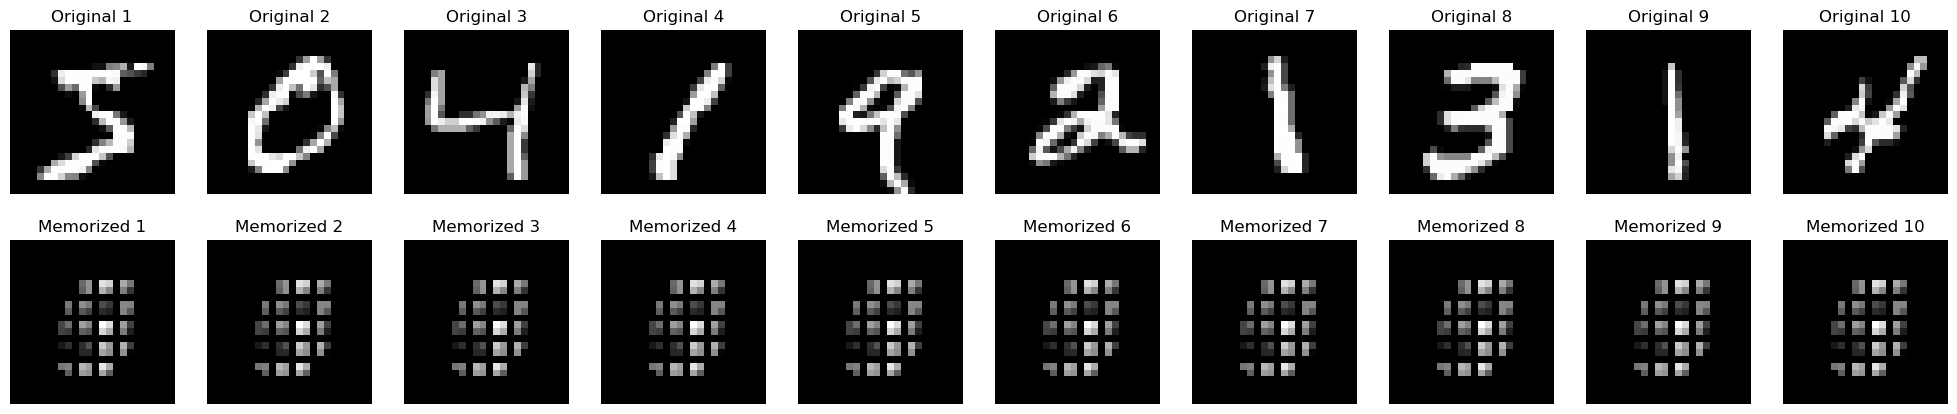

Epoch 1 | Train loss 0.021400 | Memorization loss 0.214953
Saved model and optimizer with memorization loss: 0.2150
Visualizing results at Epoch 2


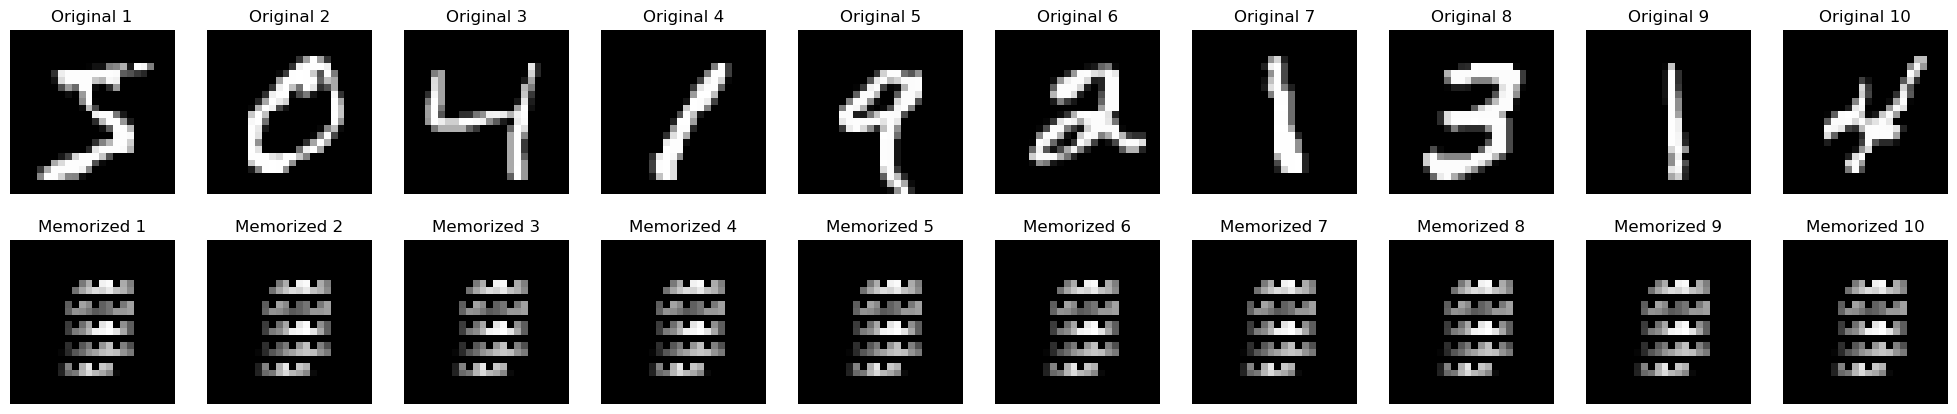

Epoch 2 | Train loss 0.016633 | Memorization loss 0.214622
Saved model and optimizer with memorization loss: 0.2146
Visualizing results at Epoch 3


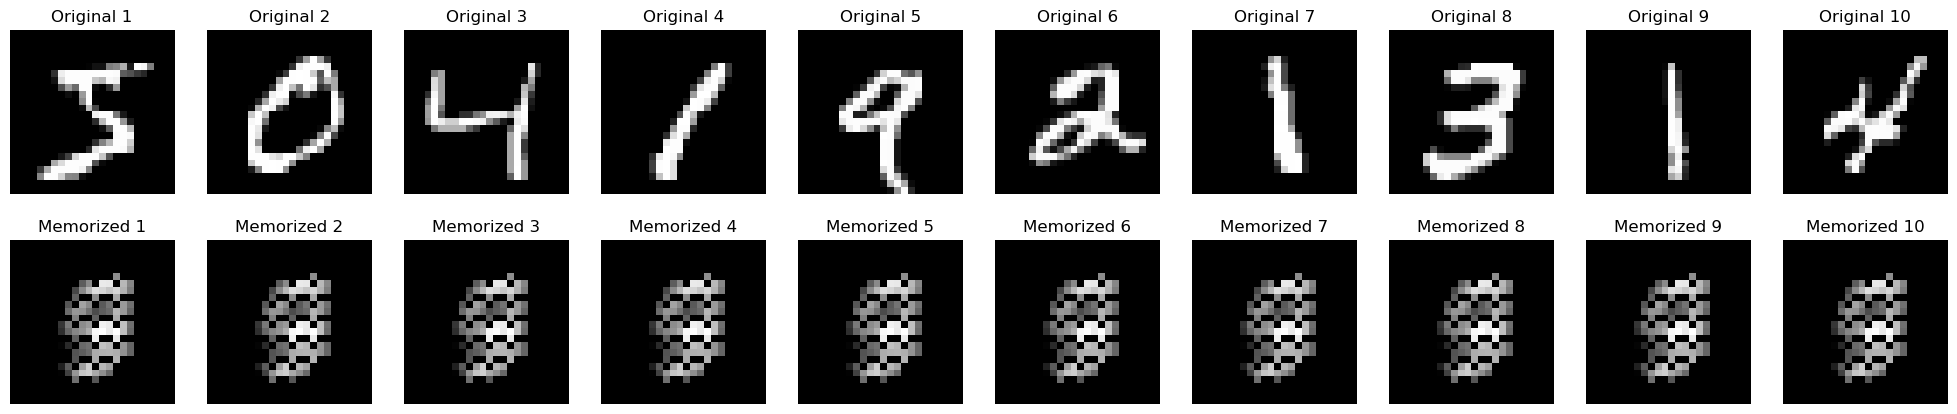

Epoch 3 | Train loss 0.014747 | Memorization loss 0.213351
Saved model and optimizer with memorization loss: 0.2134
Visualizing results at Epoch 4


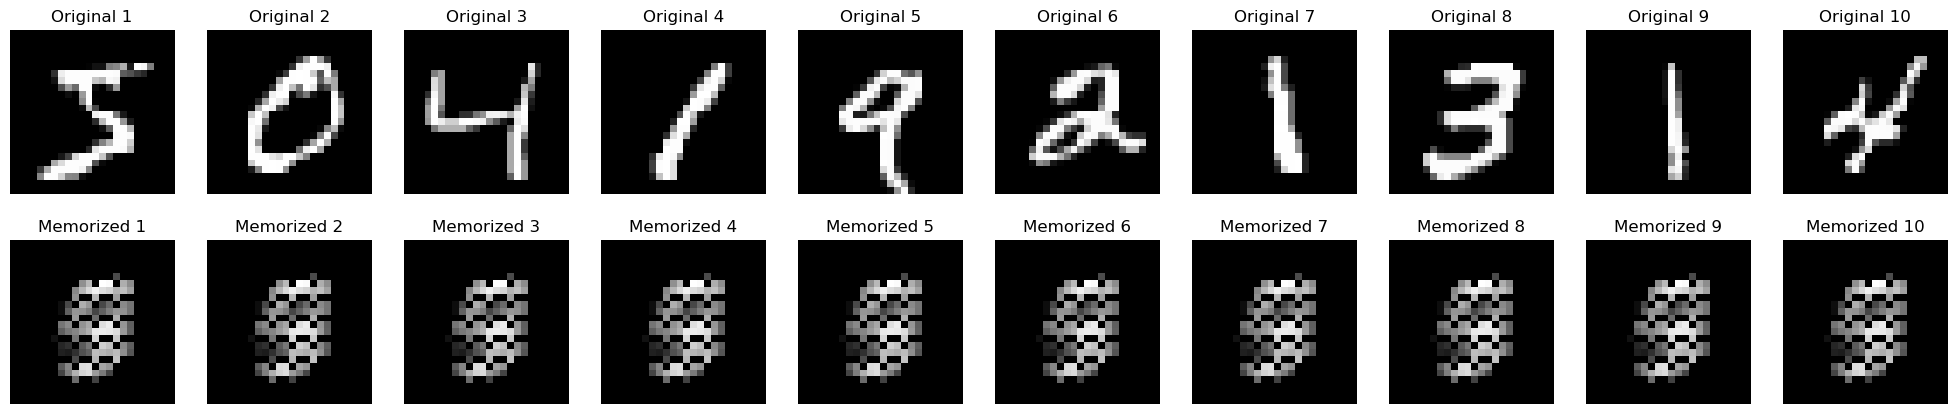

Epoch 4 | Train loss 0.014564 | Memorization loss 0.213791
Visualizing results at Epoch 5


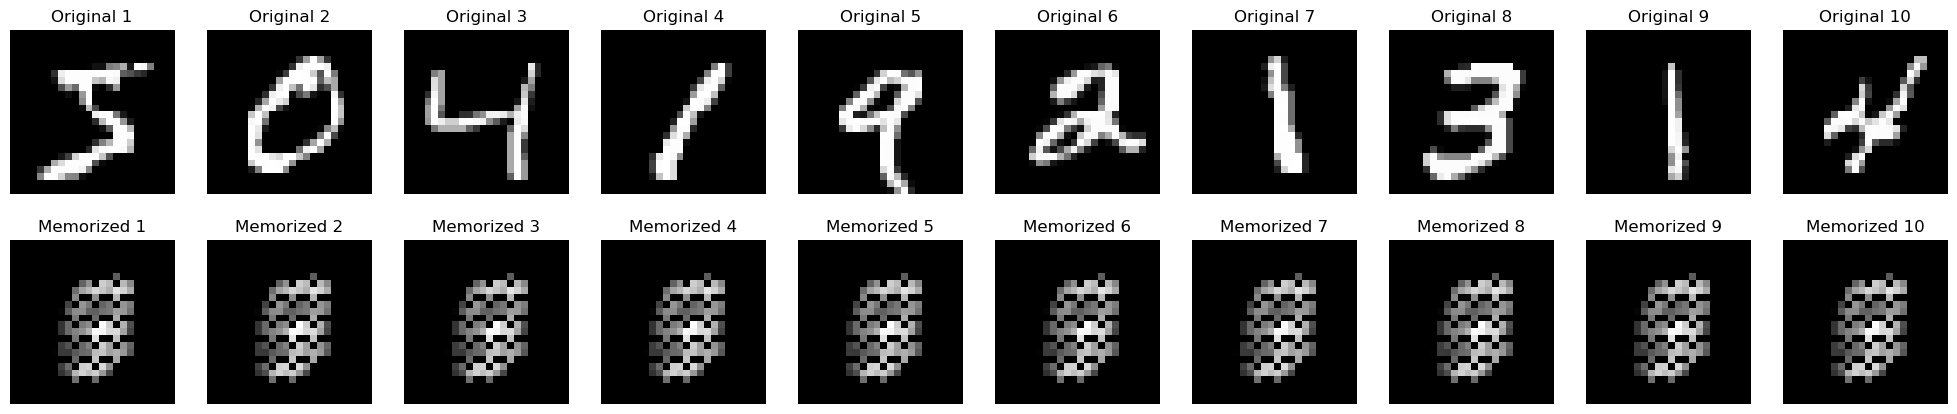

Epoch 5 | Train loss 0.014446 | Memorization loss 0.209169
Saved model and optimizer with memorization loss: 0.2092
Visualizing results at Epoch 6


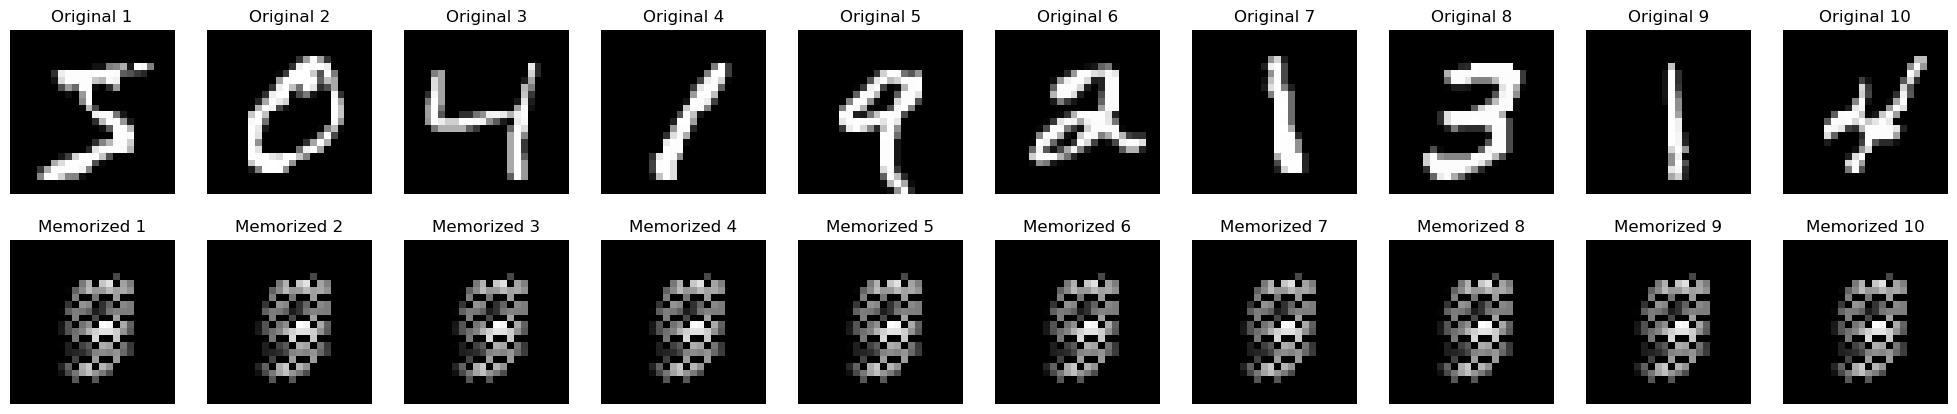

Epoch 6 | Train loss 0.014345 | Memorization loss 0.210677
Visualizing results at Epoch 7


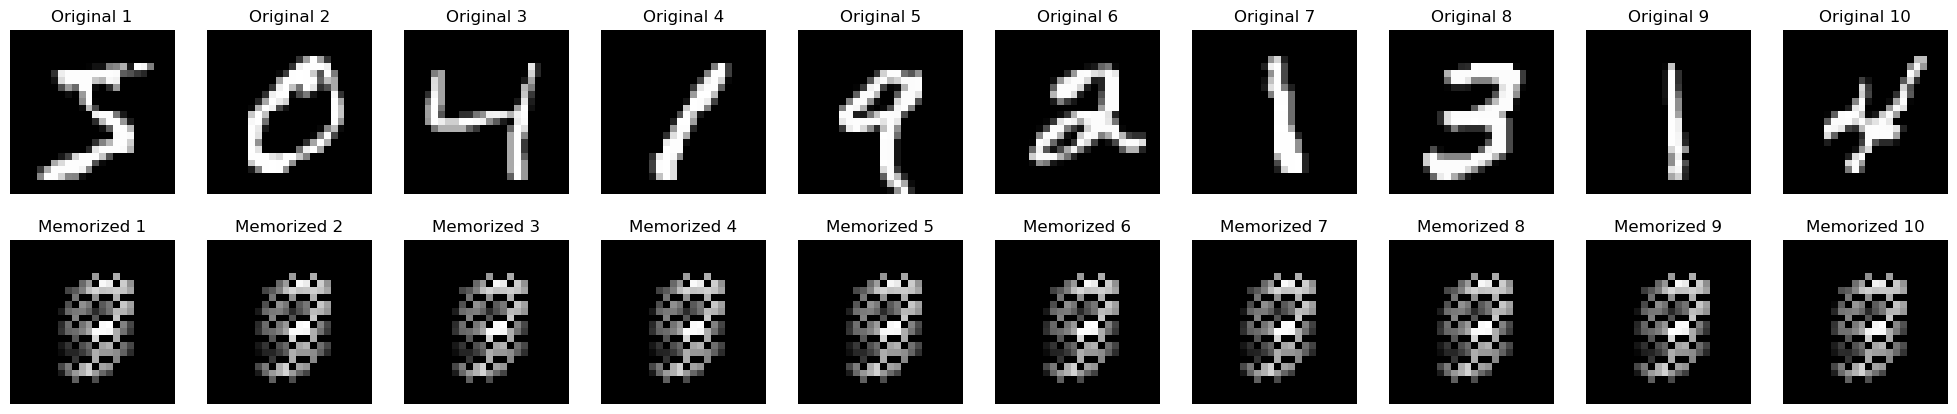

Epoch 7 | Train loss 0.014271 | Memorization loss 0.211413
Visualizing results at Epoch 8


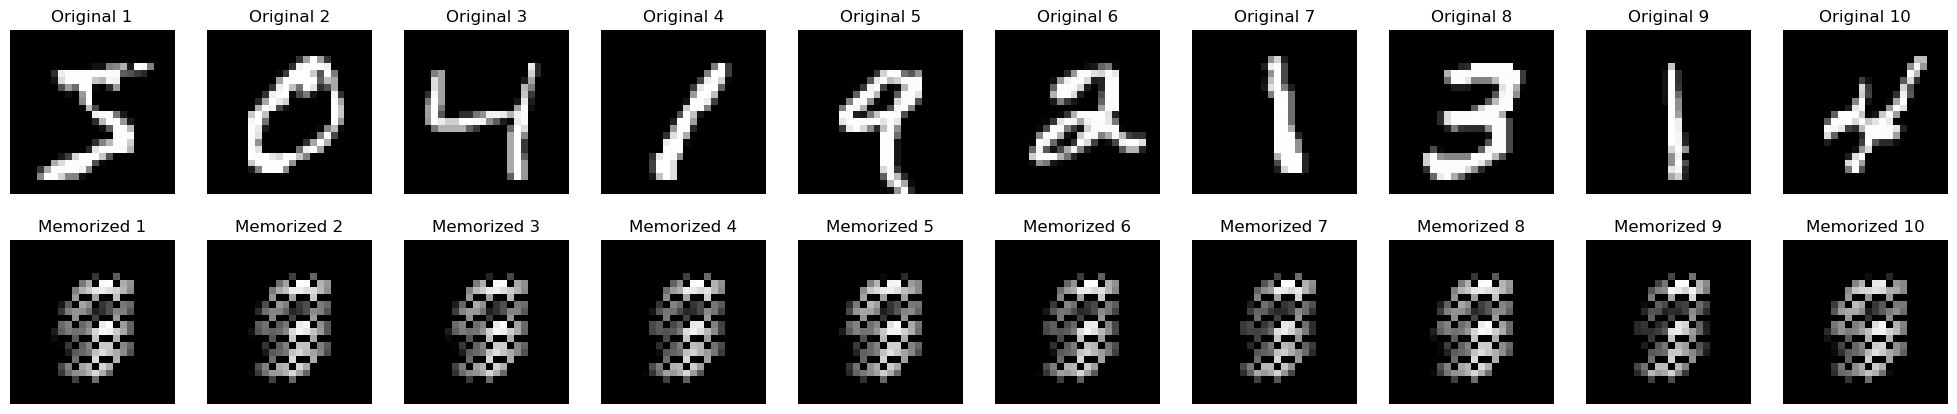

Epoch 8 | Train loss 0.014212 | Memorization loss 0.205503
Saved model and optimizer with memorization loss: 0.2055
Visualizing results at Epoch 9


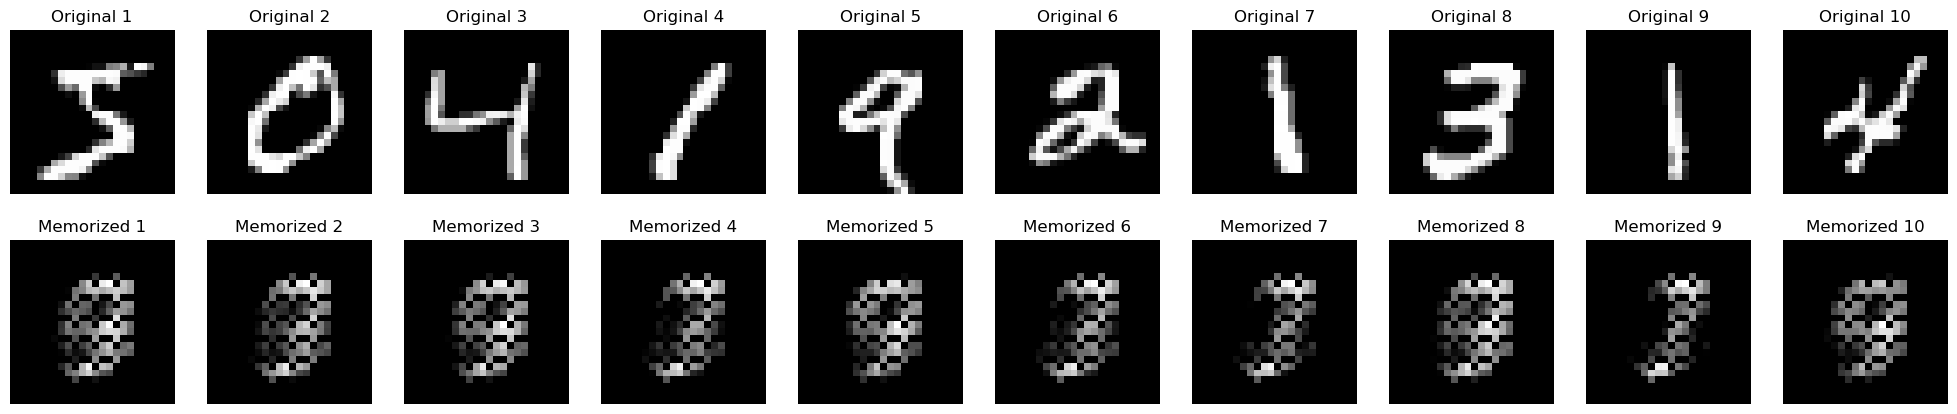

Epoch 9 | Train loss 0.014157 | Memorization loss 0.203296
Saved model and optimizer with memorization loss: 0.2033
Visualizing results at Epoch 10


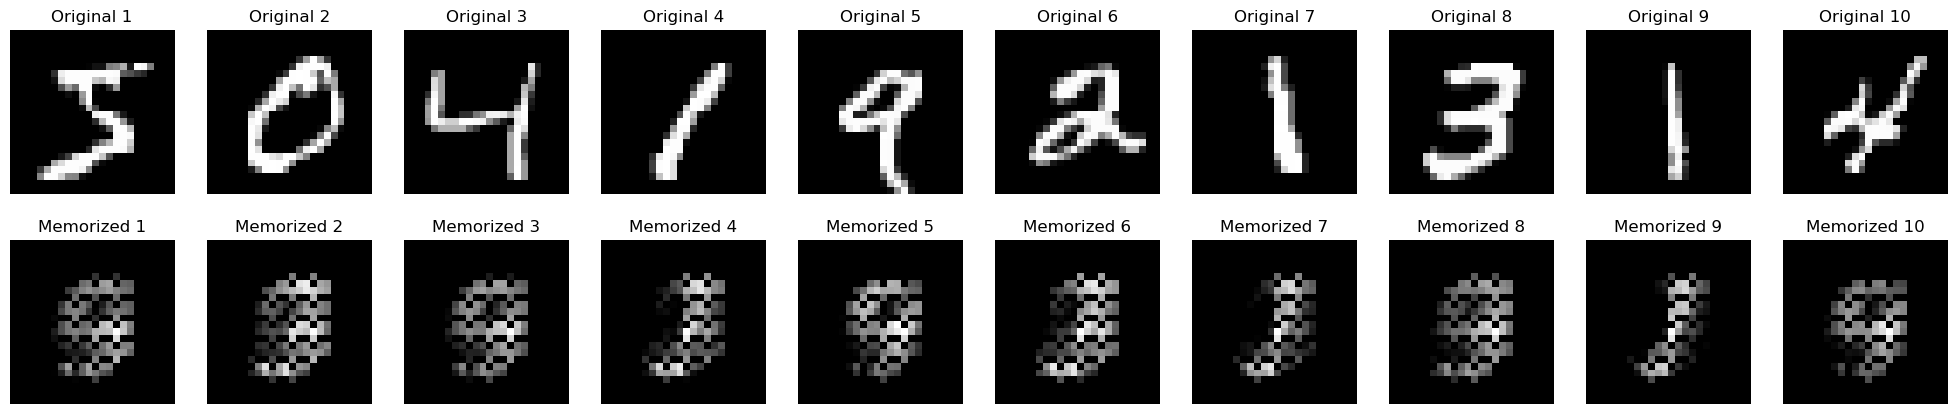

Epoch 10 | Train loss 0.012481 | Memorization loss 0.196597
Saved model and optimizer with memorization loss: 0.1966
Visualizing results at Epoch 11


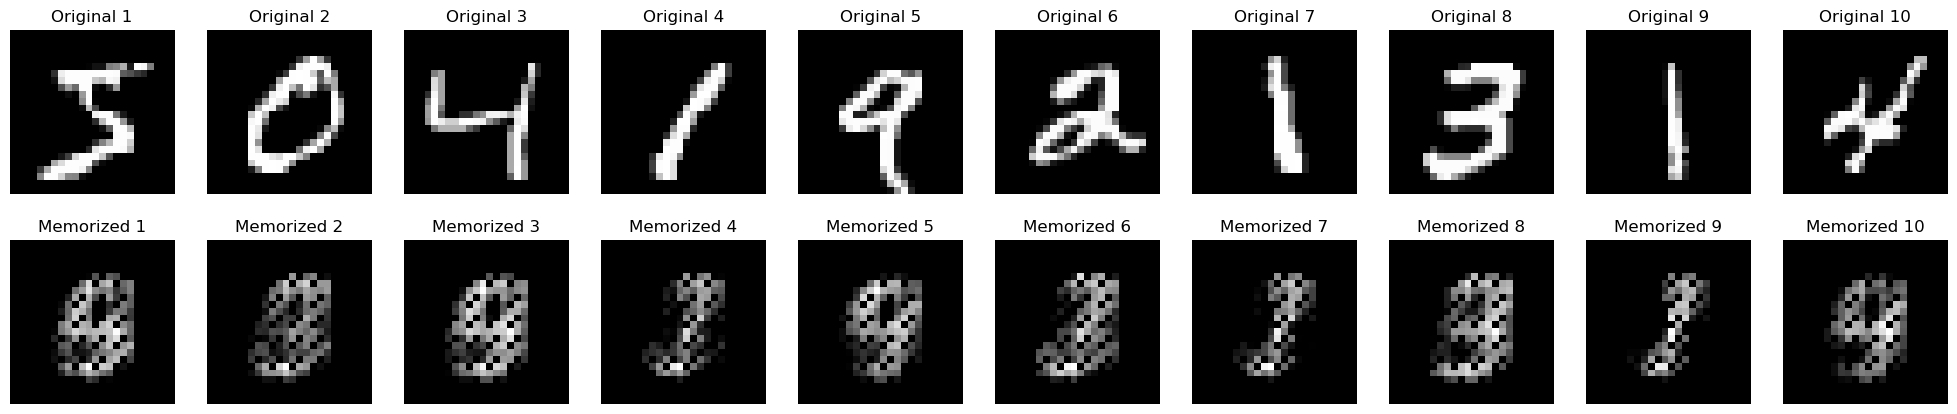

Epoch 11 | Train loss 0.009637 | Memorization loss 0.188988
Saved model and optimizer with memorization loss: 0.1890
Visualizing results at Epoch 12


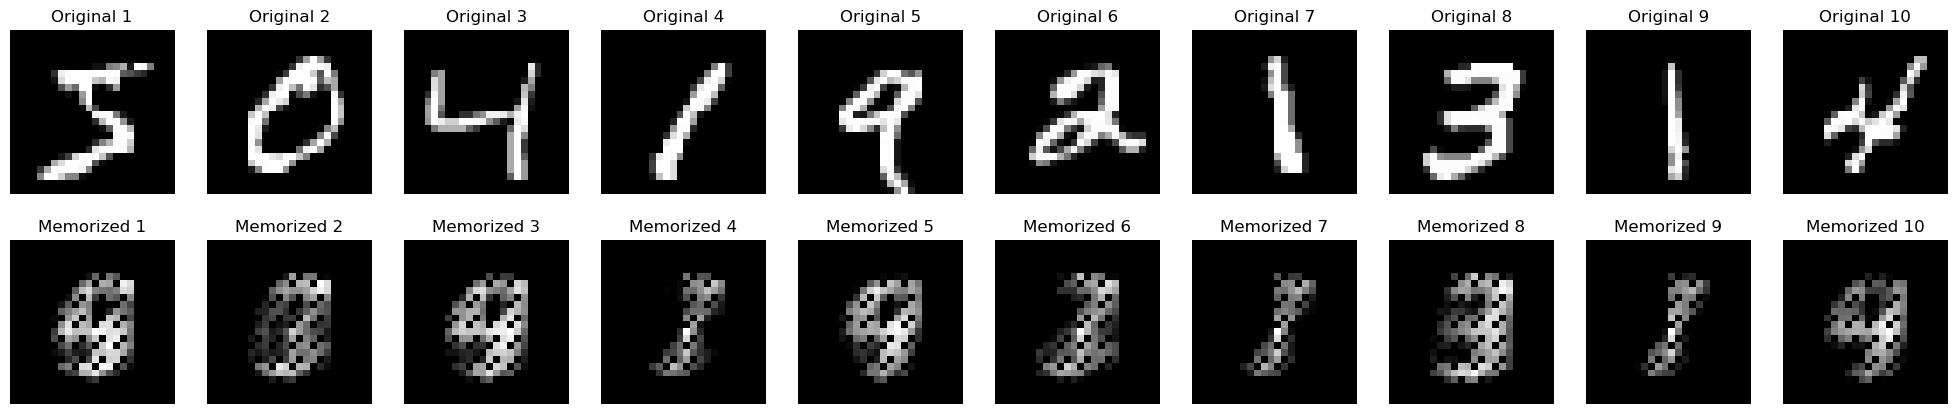

Epoch 12 | Train loss 0.009572 | Memorization loss 0.187777
Saved model and optimizer with memorization loss: 0.1878
Visualizing results at Epoch 13


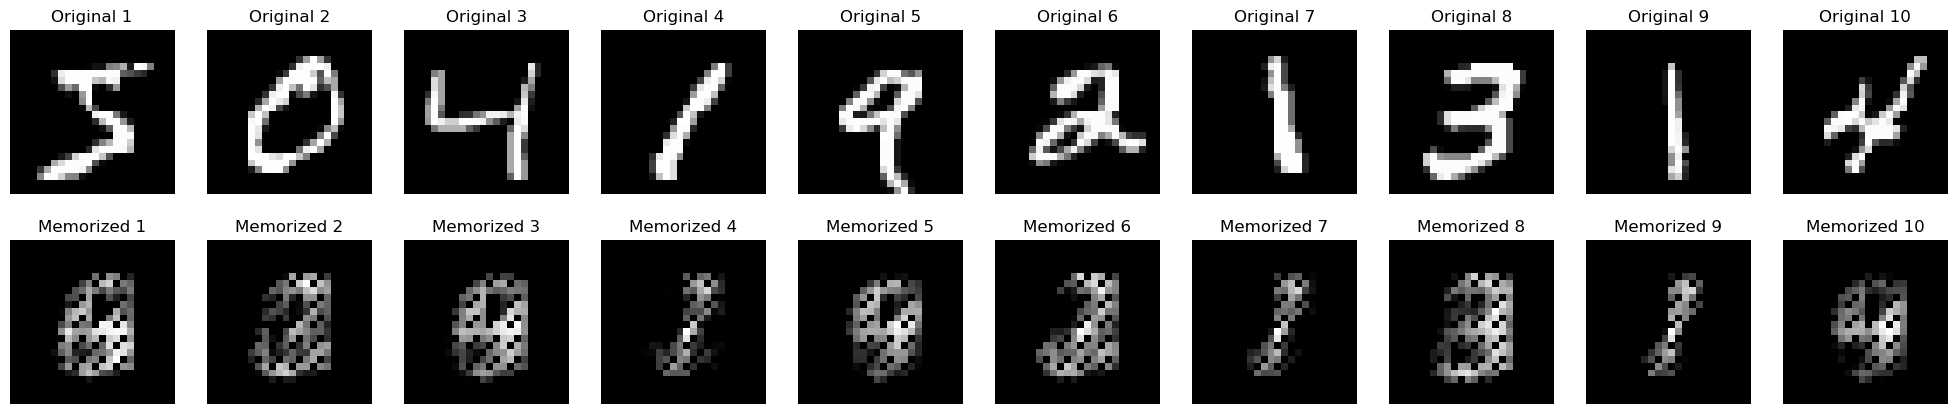

Epoch 13 | Train loss 0.009536 | Memorization loss 0.186363
Saved model and optimizer with memorization loss: 0.1864
Visualizing results at Epoch 14


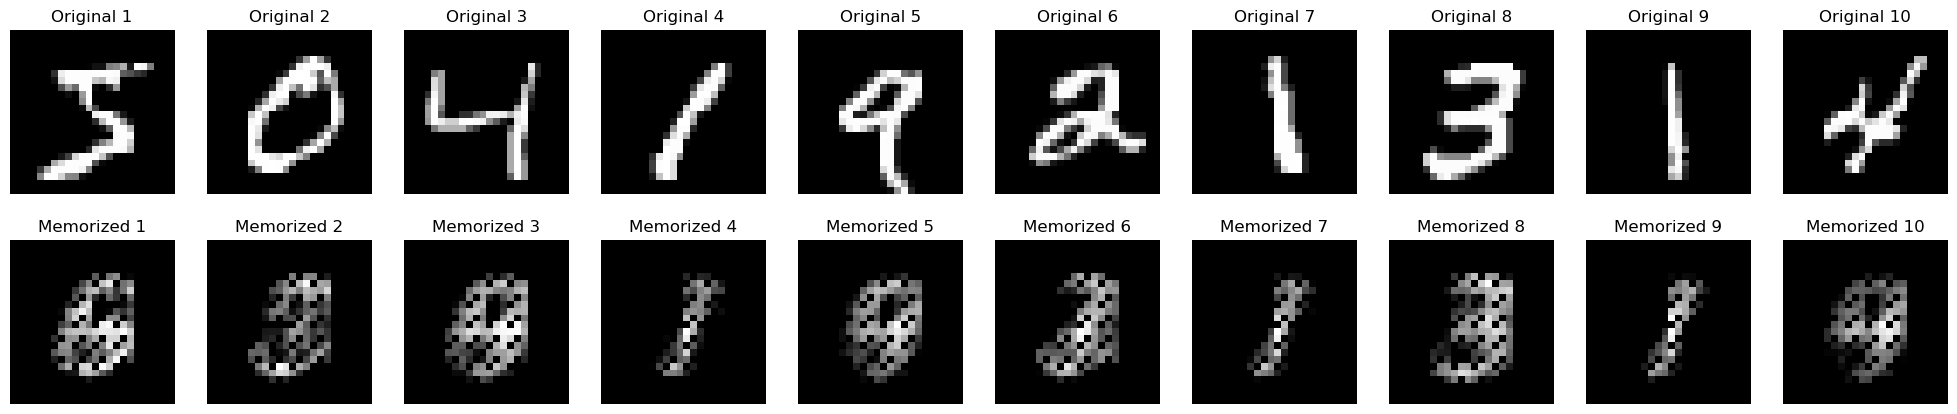

Epoch 14 | Train loss 0.009502 | Memorization loss 0.180753
Saved model and optimizer with memorization loss: 0.1808
Visualizing results at Epoch 15


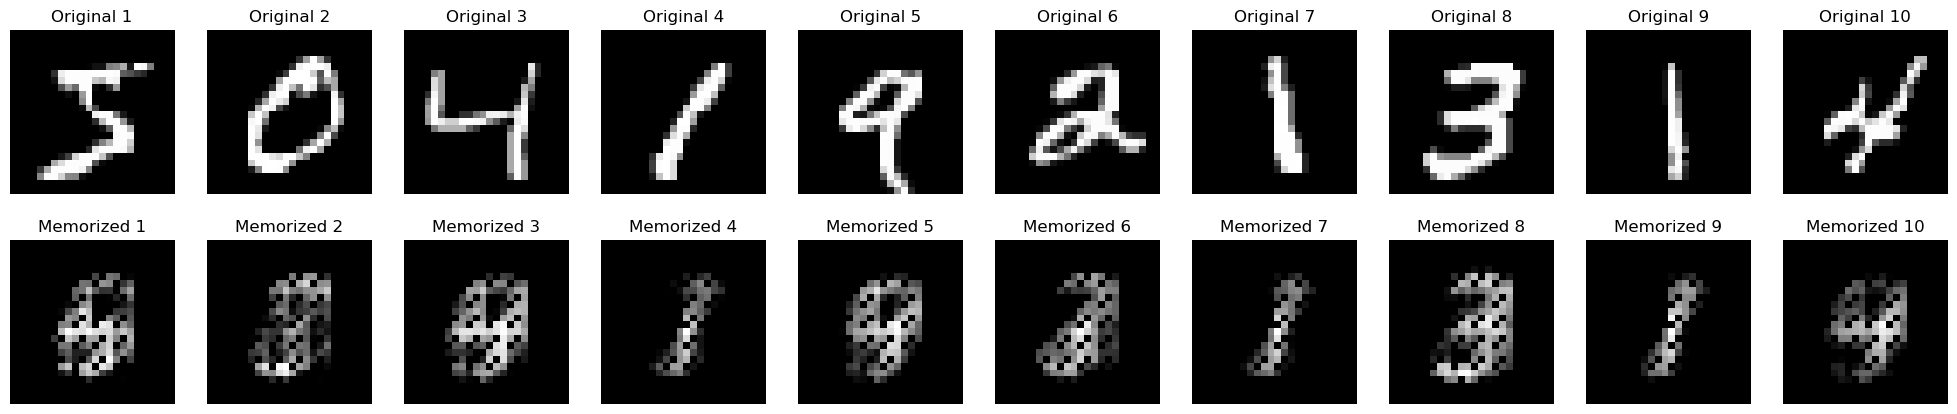

Epoch 15 | Train loss 0.009478 | Memorization loss 0.183660
Visualizing results at Epoch 16


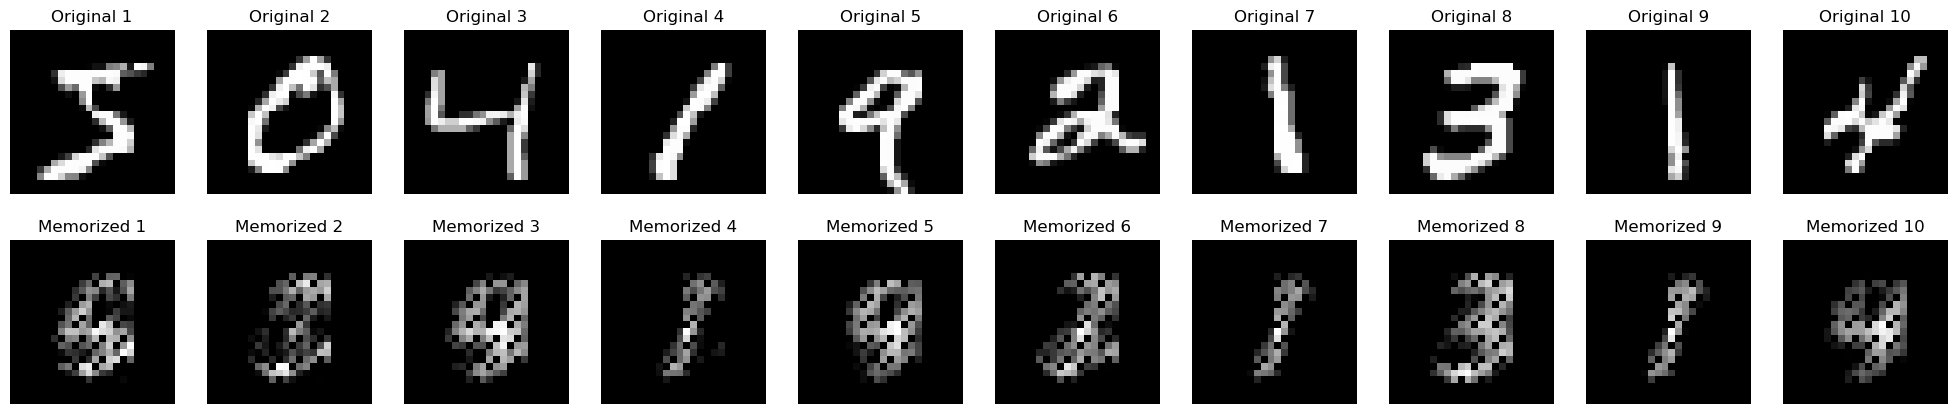

Epoch 16 | Train loss 0.009455 | Memorization loss 0.181769
Visualizing results at Epoch 17


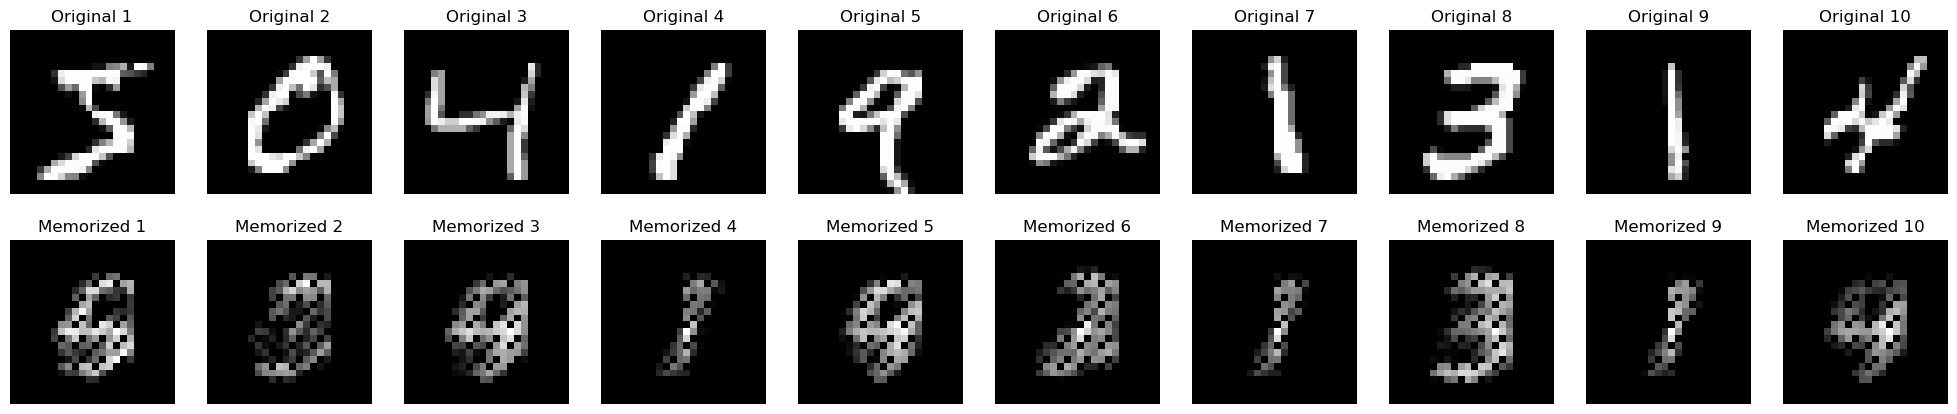

Epoch 17 | Train loss 0.009443 | Memorization loss 0.179152
Saved model and optimizer with memorization loss: 0.1792
Visualizing results at Epoch 18


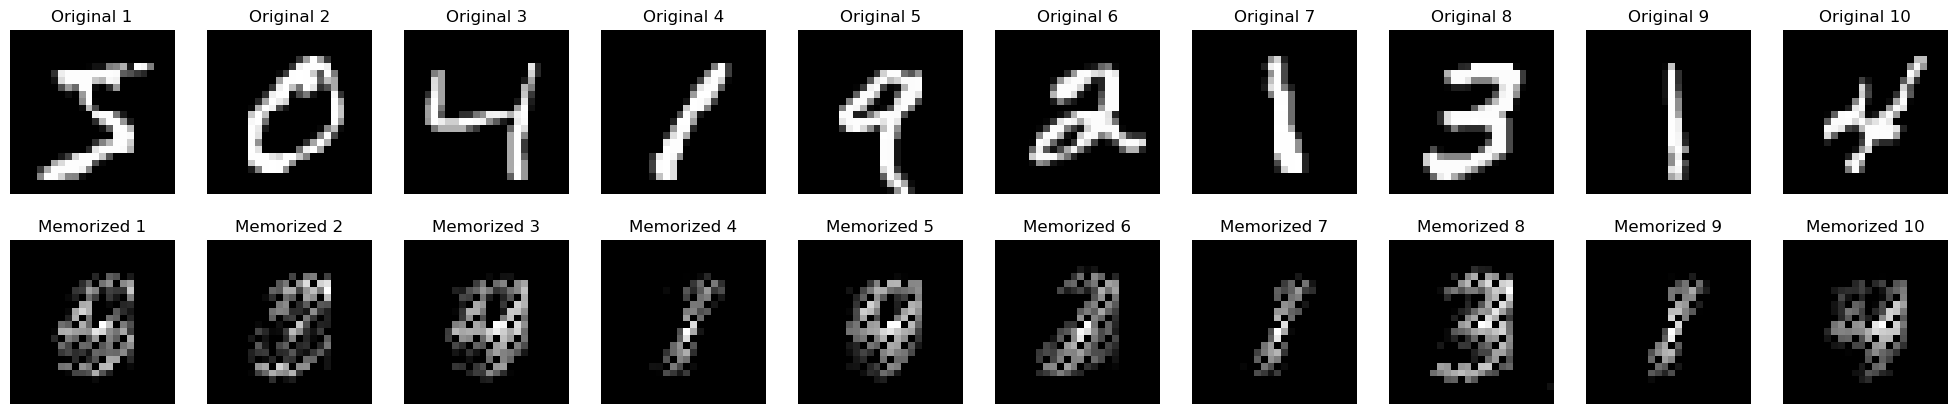

Epoch 18 | Train loss 0.009436 | Memorization loss 0.180052
Visualizing results at Epoch 19


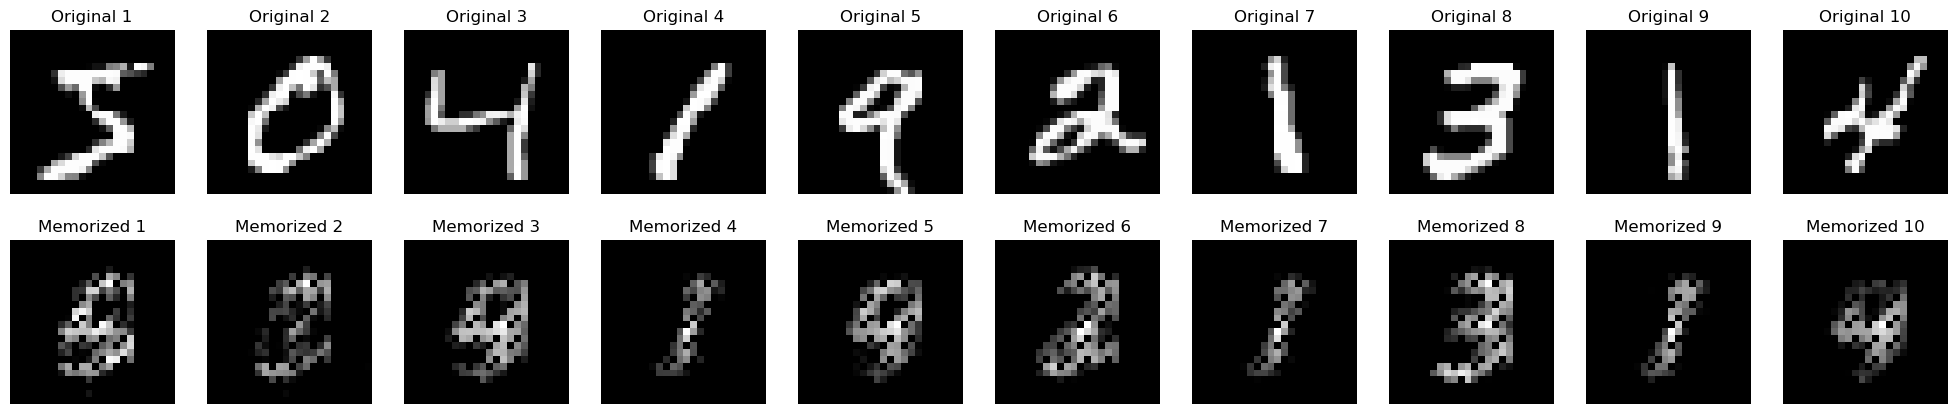

Epoch 19 | Train loss 0.009415 | Memorization loss 0.181304
Visualizing results at Epoch 20


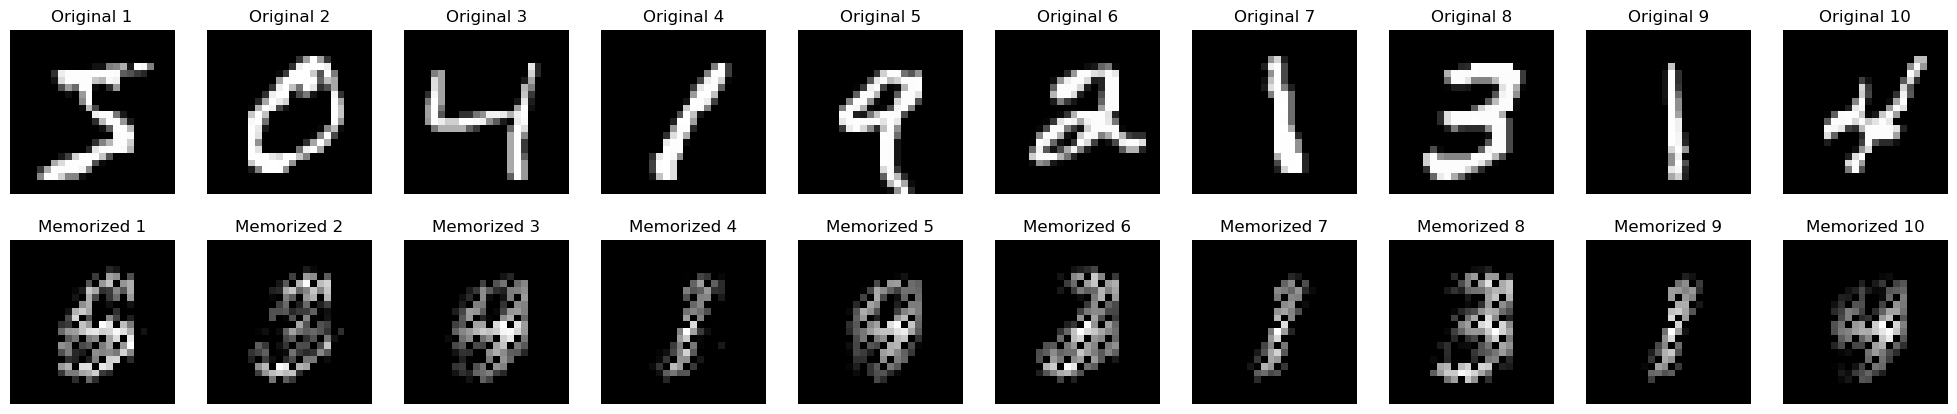

Epoch 20 | Train loss 0.009411 | Memorization loss 0.181616
Visualizing results at Epoch 21


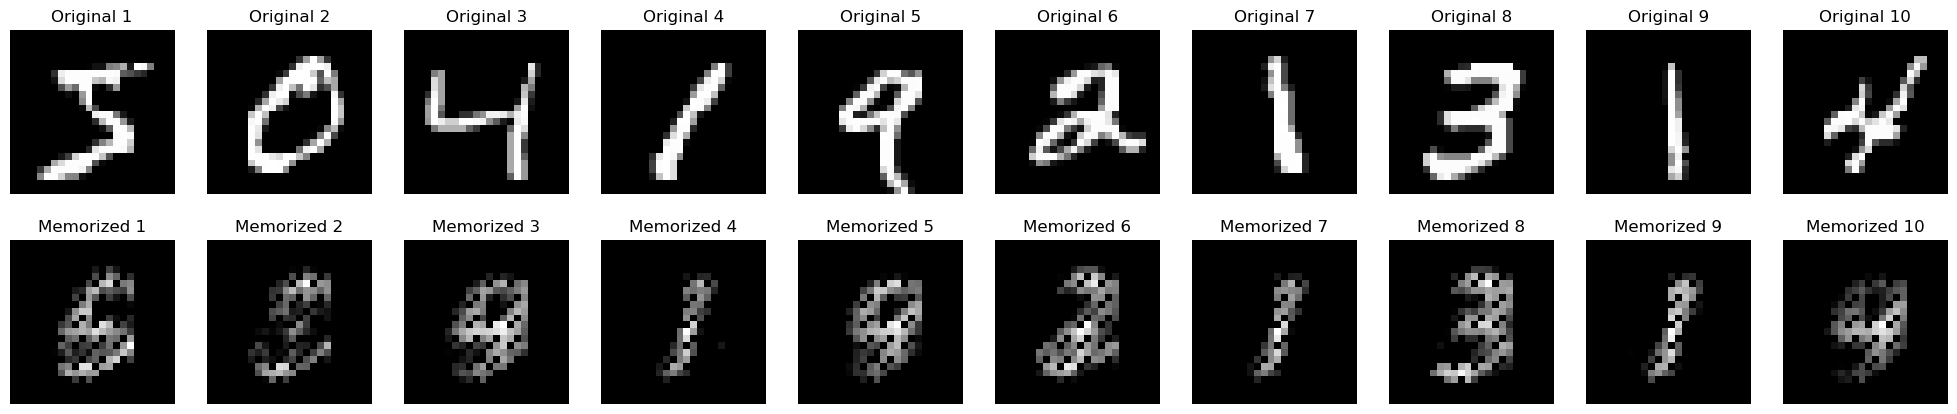

Epoch 21 | Train loss 0.009404 | Memorization loss 0.179523
Visualizing results at Epoch 22


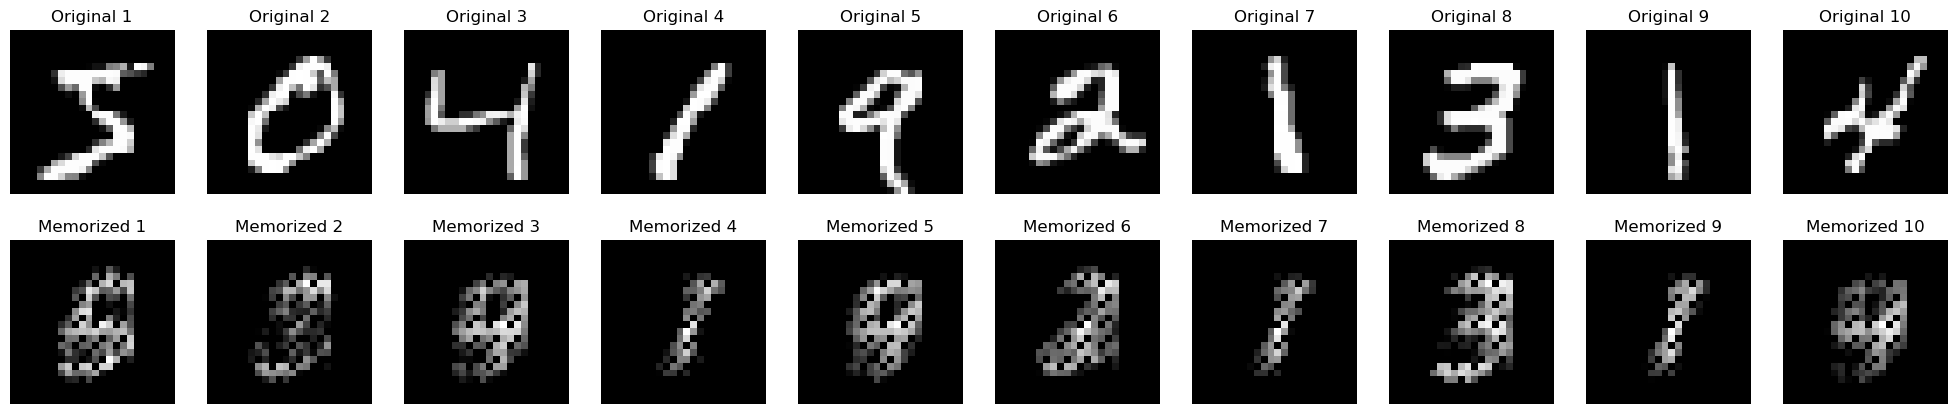

Epoch 22 | Train loss 0.009401 | Memorization loss 0.177903
Saved model and optimizer with memorization loss: 0.1779
Visualizing results at Epoch 23


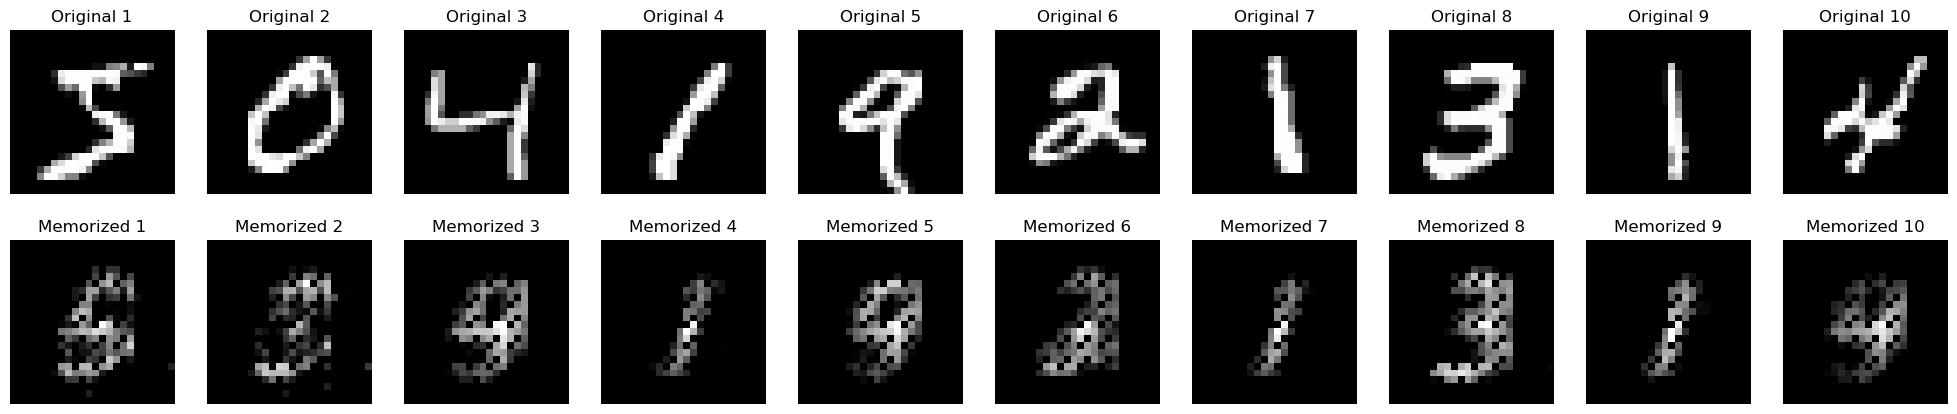

Epoch 23 | Train loss 0.009399 | Memorization loss 0.178993
Visualizing results at Epoch 24


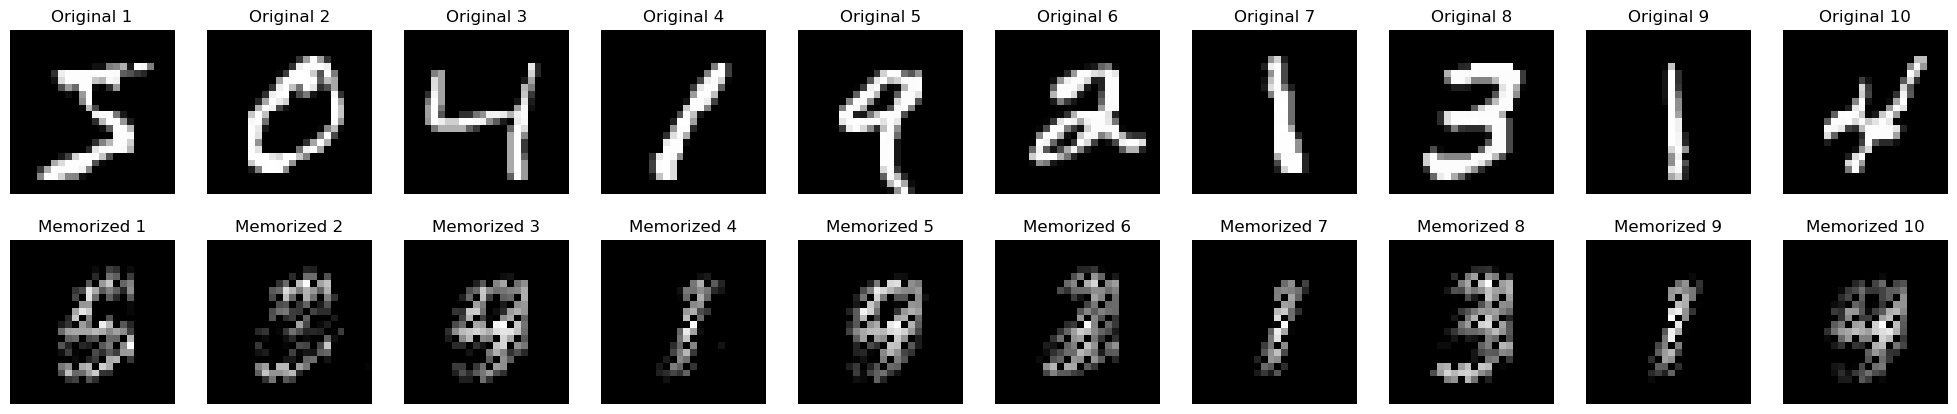

Epoch 24 | Train loss 0.009396 | Memorization loss 0.178003
Visualizing results at Epoch 25


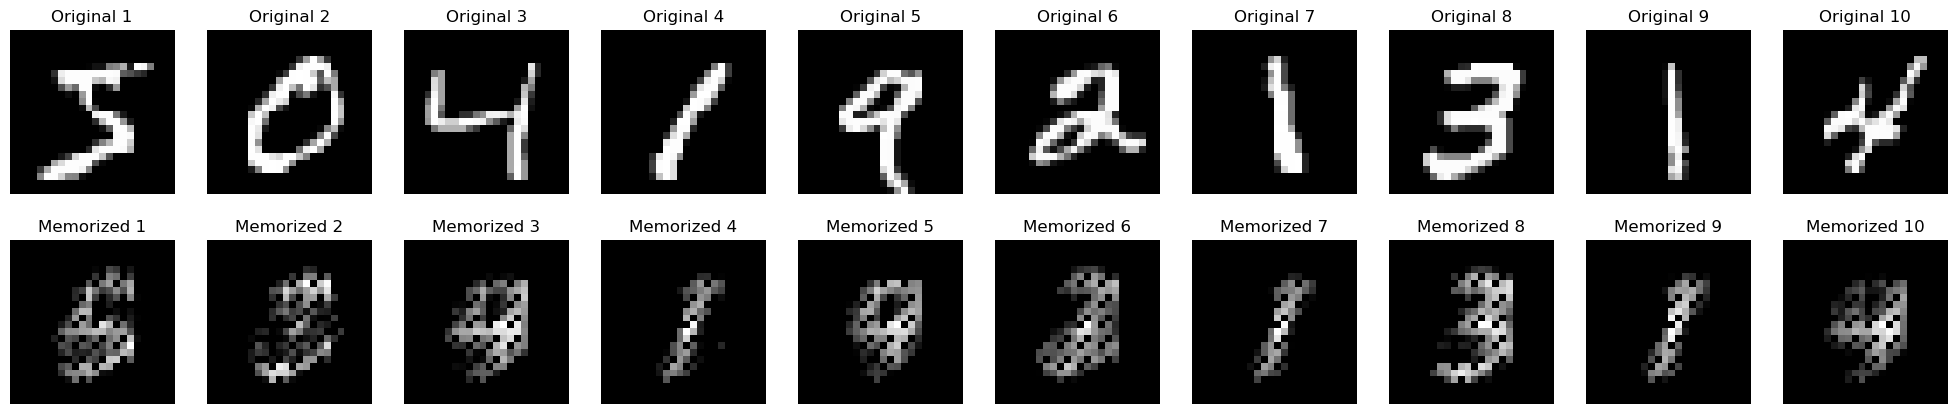

Epoch 25 | Train loss 0.009389 | Memorization loss 0.178870
Visualizing results at Epoch 26


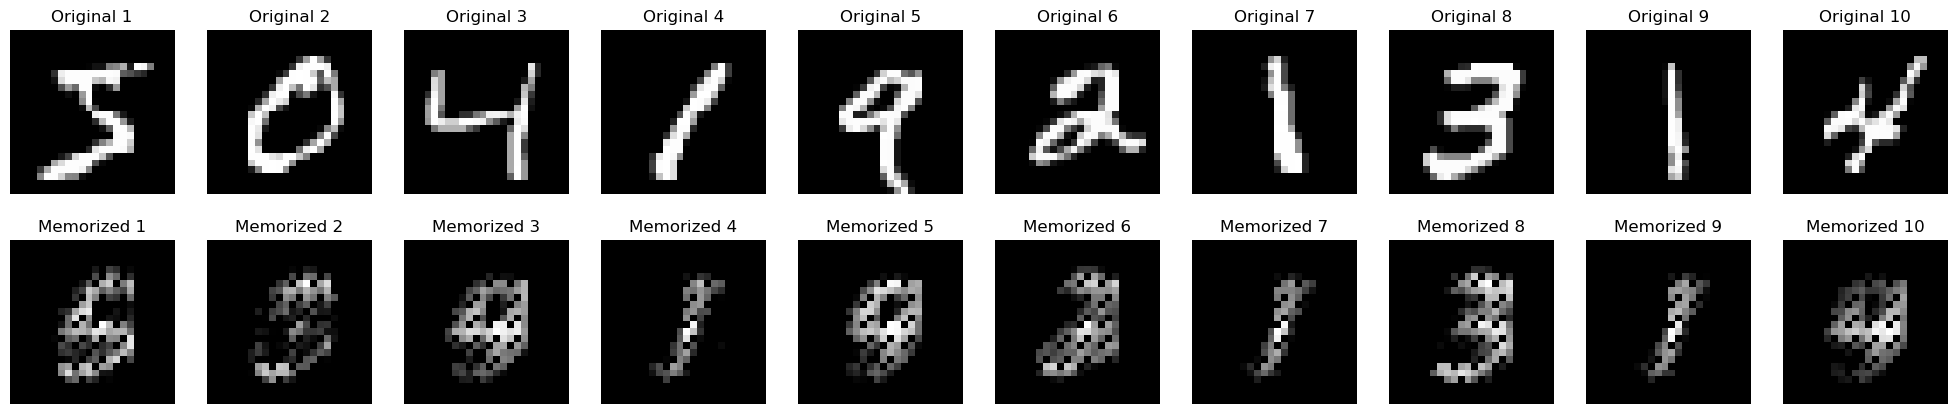

Epoch 26 | Train loss 0.009392 | Memorization loss 0.176514
Saved model and optimizer with memorization loss: 0.1765
Visualizing results at Epoch 27


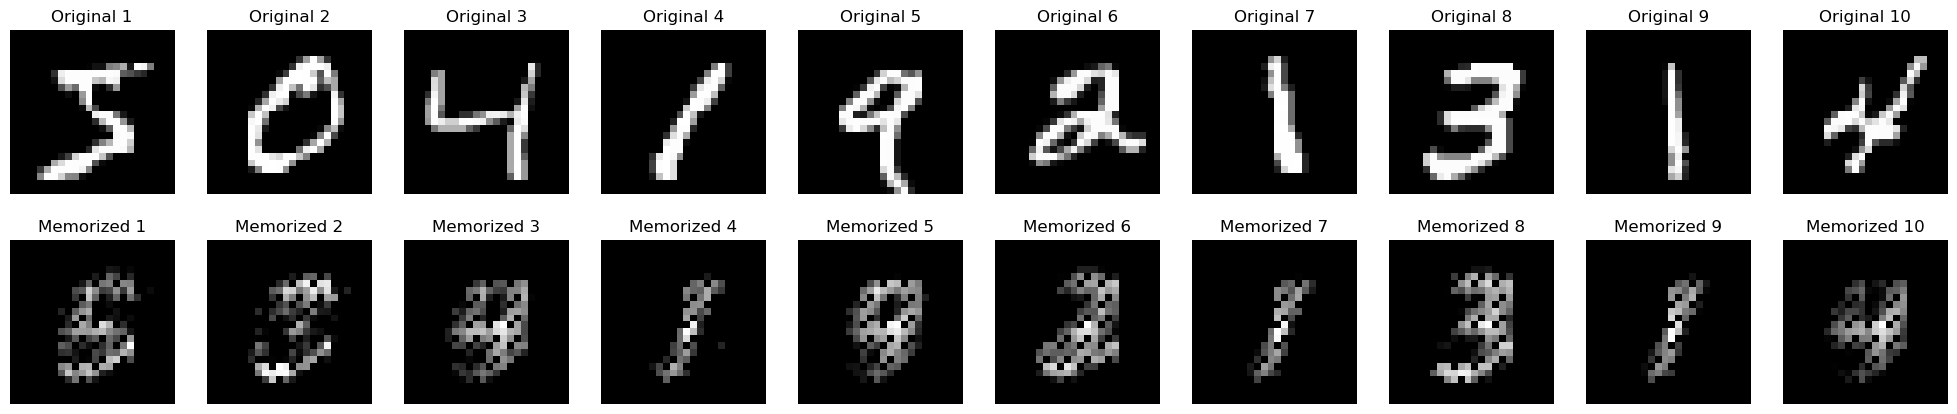

Epoch 27 | Train loss 0.009387 | Memorization loss 0.178758
Visualizing results at Epoch 28


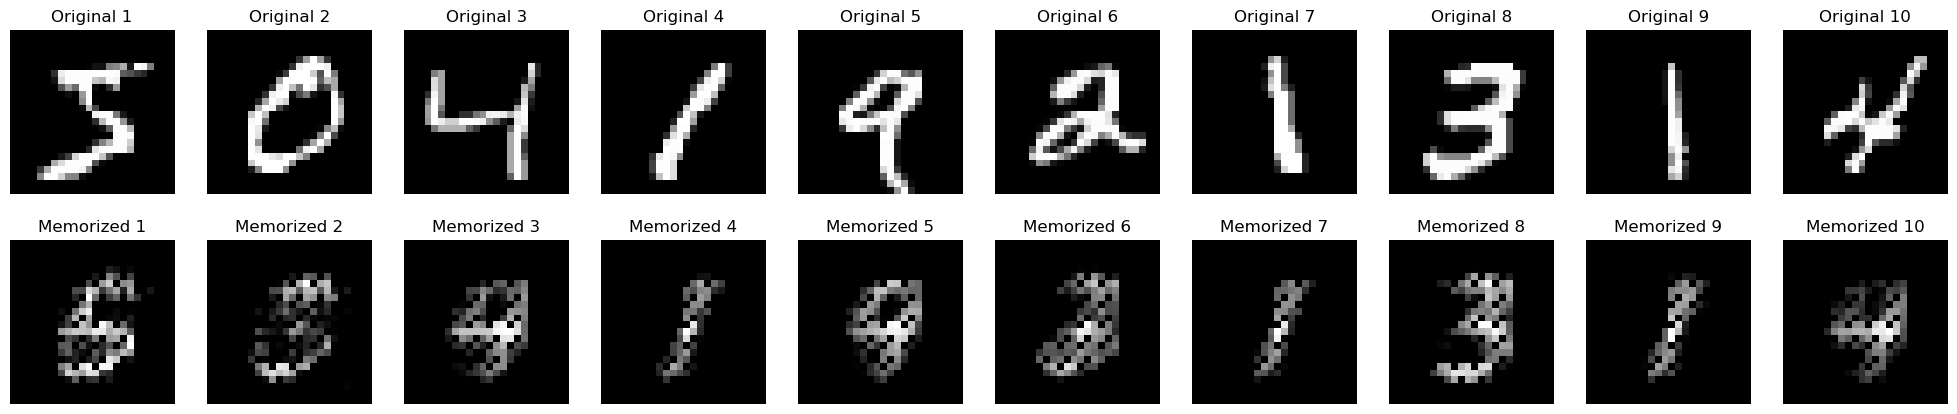

Epoch 28 | Train loss 0.009380 | Memorization loss 0.177458
Visualizing results at Epoch 29


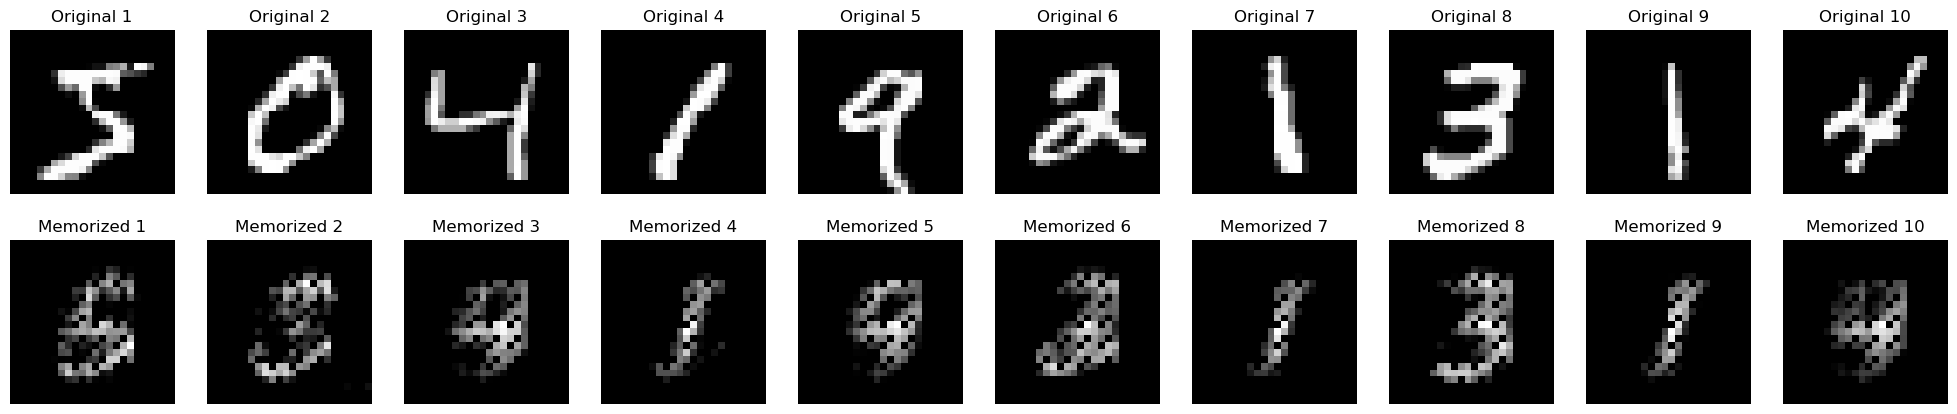

Epoch 29 | Train loss 0.009373 | Memorization loss 0.178196
Visualizing results at Epoch 30


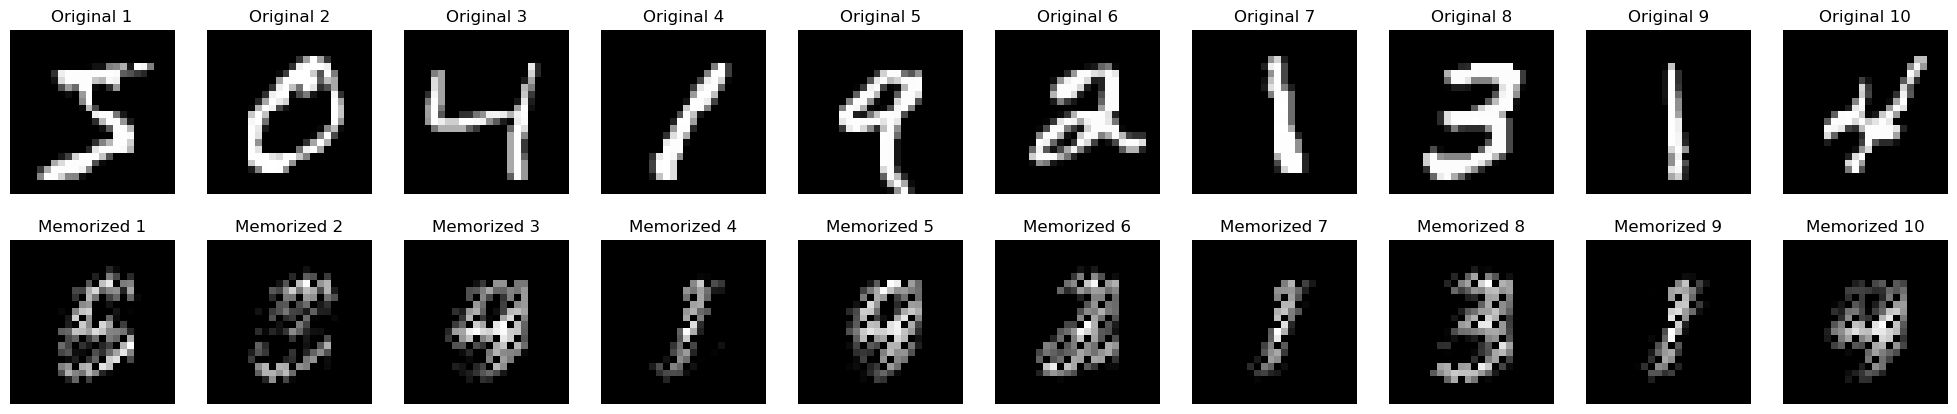

Epoch 30 | Train loss 0.009394 | Memorization loss 0.177461
Visualizing results at Epoch 31


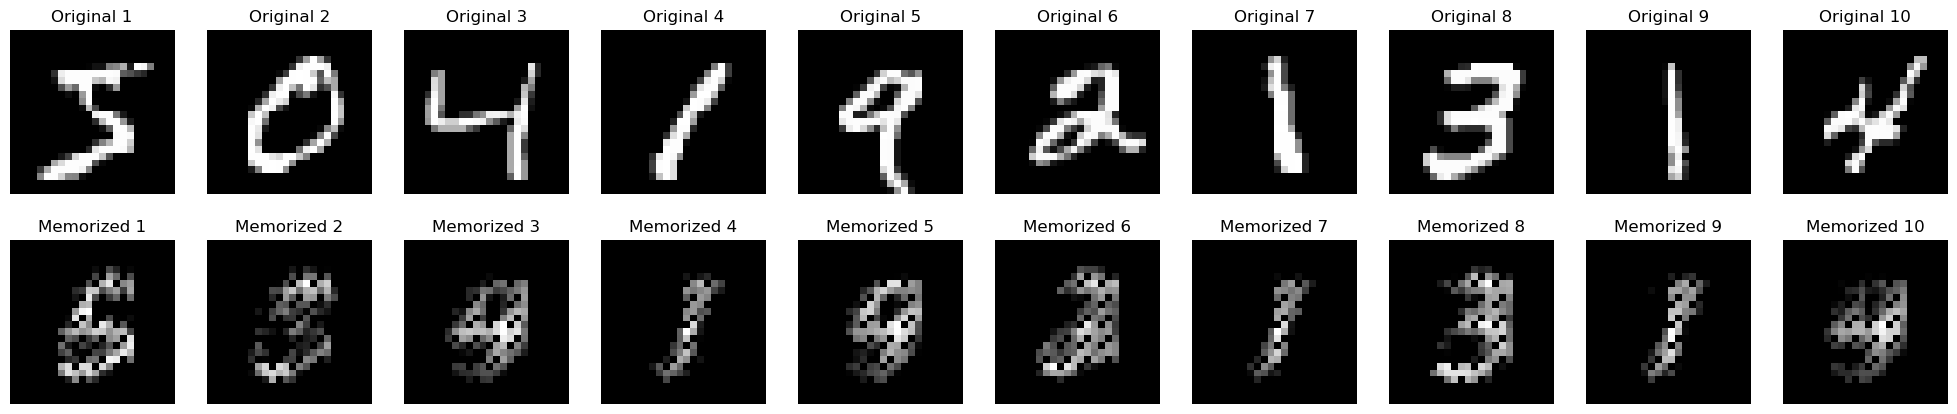

Epoch 31 | Train loss 0.009382 | Memorization loss 0.178256
Visualizing results at Epoch 32


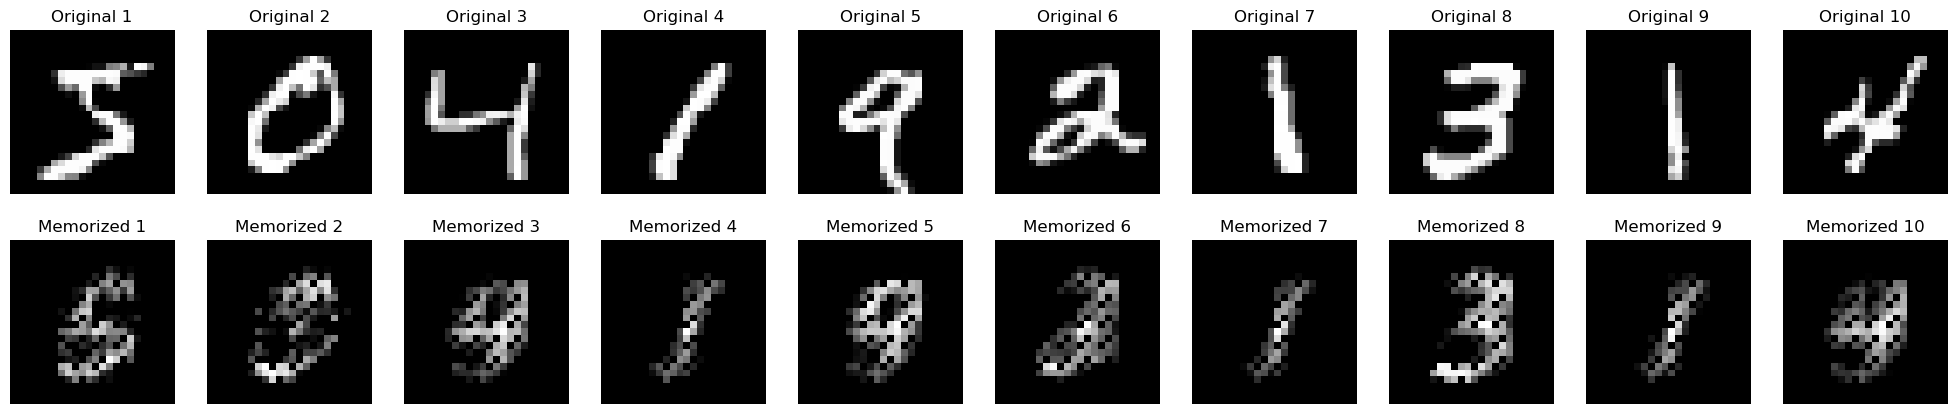

Epoch 32 | Train loss 0.009383 | Memorization loss 0.174795
Saved model and optimizer with memorization loss: 0.1748
Visualizing results at Epoch 33


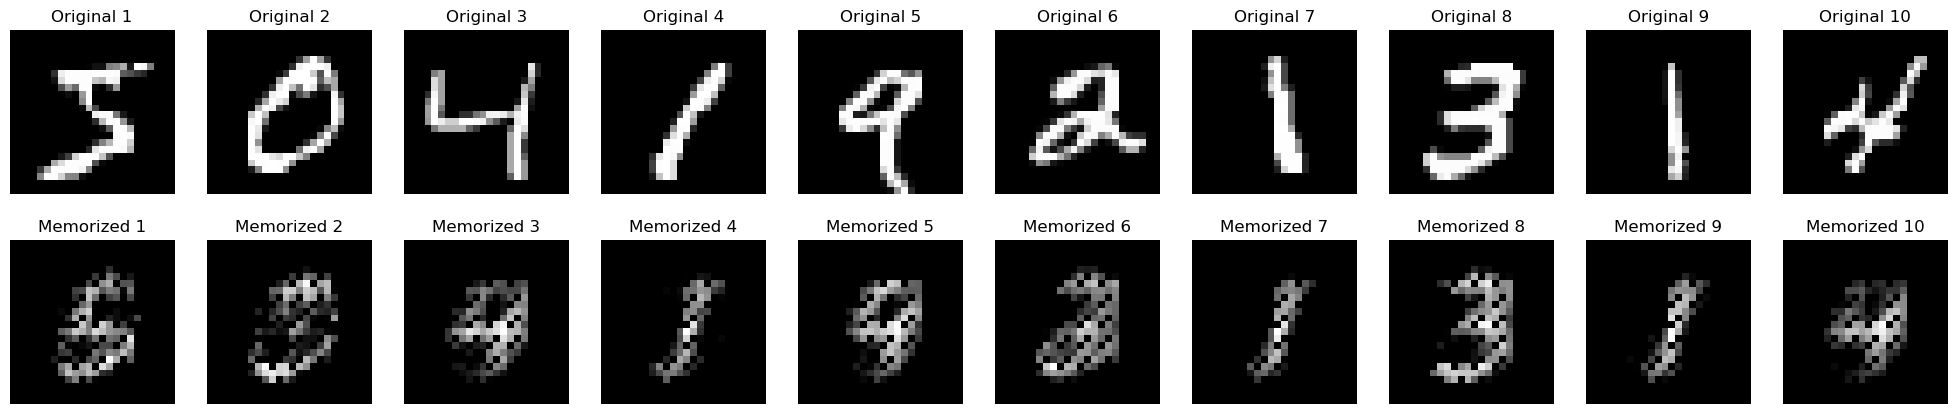

Epoch 33 | Train loss 0.009374 | Memorization loss 0.177877
Visualizing results at Epoch 34


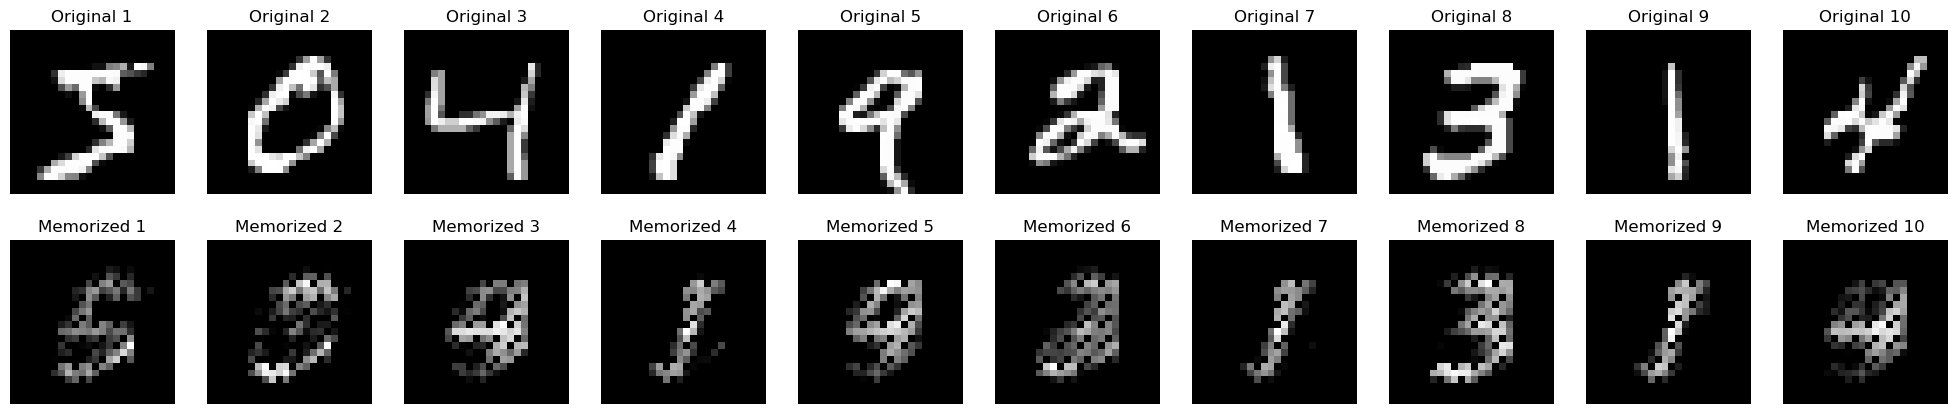

Epoch 34 | Train loss 0.009376 | Memorization loss 0.175703
Visualizing results at Epoch 35


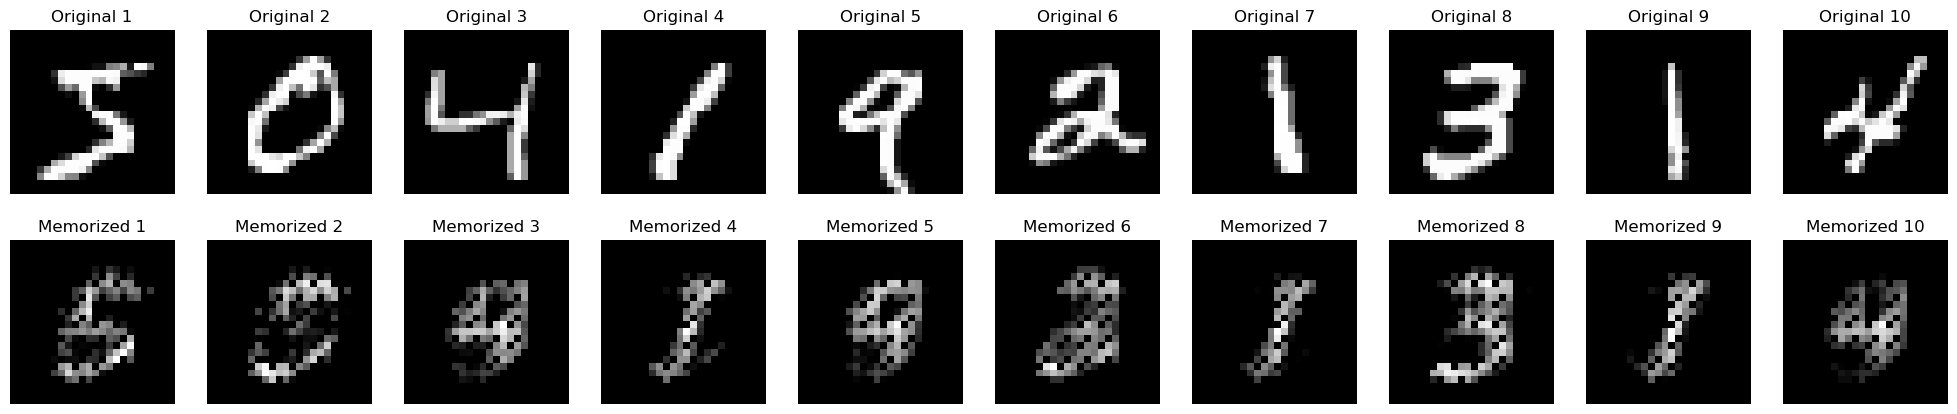

Epoch 35 | Train loss 0.009379 | Memorization loss 0.177985
Visualizing results at Epoch 36


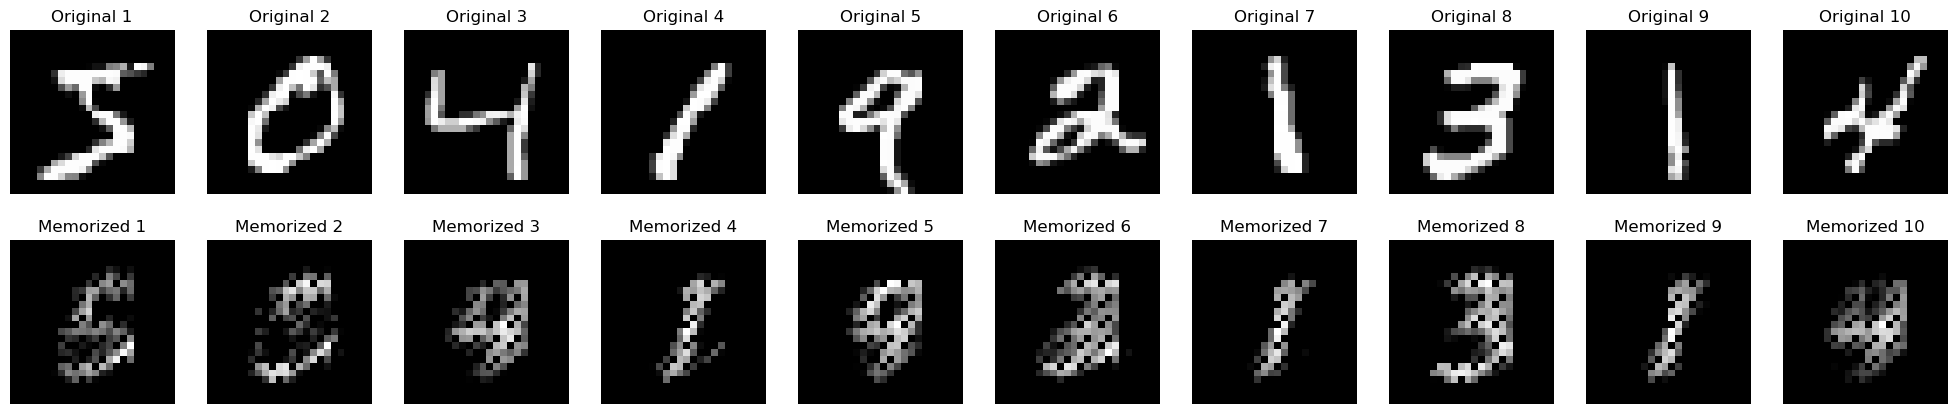

Epoch 36 | Train loss 0.009376 | Memorization loss 0.175840
Visualizing results at Epoch 37


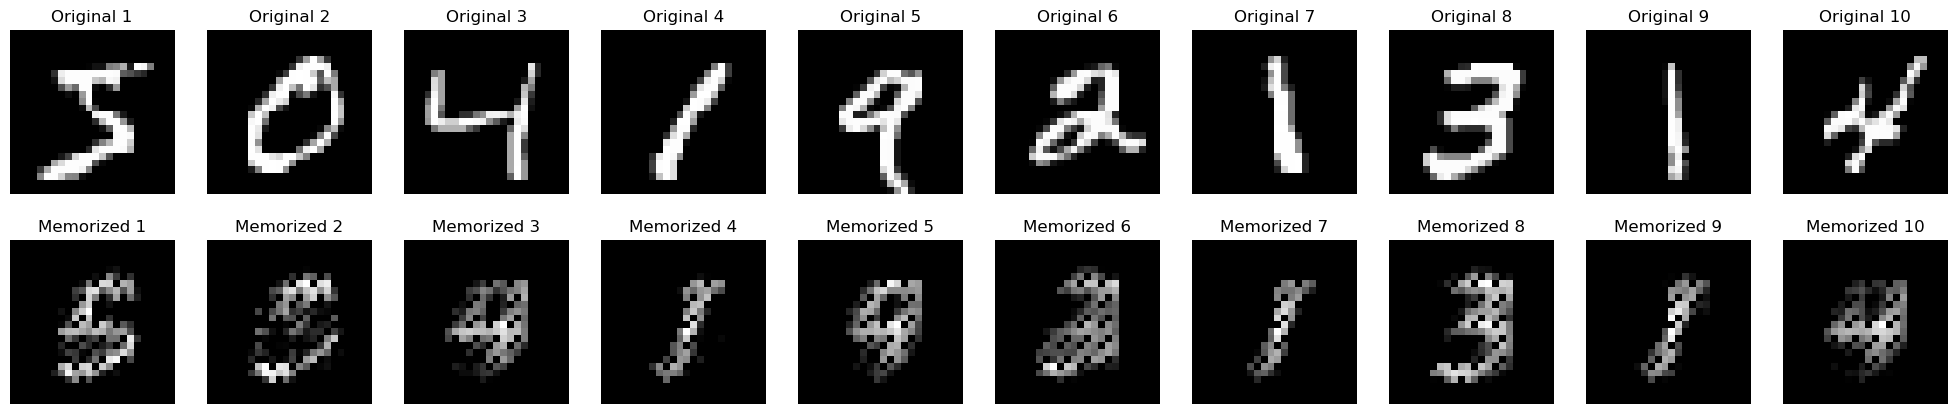

Epoch 37 | Train loss 0.009371 | Memorization loss 0.177555
Visualizing results at Epoch 38


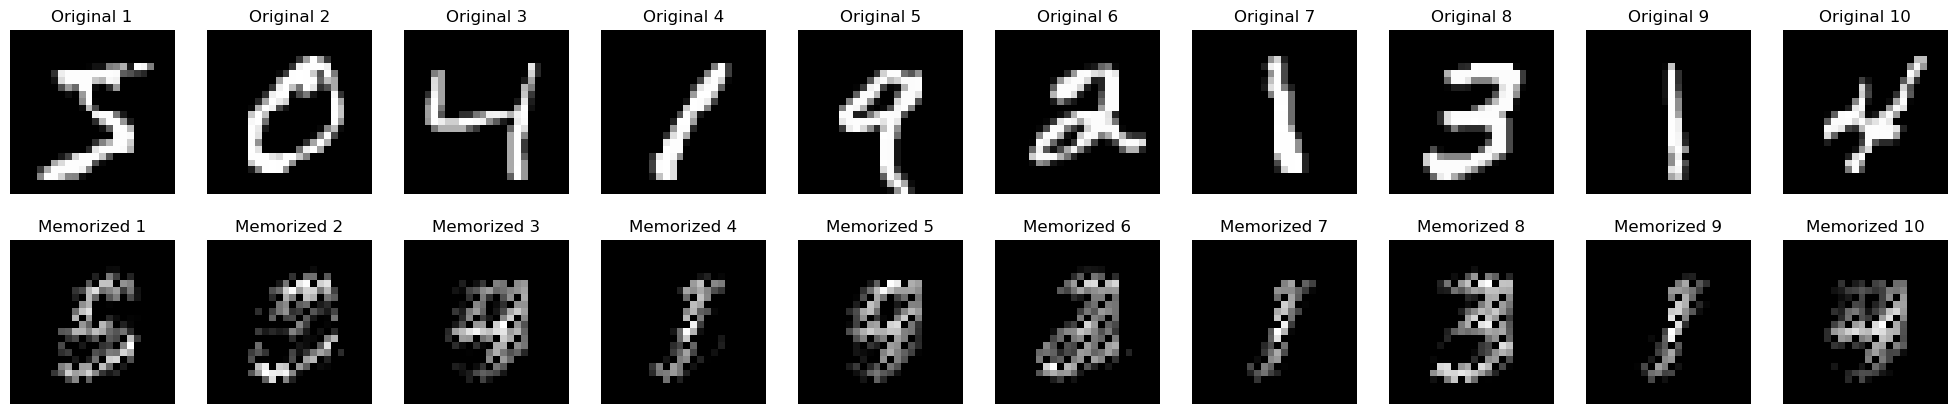

Epoch 38 | Train loss 0.009375 | Memorization loss 0.173695
Saved model and optimizer with memorization loss: 0.1737
Visualizing results at Epoch 39


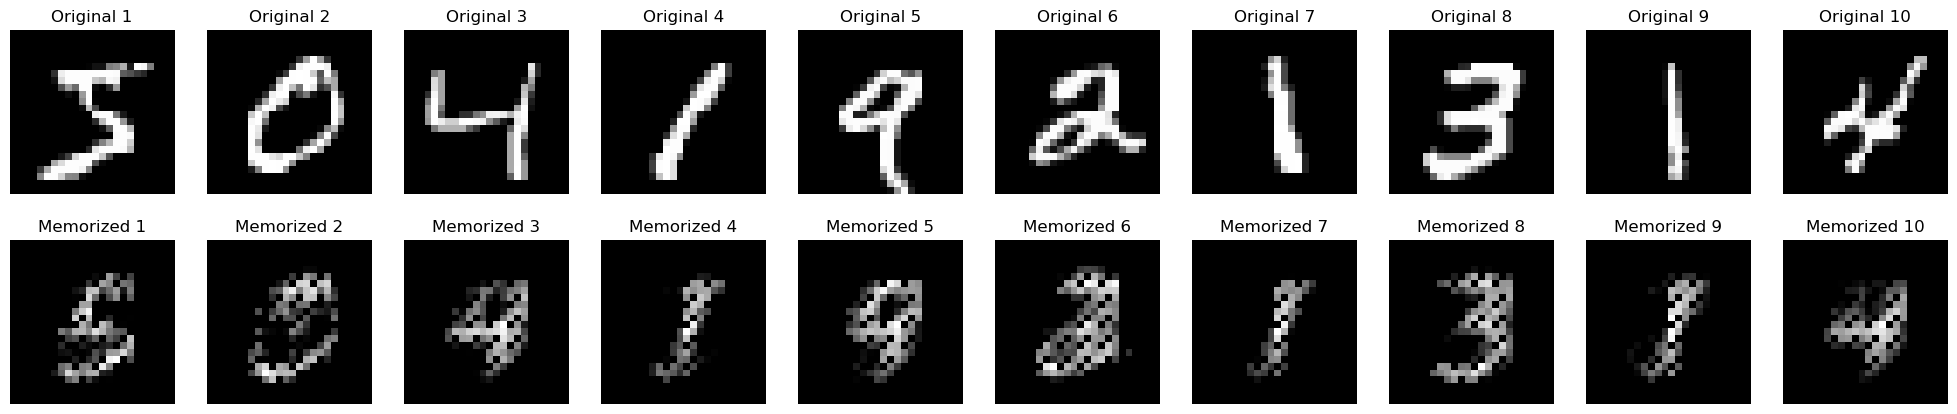

Epoch 39 | Train loss 0.009371 | Memorization loss 0.173224
Saved model and optimizer with memorization loss: 0.1732
Visualizing results at Epoch 40


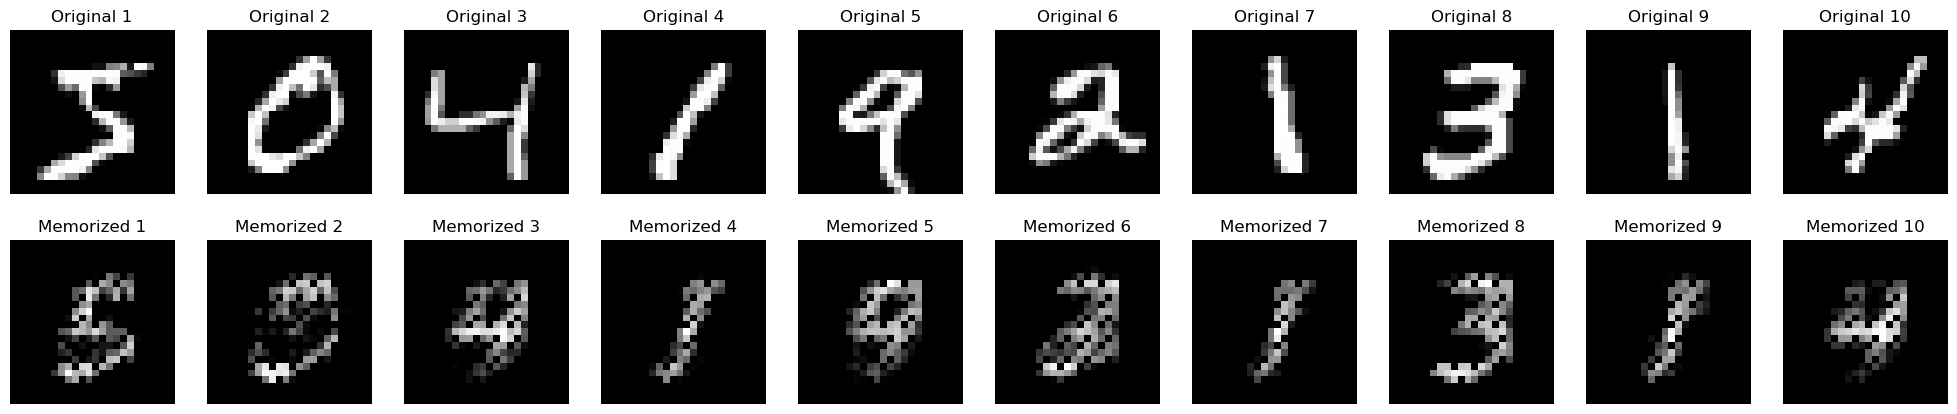

Epoch 40 | Train loss 0.009388 | Memorization loss 0.177873
Visualizing results at Epoch 41


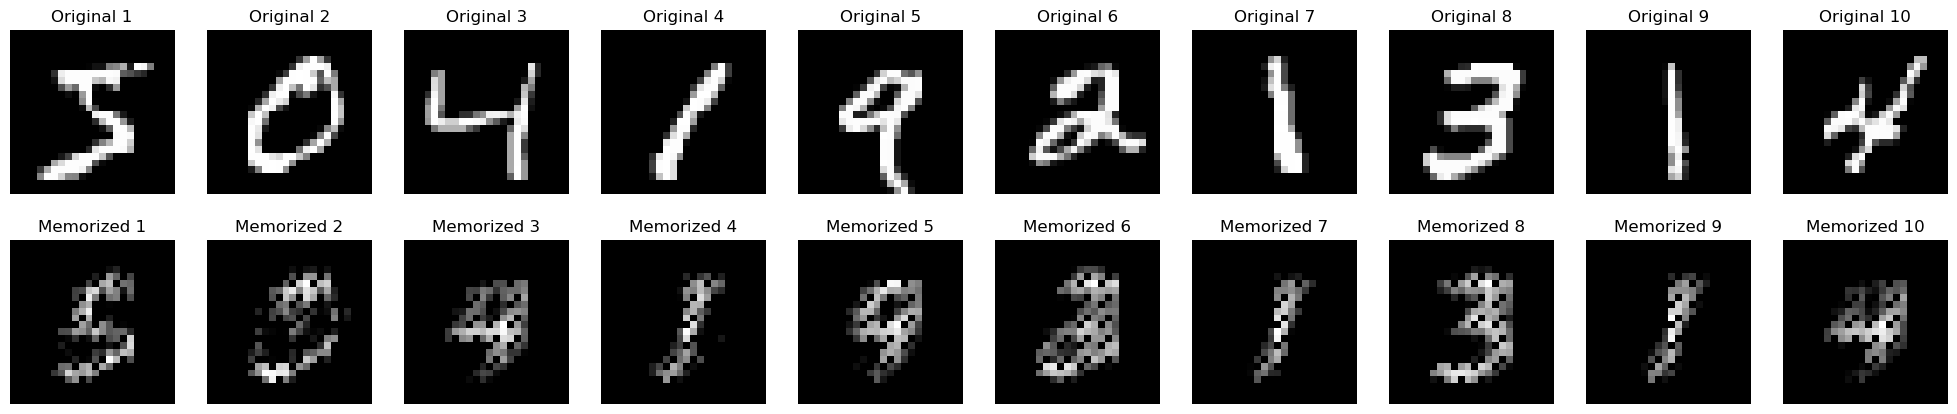

Epoch 41 | Train loss 0.009372 | Memorization loss 0.177340
Visualizing results at Epoch 42


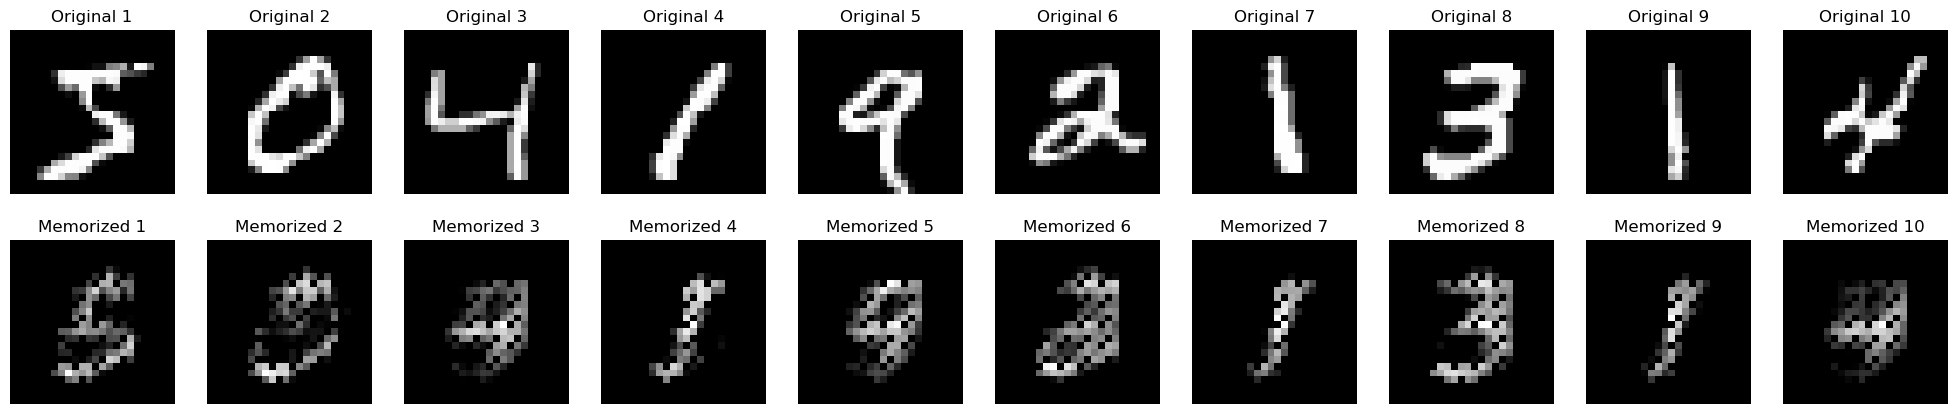

Epoch 42 | Train loss 0.009369 | Memorization loss 0.176683
Visualizing results at Epoch 43


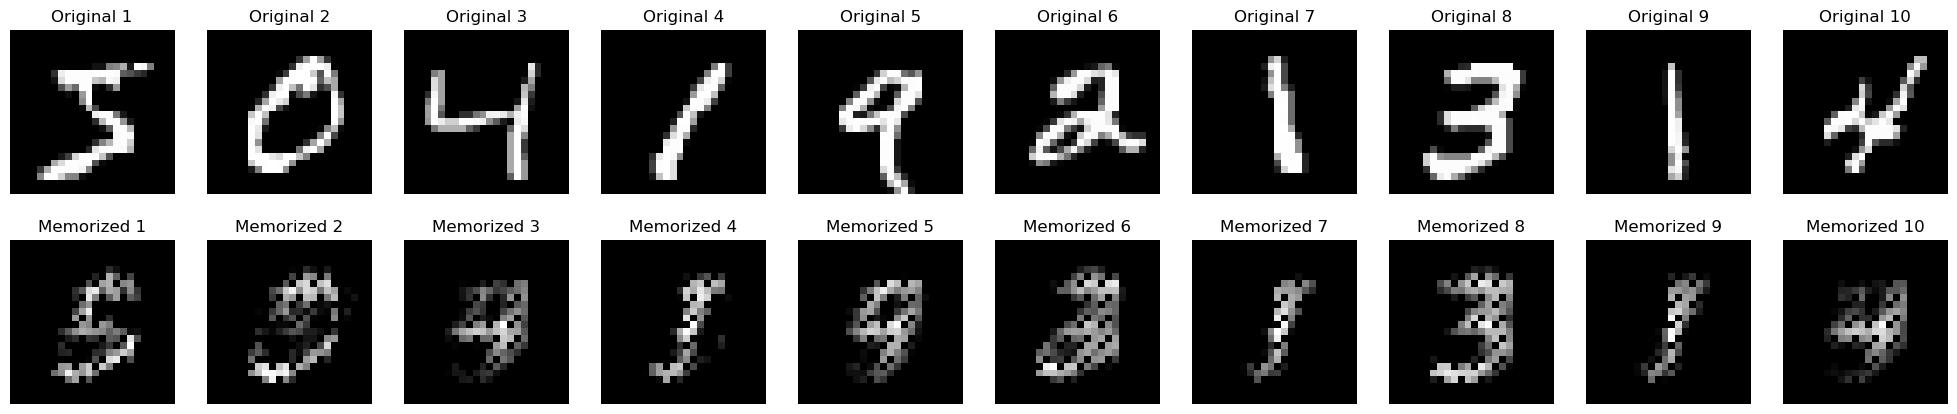

Epoch 43 | Train loss 0.009368 | Memorization loss 0.175619
Visualizing results at Epoch 44


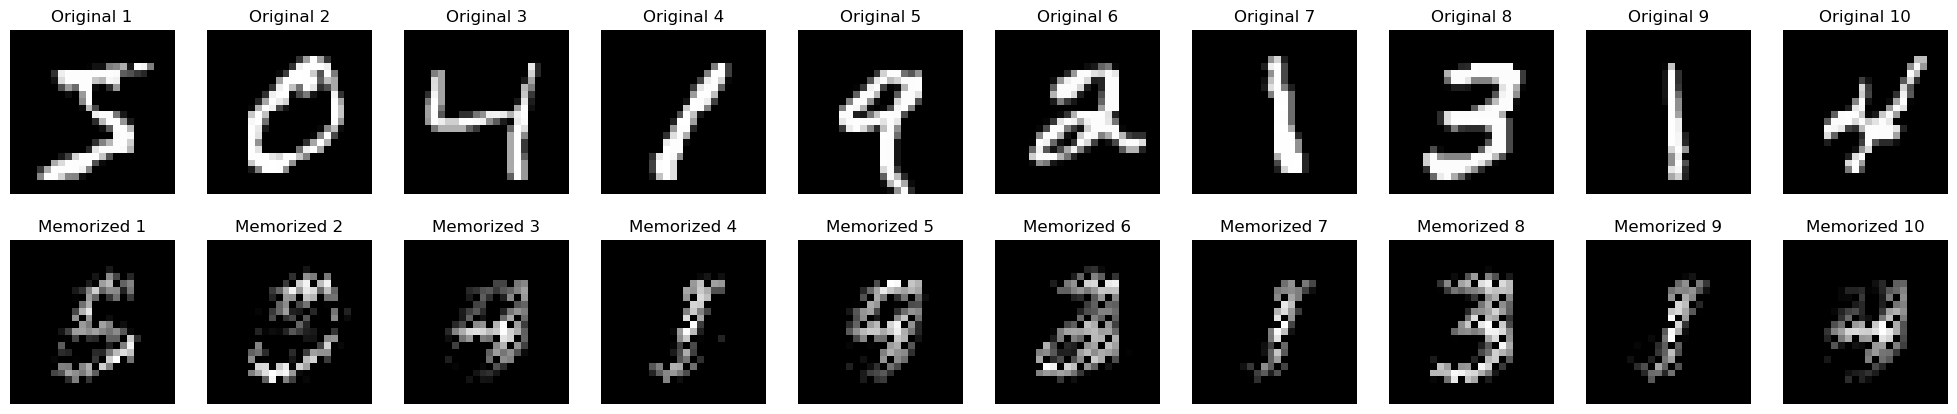

Epoch 44 | Train loss 0.009368 | Memorization loss 0.174927
Visualizing results at Epoch 45


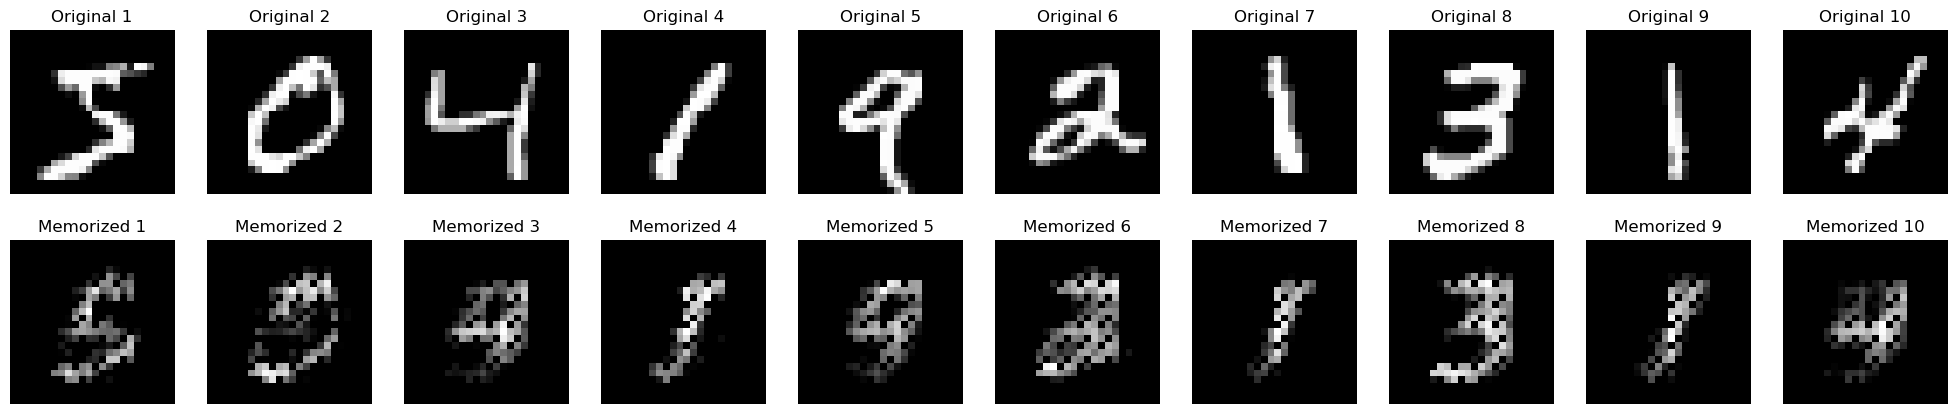

Epoch 45 | Train loss 0.009368 | Memorization loss 0.176699
Visualizing results at Epoch 46


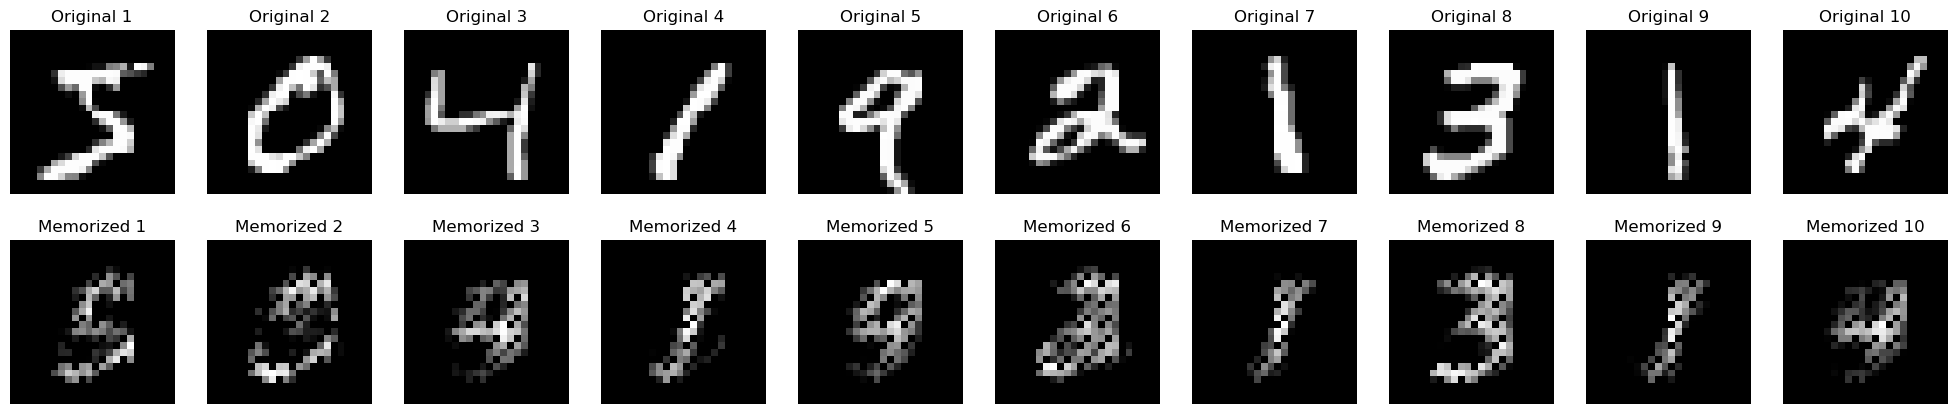

Epoch 46 | Train loss 0.009367 | Memorization loss 0.174775
Visualizing results at Epoch 47


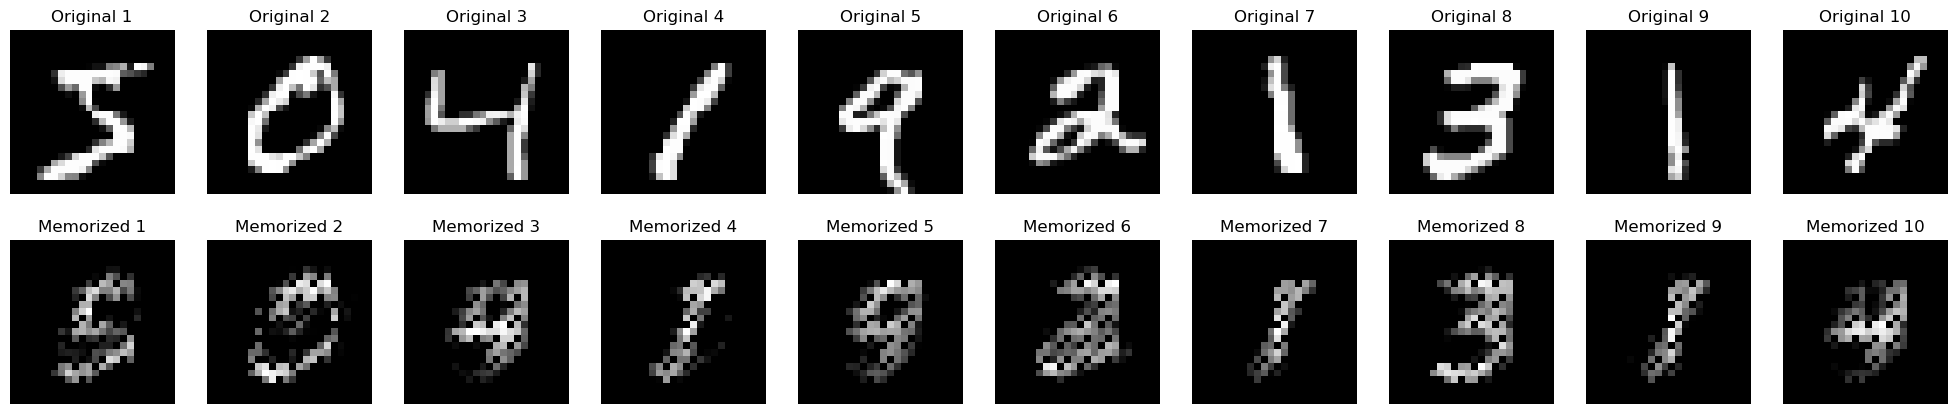

Epoch 47 | Train loss 0.009399 | Memorization loss 0.172546
Saved model and optimizer with memorization loss: 0.1725
Visualizing results at Epoch 48


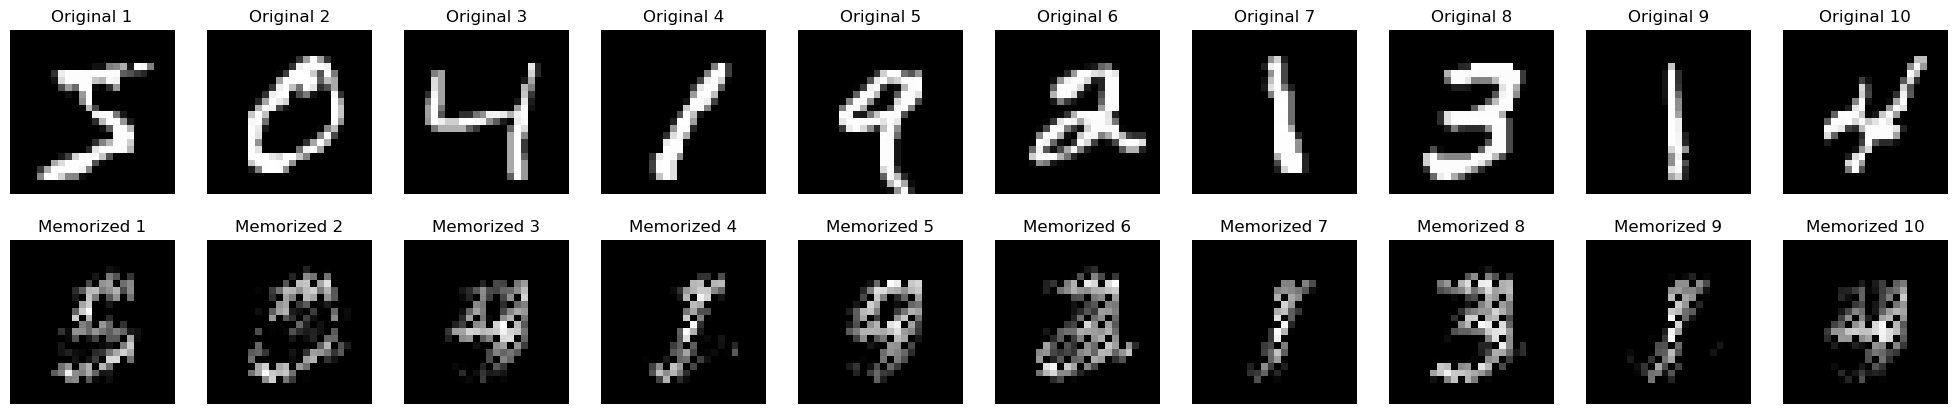

Epoch 48 | Train loss 0.009383 | Memorization loss 0.174500
Visualizing results at Epoch 49


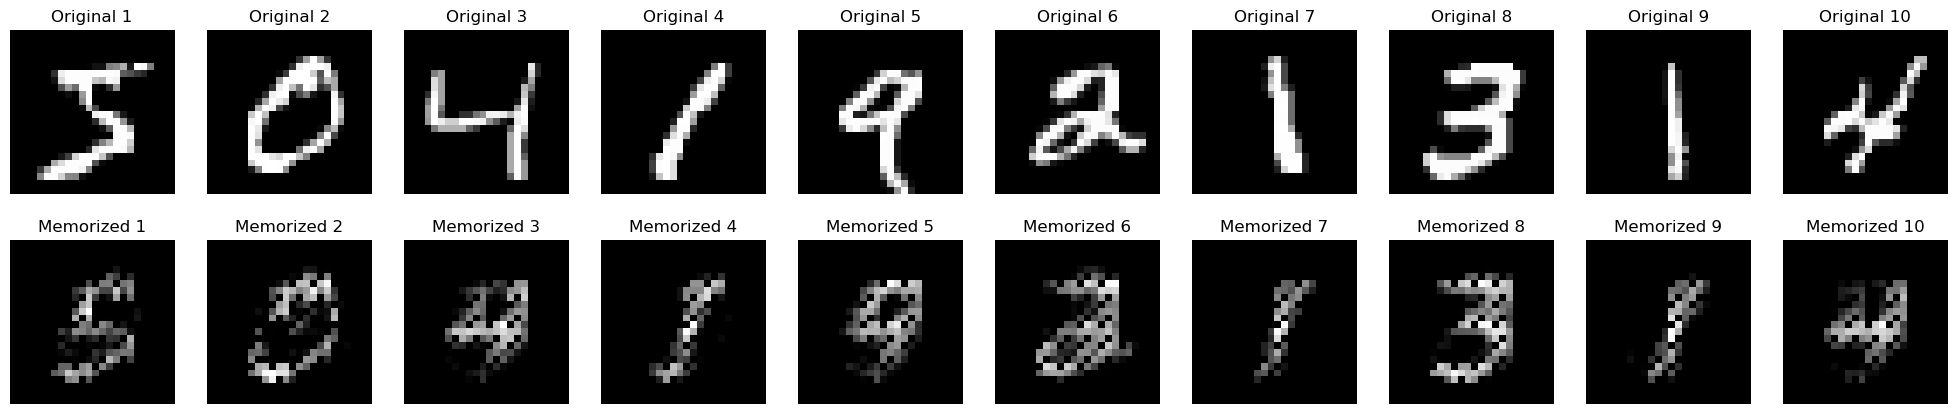

Epoch 49 | Train loss 0.009370 | Memorization loss 0.175898
Visualizing results at Epoch 50


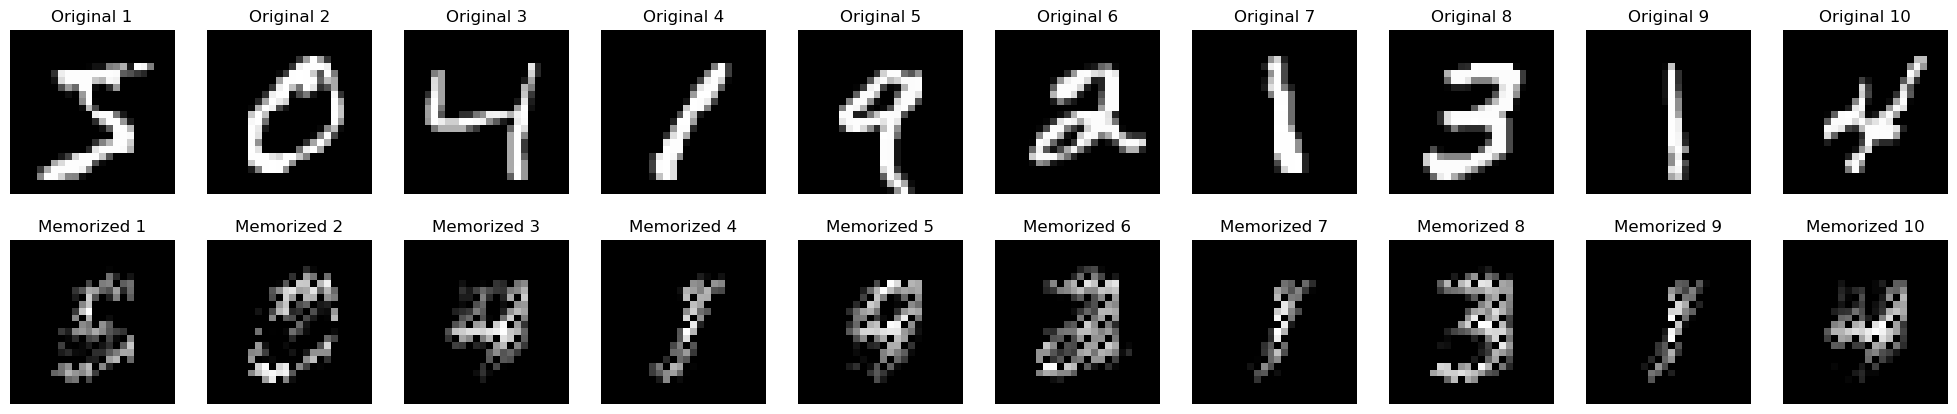

Epoch 50 | Train loss 0.009367 | Memorization loss 0.176079
Visualizing results at Epoch 51


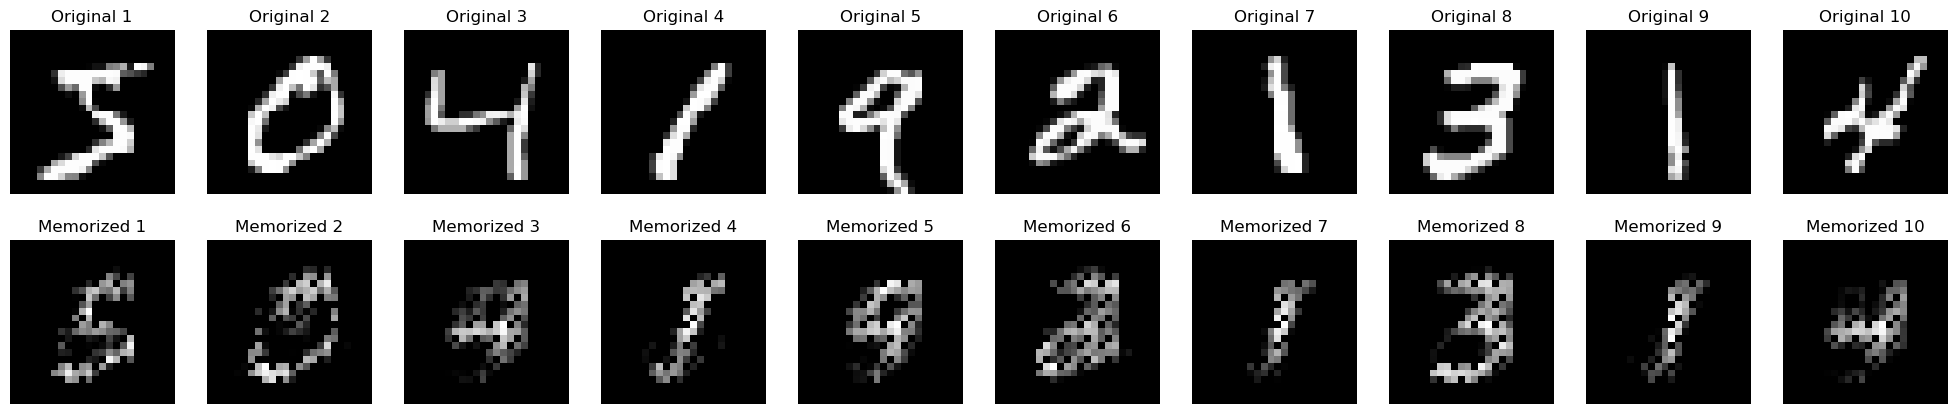

Epoch 51 | Train loss 0.009368 | Memorization loss 0.174992
Visualizing results at Epoch 52


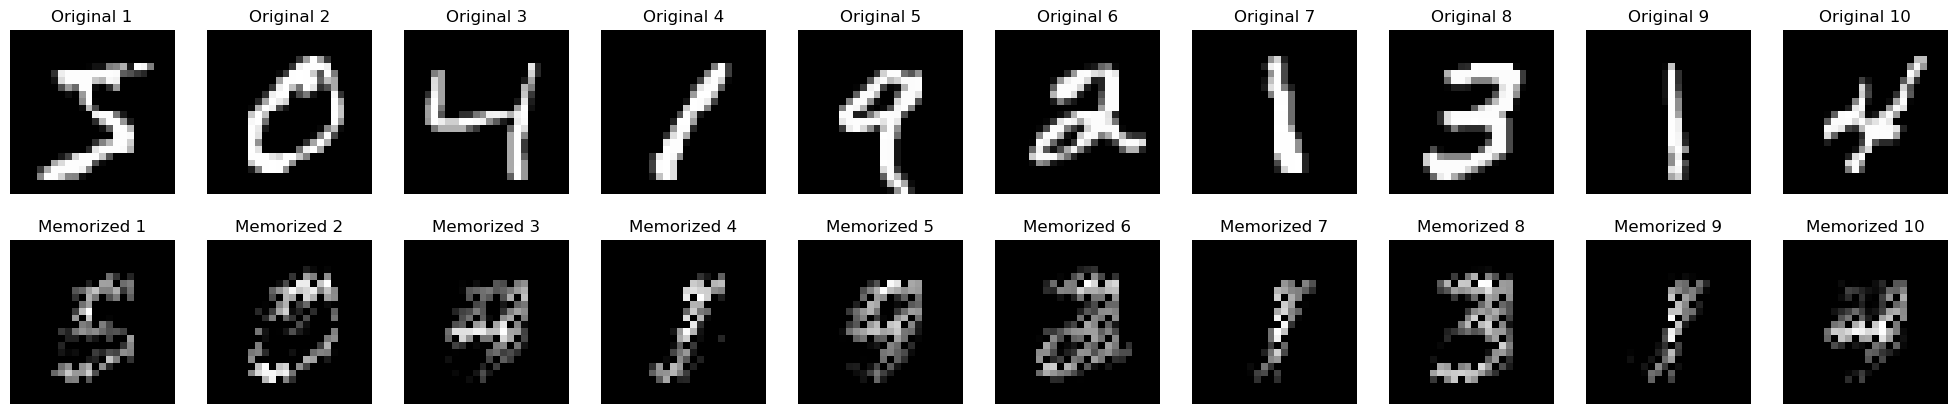

Epoch 52 | Train loss 0.009368 | Memorization loss 0.172975
Visualizing results at Epoch 53


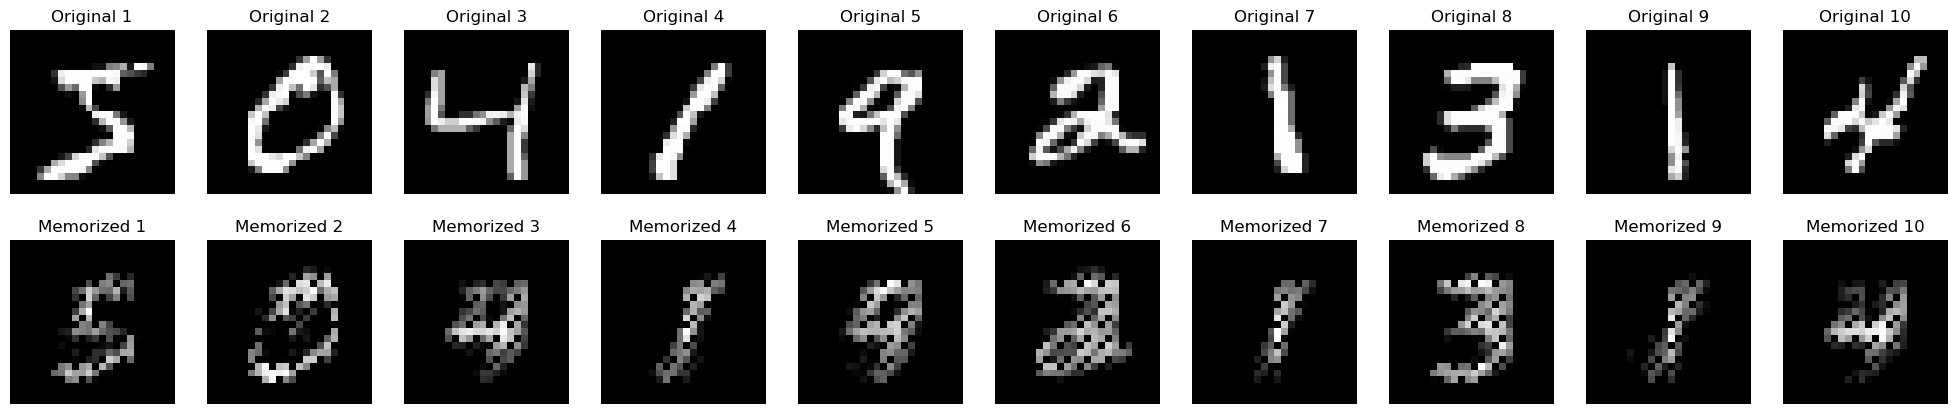

Epoch 53 | Train loss 0.009380 | Memorization loss 0.175273
Visualizing results at Epoch 54


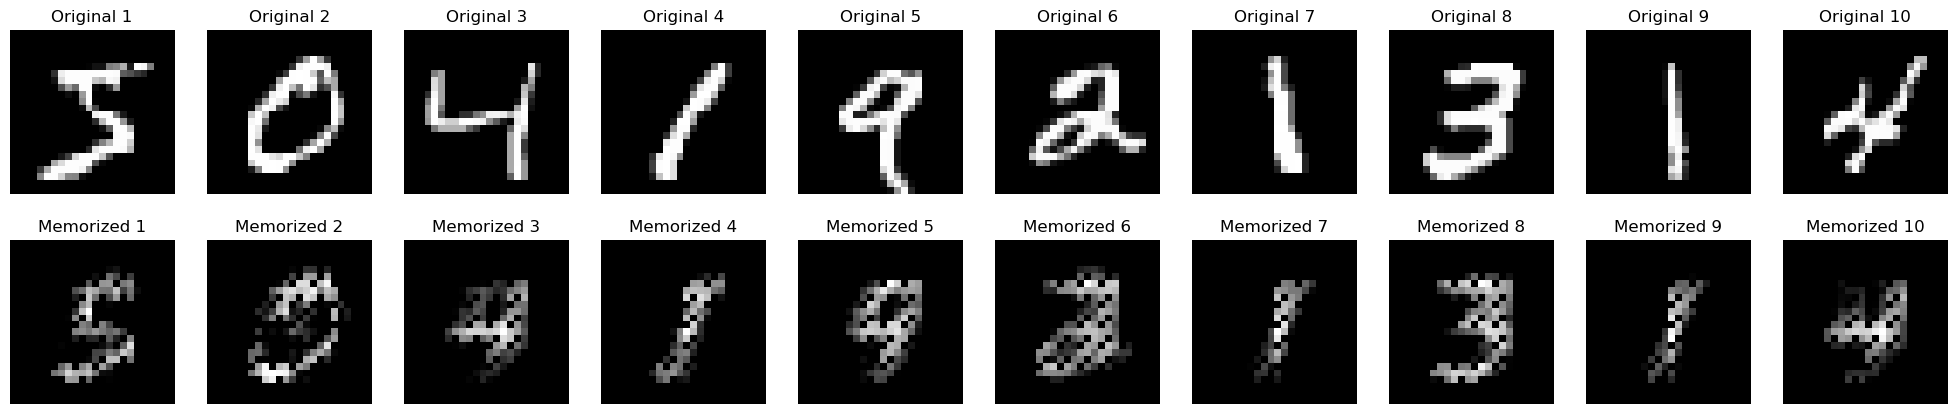

Epoch 54 | Train loss 0.009368 | Memorization loss 0.174741
Visualizing results at Epoch 55


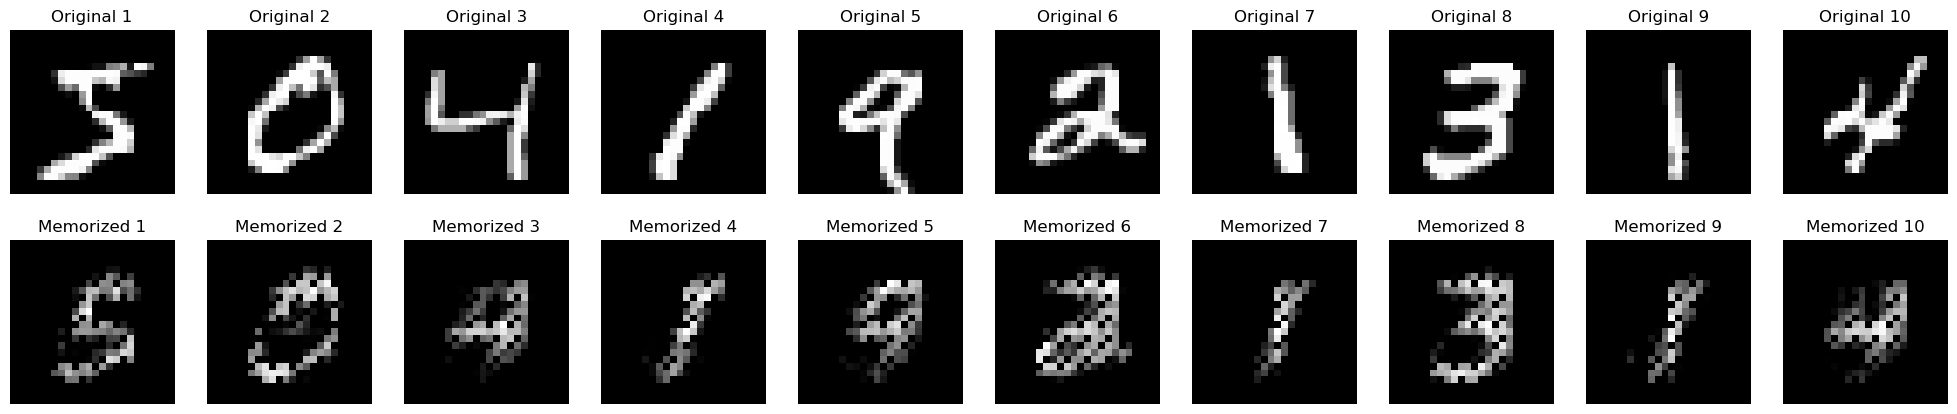

Epoch 55 | Train loss 0.009367 | Memorization loss 0.174506
Visualizing results at Epoch 56


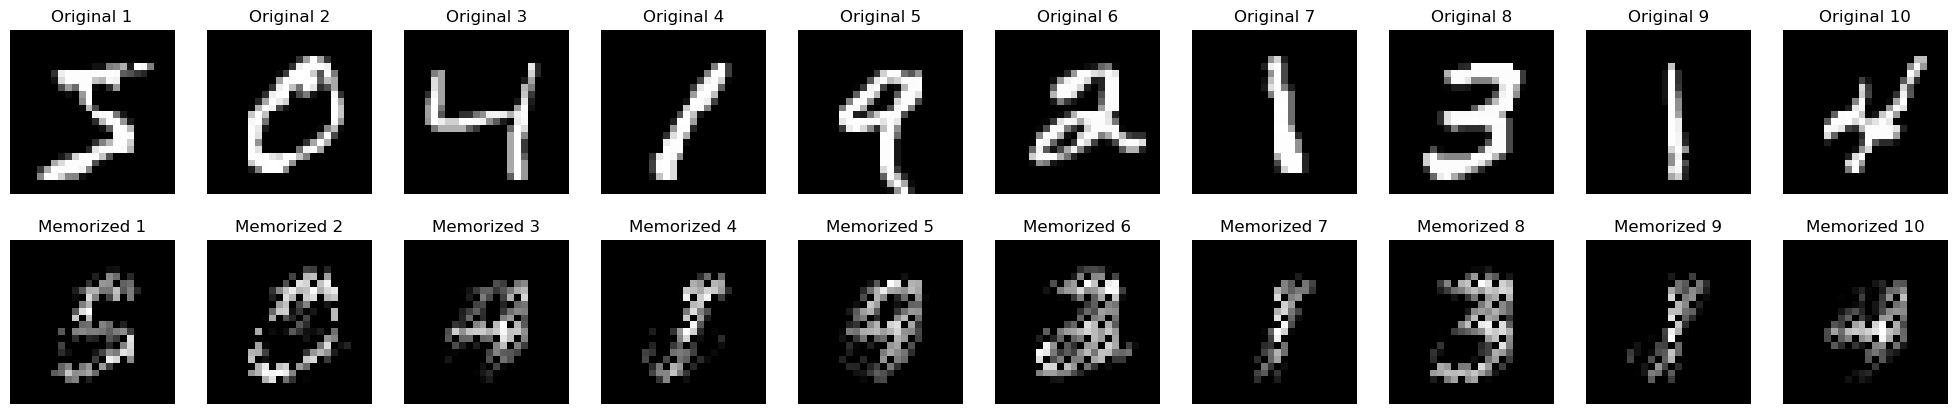

Epoch 56 | Train loss 0.009365 | Memorization loss 0.174178
Visualizing results at Epoch 57


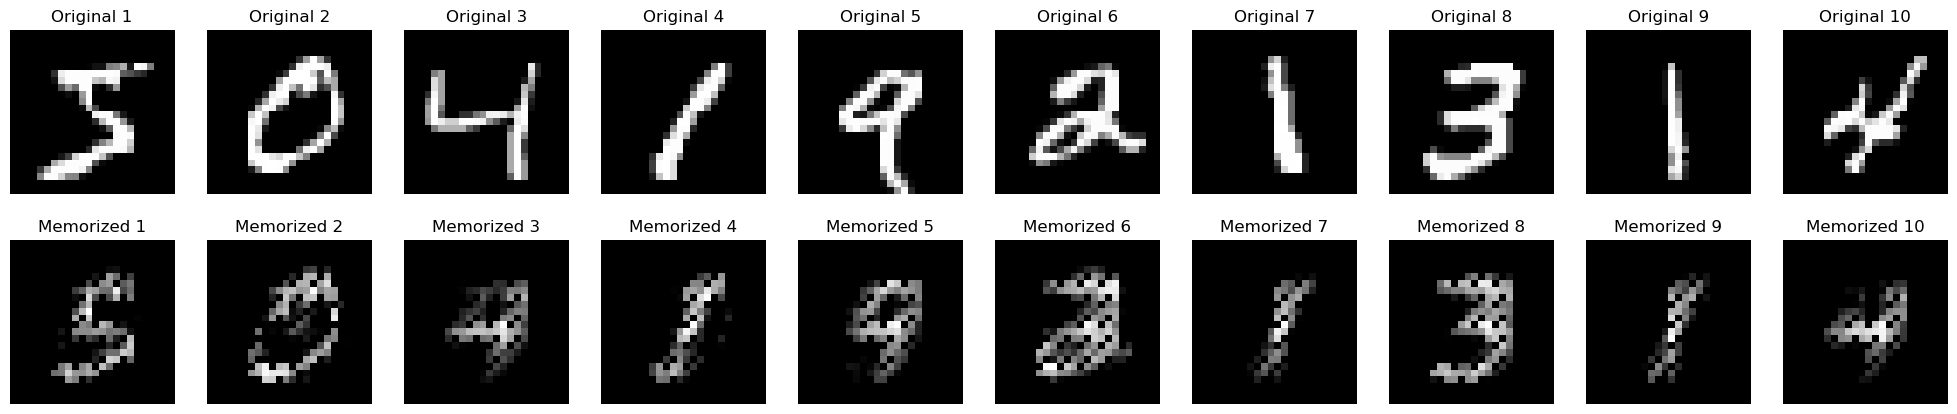

Epoch 57 | Train loss 0.009366 | Memorization loss 0.174025
Visualizing results at Epoch 58


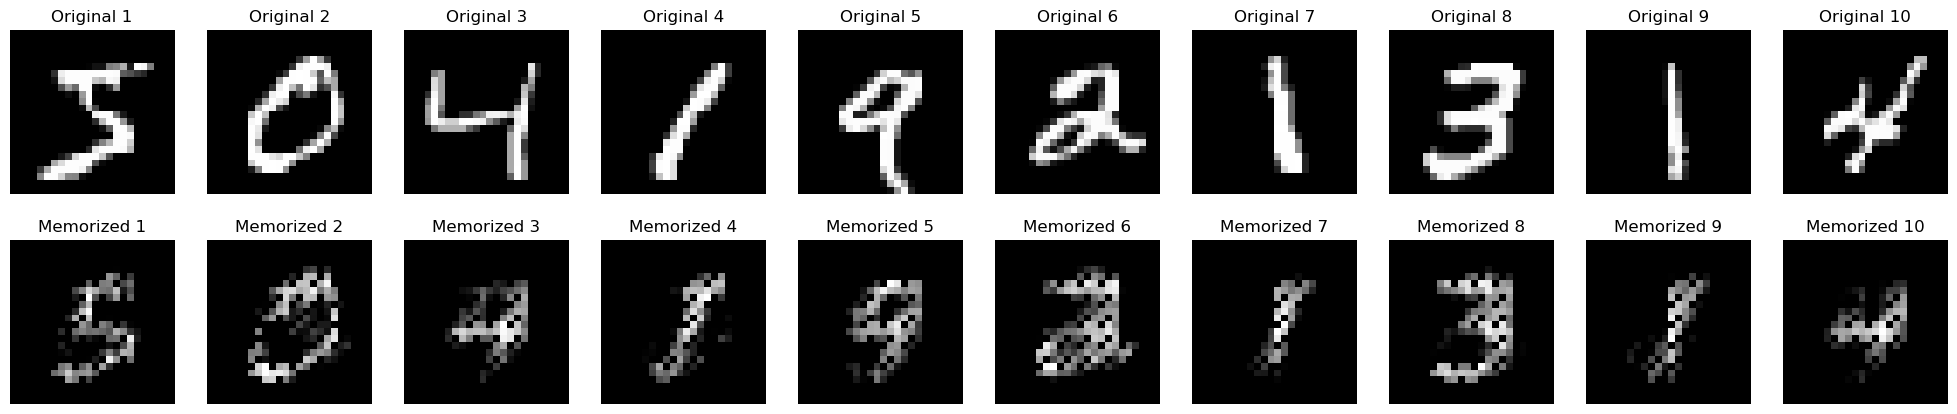

Epoch 58 | Train loss 0.009366 | Memorization loss 0.173259
Visualizing results at Epoch 59


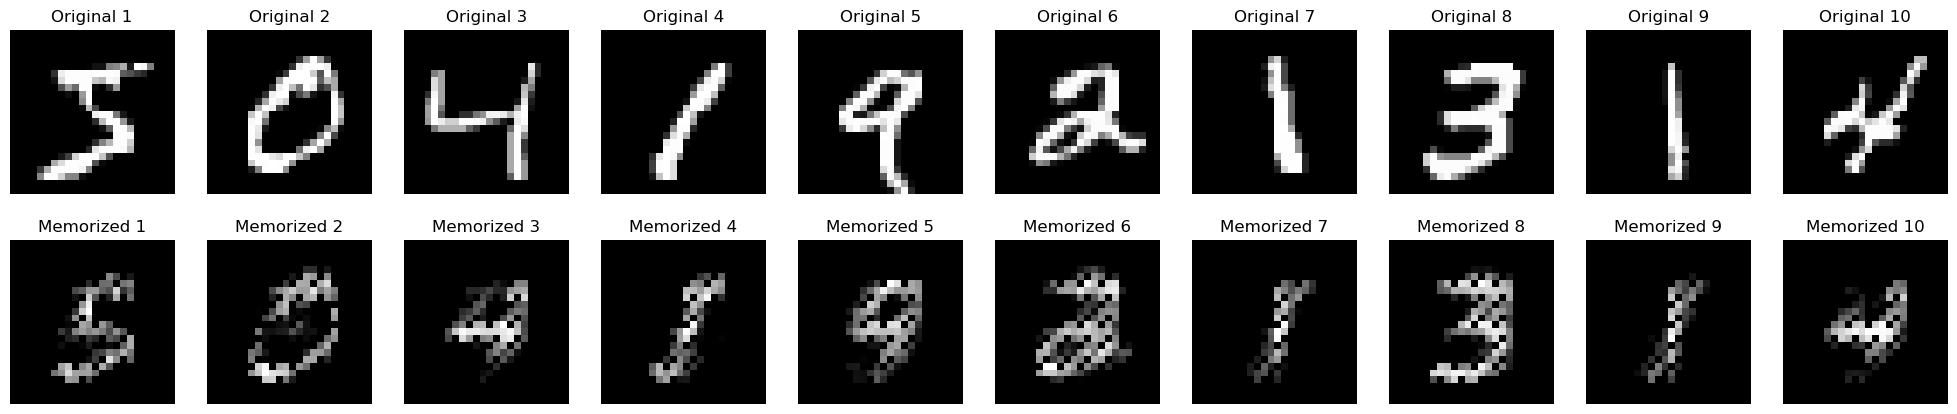

Epoch 59 | Train loss 0.009365 | Memorization loss 0.170421
Saved model and optimizer with memorization loss: 0.1704
Visualizing results at Epoch 60


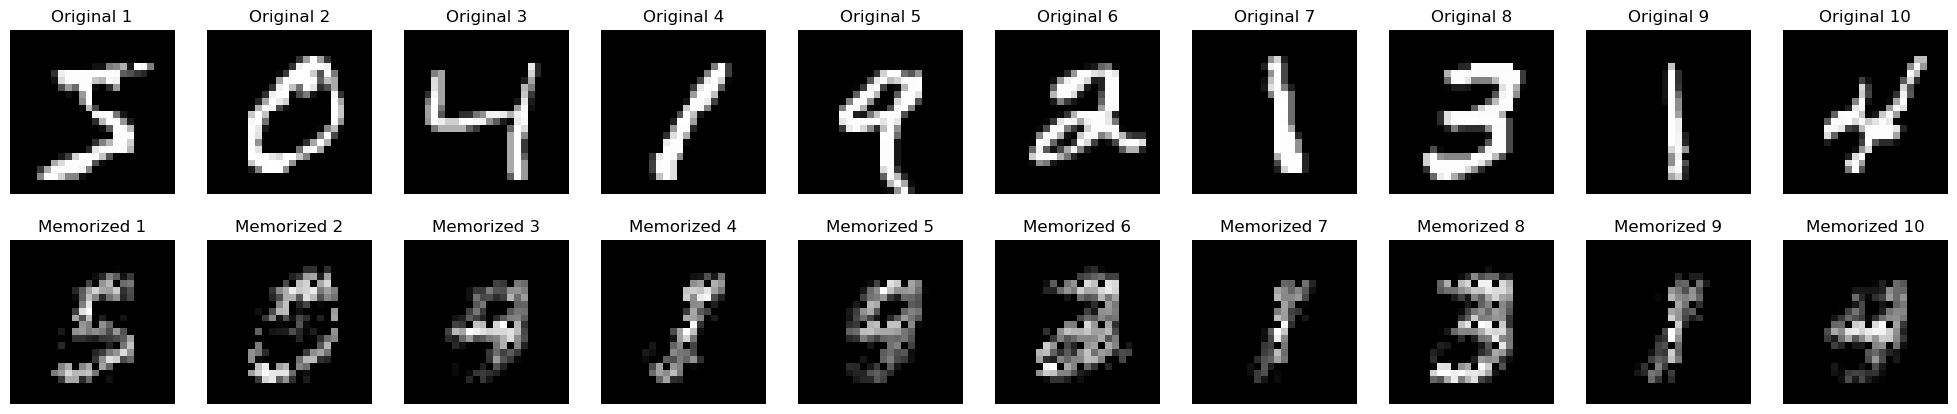

Epoch 60 | Train loss 0.009391 | Memorization loss 0.163542
Saved model and optimizer with memorization loss: 0.1635
Visualizing results at Epoch 61


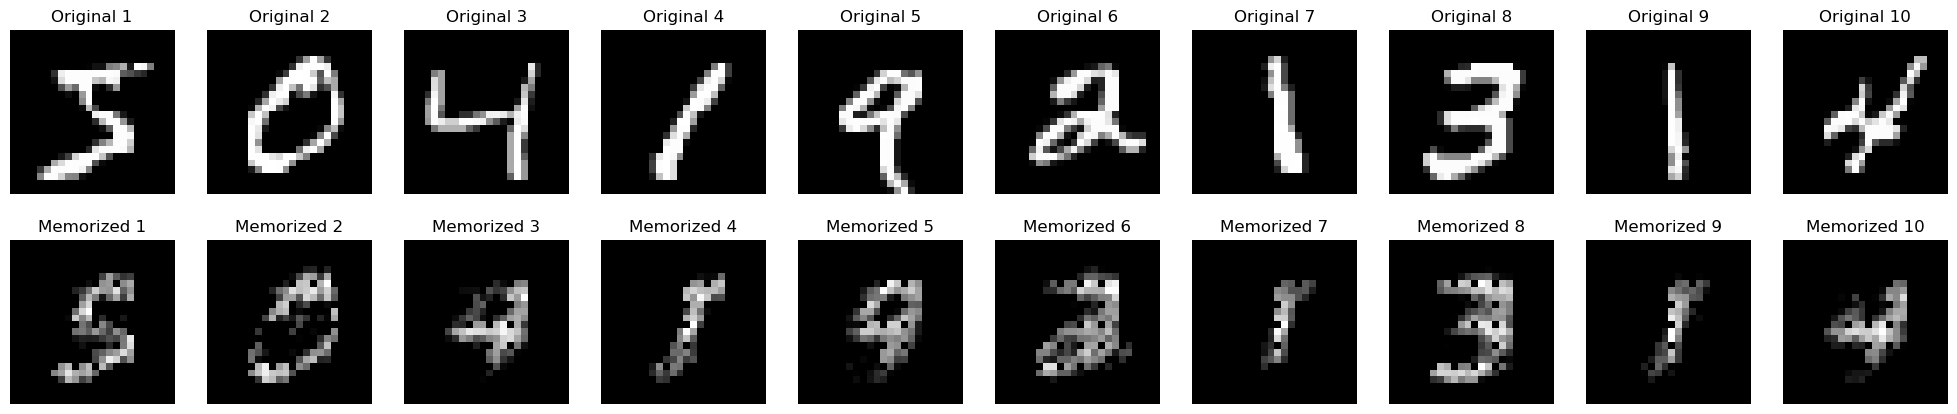

Epoch 61 | Train loss 0.009375 | Memorization loss 0.164408
Visualizing results at Epoch 62


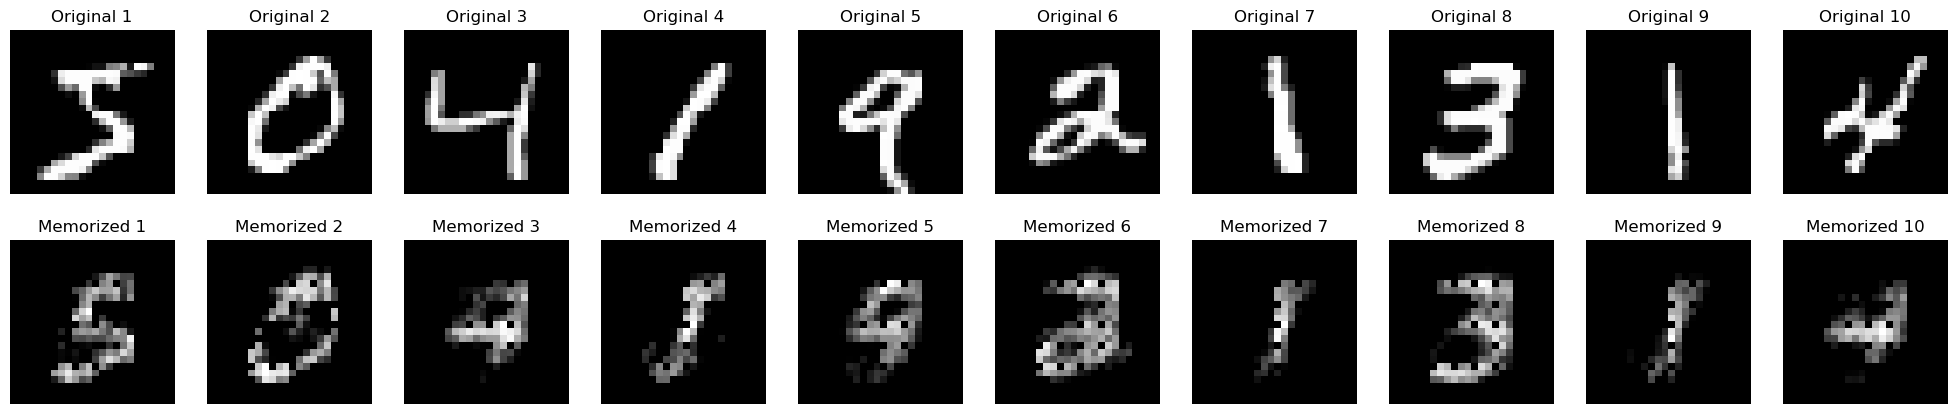

Epoch 62 | Train loss 0.009371 | Memorization loss 0.164019
Visualizing results at Epoch 63


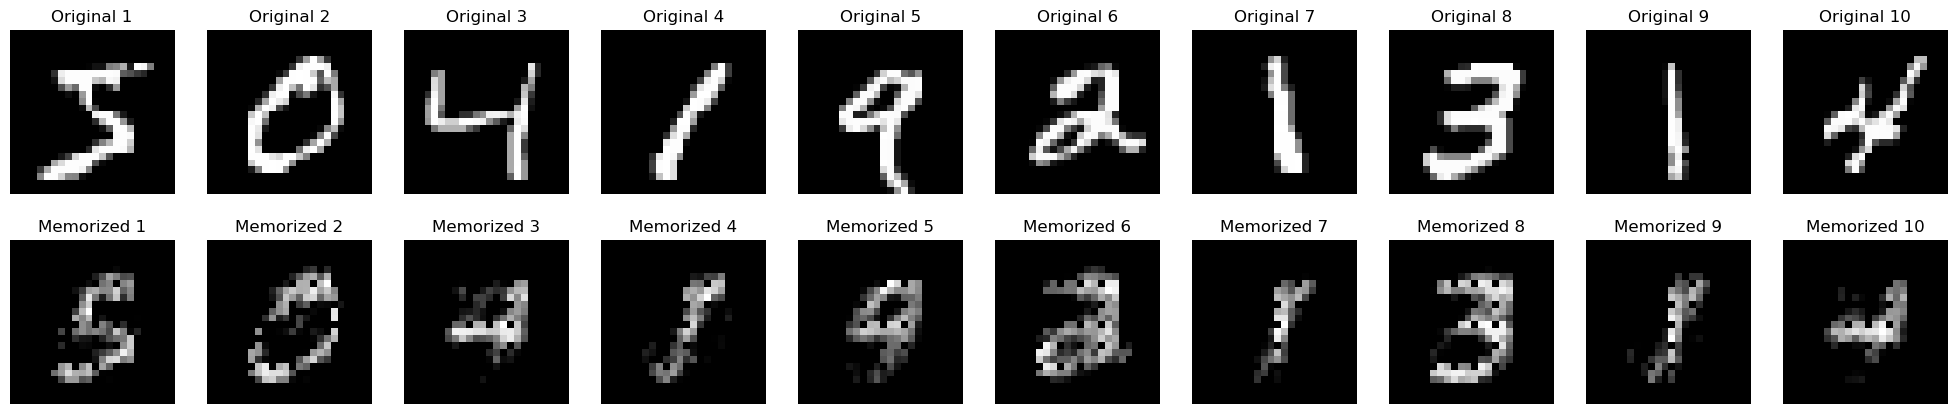

Epoch 63 | Train loss 0.009368 | Memorization loss 0.163813
Visualizing results at Epoch 64


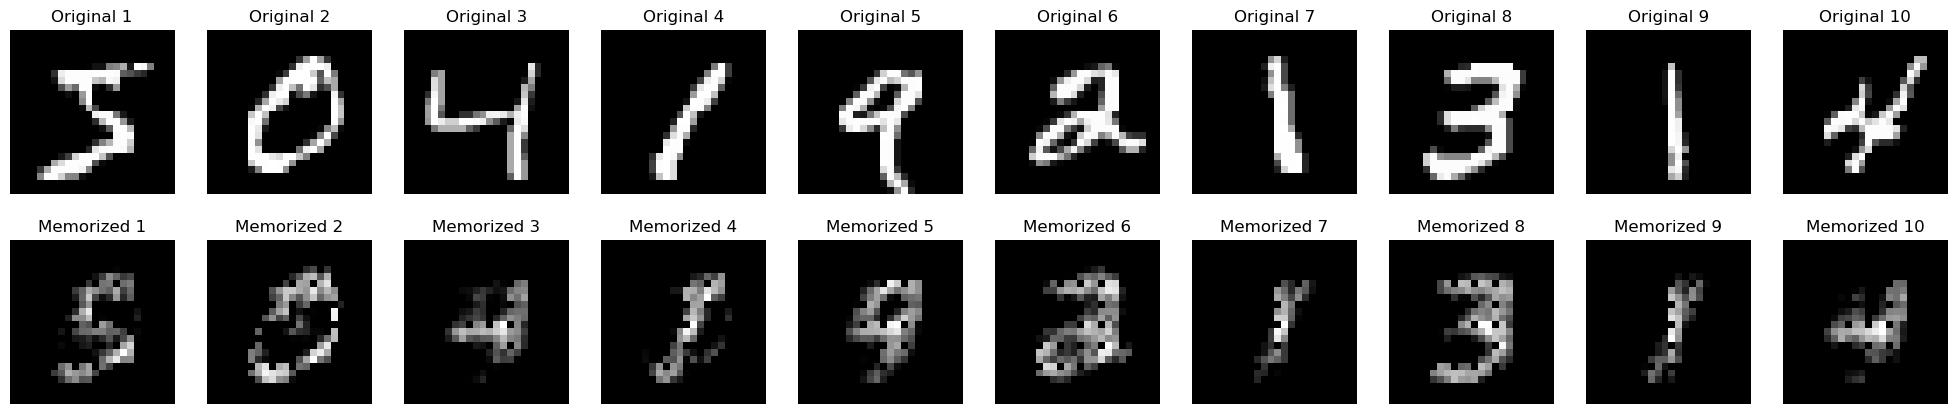

Epoch 64 | Train loss 0.009366 | Memorization loss 0.160855
Saved model and optimizer with memorization loss: 0.1609
Visualizing results at Epoch 65


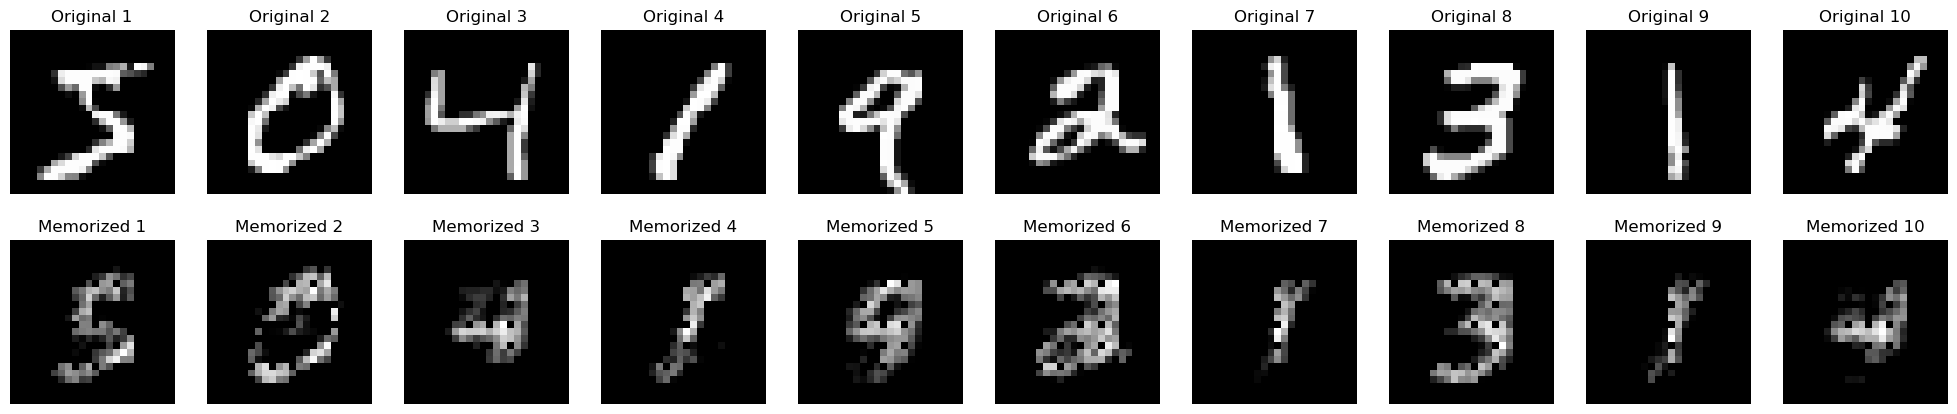

Epoch 65 | Train loss 0.006065 | Memorization loss 0.158918
Saved model and optimizer with memorization loss: 0.1589
Visualizing results at Epoch 66


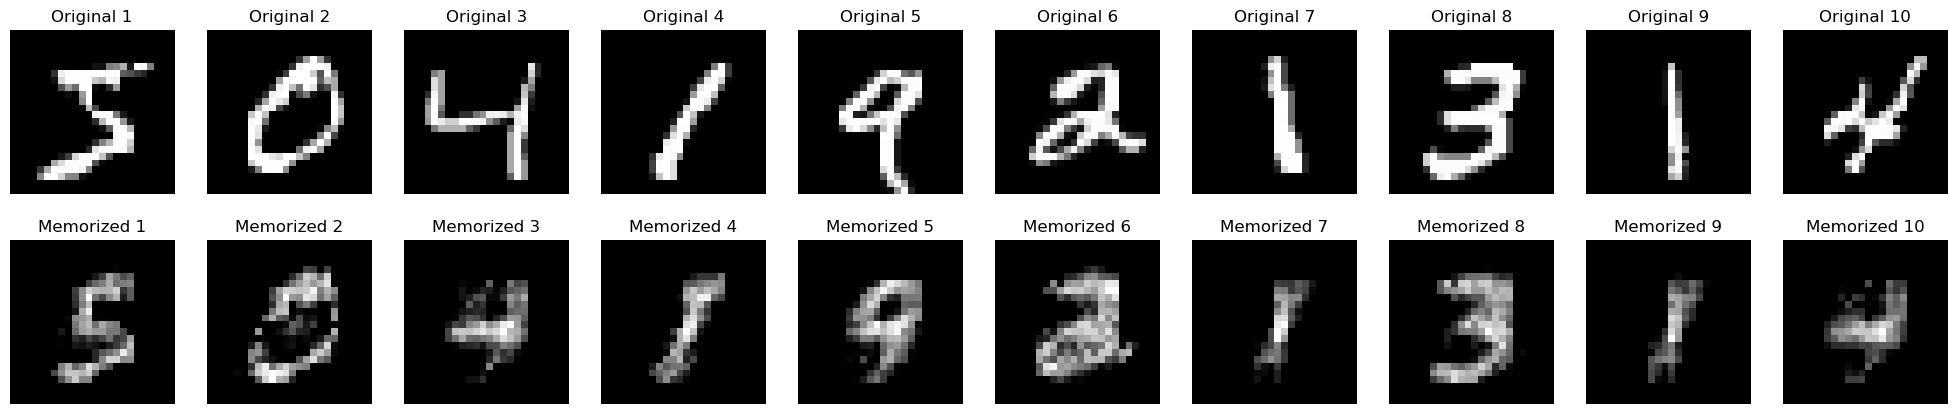

Epoch 66 | Train loss 0.004831 | Memorization loss 0.154487
Saved model and optimizer with memorization loss: 0.1545
Visualizing results at Epoch 67


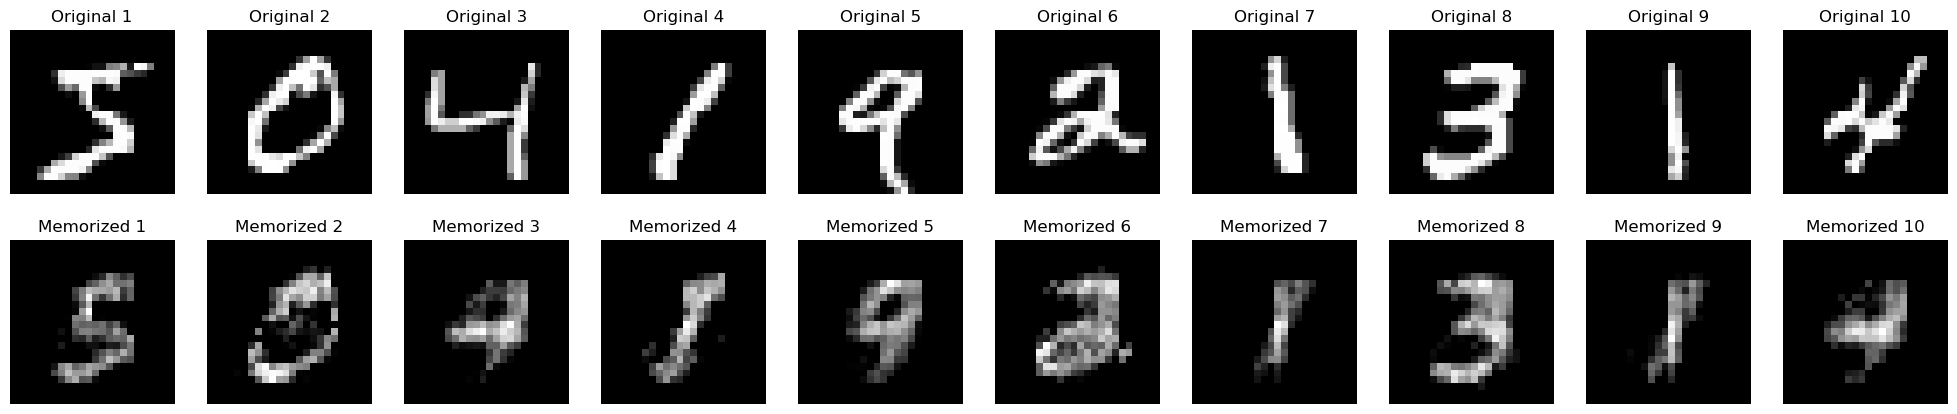

Epoch 67 | Train loss 0.004820 | Memorization loss 0.153900
Saved model and optimizer with memorization loss: 0.1539
Visualizing results at Epoch 68


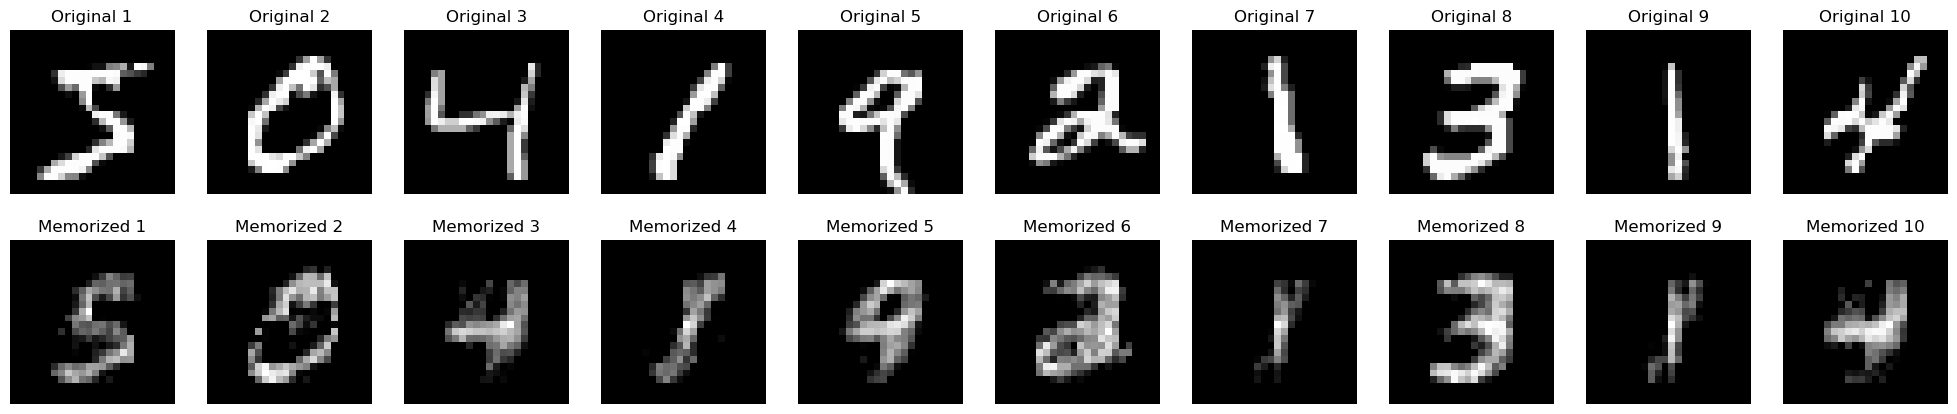

Epoch 68 | Train loss 0.004820 | Memorization loss 0.153934
Visualizing results at Epoch 69


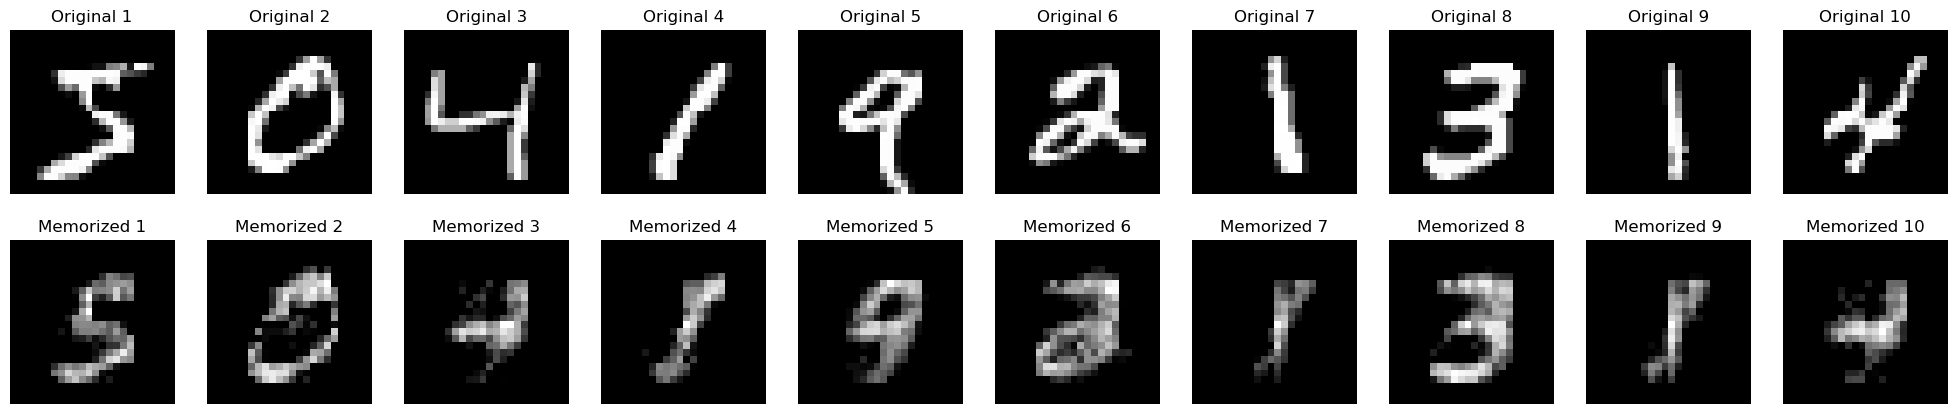

Epoch 69 | Train loss 0.004821 | Memorization loss 0.153357
Saved model and optimizer with memorization loss: 0.1534
Visualizing results at Epoch 70


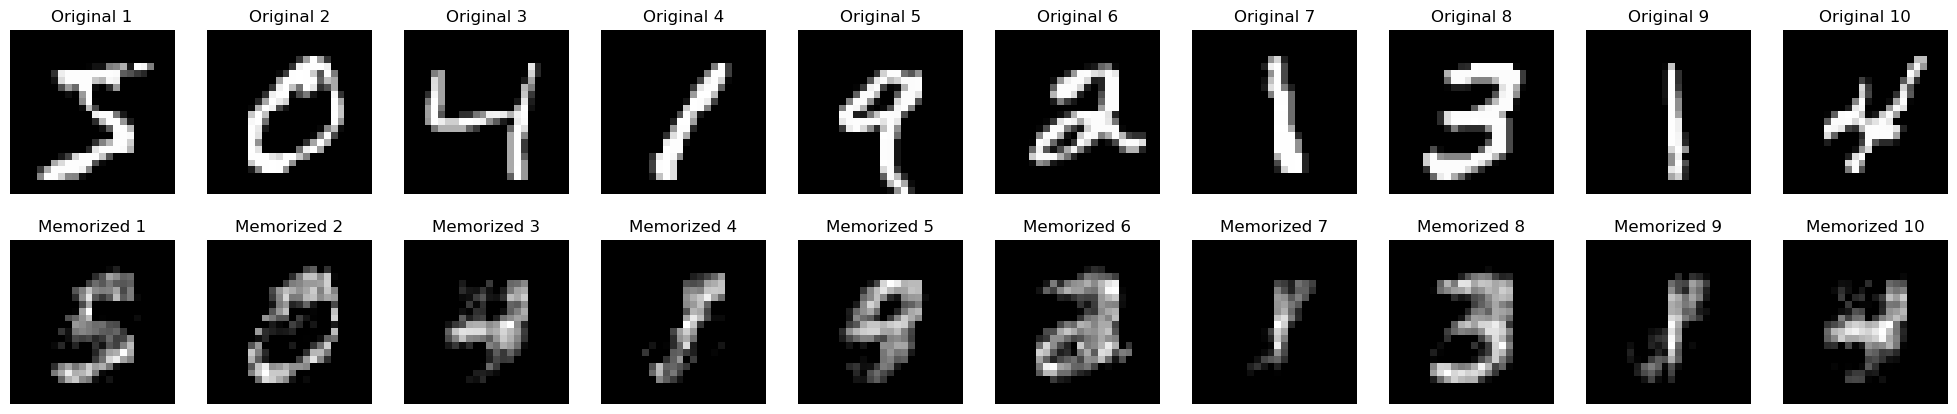

Epoch 70 | Train loss 0.004823 | Memorization loss 0.152269
Saved model and optimizer with memorization loss: 0.1523
Visualizing results at Epoch 71


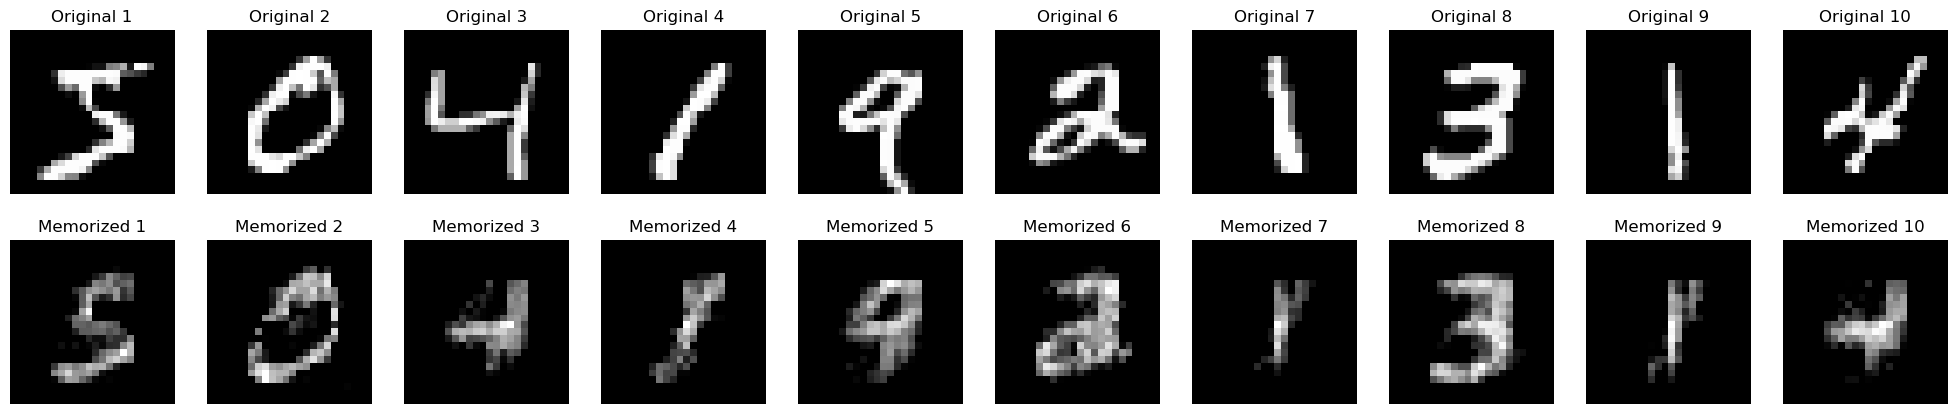

Epoch 71 | Train loss 0.004820 | Memorization loss 0.152706
Visualizing results at Epoch 72


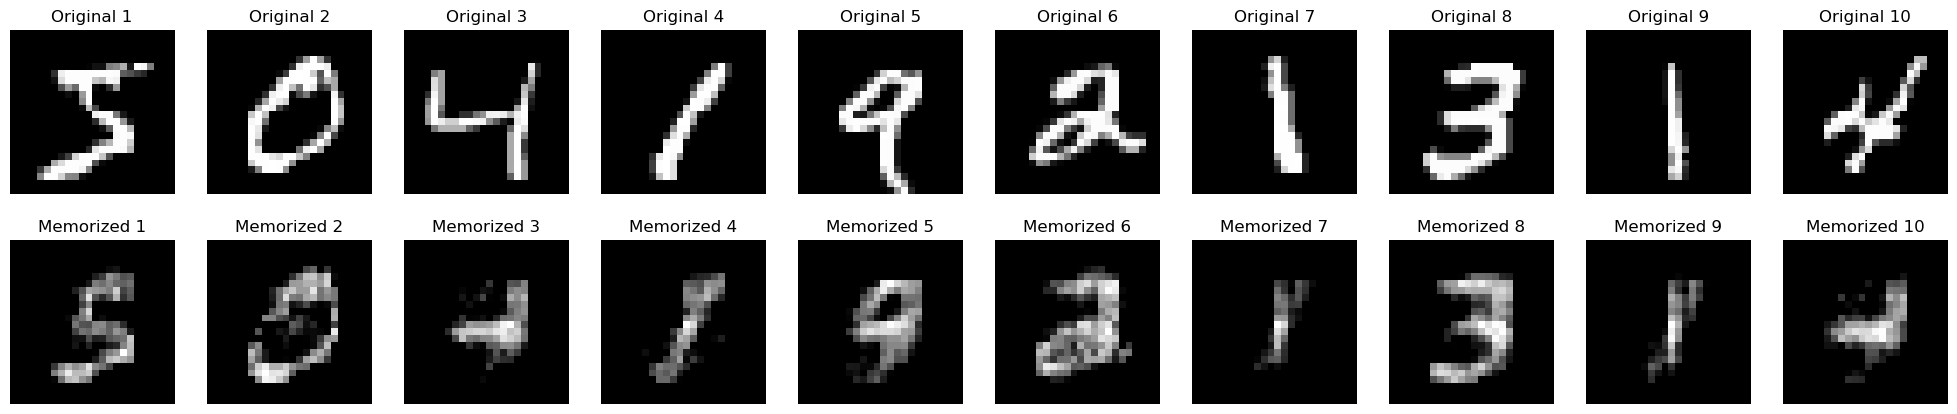

Epoch 72 | Train loss 0.004821 | Memorization loss 0.151557
Saved model and optimizer with memorization loss: 0.1516
Visualizing results at Epoch 73


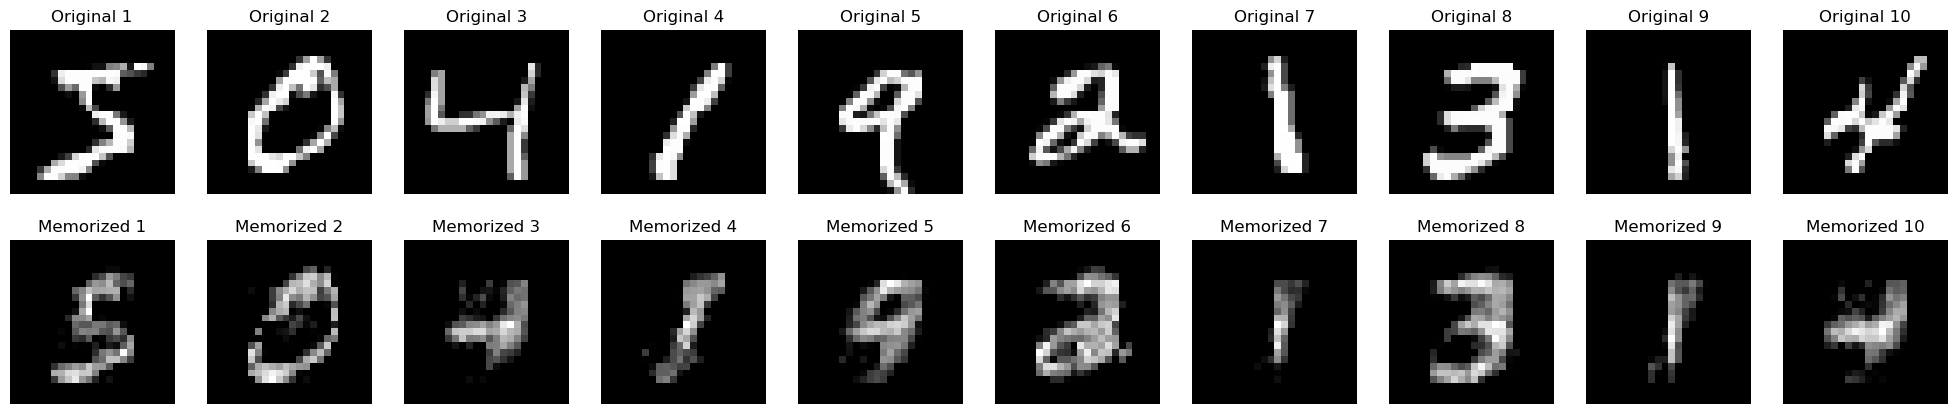

Epoch 73 | Train loss 0.004818 | Memorization loss 0.150823
Saved model and optimizer with memorization loss: 0.1508
Visualizing results at Epoch 74


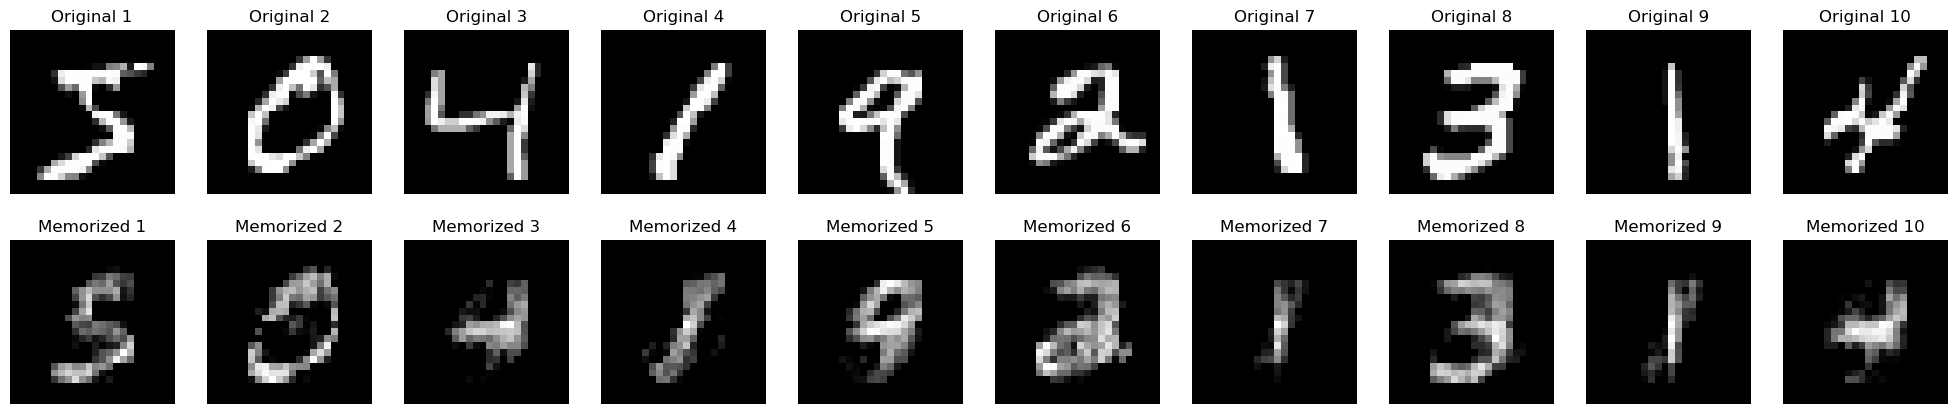

Epoch 74 | Train loss 0.004835 | Memorization loss 0.152272
Visualizing results at Epoch 75


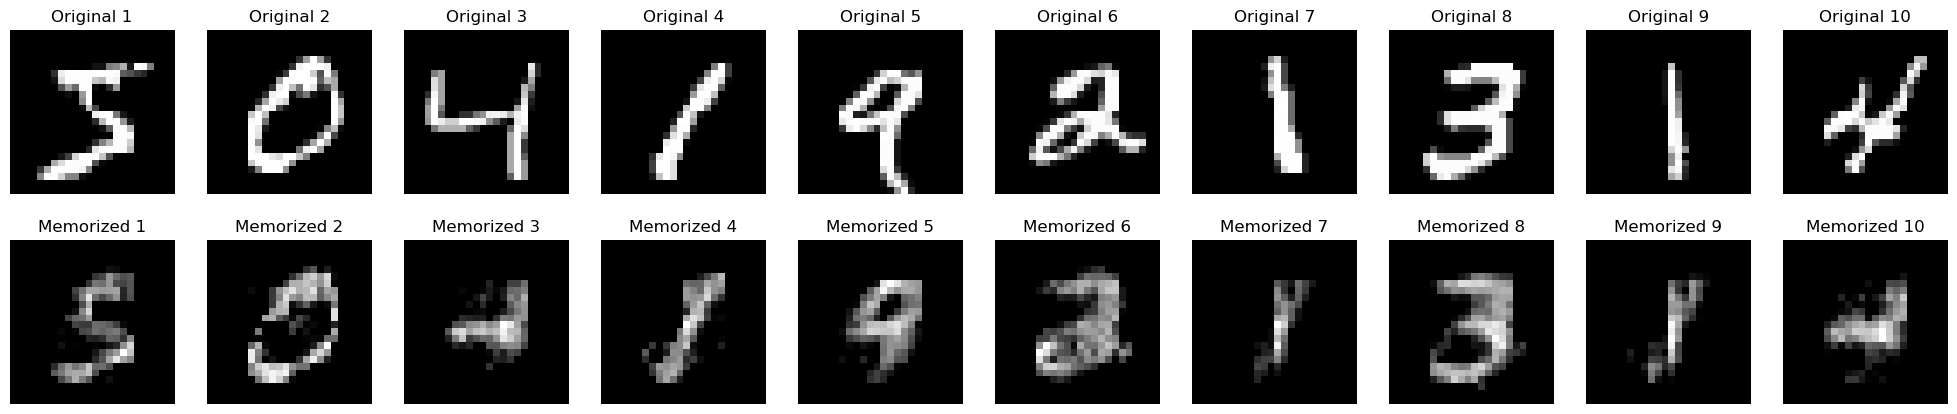

Epoch 75 | Train loss 0.004822 | Memorization loss 0.151442
Visualizing results at Epoch 76


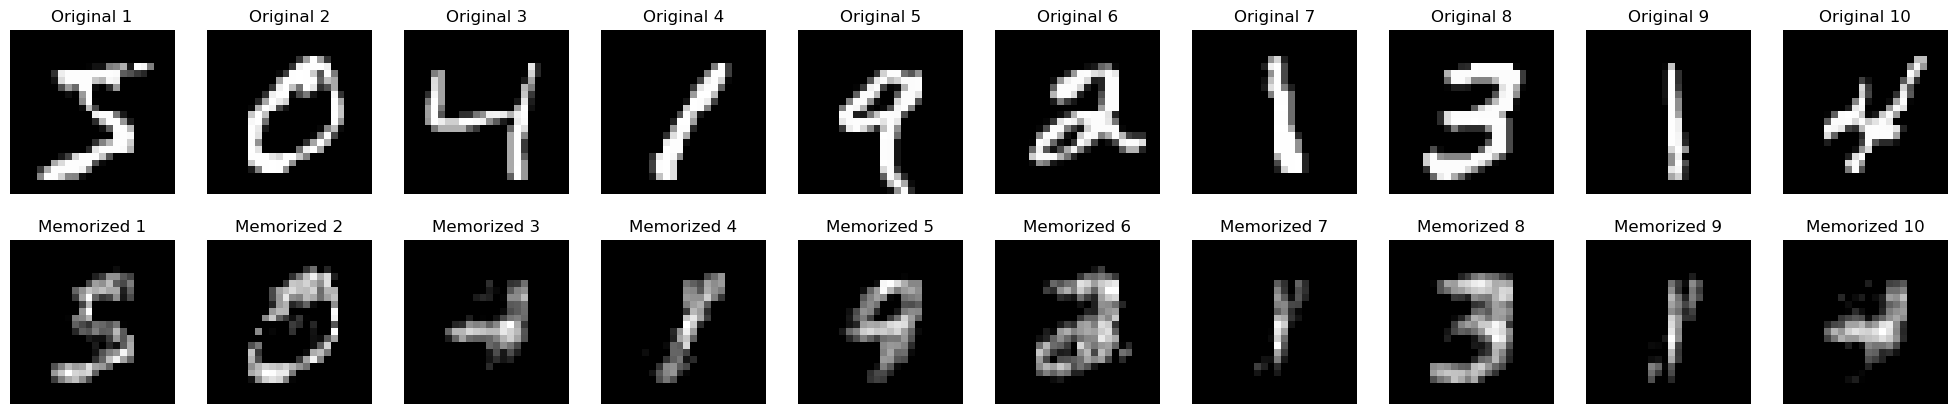

Epoch 76 | Train loss 0.004819 | Memorization loss 0.151576
Visualizing results at Epoch 77


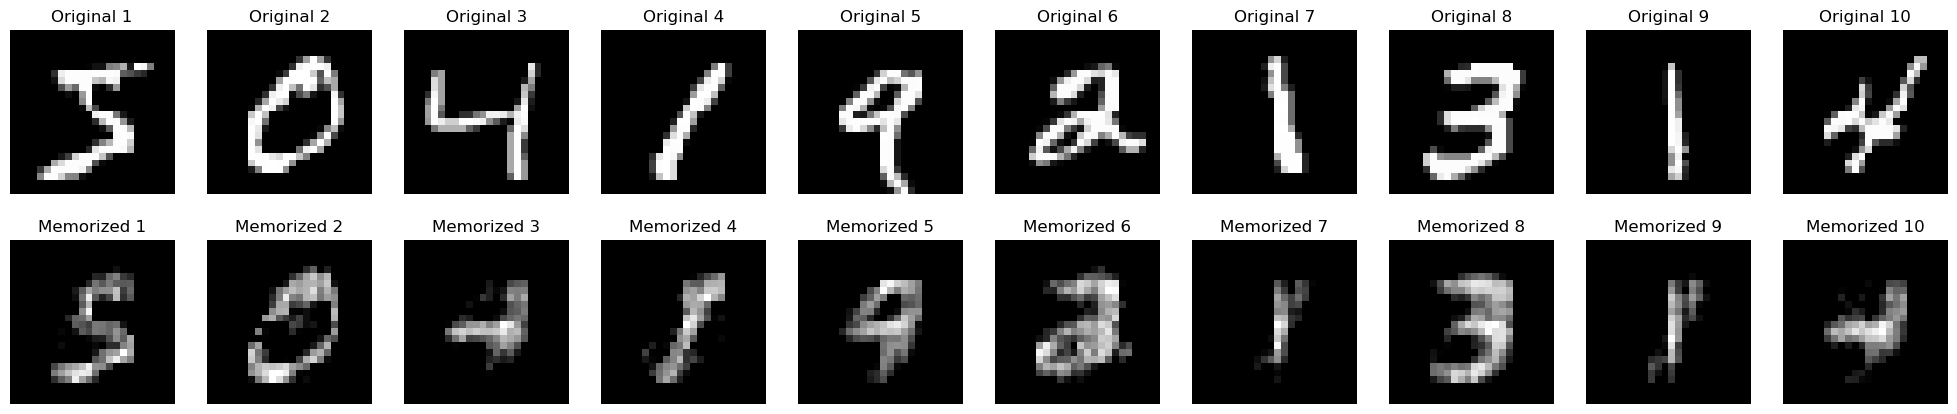

Epoch 77 | Train loss 0.004818 | Memorization loss 0.149400
Saved model and optimizer with memorization loss: 0.1494
Visualizing results at Epoch 78


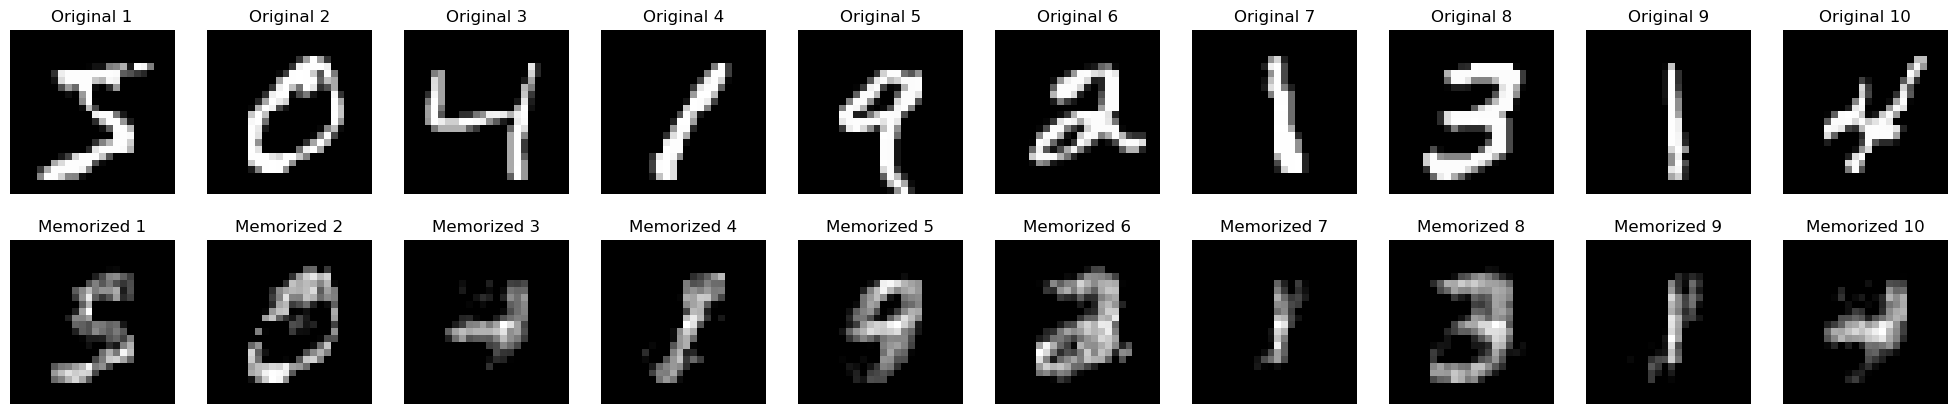

Epoch 78 | Train loss 0.004819 | Memorization loss 0.153391
Visualizing results at Epoch 79


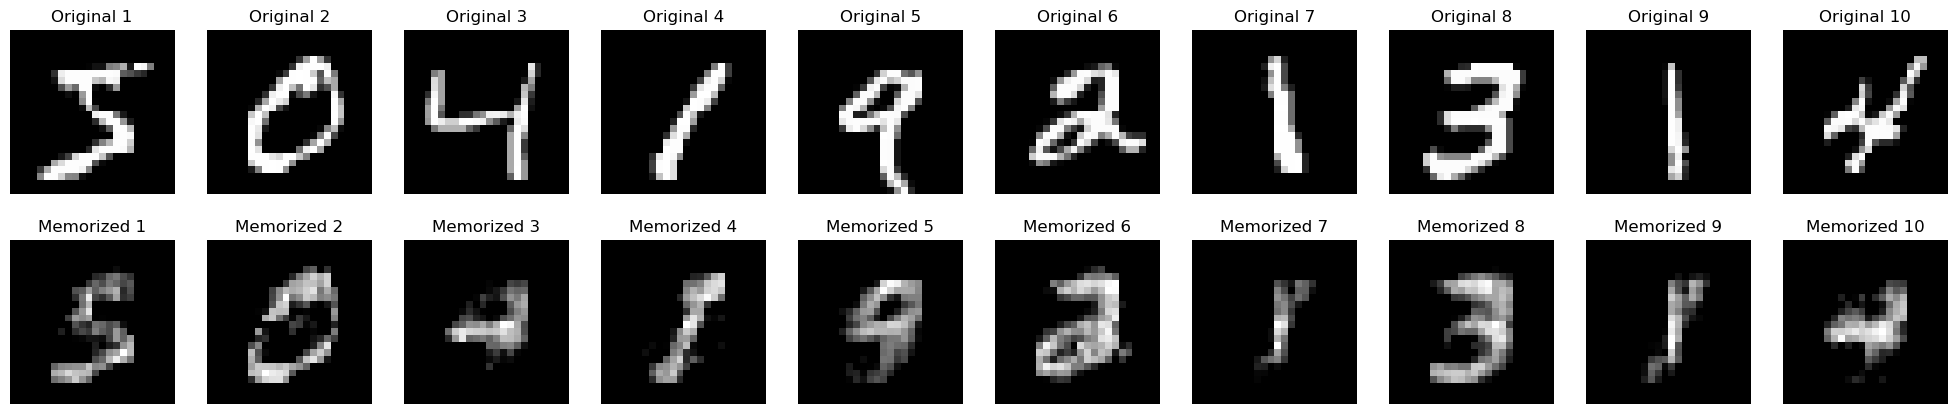

Epoch 79 | Train loss 0.004818 | Memorization loss 0.149124
Saved model and optimizer with memorization loss: 0.1491
Visualizing results at Epoch 80


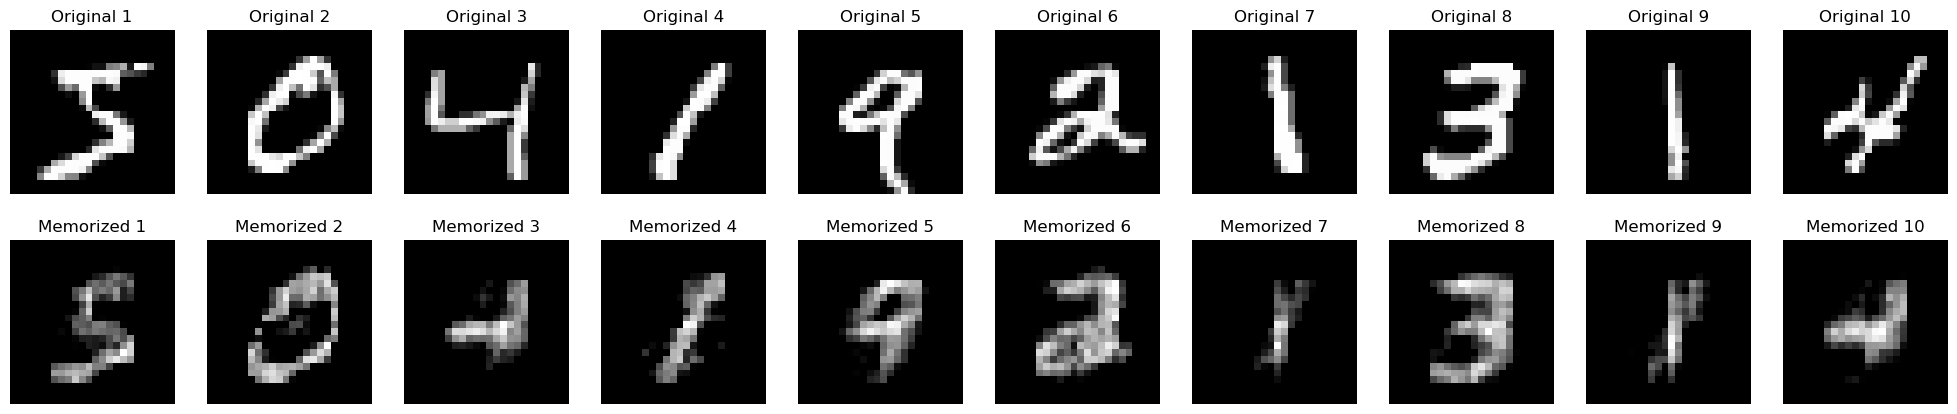

Epoch 80 | Train loss 0.004818 | Memorization loss 0.149203
Visualizing results at Epoch 81


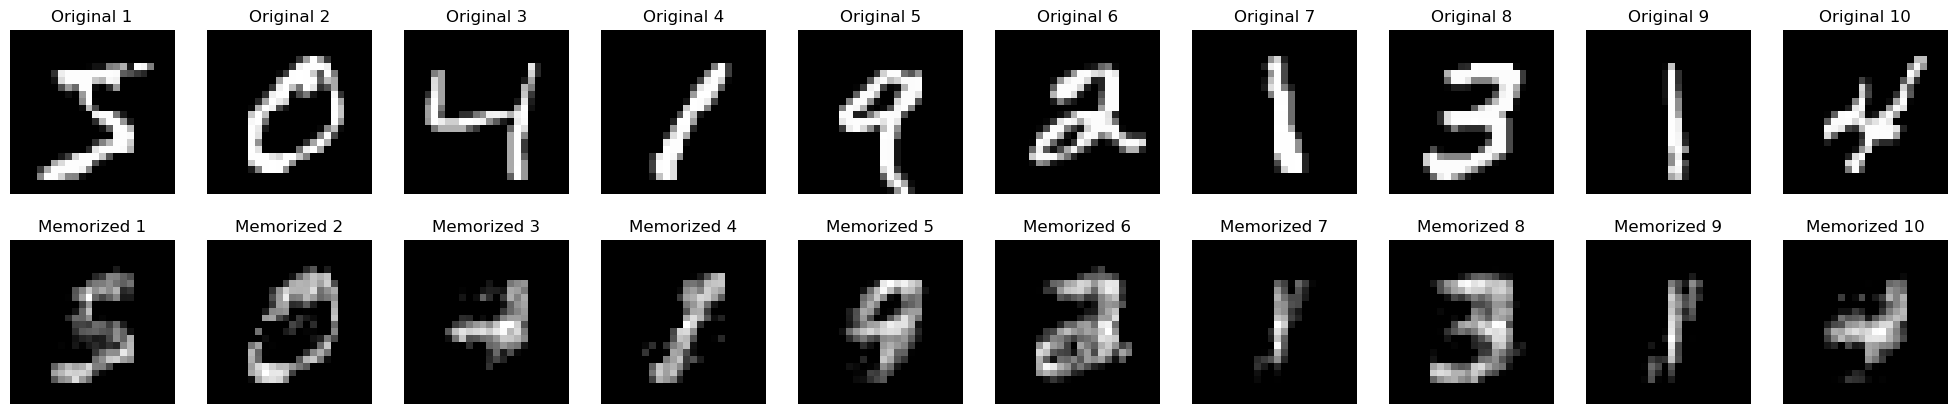

Epoch 81 | Train loss 0.004819 | Memorization loss 0.147013
Saved model and optimizer with memorization loss: 0.1470
Visualizing results at Epoch 82


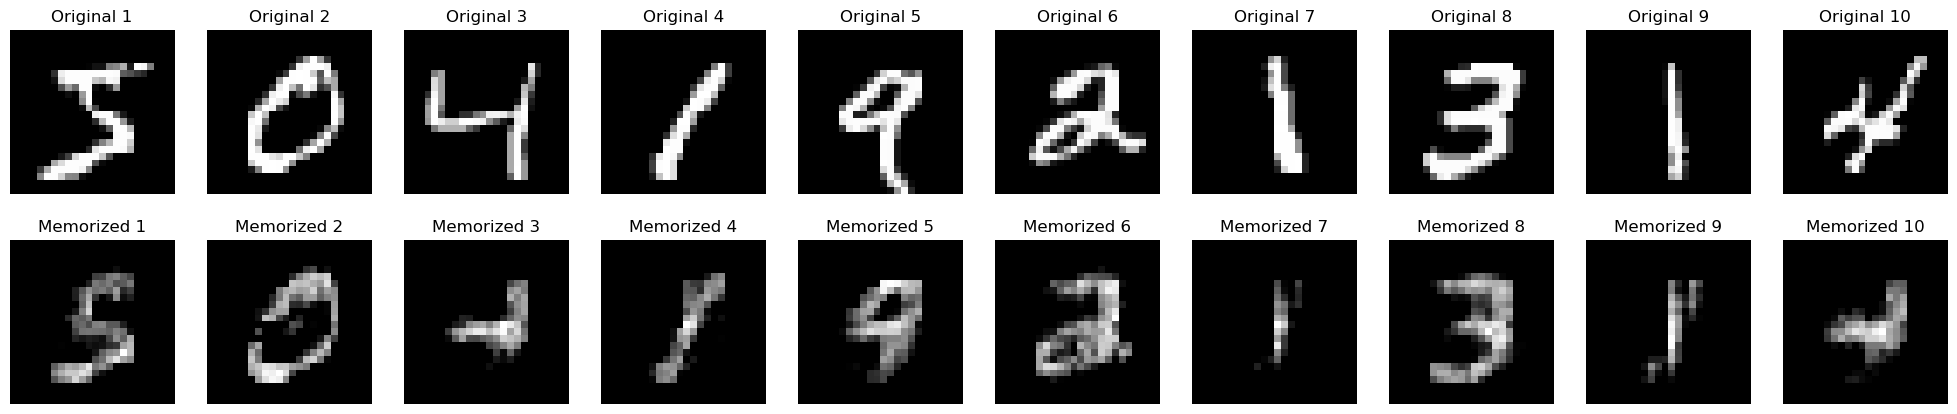

Epoch 82 | Train loss 0.004819 | Memorization loss 0.147851
Visualizing results at Epoch 83


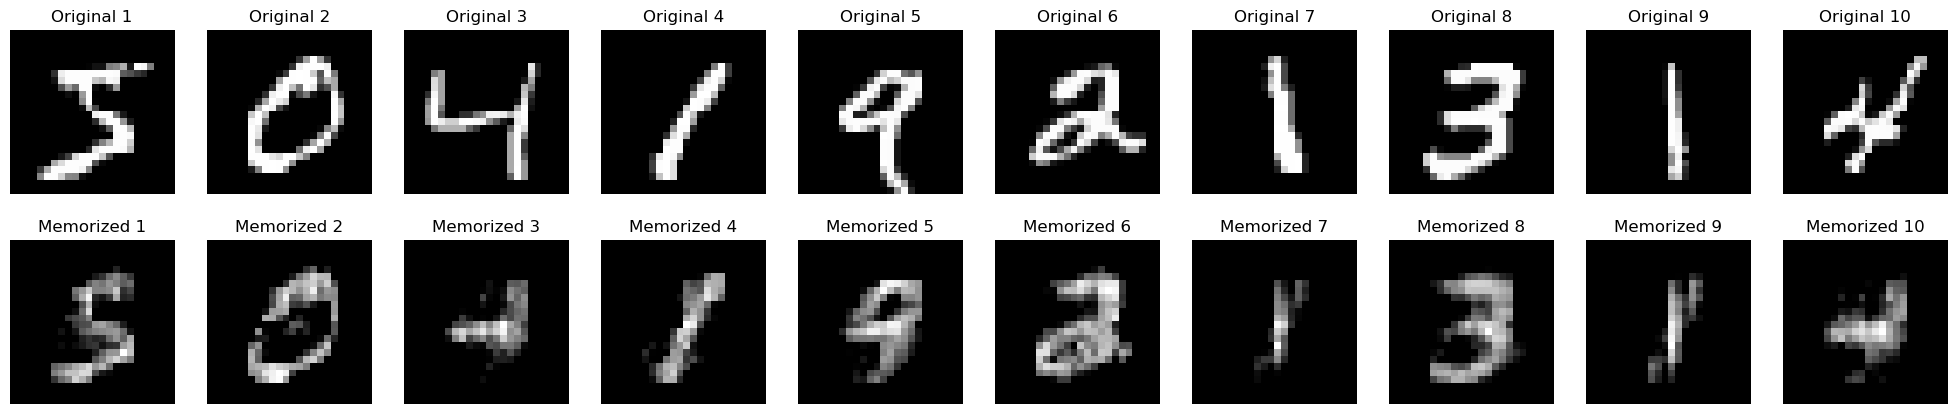

Epoch 83 | Train loss 0.004818 | Memorization loss 0.151474
Visualizing results at Epoch 84


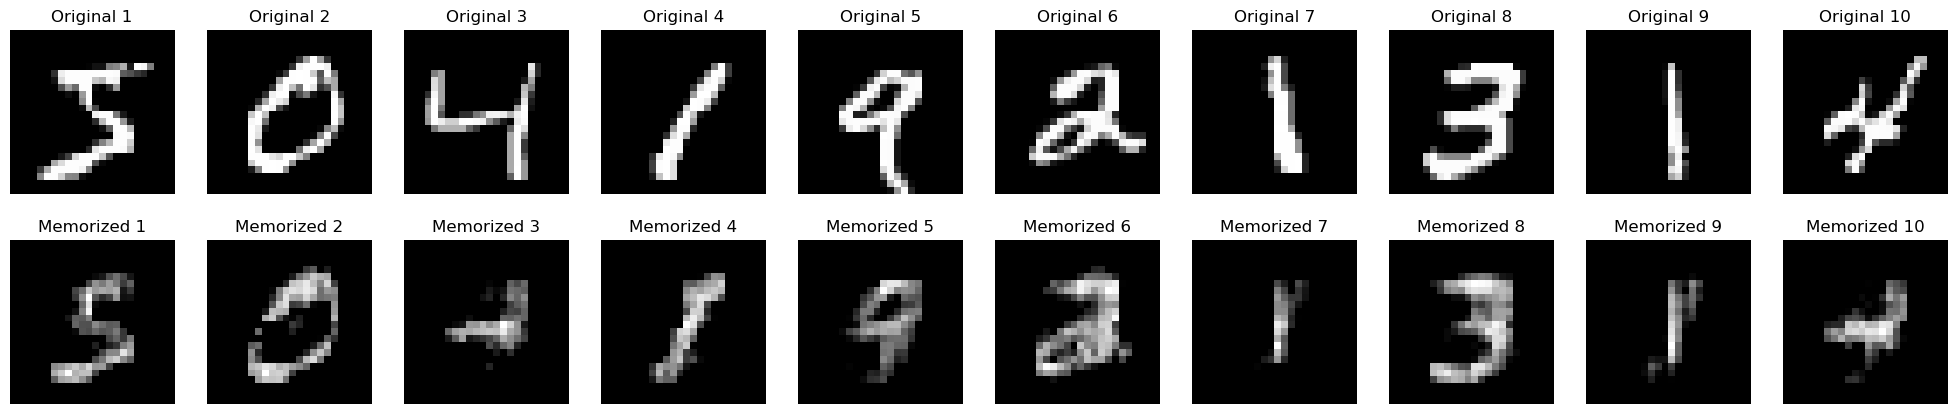

Epoch 84 | Train loss 0.004818 | Memorization loss 0.150273
Visualizing results at Epoch 85


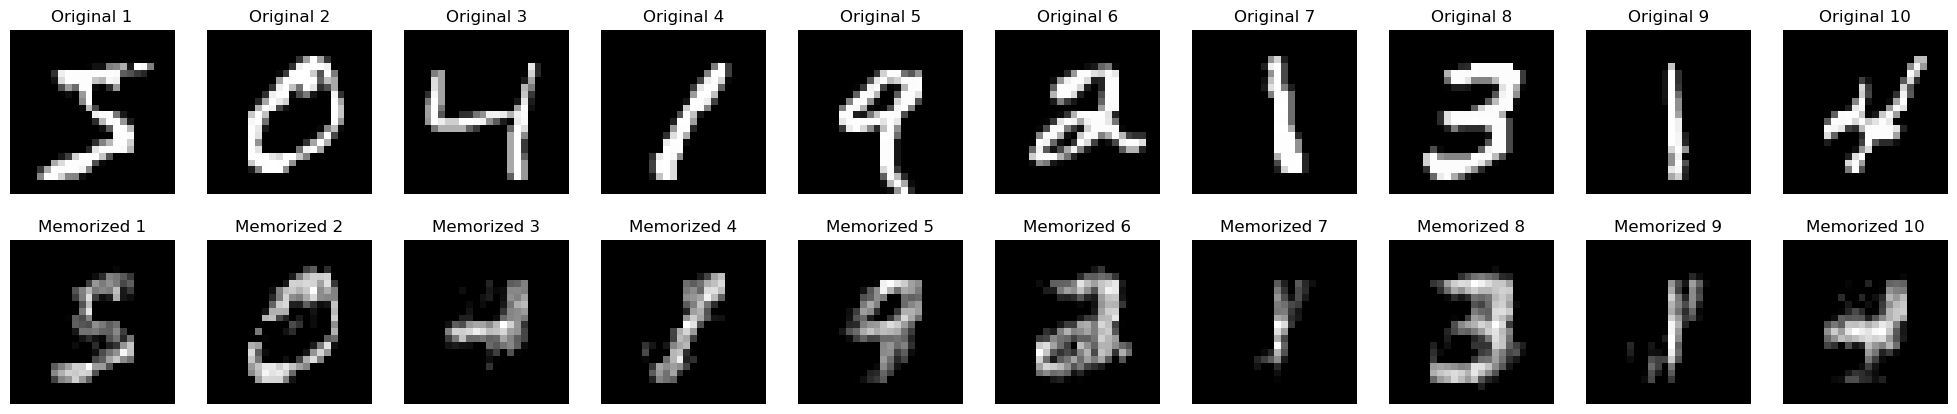

Epoch 85 | Train loss 0.004819 | Memorization loss 0.146200
Saved model and optimizer with memorization loss: 0.1462
Visualizing results at Epoch 86


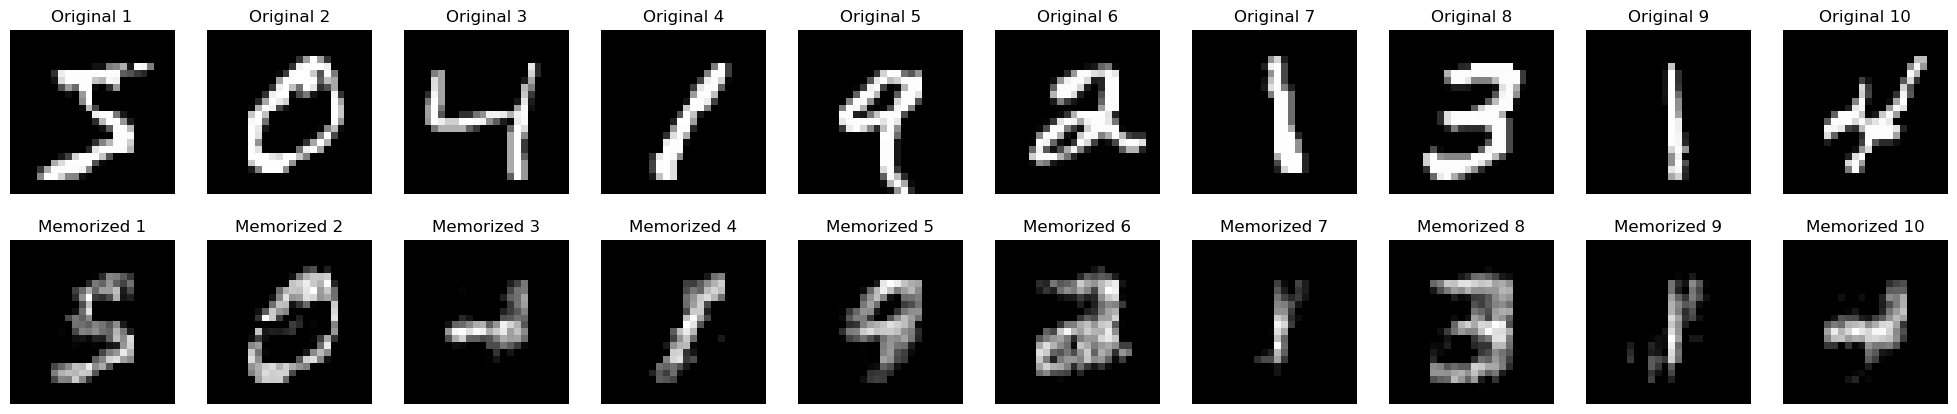

Epoch 86 | Train loss 0.004820 | Memorization loss 0.147103
Visualizing results at Epoch 87


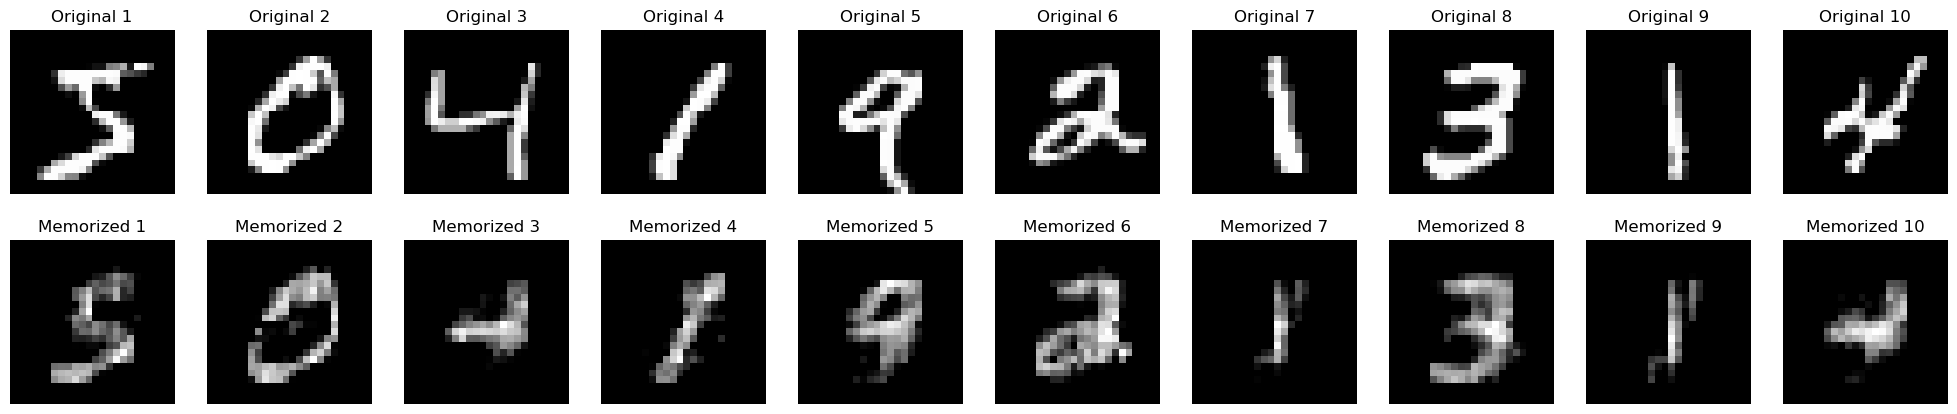

Epoch 87 | Train loss 0.004819 | Memorization loss 0.149304
Visualizing results at Epoch 88


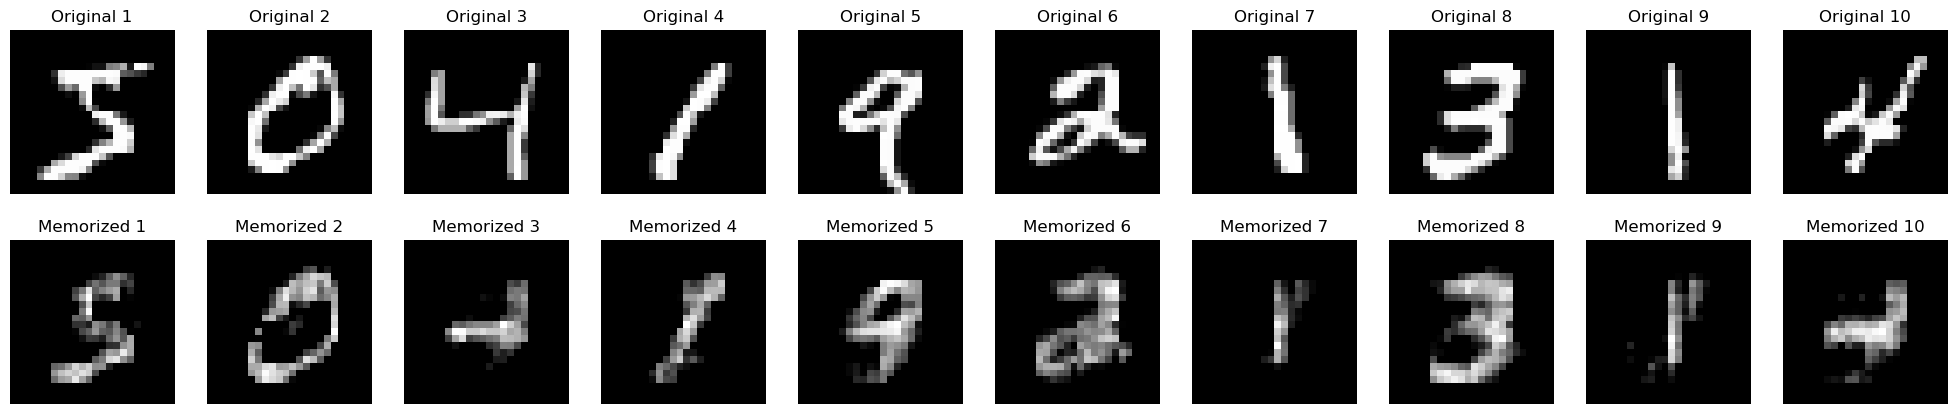

Epoch 88 | Train loss 0.004840 | Memorization loss 0.149628
Visualizing results at Epoch 89


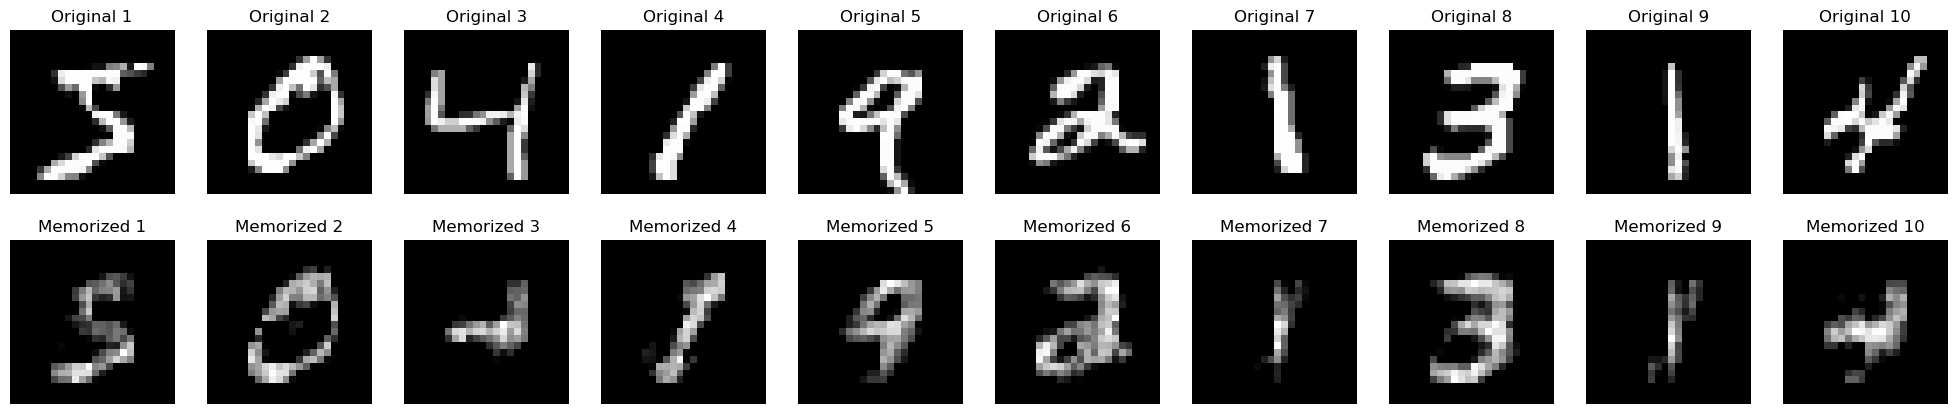

Epoch 89 | Train loss 0.004829 | Memorization loss 0.148293
Visualizing results at Epoch 90


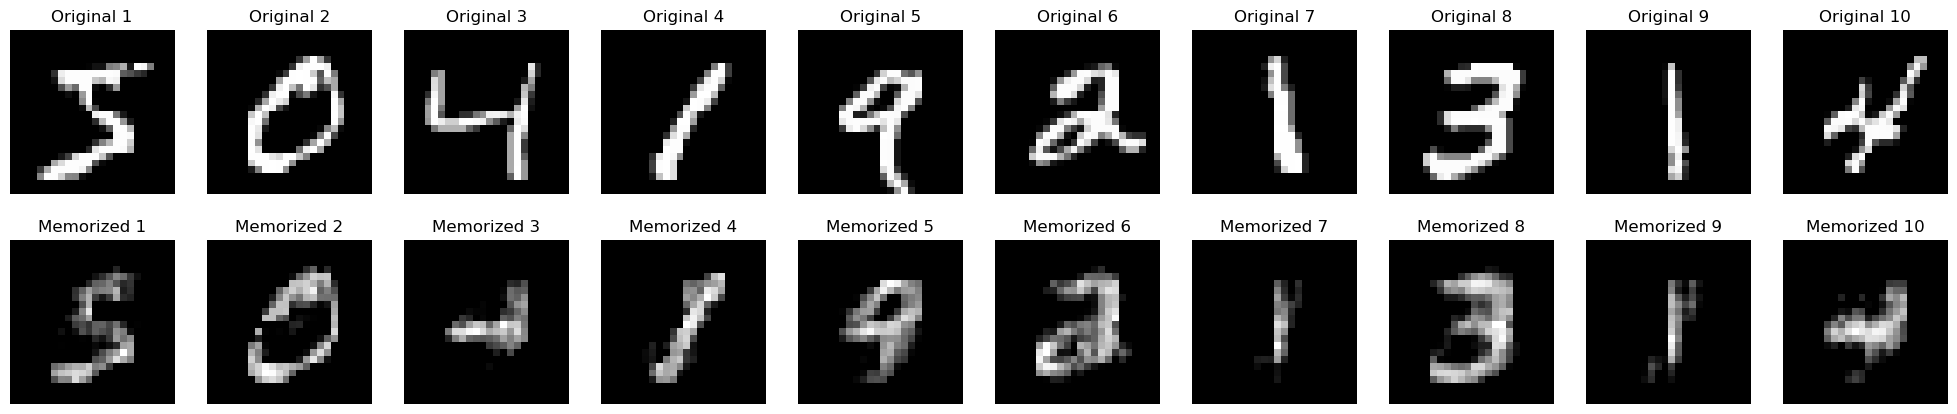

Epoch 90 | Train loss 0.004818 | Memorization loss 0.145535
Saved model and optimizer with memorization loss: 0.1455
Visualizing results at Epoch 91


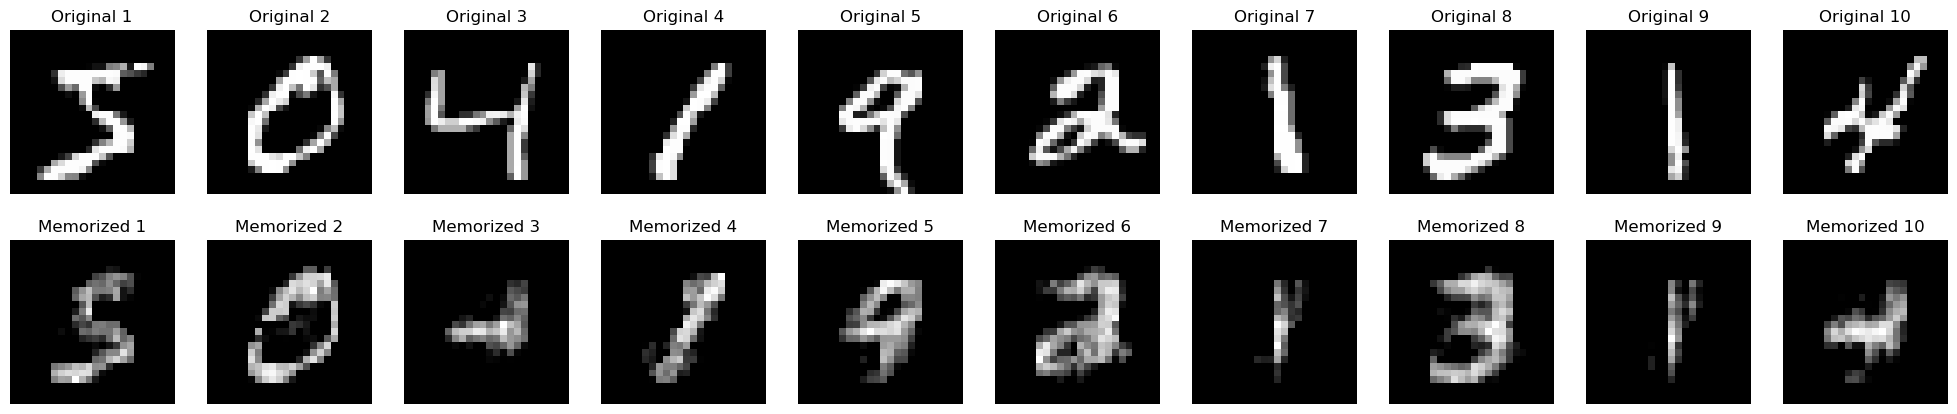

Epoch 91 | Train loss 0.004821 | Memorization loss 0.146803
Visualizing results at Epoch 92


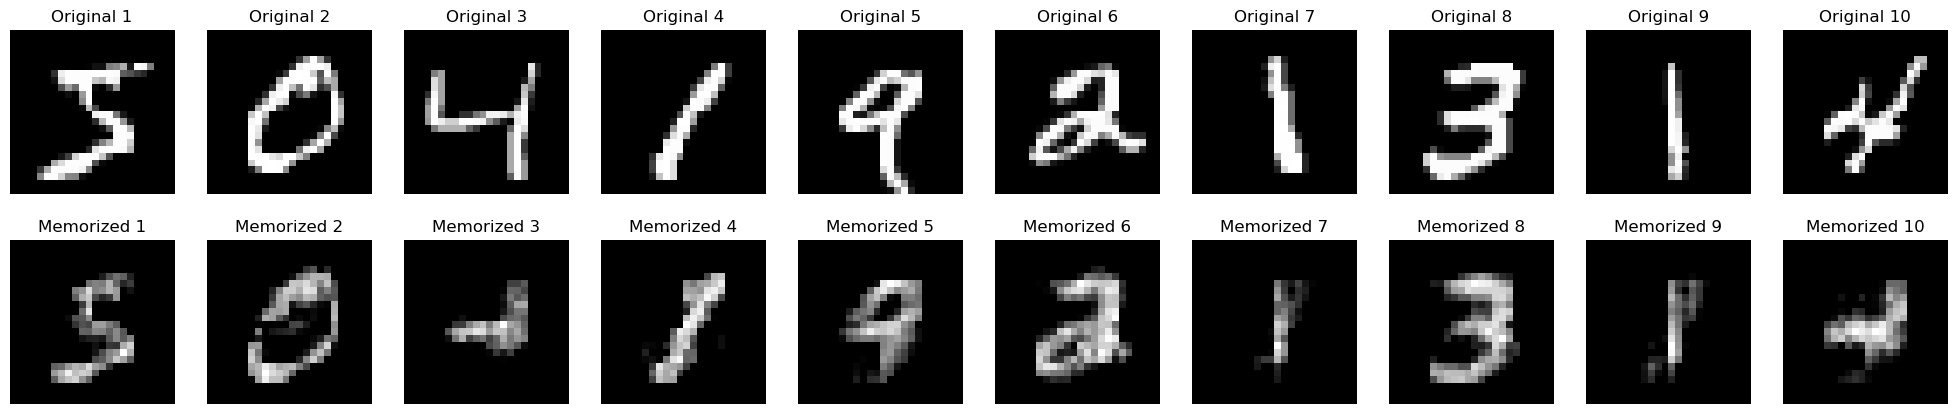

Epoch 92 | Train loss 0.004819 | Memorization loss 0.147409
Visualizing results at Epoch 93


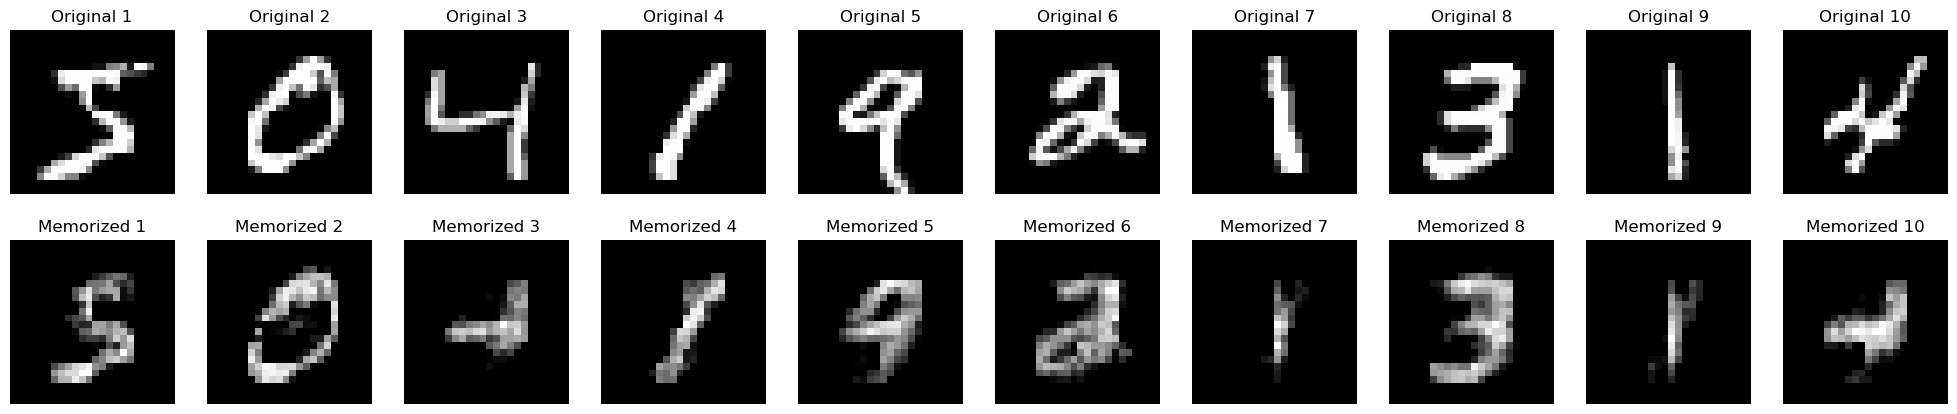

Epoch 93 | Train loss 0.004818 | Memorization loss 0.146940
Visualizing results at Epoch 94


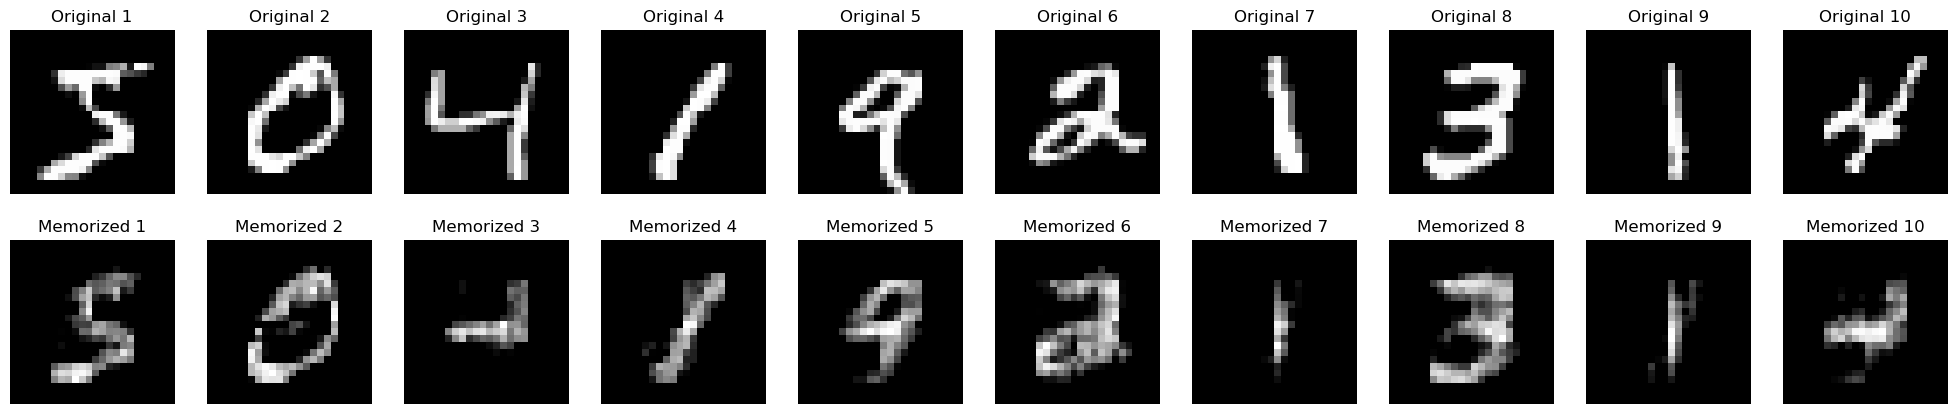

Epoch 94 | Train loss 0.004817 | Memorization loss 0.144303
Saved model and optimizer with memorization loss: 0.1443
Visualizing results at Epoch 95


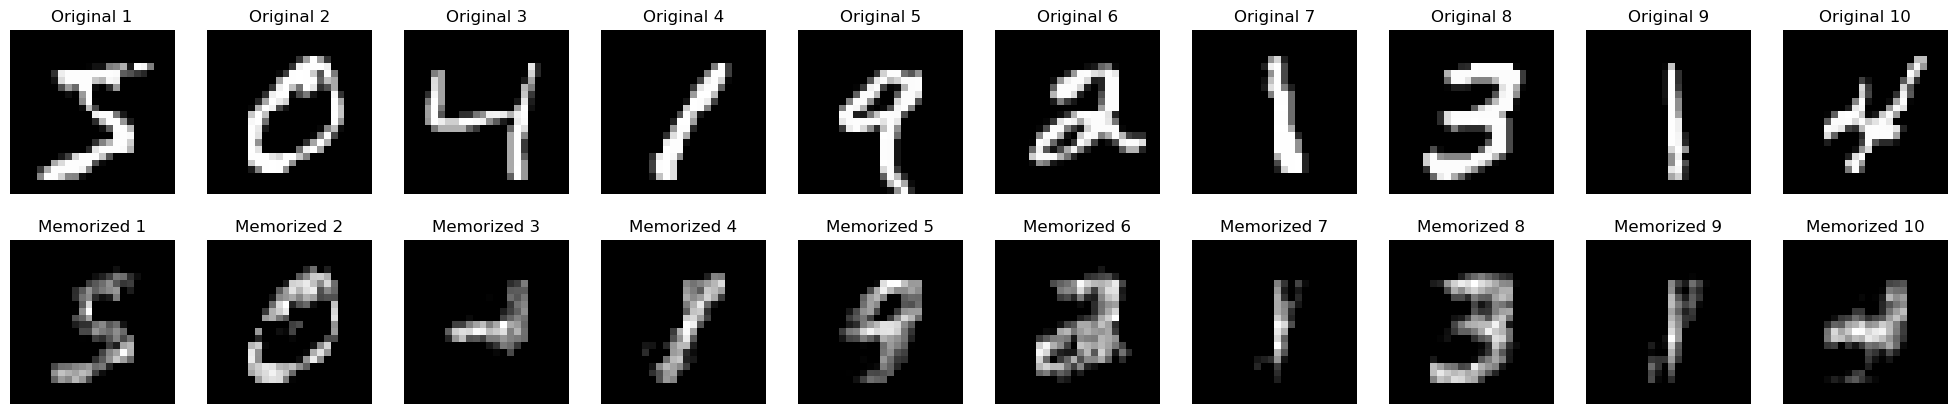

Epoch 95 | Train loss 0.004819 | Memorization loss 0.145474
Visualizing results at Epoch 96


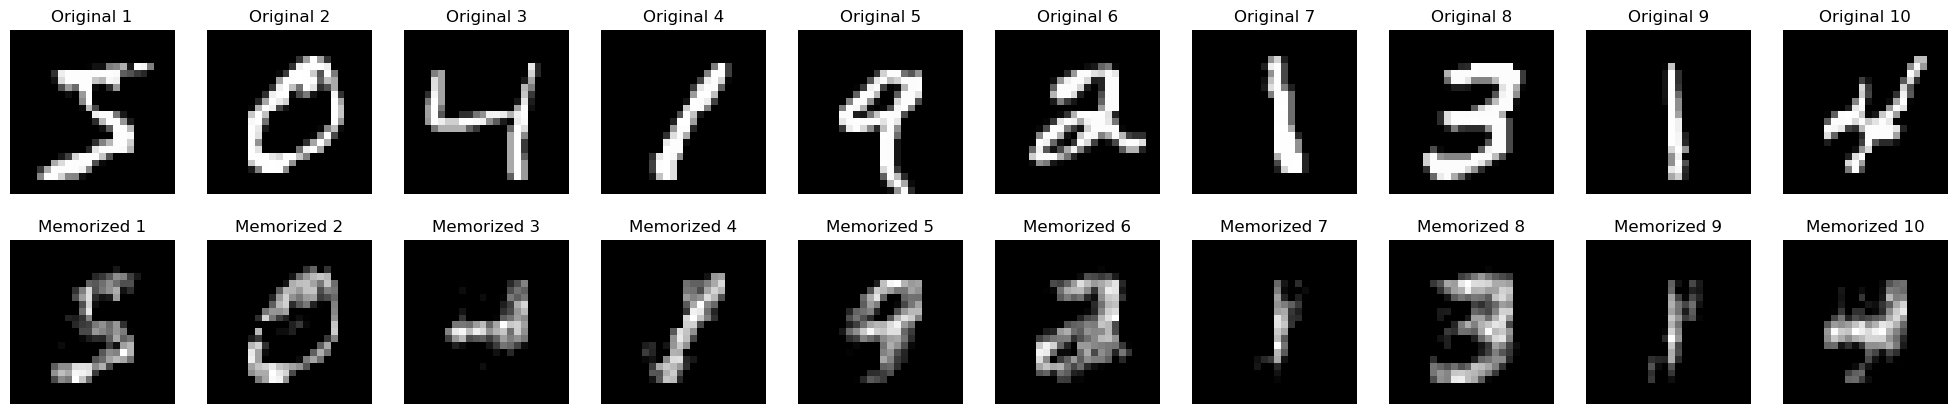

Epoch 96 | Train loss 0.004818 | Memorization loss 0.146778
Visualizing results at Epoch 97


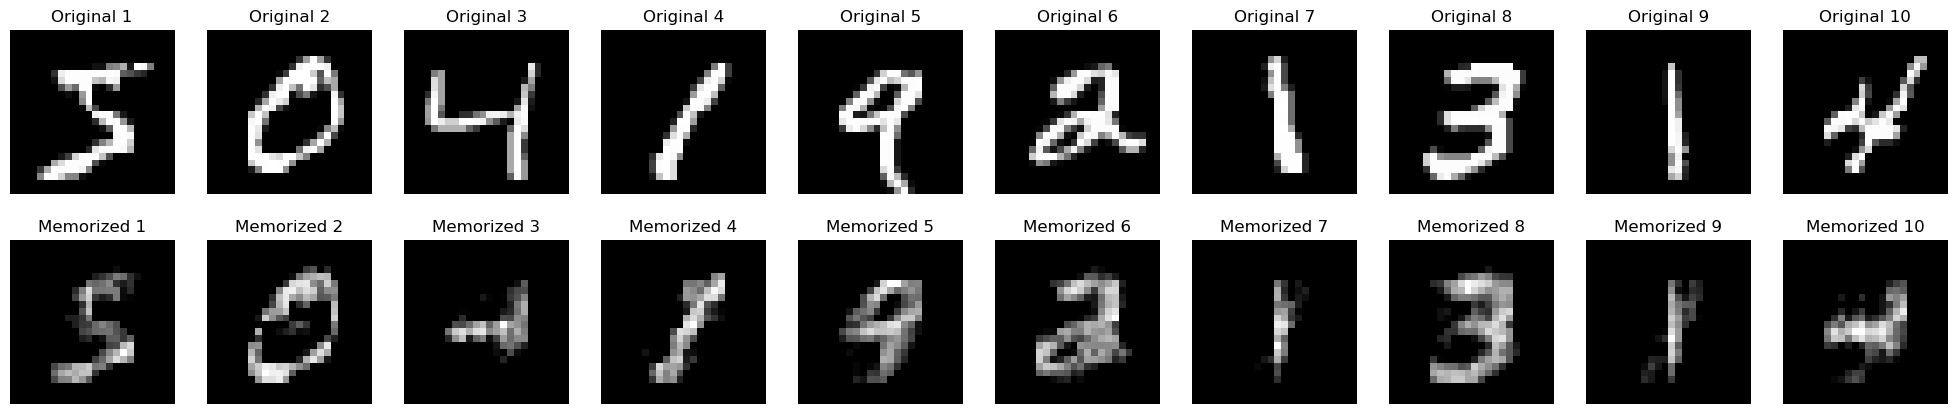

Epoch 97 | Train loss 0.004819 | Memorization loss 0.145820
Visualizing results at Epoch 98


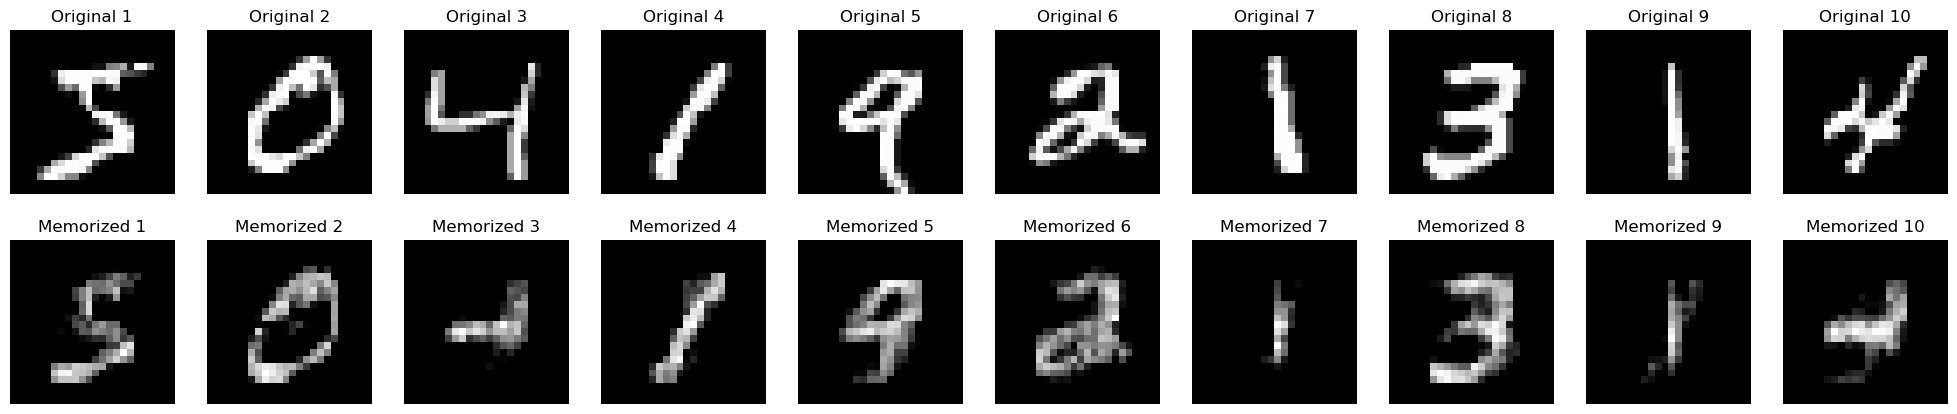

Epoch 98 | Train loss 0.004835 | Memorization loss 0.142840
Saved model and optimizer with memorization loss: 0.1428
Visualizing results at Epoch 99


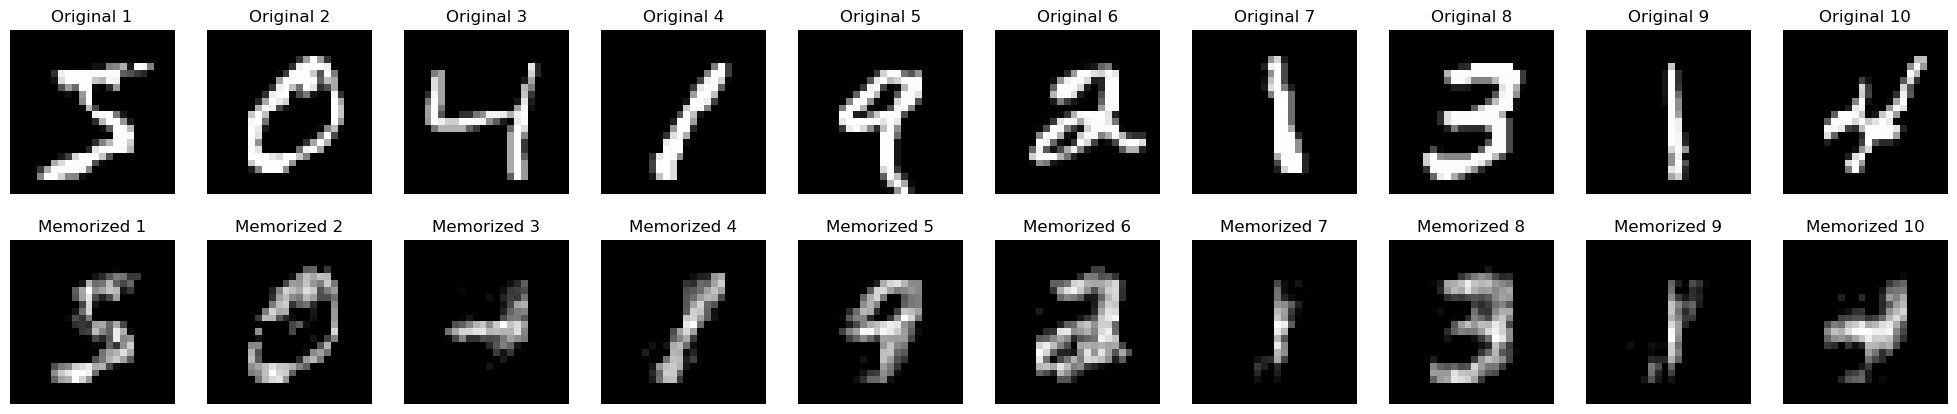

Epoch 99 | Train loss 0.004835 | Memorization loss 0.143569
Visualizing results at Epoch 100


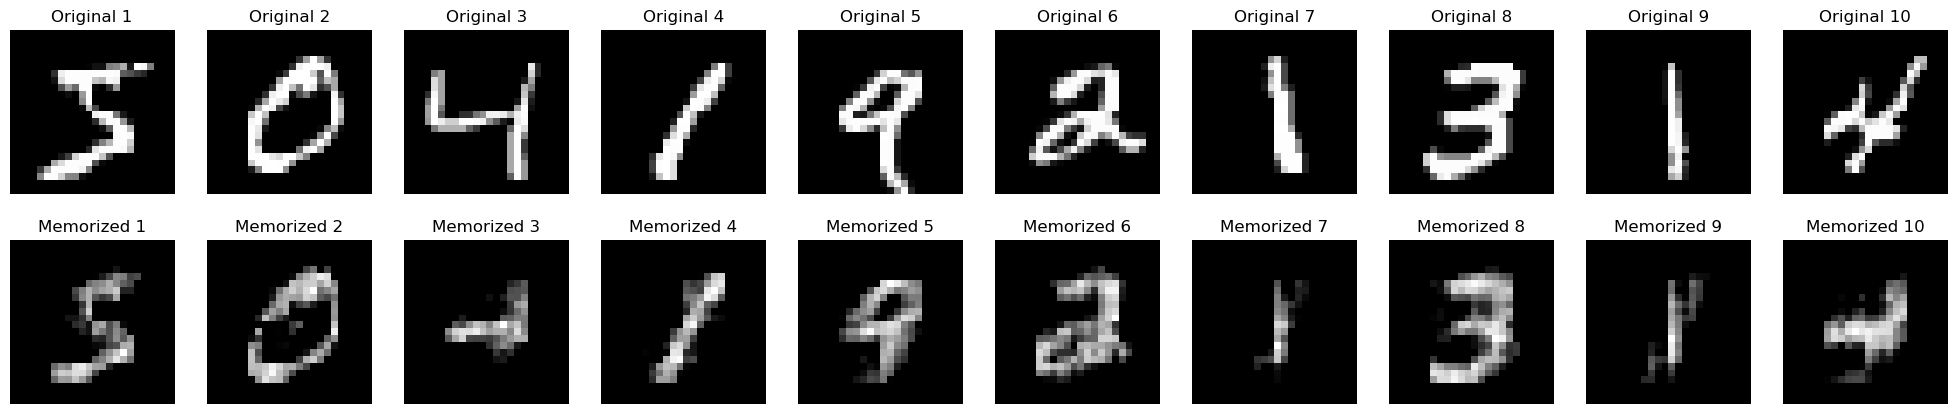

Epoch 100 | Train loss 0.004820 | Memorization loss 0.144523
Visualizing results at Epoch 101


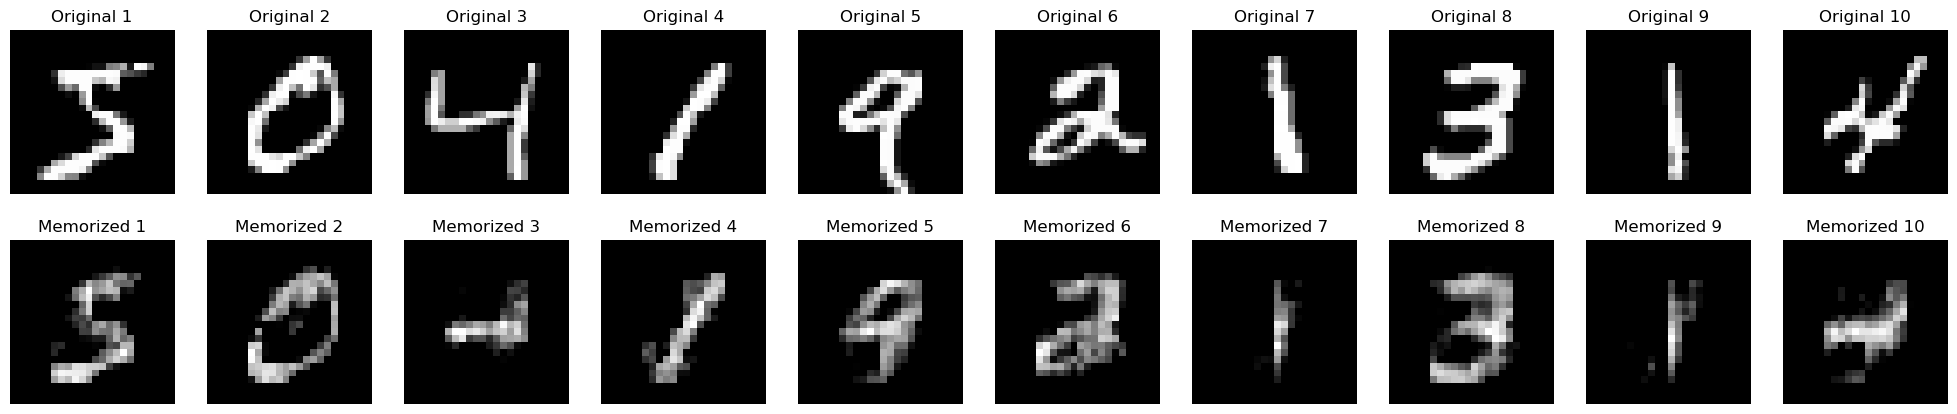

Epoch 101 | Train loss 0.004820 | Memorization loss 0.145191
Visualizing results at Epoch 102


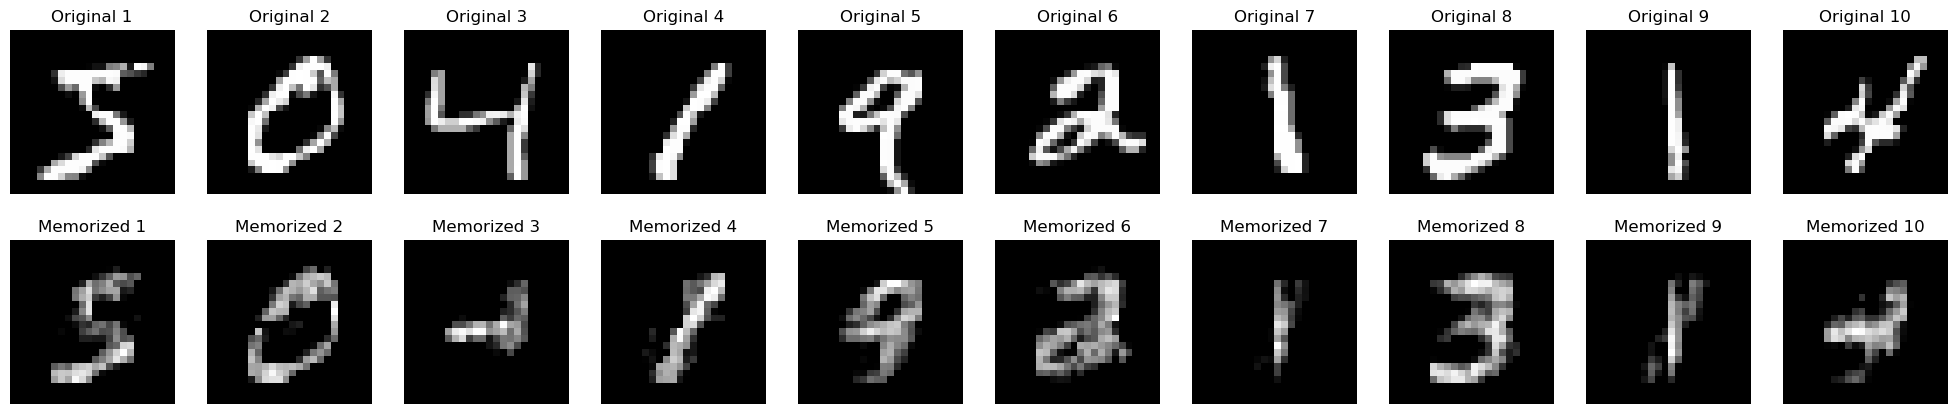

Epoch 102 | Train loss 0.004821 | Memorization loss 0.142391
Saved model and optimizer with memorization loss: 0.1424
Visualizing results at Epoch 103


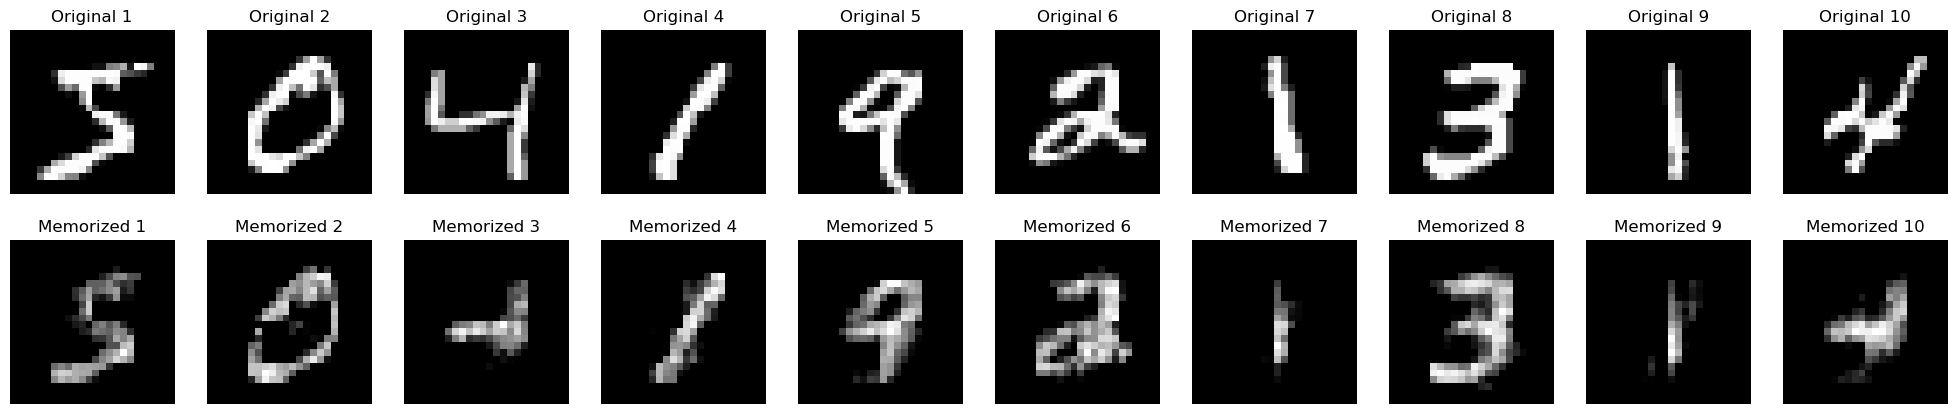

Epoch 103 | Train loss 0.004818 | Memorization loss 0.142446
Visualizing results at Epoch 104


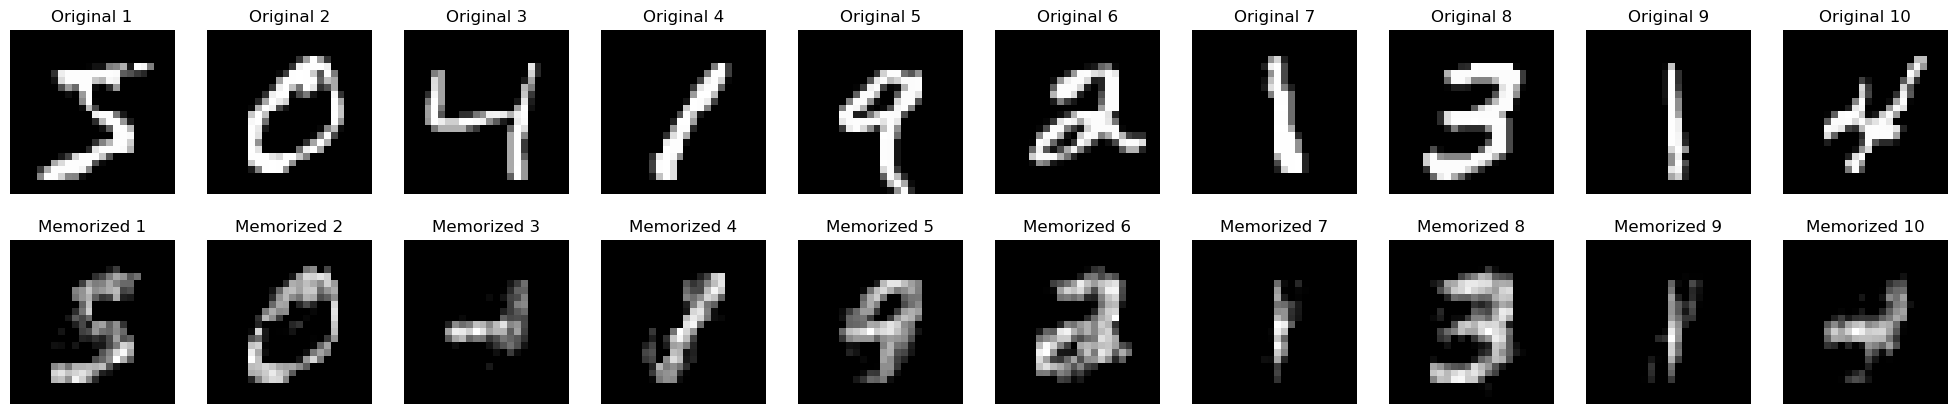

Epoch 104 | Train loss 0.004817 | Memorization loss 0.144636
Visualizing results at Epoch 105


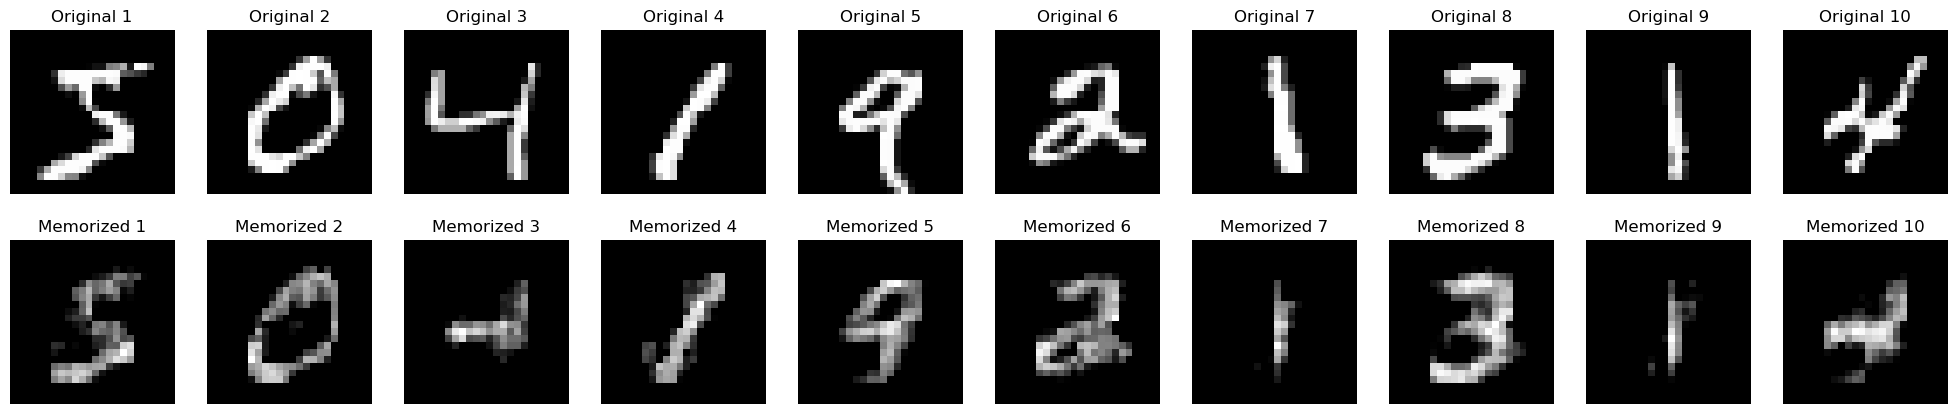

Epoch 105 | Train loss 0.004817 | Memorization loss 0.141724
Saved model and optimizer with memorization loss: 0.1417
Visualizing results at Epoch 106


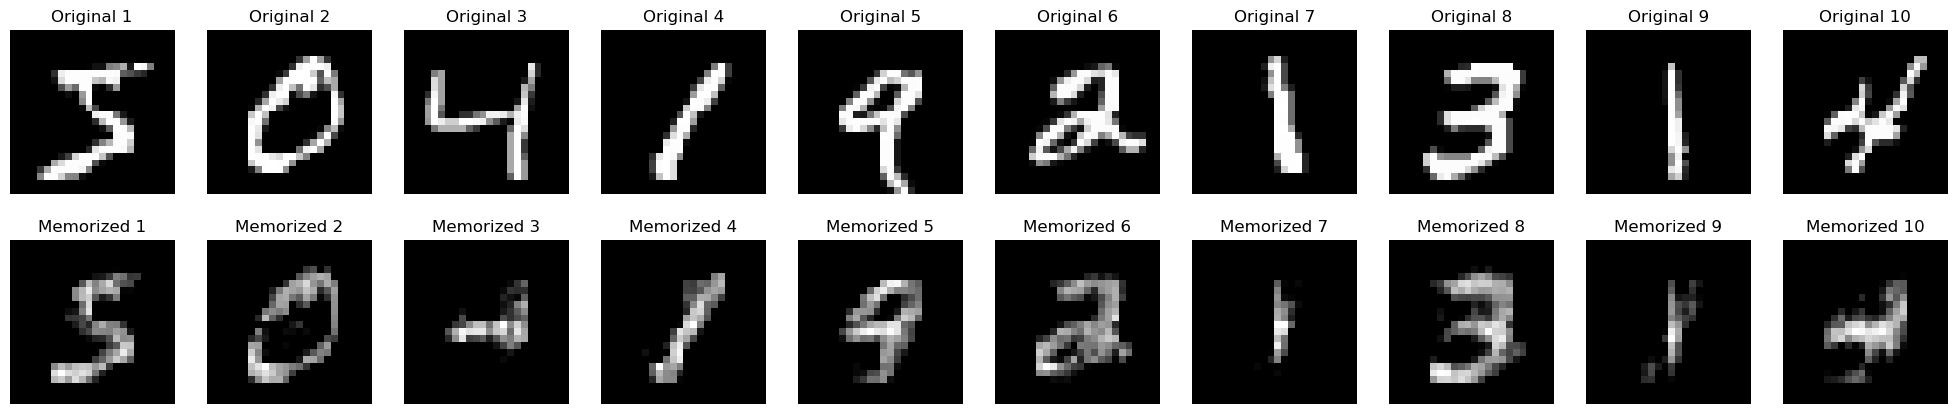

Epoch 106 | Train loss 0.004819 | Memorization loss 0.142766
Visualizing results at Epoch 107


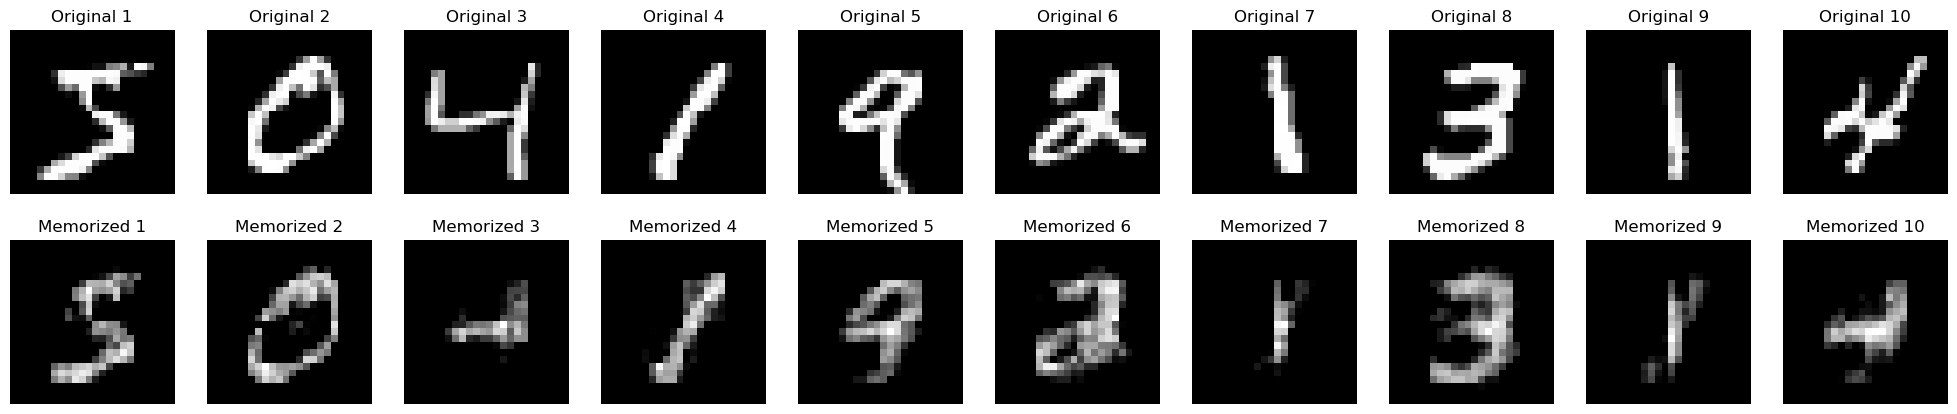

Epoch 107 | Train loss 0.004817 | Memorization loss 0.140645
Saved model and optimizer with memorization loss: 0.1406
Visualizing results at Epoch 108


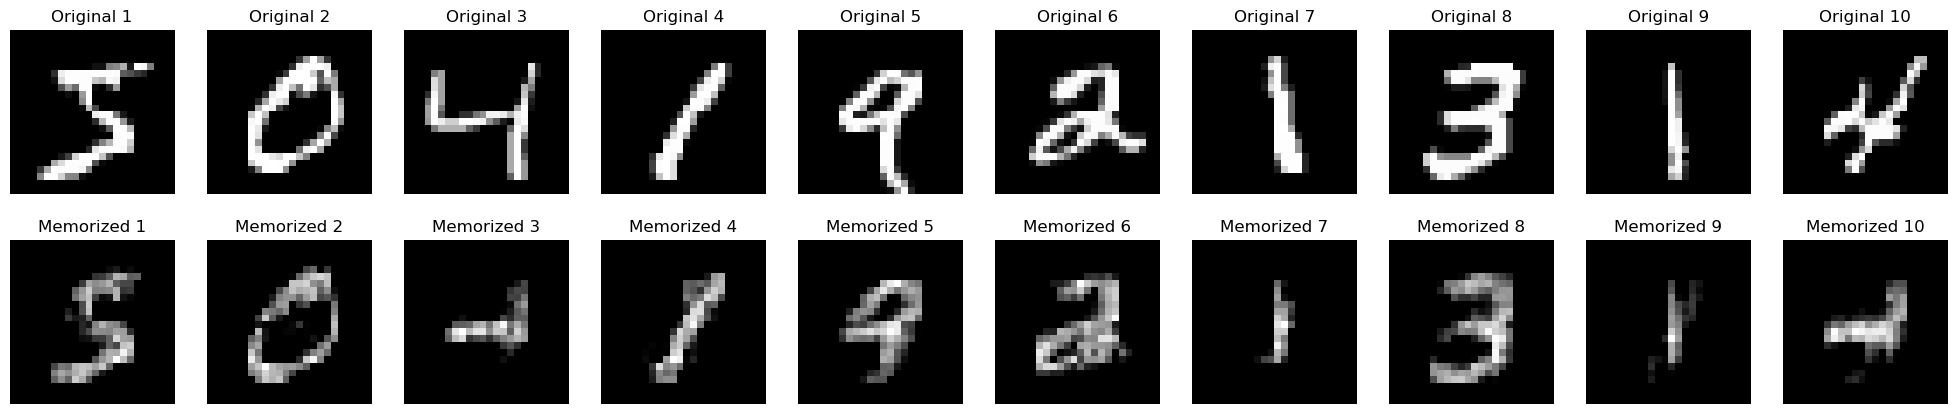

Epoch 108 | Train loss 0.004818 | Memorization loss 0.141369
Visualizing results at Epoch 109


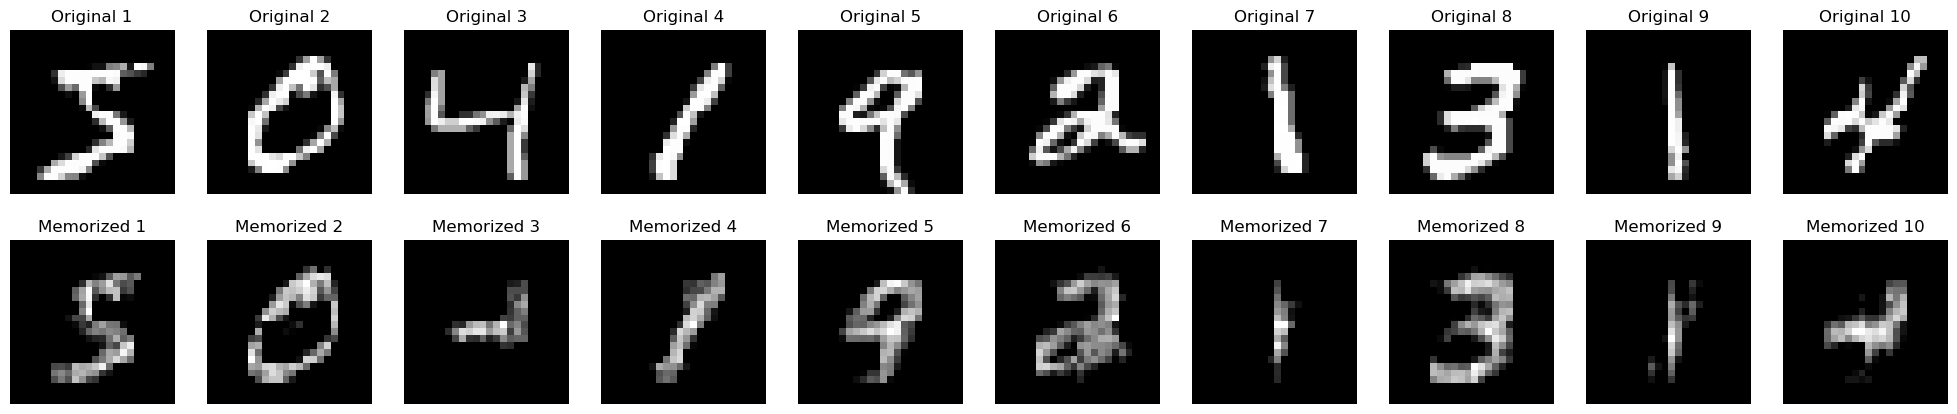

Epoch 109 | Train loss 0.004821 | Memorization loss 0.141806
Visualizing results at Epoch 110


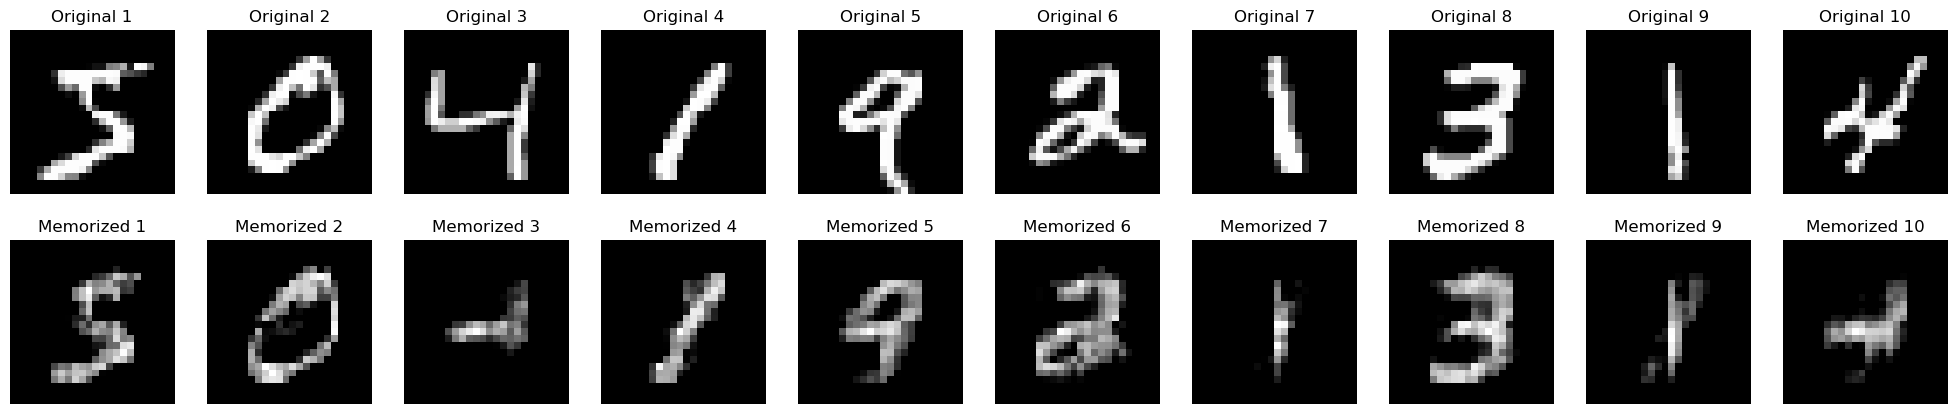

Epoch 110 | Train loss 0.004819 | Memorization loss 0.142298
Visualizing results at Epoch 111


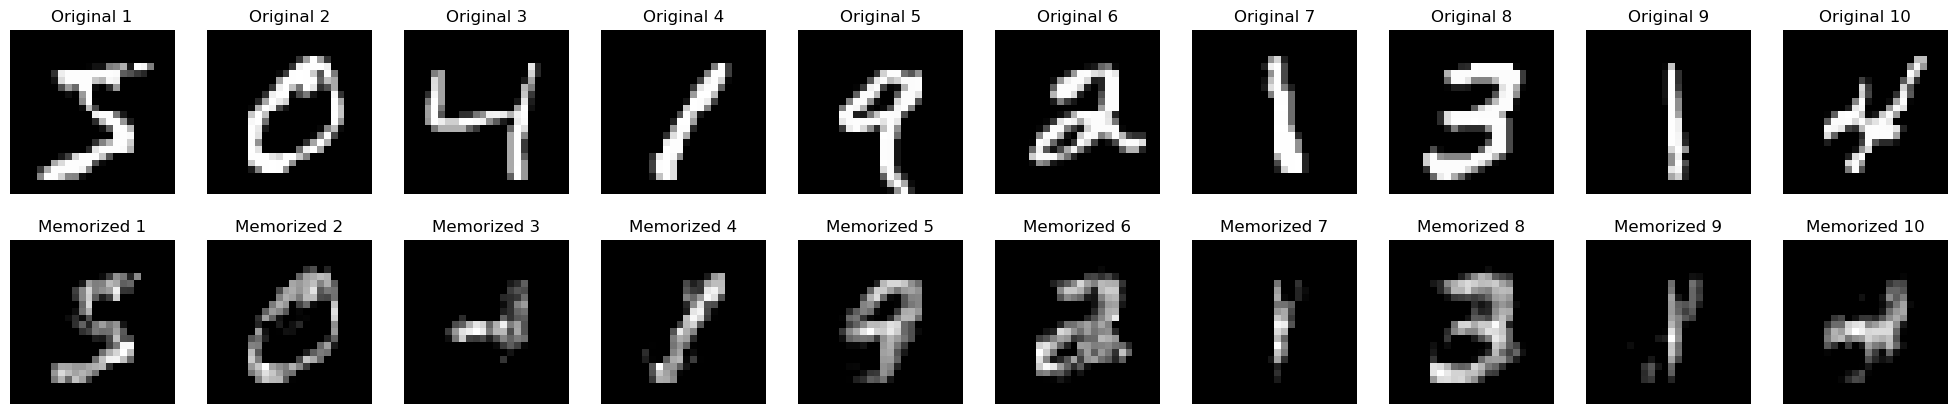

Epoch 111 | Train loss 0.004817 | Memorization loss 0.138019
Saved model and optimizer with memorization loss: 0.1380
Visualizing results at Epoch 112


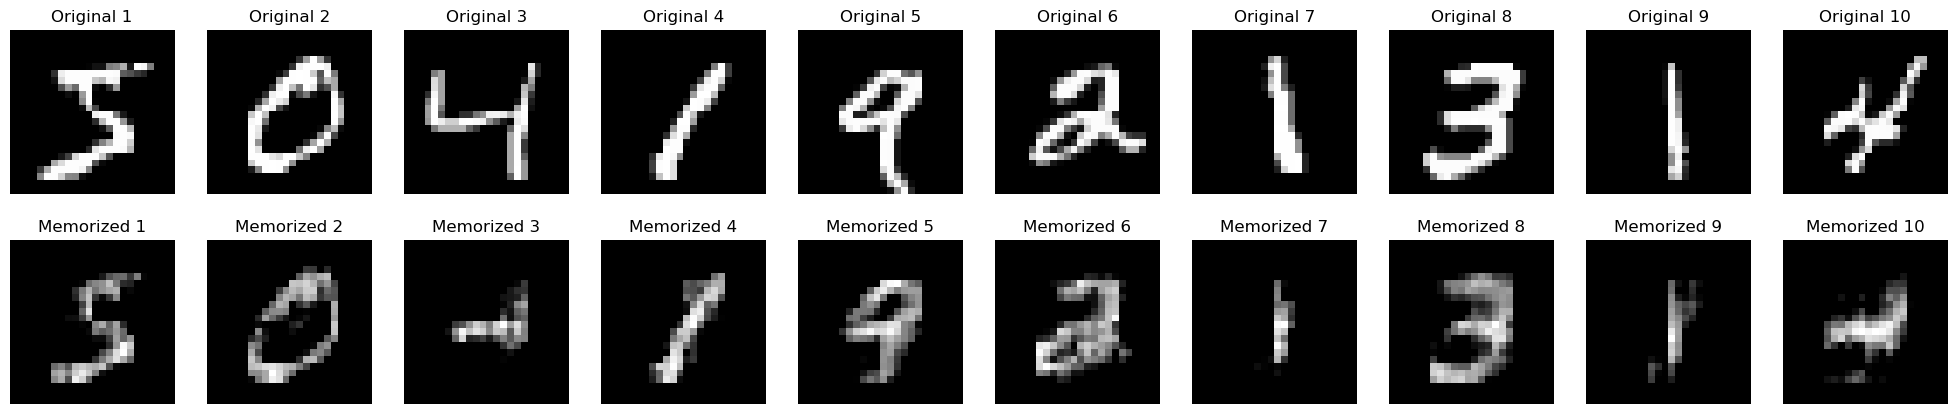

Epoch 112 | Train loss 0.004830 | Memorization loss 0.138245
Visualizing results at Epoch 113


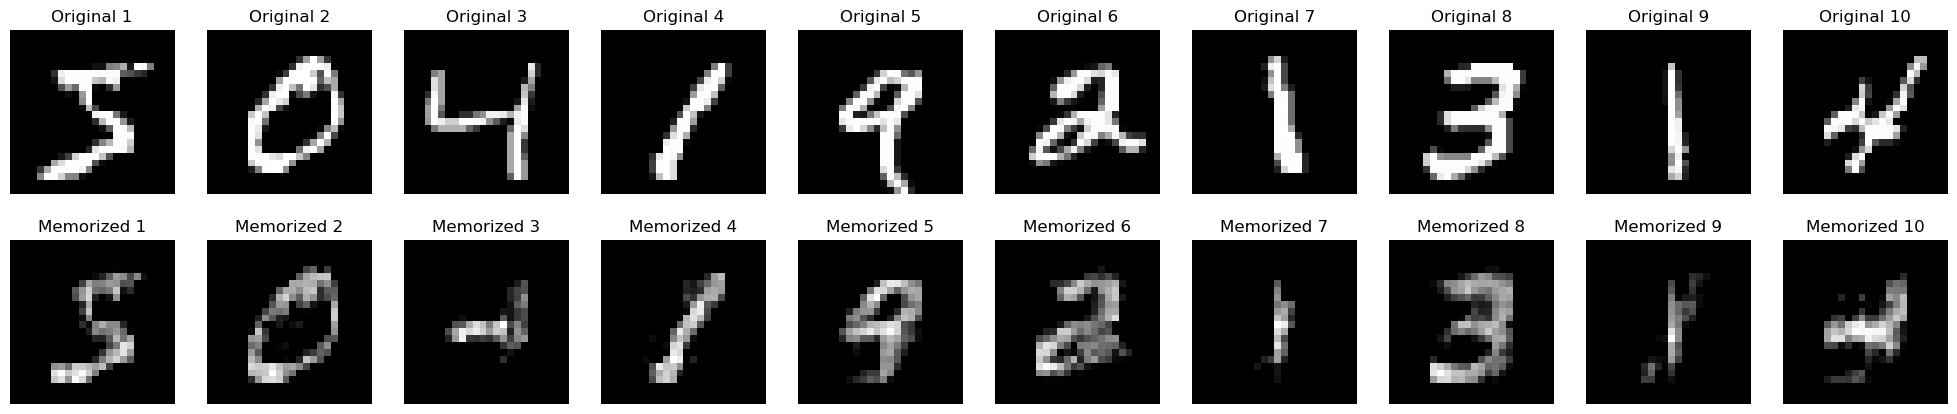

Epoch 113 | Train loss 0.004836 | Memorization loss 0.142121
Visualizing results at Epoch 114


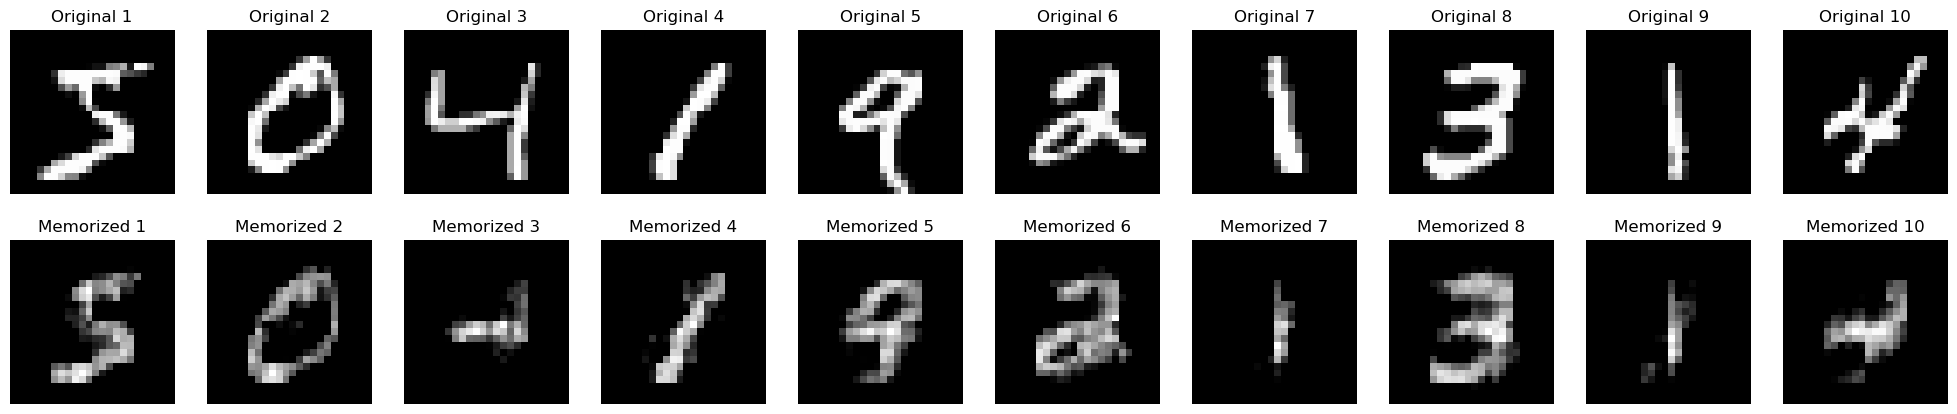

Epoch 114 | Train loss 0.004817 | Memorization loss 0.141286
Visualizing results at Epoch 115


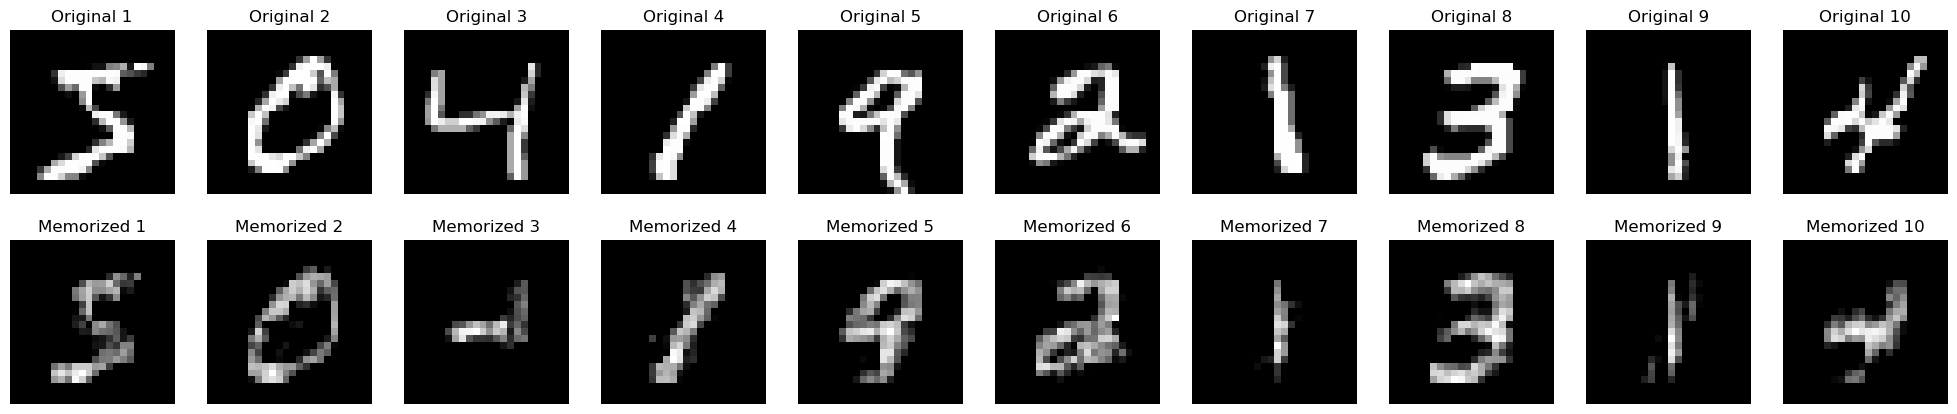

Epoch 115 | Train loss 0.004819 | Memorization loss 0.138477
Visualizing results at Epoch 116


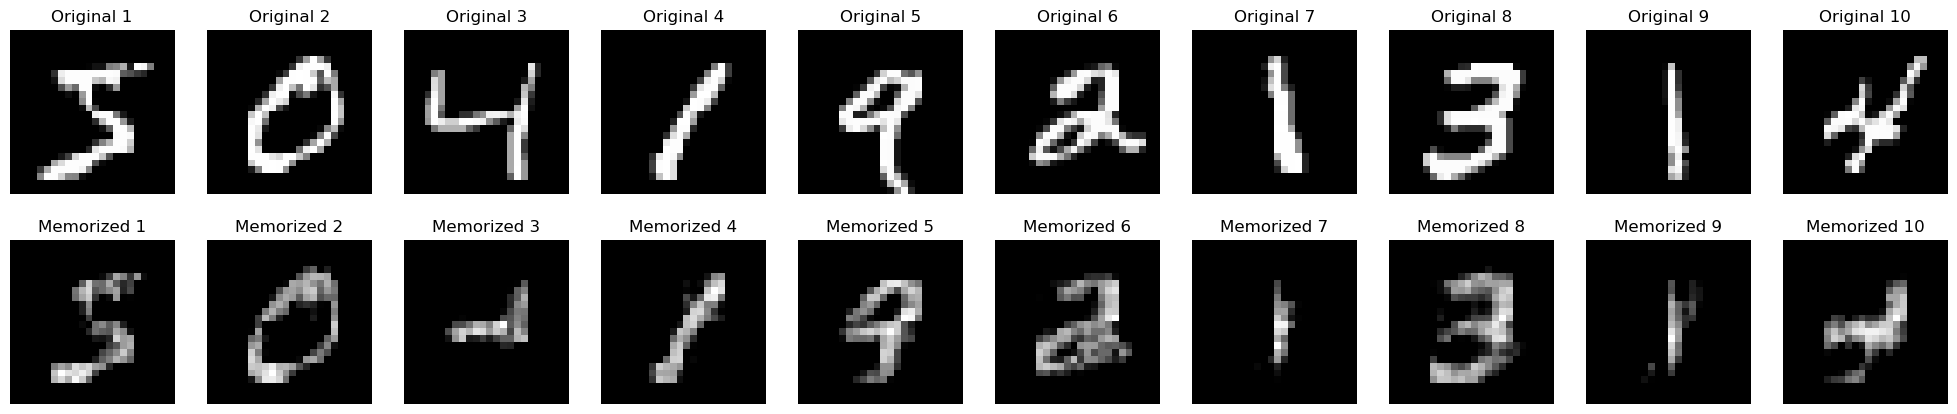

Epoch 116 | Train loss 0.004817 | Memorization loss 0.138836
Visualizing results at Epoch 117


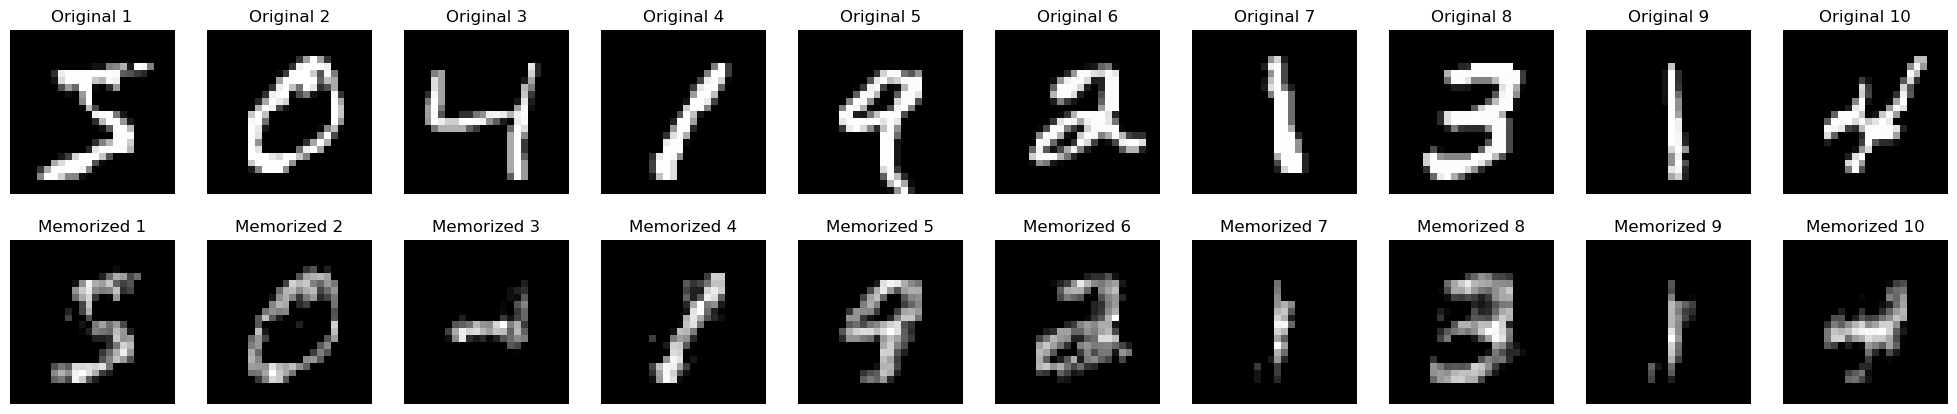

Epoch 117 | Train loss 0.004817 | Memorization loss 0.135249
Saved model and optimizer with memorization loss: 0.1352
Visualizing results at Epoch 118


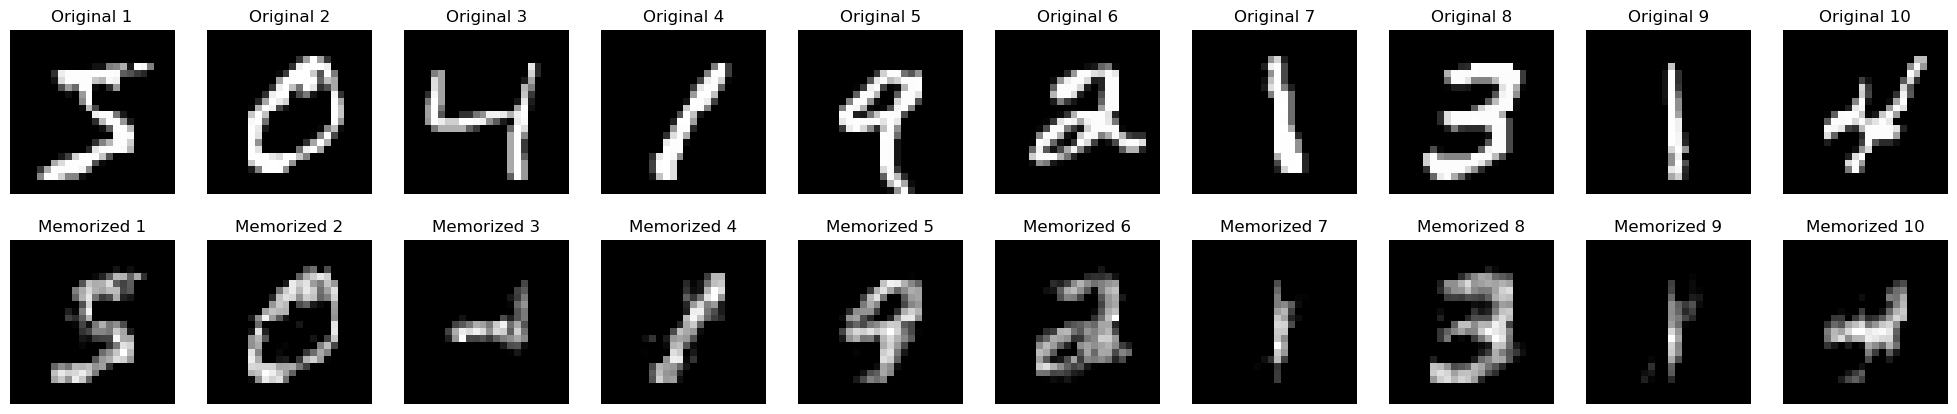

Epoch 118 | Train loss 0.004818 | Memorization loss 0.139861
Visualizing results at Epoch 119


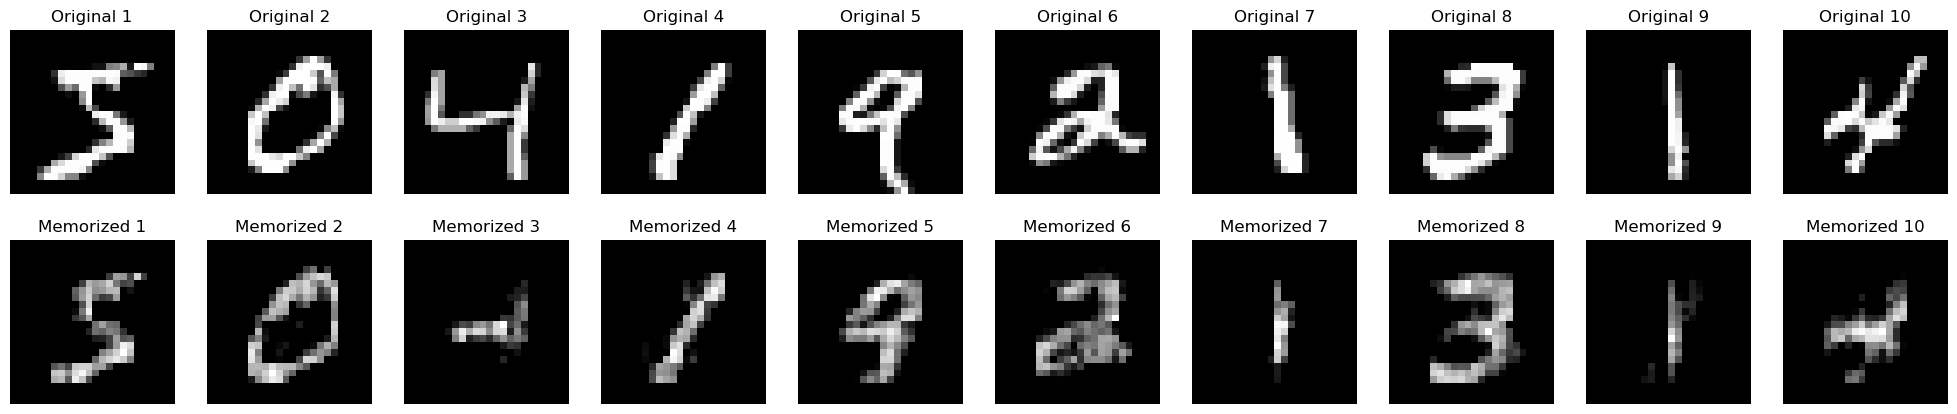

Epoch 119 | Train loss 0.004817 | Memorization loss 0.138918
Visualizing results at Epoch 120


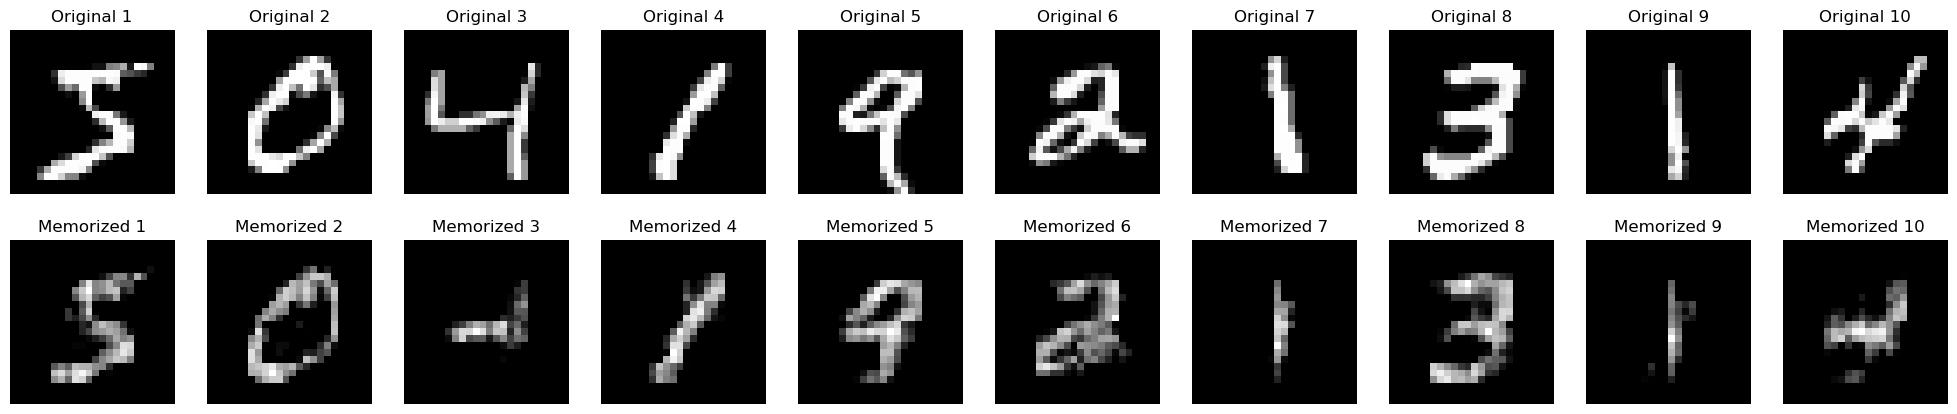

Epoch 120 | Train loss 0.004818 | Memorization loss 0.135844
Visualizing results at Epoch 121


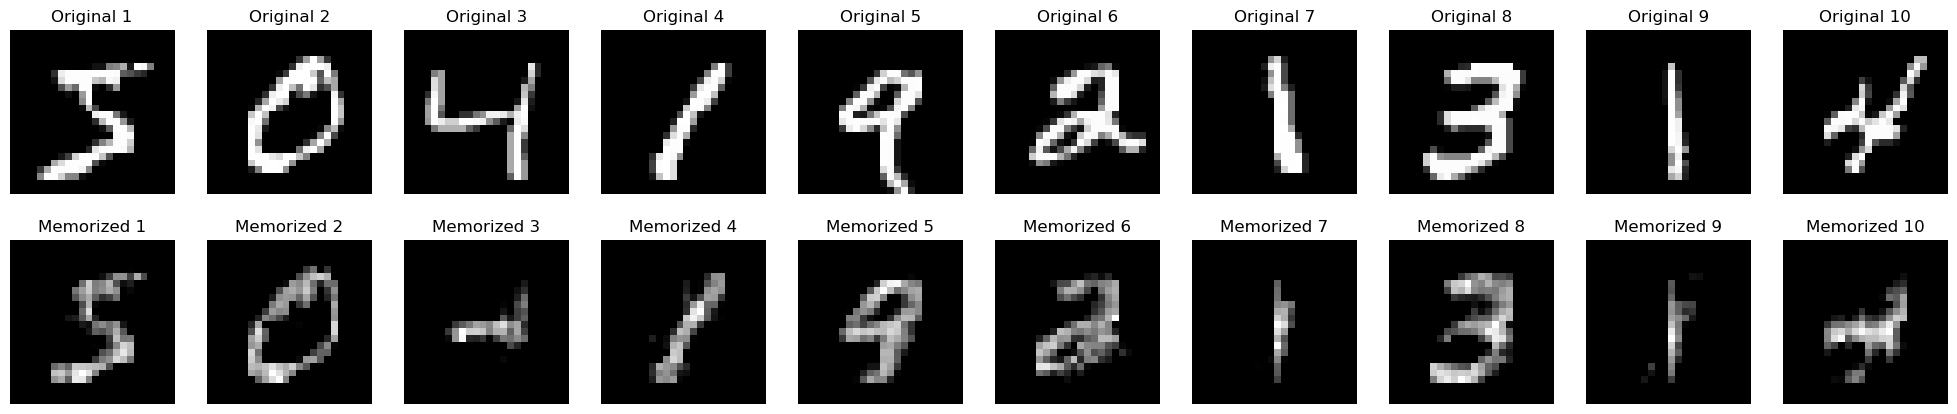

Epoch 121 | Train loss 0.004842 | Memorization loss 0.136431
Visualizing results at Epoch 122


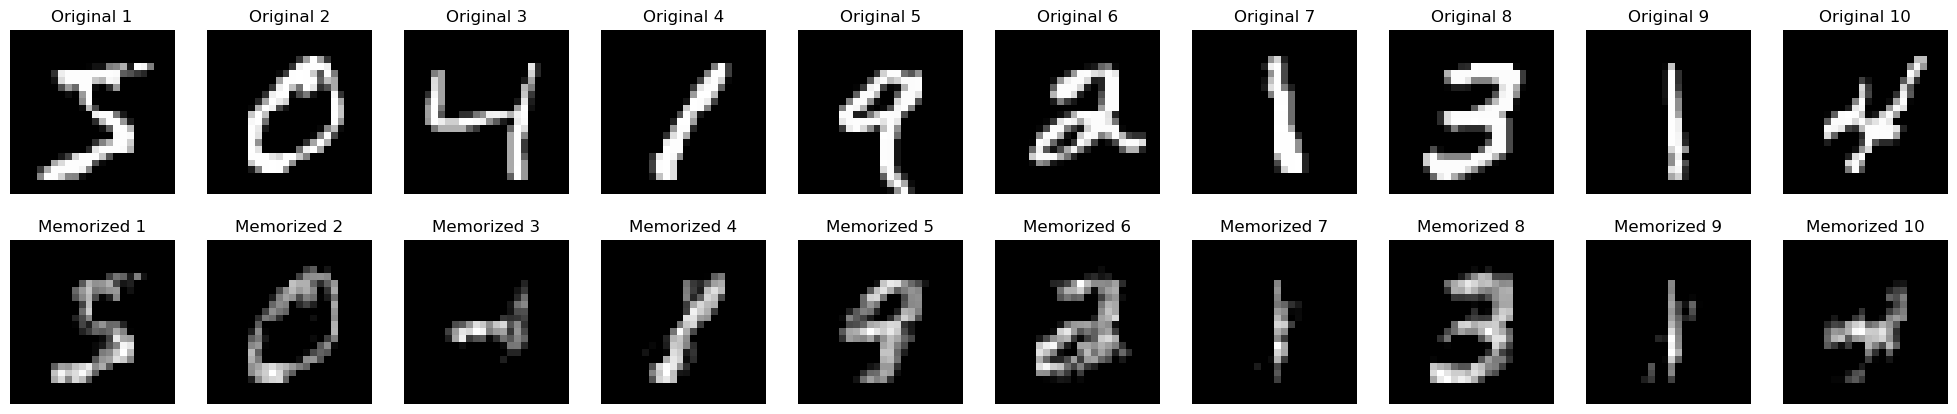

Epoch 122 | Train loss 0.004819 | Memorization loss 0.137032
Visualizing results at Epoch 123


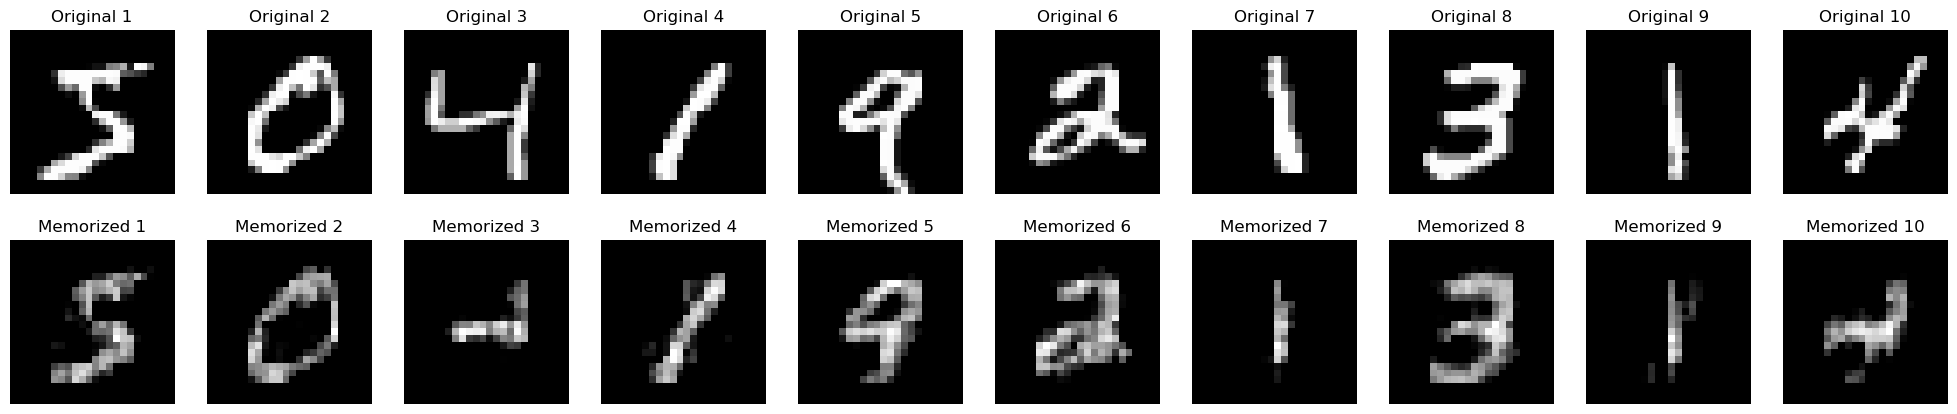

Epoch 123 | Train loss 0.004817 | Memorization loss 0.136990
Visualizing results at Epoch 124


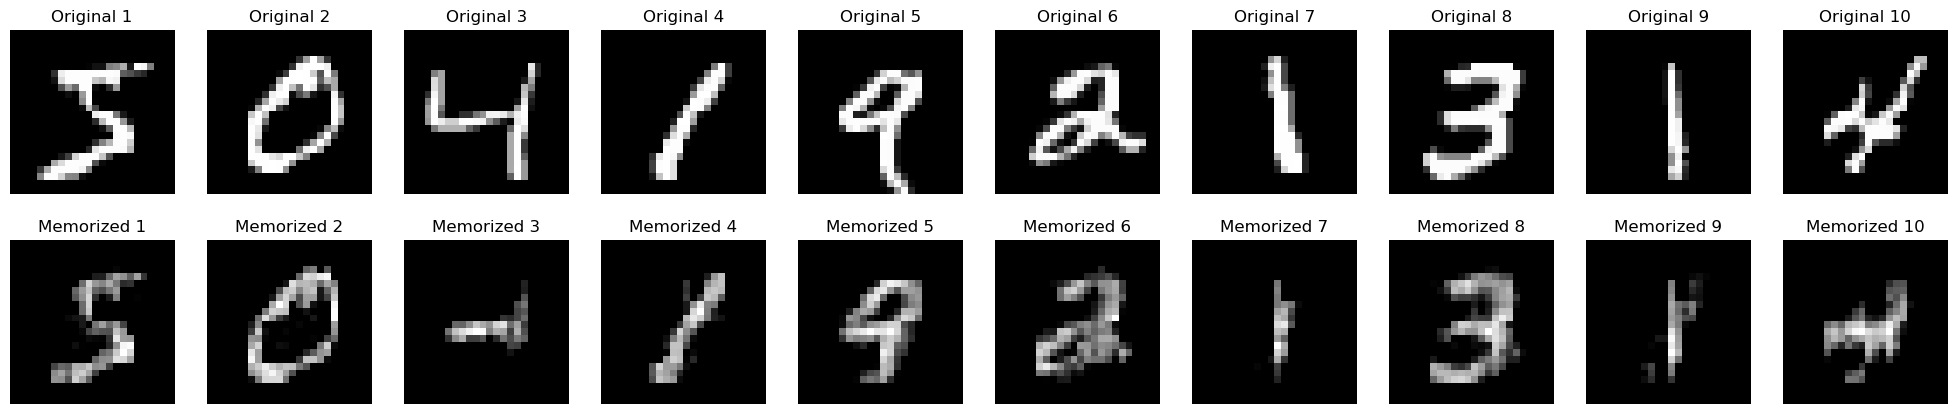

Epoch 124 | Train loss 0.004816 | Memorization loss 0.133685
Saved model and optimizer with memorization loss: 0.1337
Visualizing results at Epoch 125


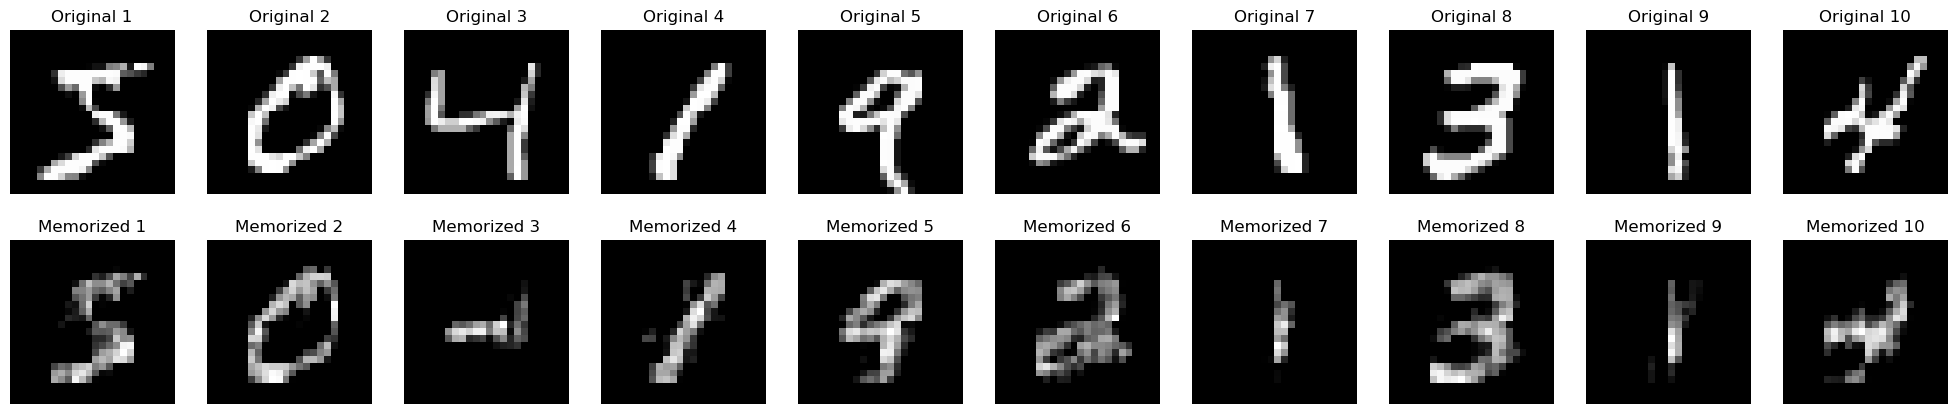

Epoch 125 | Train loss 0.004817 | Memorization loss 0.135273
Visualizing results at Epoch 126


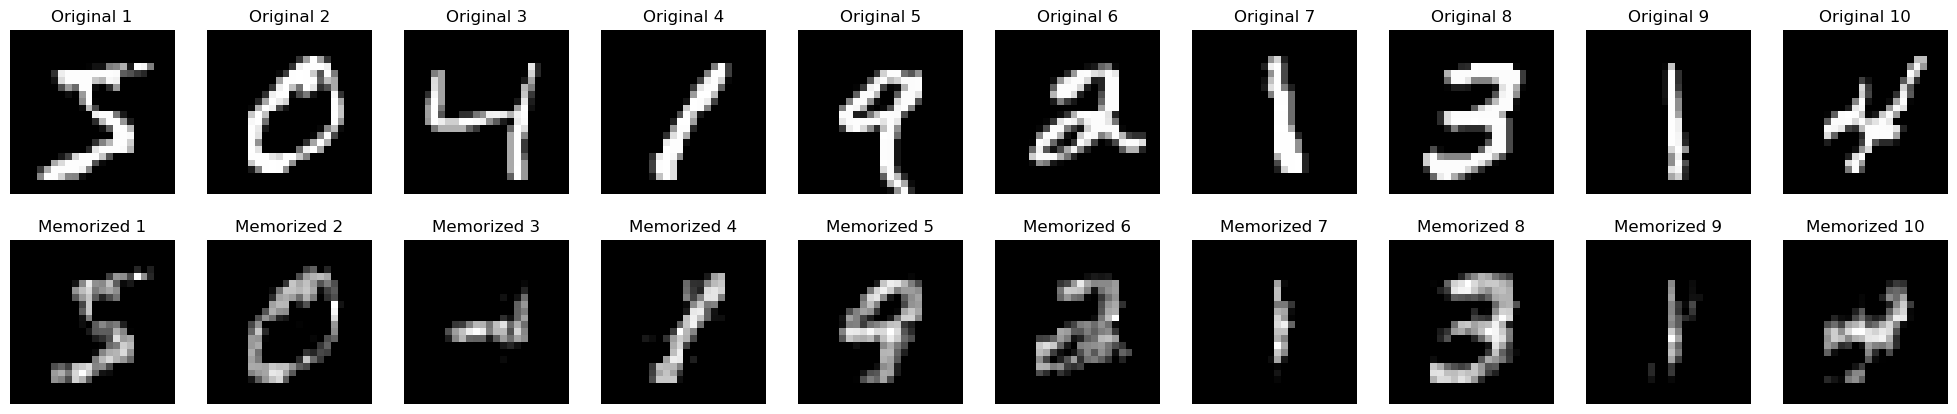

Epoch 126 | Train loss 0.004817 | Memorization loss 0.137241
Visualizing results at Epoch 127


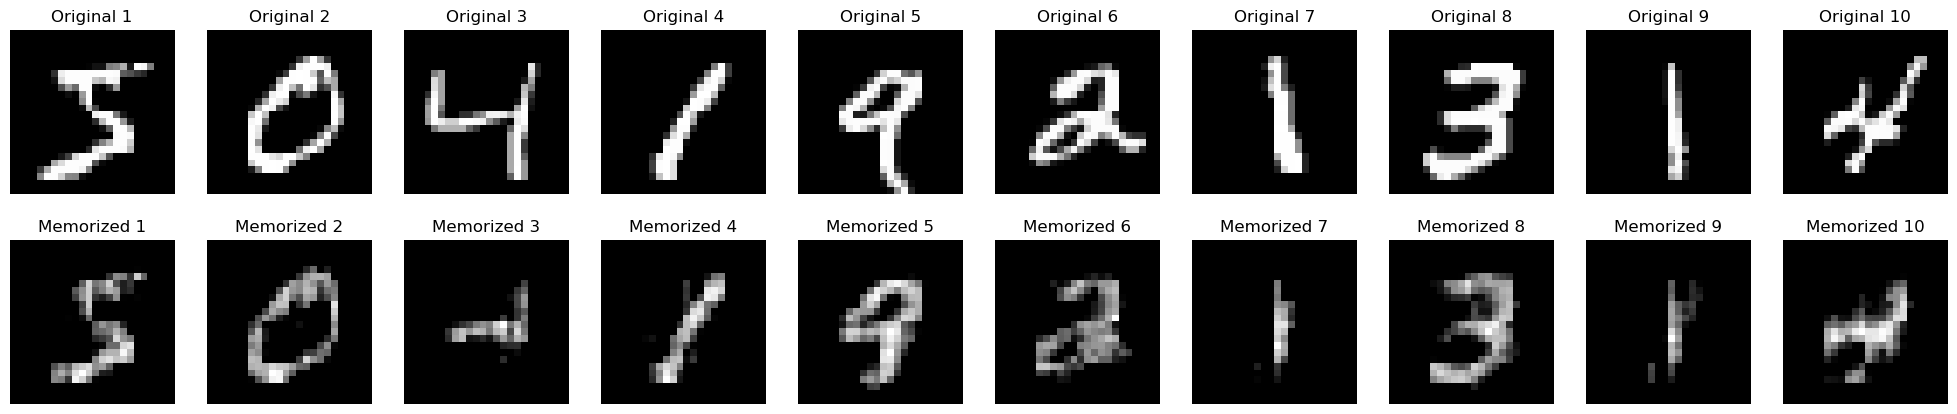

Epoch 127 | Train loss 0.004817 | Memorization loss 0.135733
Visualizing results at Epoch 128


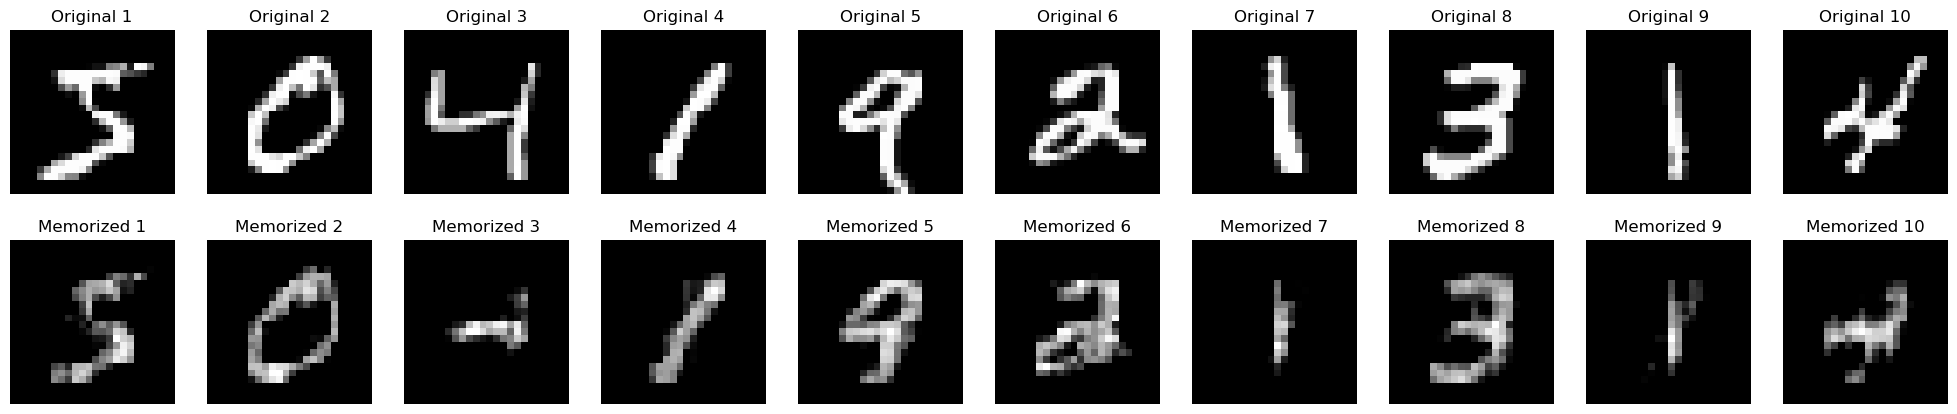

Epoch 128 | Train loss 0.004819 | Memorization loss 0.132109
Saved model and optimizer with memorization loss: 0.1321
Visualizing results at Epoch 129


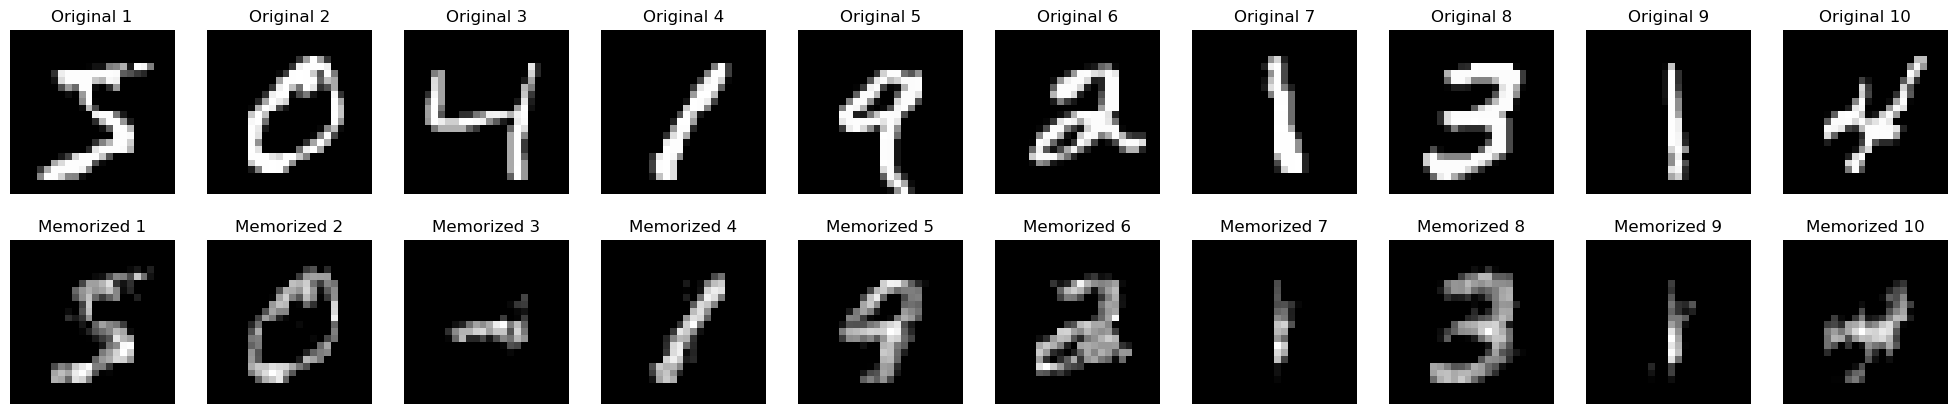

Epoch 129 | Train loss 0.004819 | Memorization loss 0.133762
Visualizing results at Epoch 130


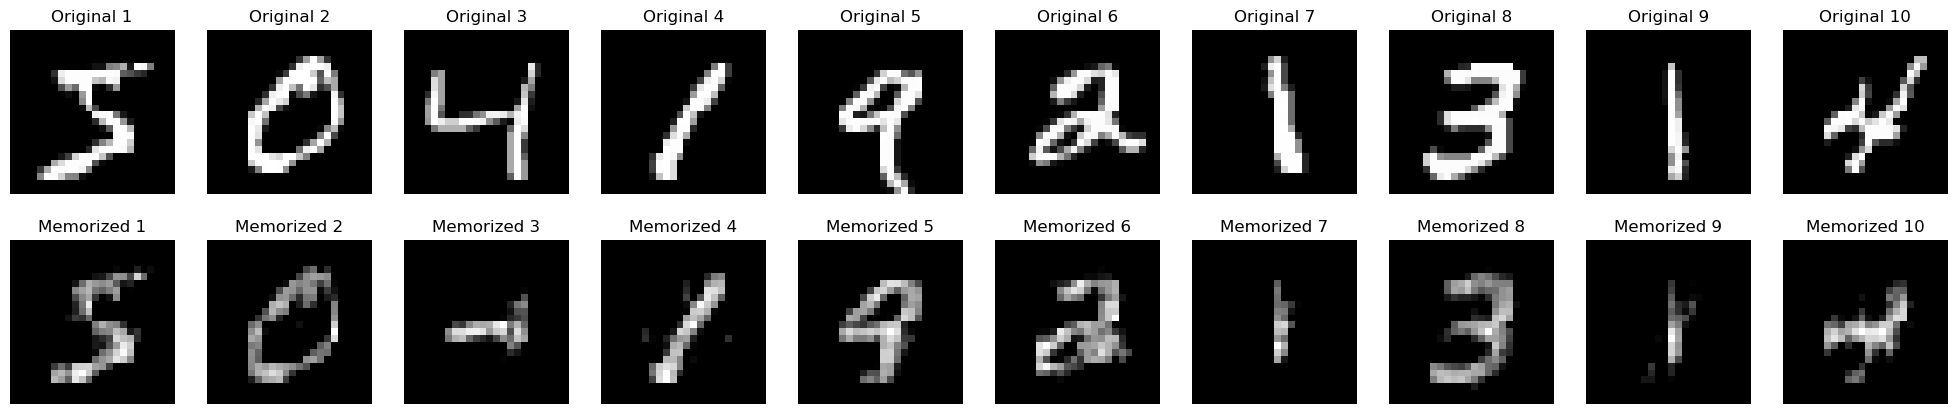

Epoch 130 | Train loss 0.004816 | Memorization loss 0.134180
Visualizing results at Epoch 131


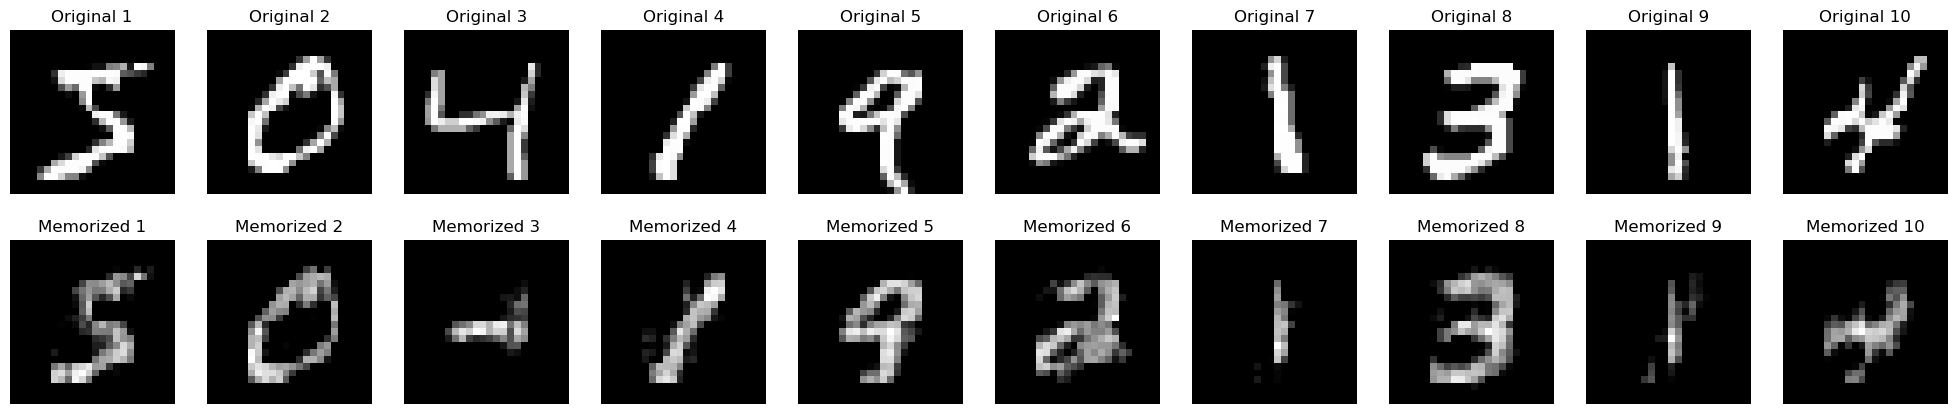

Epoch 131 | Train loss 0.004819 | Memorization loss 0.134295
Visualizing results at Epoch 132


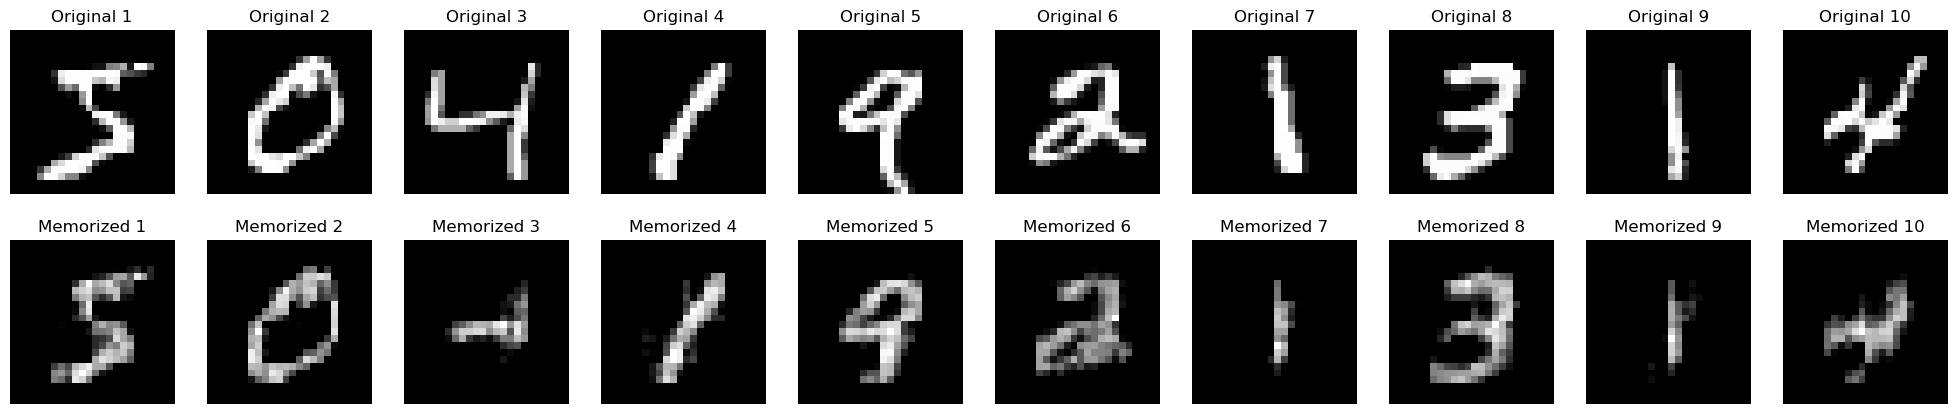

Epoch 132 | Train loss 0.004817 | Memorization loss 0.130429
Saved model and optimizer with memorization loss: 0.1304
Visualizing results at Epoch 133


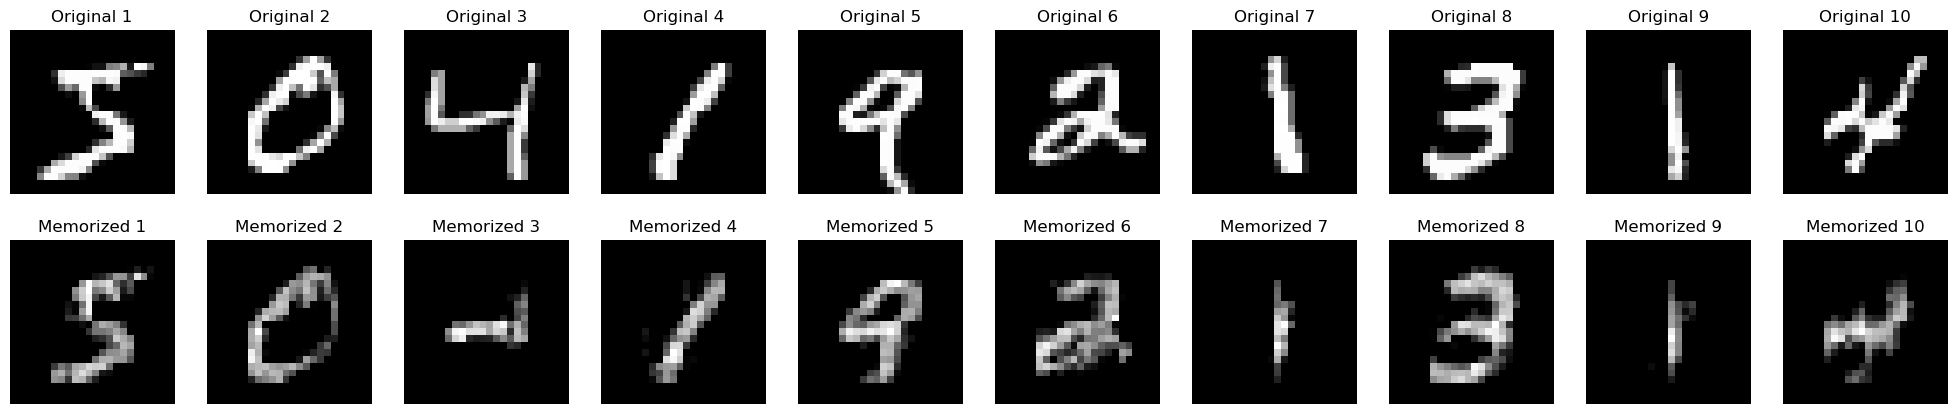

Epoch 133 | Train loss 0.004818 | Memorization loss 0.130372
Saved model and optimizer with memorization loss: 0.1304
Visualizing results at Epoch 134


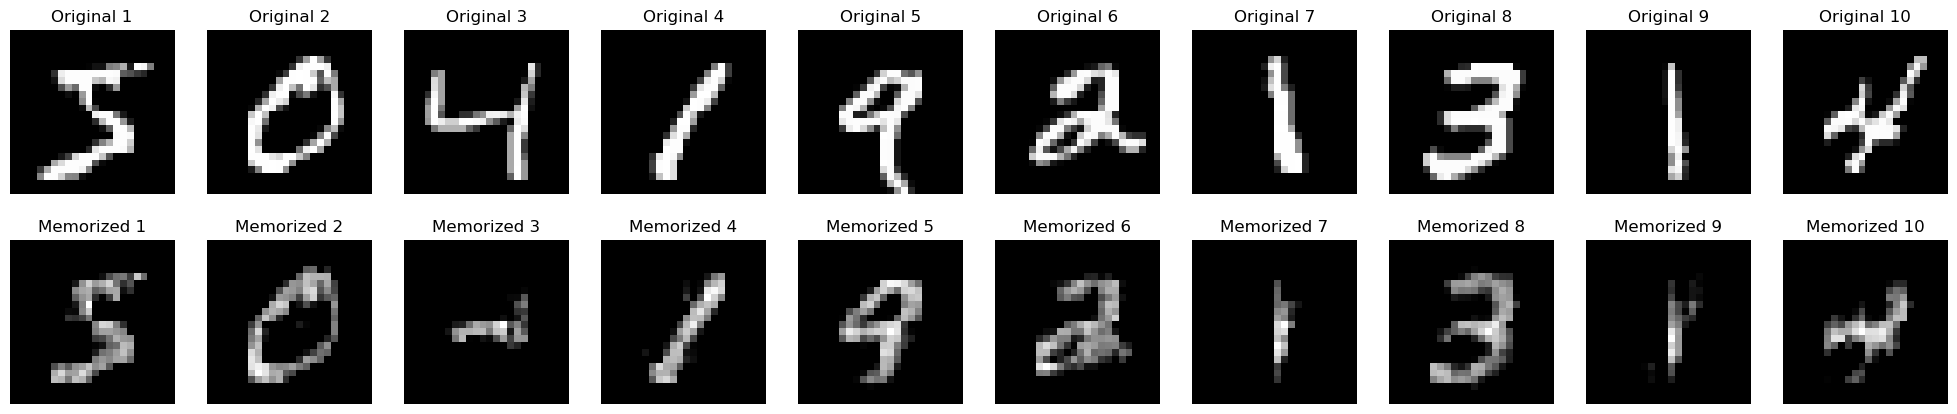

Epoch 134 | Train loss 0.004849 | Memorization loss 0.132687
Visualizing results at Epoch 135


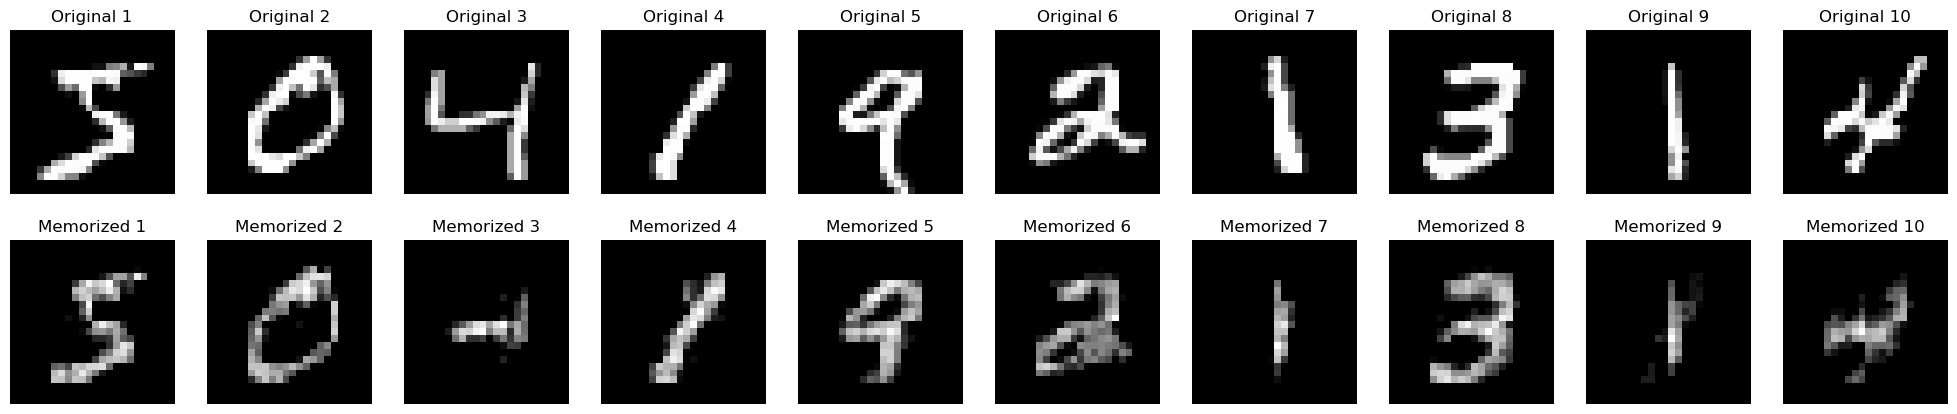

Epoch 135 | Train loss 0.004820 | Memorization loss 0.135375
Visualizing results at Epoch 136


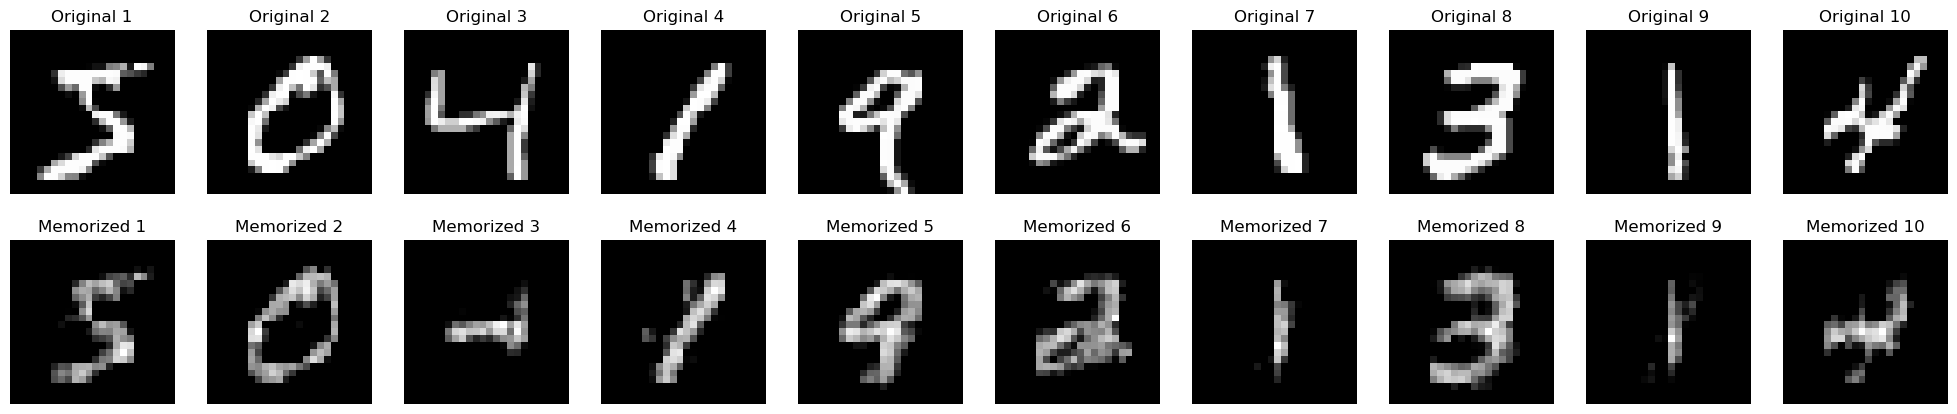

Epoch 136 | Train loss 0.004816 | Memorization loss 0.130043
Saved model and optimizer with memorization loss: 0.1300
Visualizing results at Epoch 137


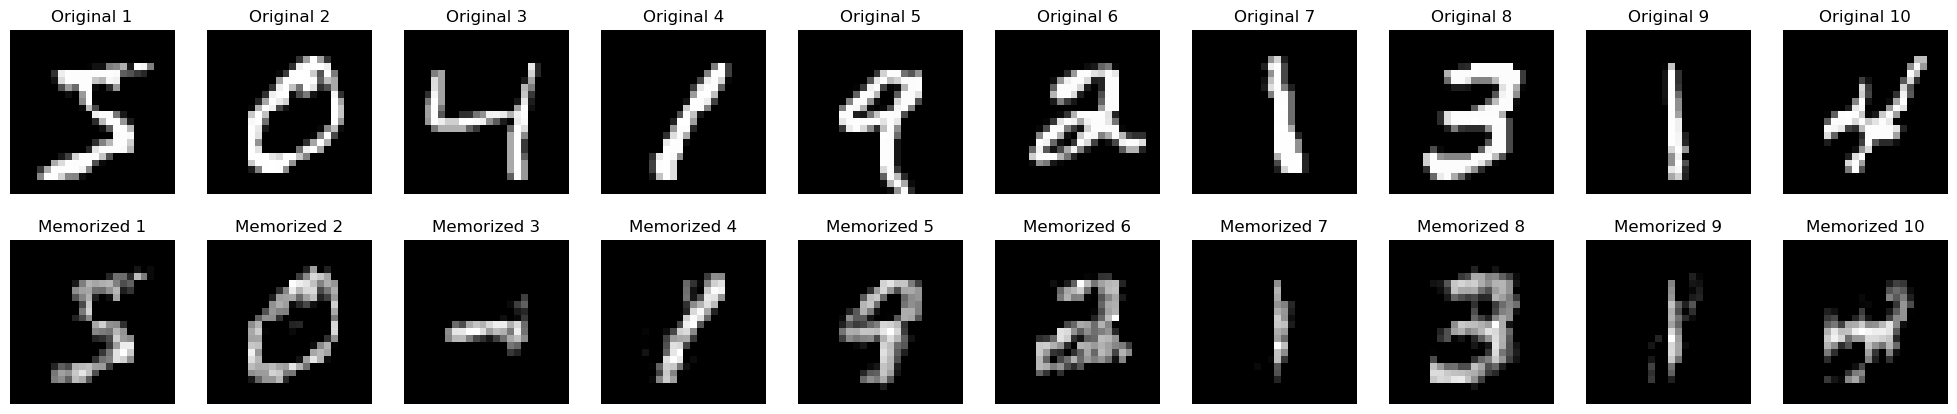

Epoch 137 | Train loss 0.004818 | Memorization loss 0.129499
Saved model and optimizer with memorization loss: 0.1295
Visualizing results at Epoch 138


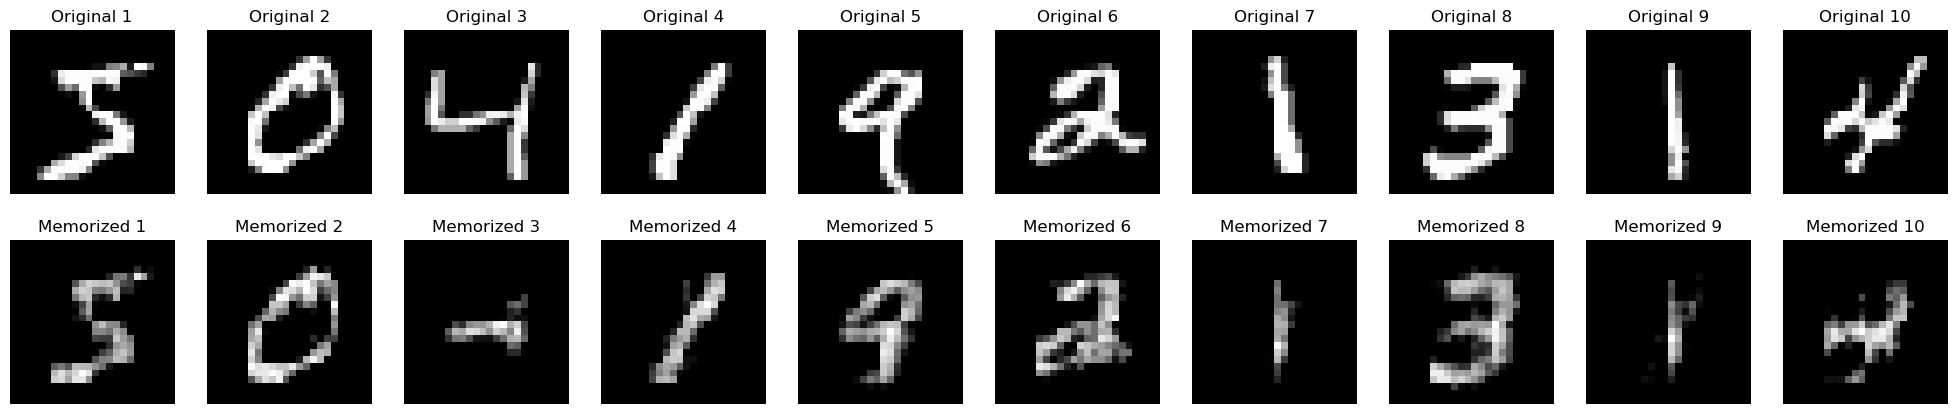

Epoch 138 | Train loss 0.004816 | Memorization loss 0.130695
Visualizing results at Epoch 139


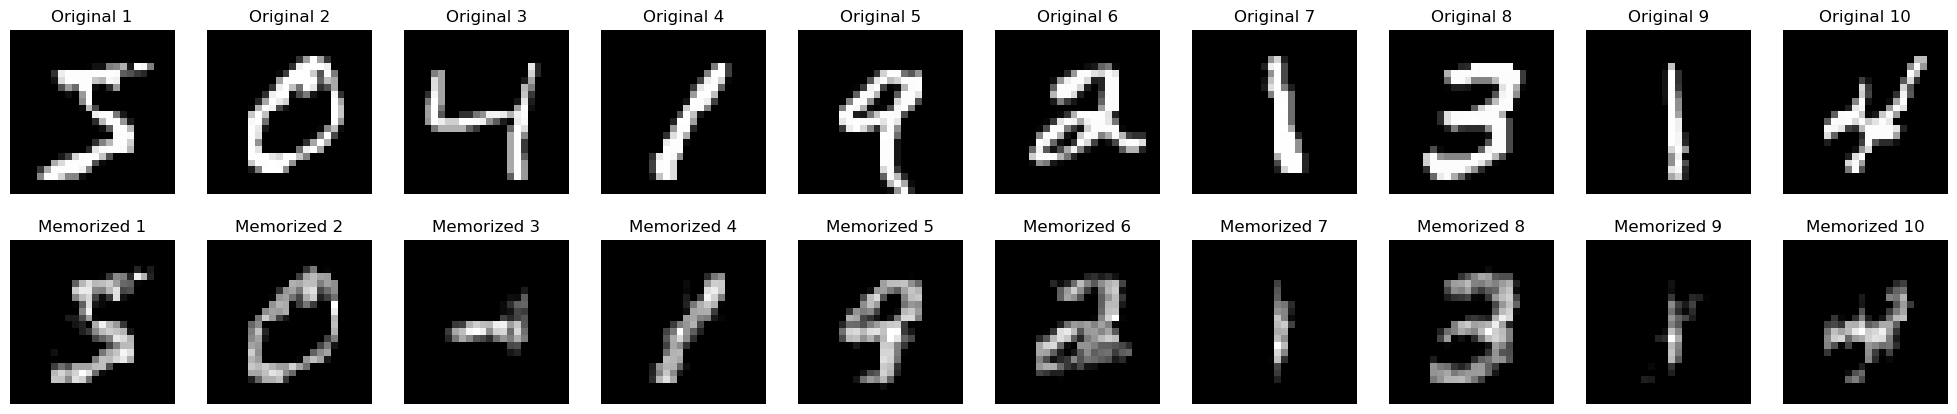

Epoch 139 | Train loss 0.004818 | Memorization loss 0.130993
Visualizing results at Epoch 140


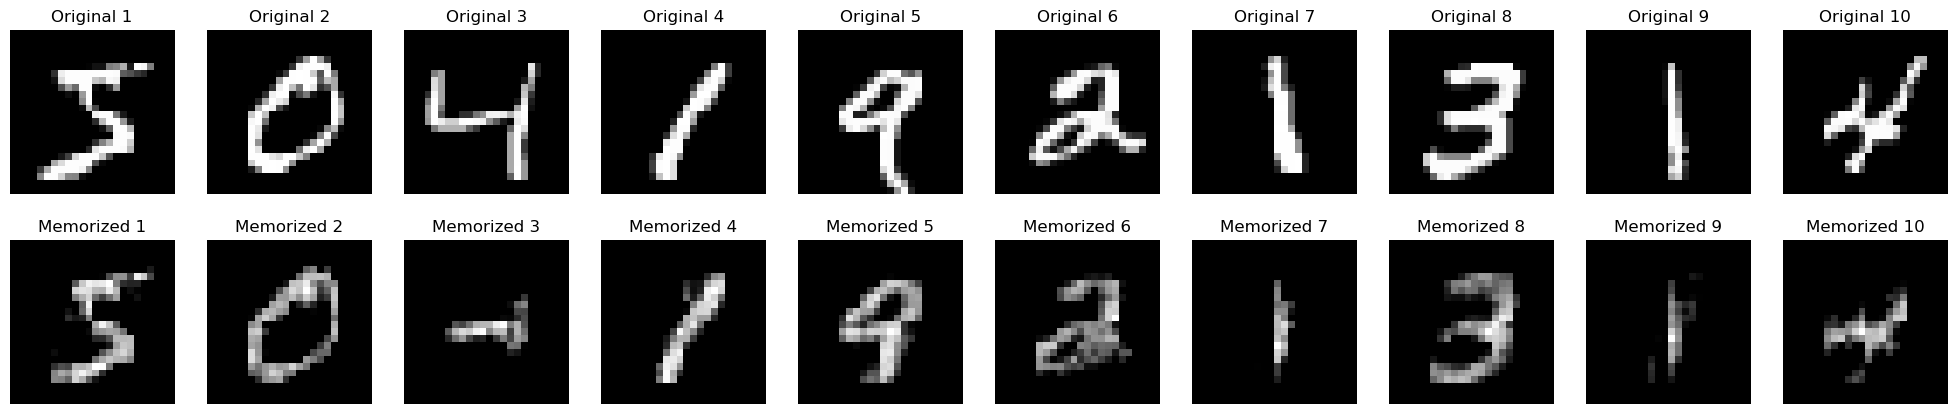

Epoch 140 | Train loss 0.004817 | Memorization loss 0.129967
Visualizing results at Epoch 141


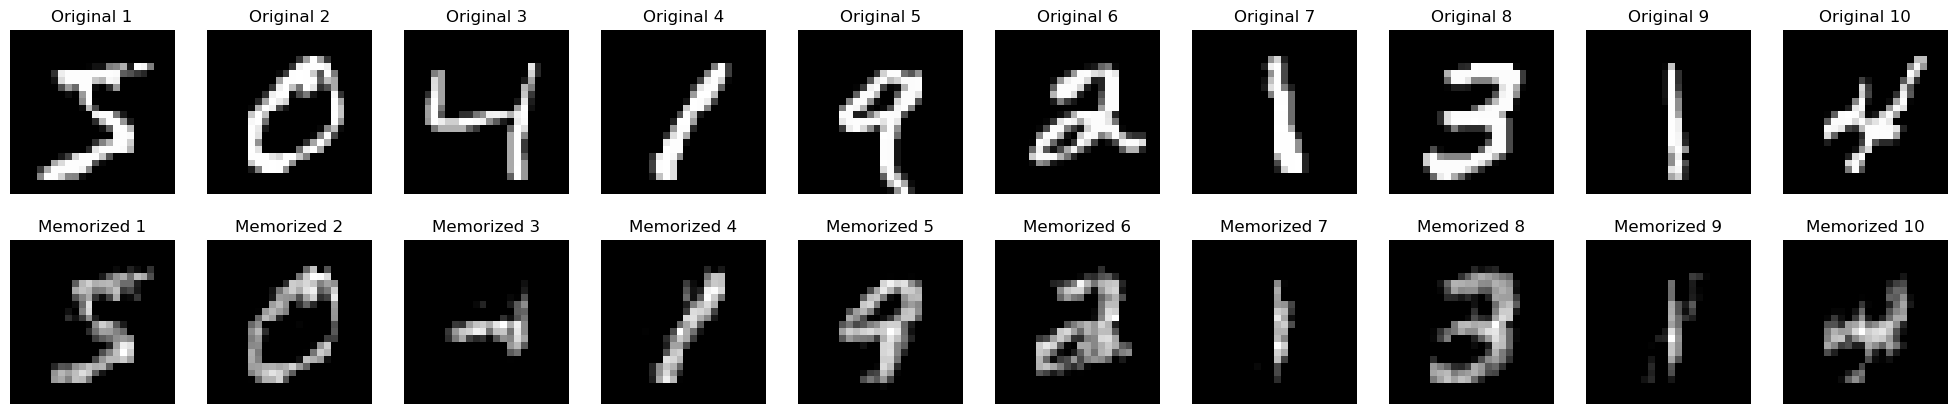

Epoch 141 | Train loss 0.004817 | Memorization loss 0.127504
Saved model and optimizer with memorization loss: 0.1275
Visualizing results at Epoch 142


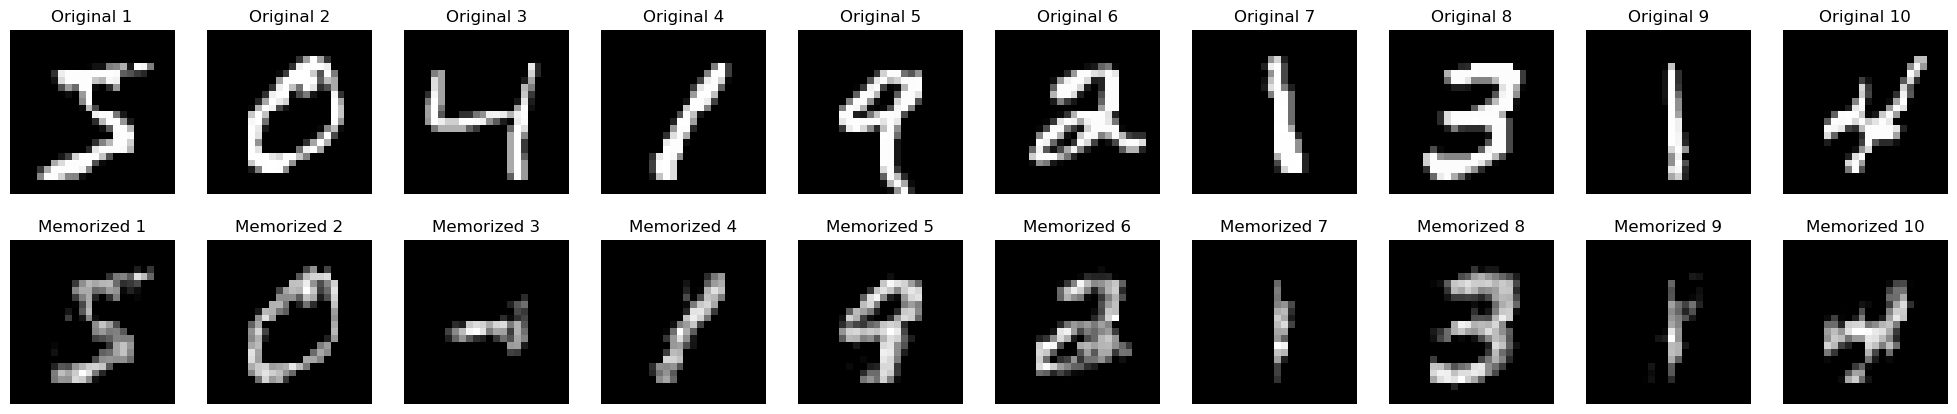

Epoch 142 | Train loss 0.004817 | Memorization loss 0.129866
Visualizing results at Epoch 143


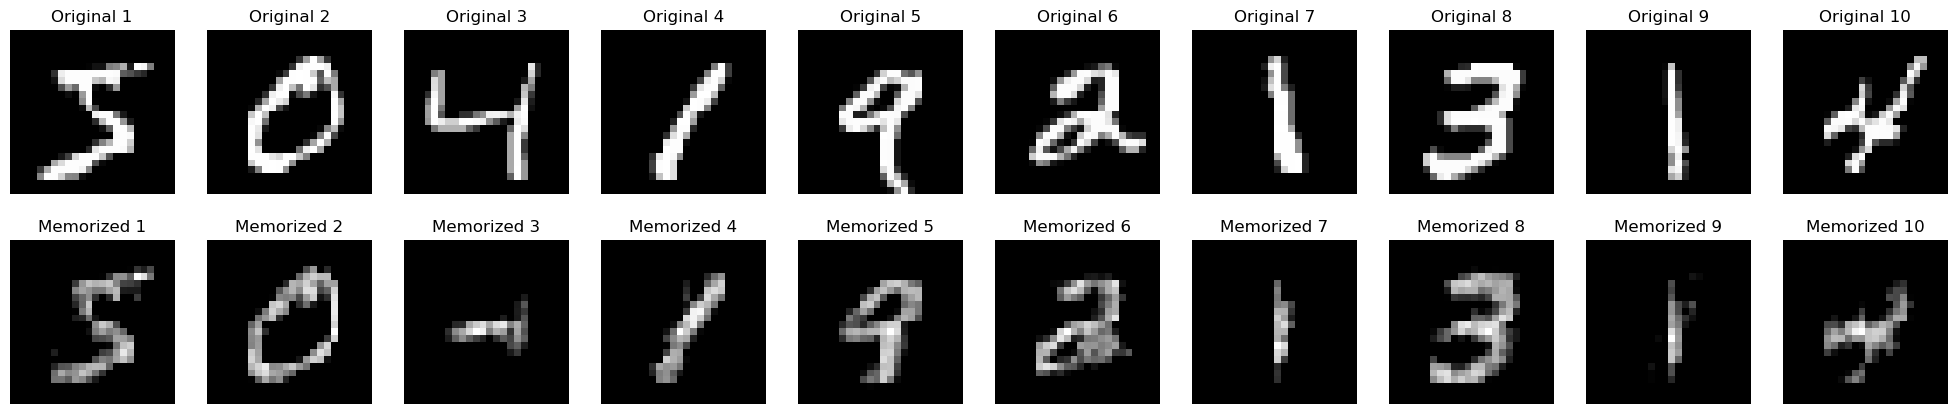

Epoch 143 | Train loss 0.004825 | Memorization loss 0.130711
Visualizing results at Epoch 144


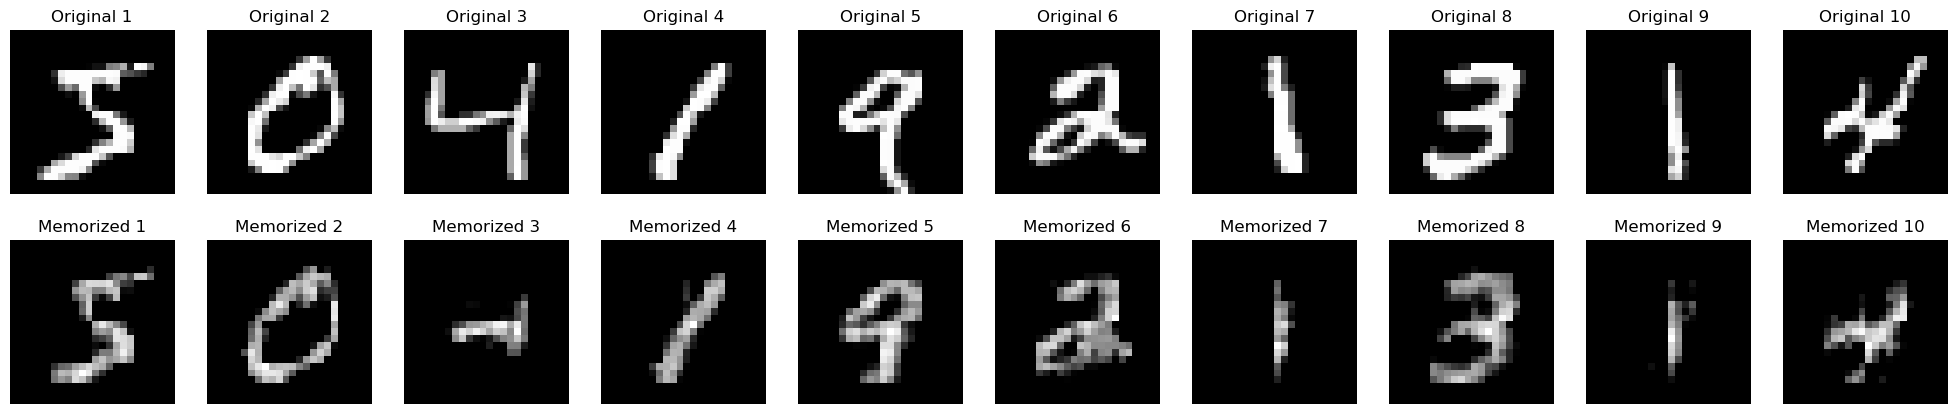

Epoch 144 | Train loss 0.004830 | Memorization loss 0.128433
Visualizing results at Epoch 145


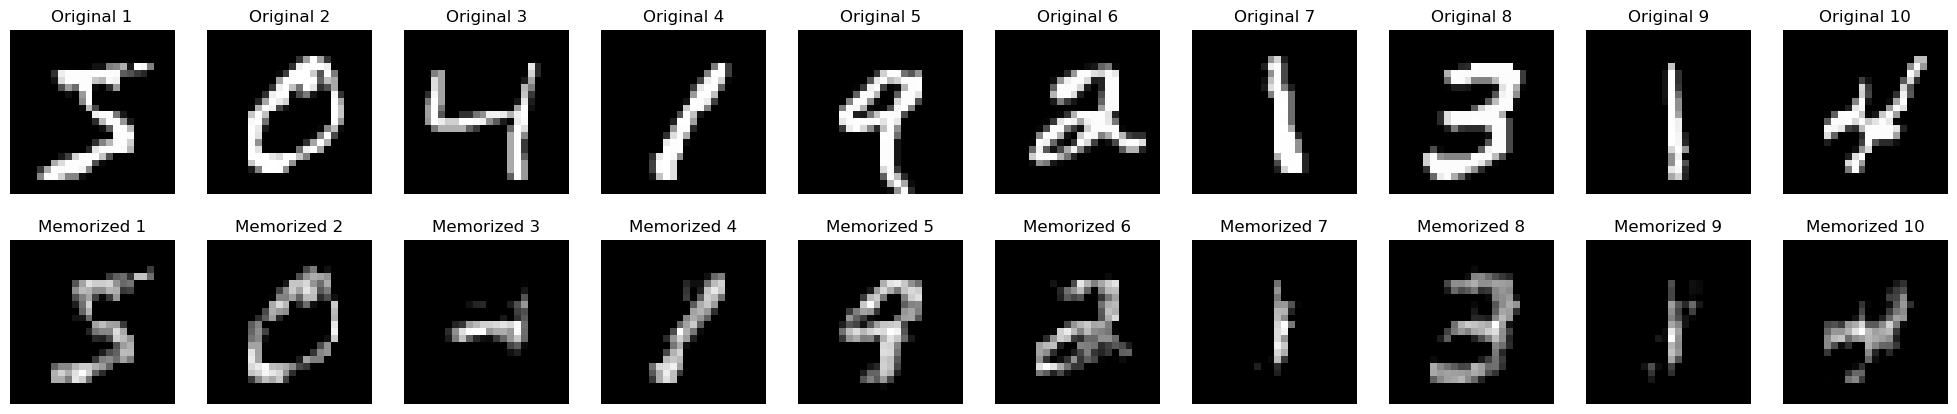

Epoch 145 | Train loss 0.004818 | Memorization loss 0.125570
Saved model and optimizer with memorization loss: 0.1256
Visualizing results at Epoch 146


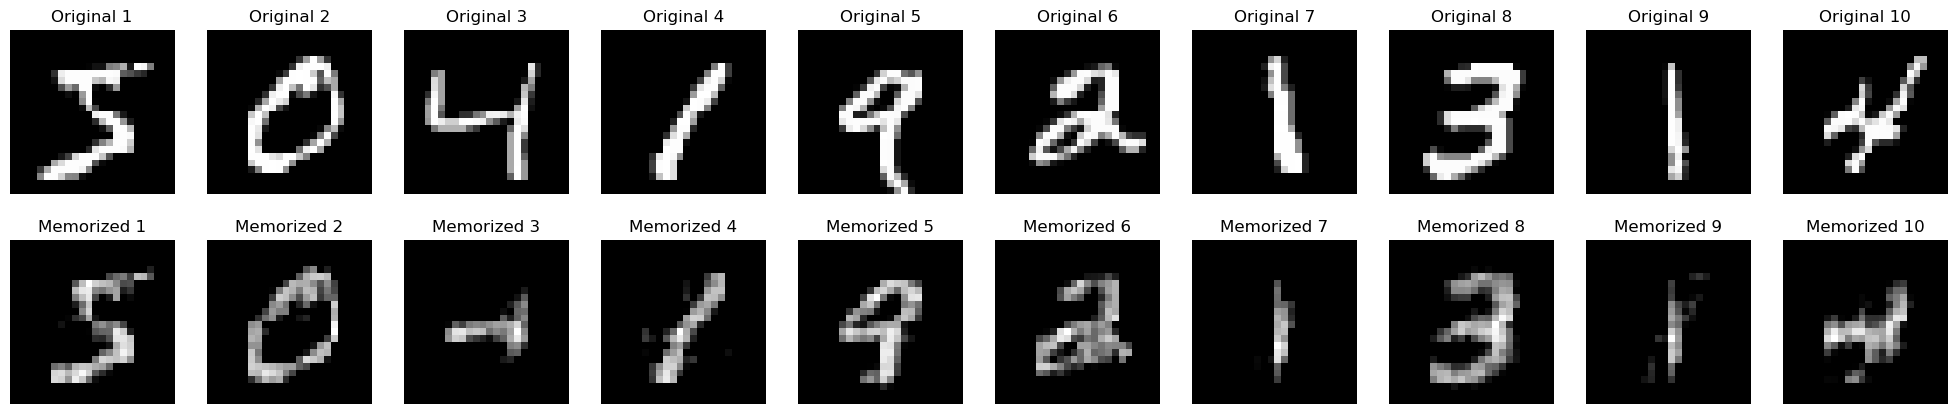

Epoch 146 | Train loss 0.004817 | Memorization loss 0.126007
Visualizing results at Epoch 147


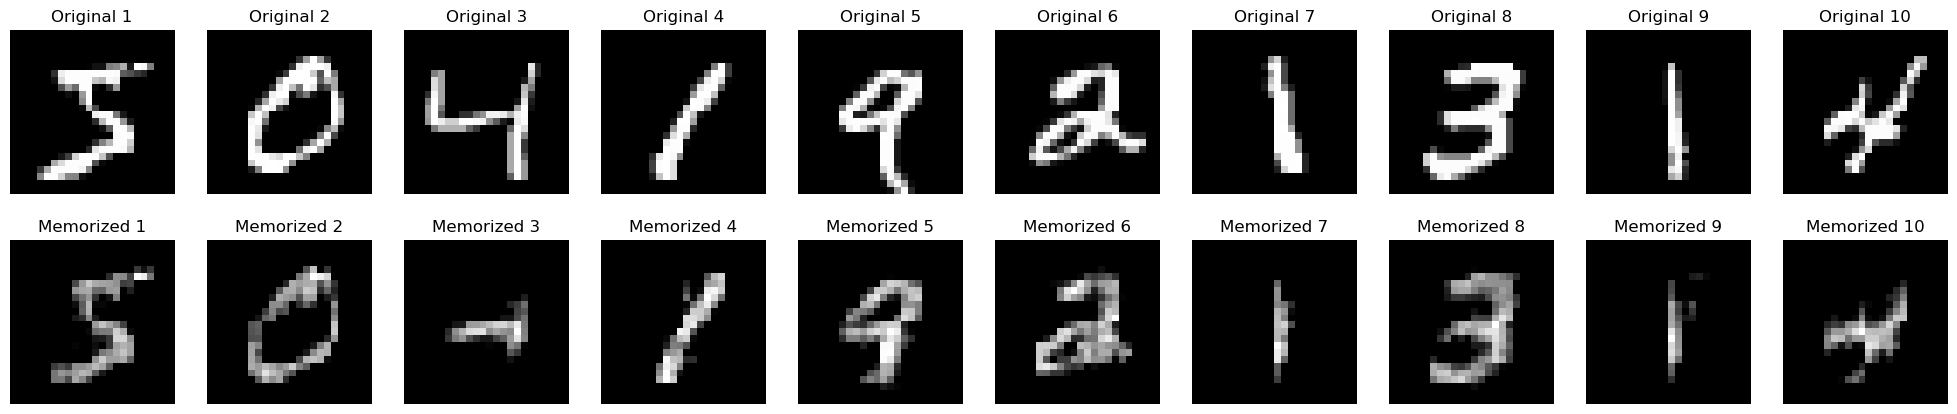

Epoch 147 | Train loss 0.004820 | Memorization loss 0.127519
Visualizing results at Epoch 148


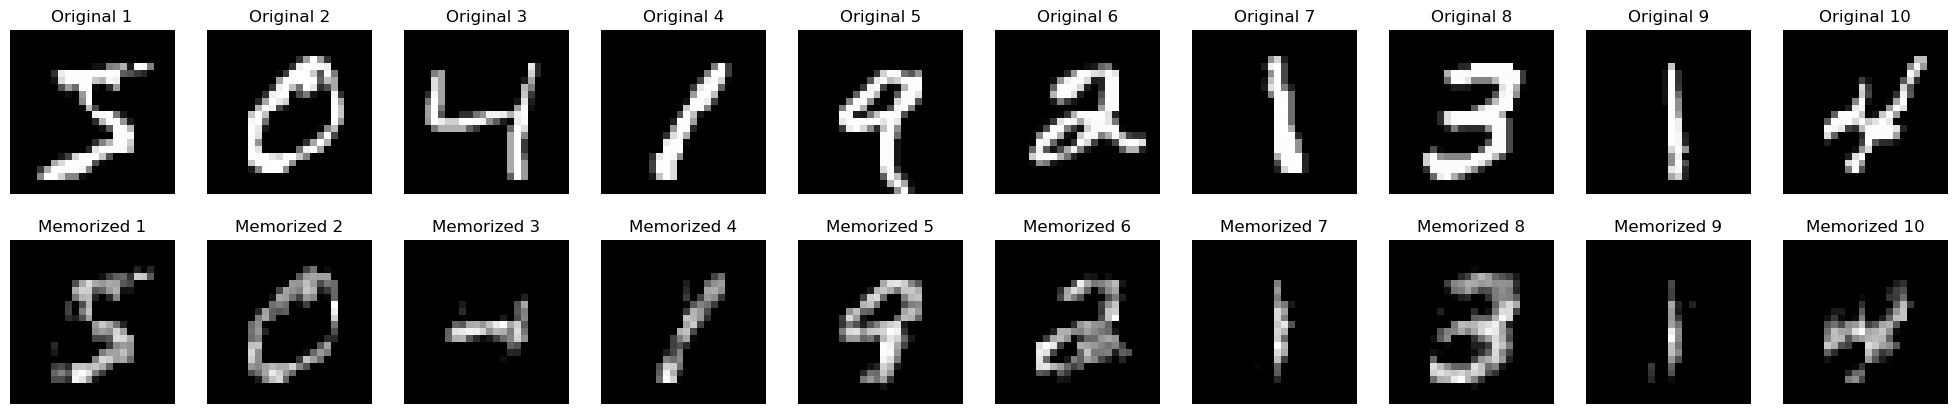

Epoch 148 | Train loss 0.004816 | Memorization loss 0.129478
Visualizing results at Epoch 149


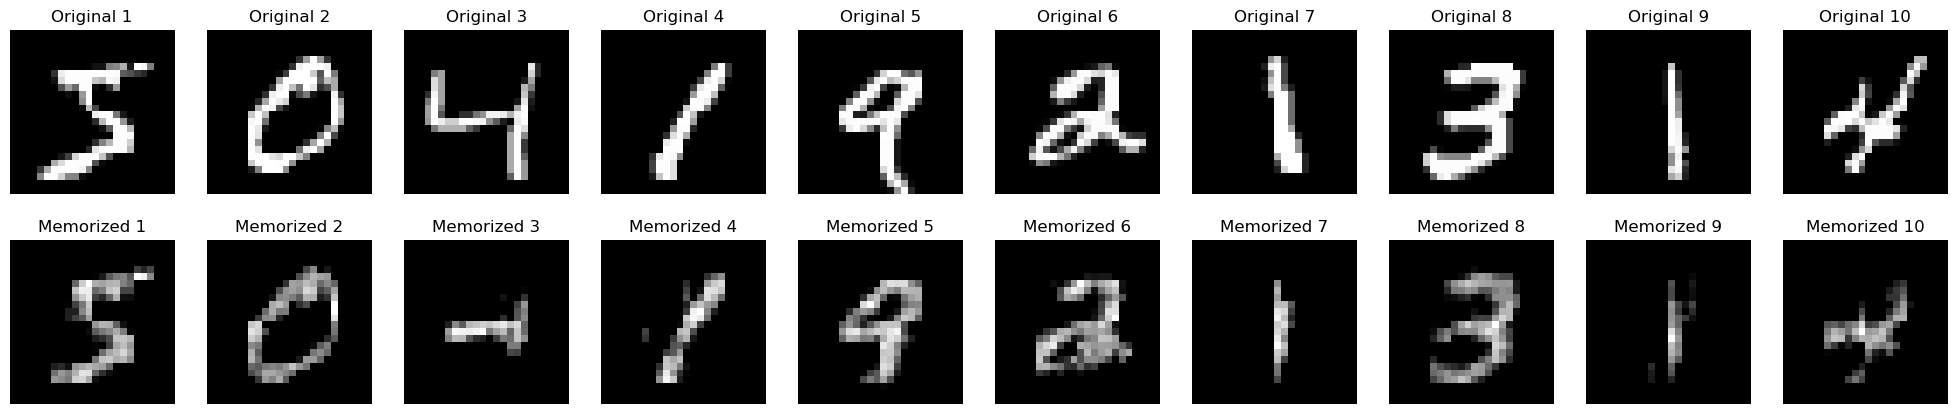

Epoch 149 | Train loss 0.004815 | Memorization loss 0.124901
Saved model and optimizer with memorization loss: 0.1249
Visualizing results at Epoch 150


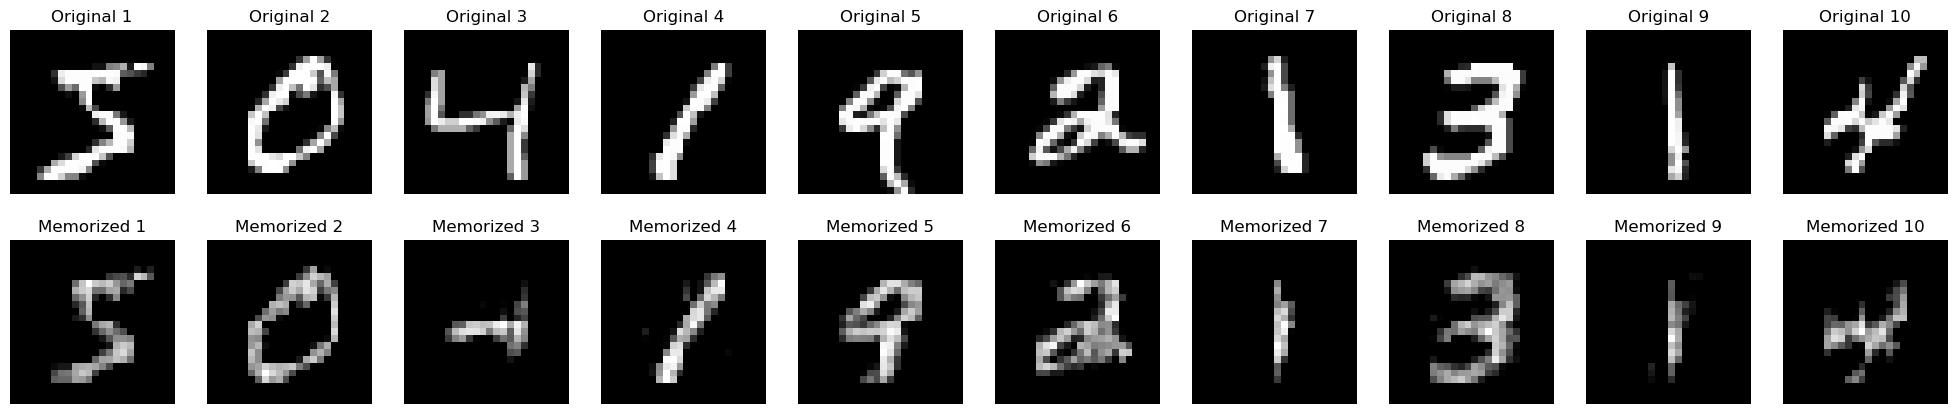

Epoch 150 | Train loss 0.004815 | Memorization loss 0.124114
Saved model and optimizer with memorization loss: 0.1241
Visualizing results at Epoch 151


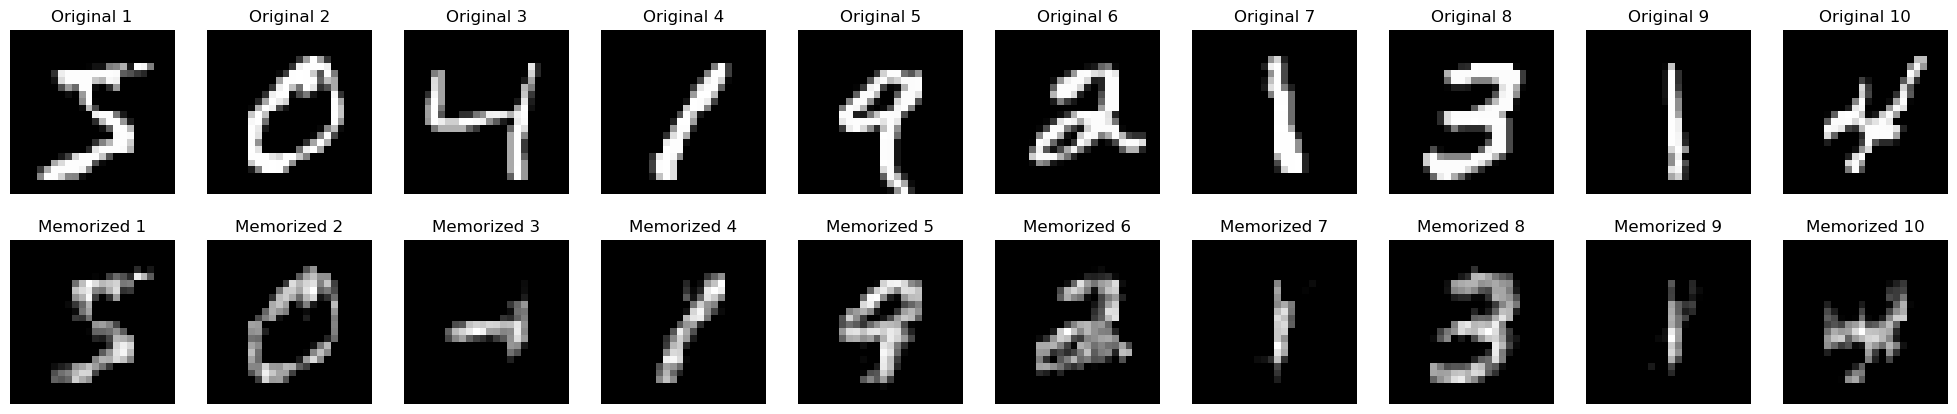

Epoch 151 | Train loss 0.004815 | Memorization loss 0.124922
Visualizing results at Epoch 152


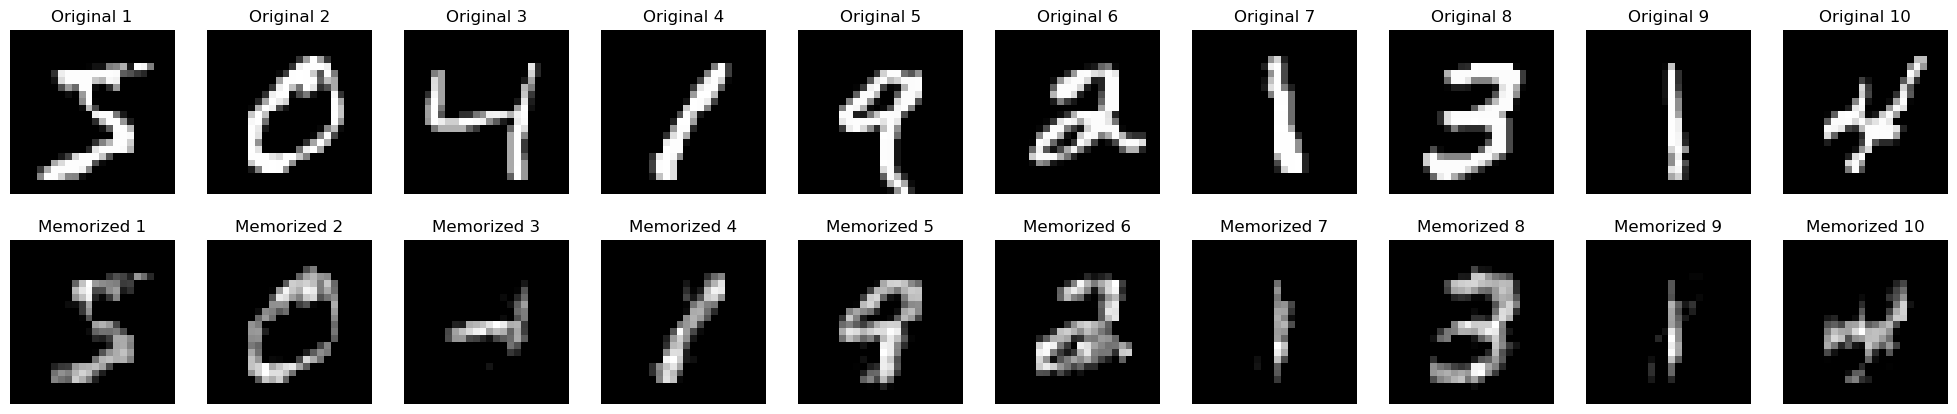

Epoch 152 | Train loss 0.004817 | Memorization loss 0.127176
Visualizing results at Epoch 153


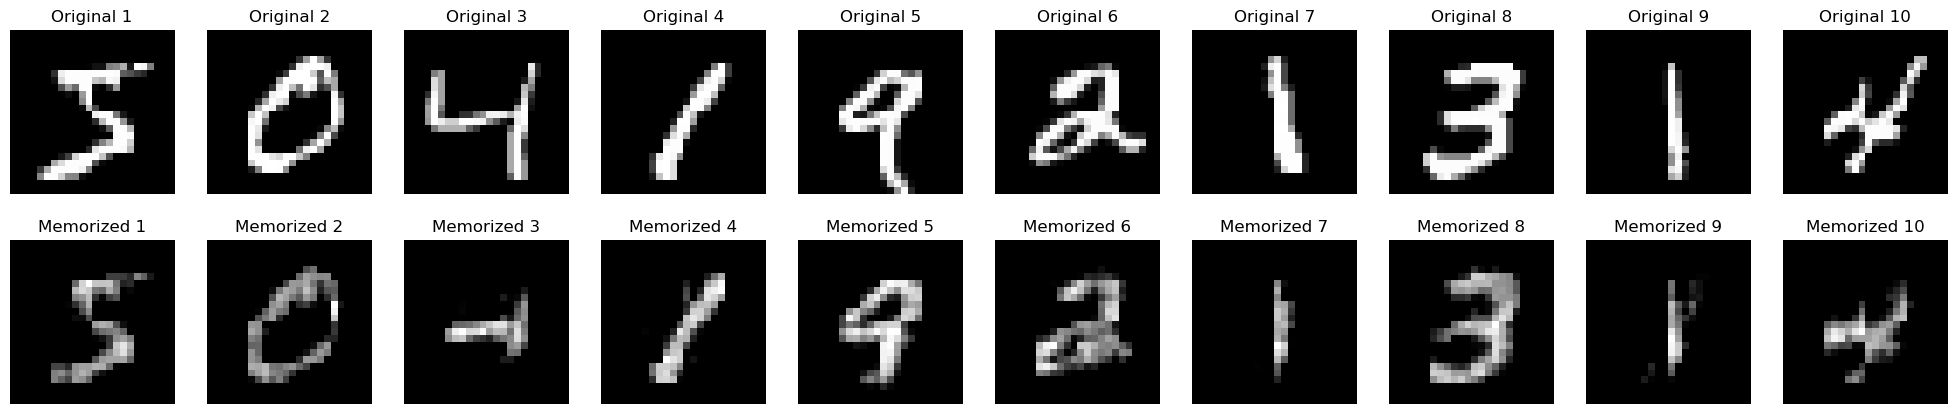

Epoch 153 | Train loss 0.004816 | Memorization loss 0.125332
Visualizing results at Epoch 154


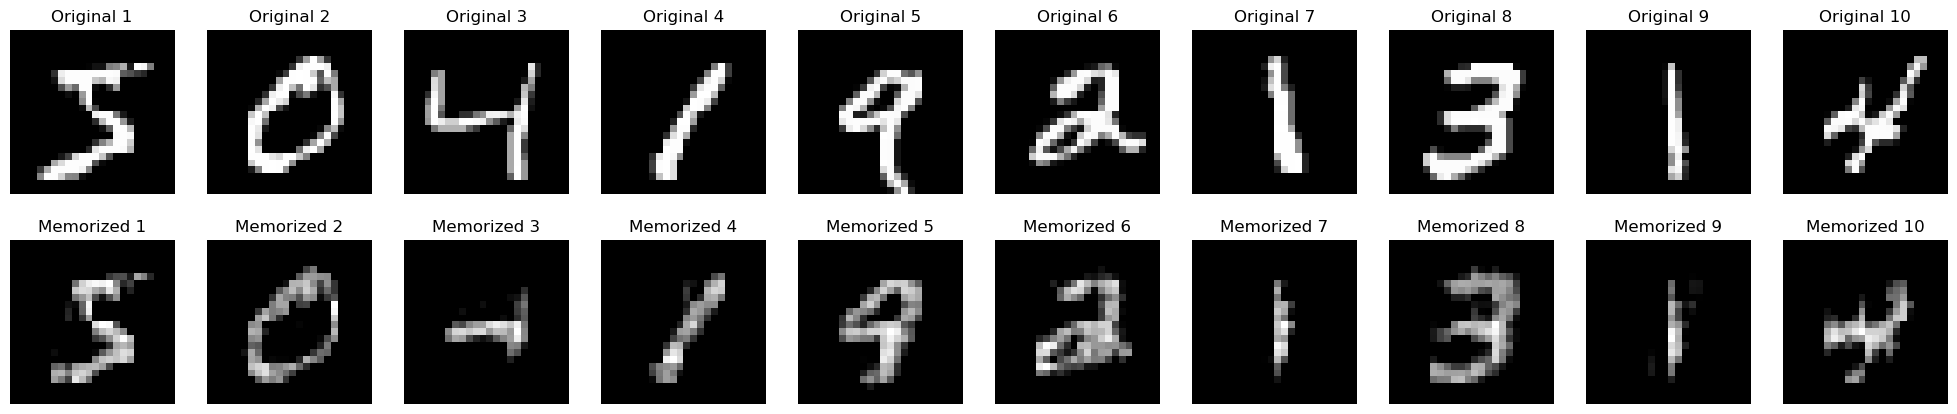

Epoch 154 | Train loss 0.004835 | Memorization loss 0.123664
Saved model and optimizer with memorization loss: 0.1237
Visualizing results at Epoch 155


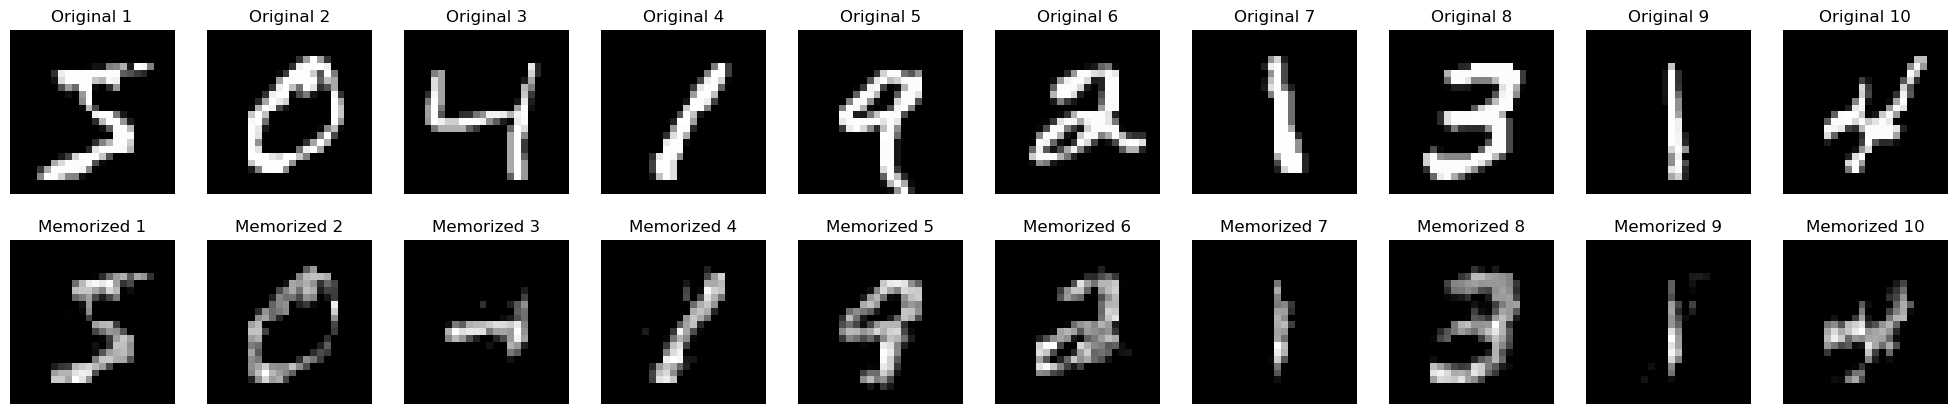

Epoch 155 | Train loss 0.004827 | Memorization loss 0.124321
Visualizing results at Epoch 156


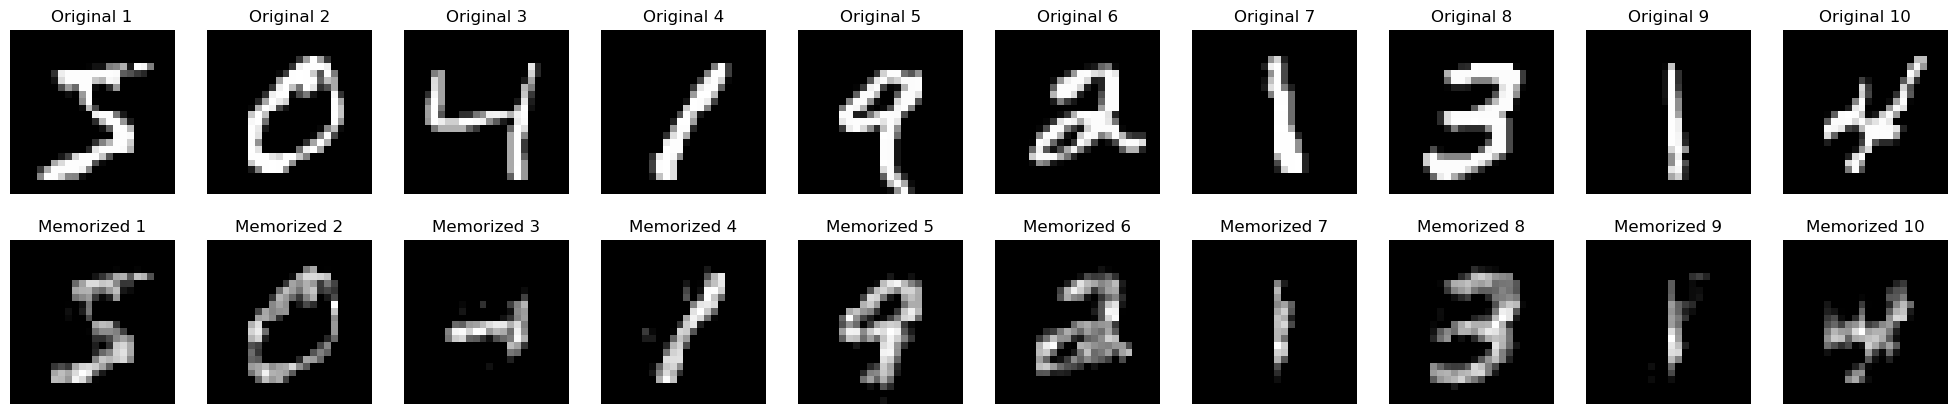

Epoch 156 | Train loss 0.004817 | Memorization loss 0.125560
Visualizing results at Epoch 157


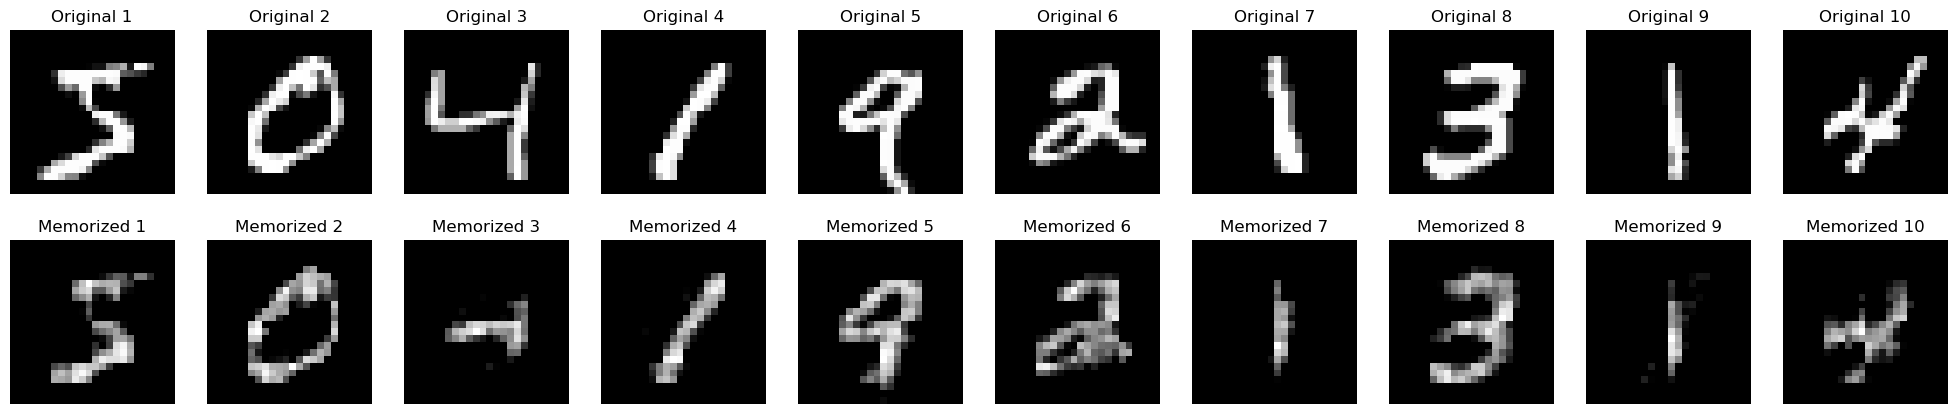

Epoch 157 | Train loss 0.004816 | Memorization loss 0.123286
Saved model and optimizer with memorization loss: 0.1233
Visualizing results at Epoch 158


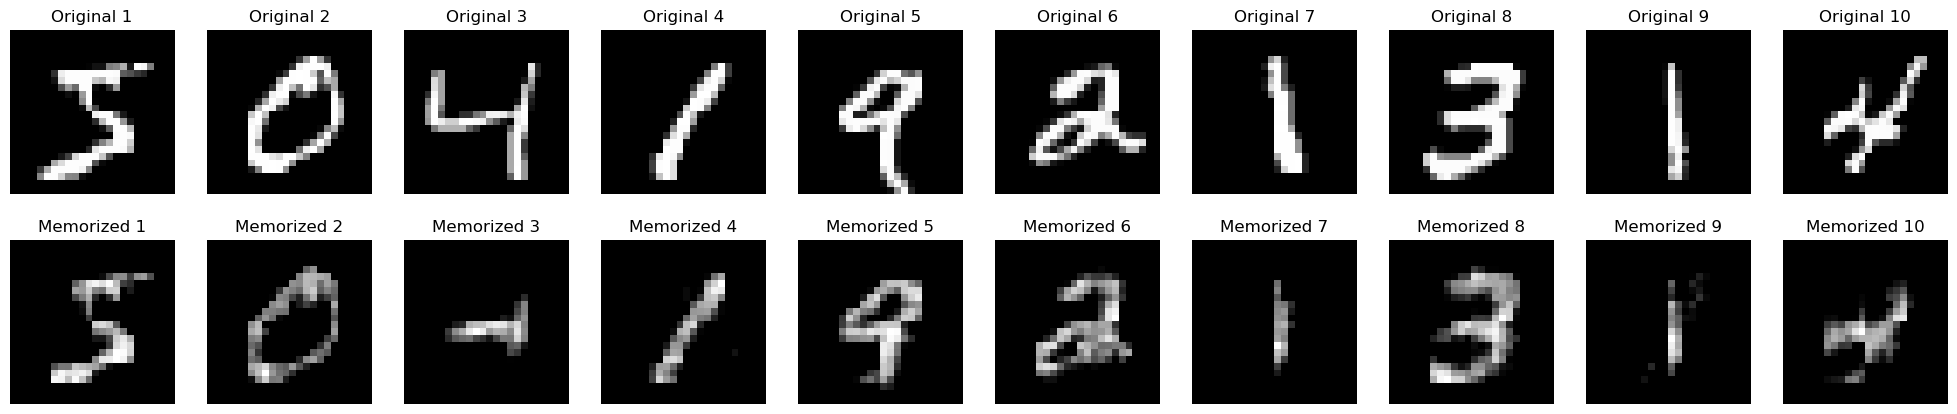

Epoch 158 | Train loss 0.004816 | Memorization loss 0.121506
Saved model and optimizer with memorization loss: 0.1215
Visualizing results at Epoch 159


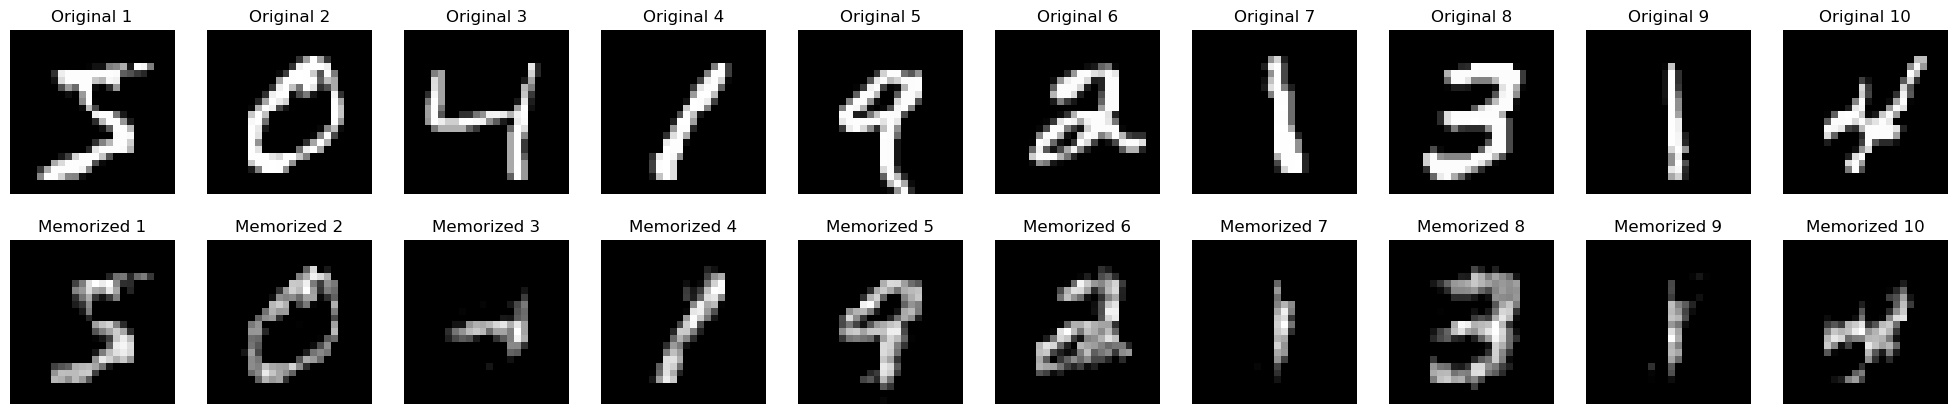

Epoch 159 | Train loss 0.004817 | Memorization loss 0.121759
Visualizing results at Epoch 160


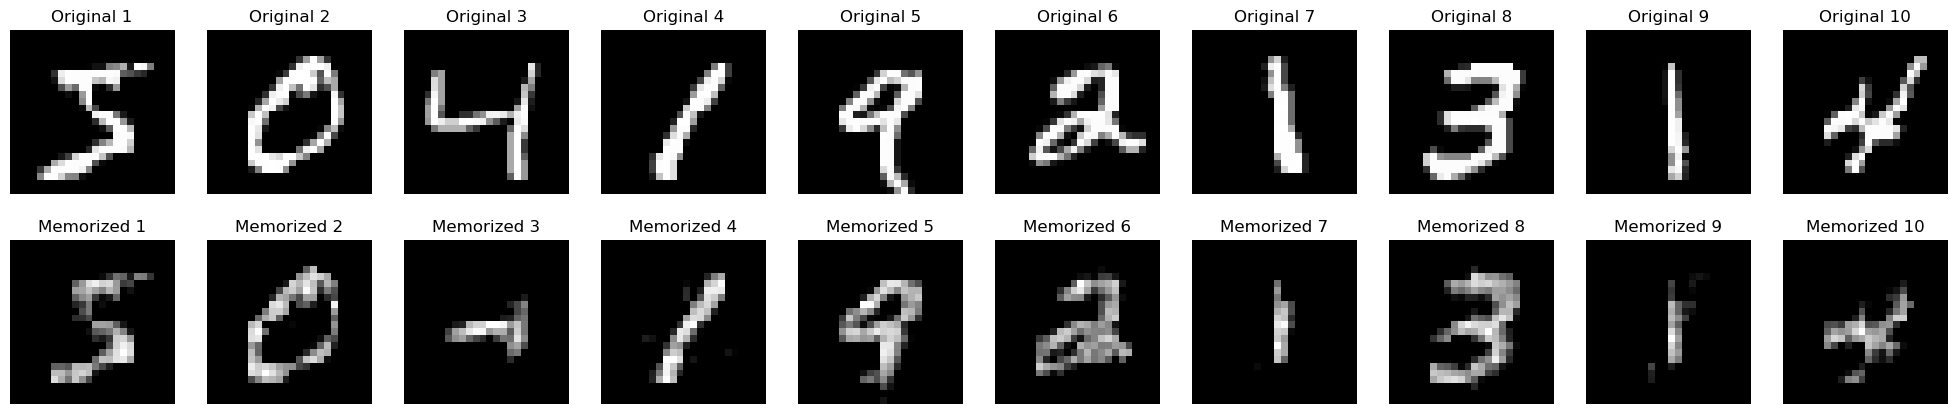

Epoch 160 | Train loss 0.004815 | Memorization loss 0.123629
Visualizing results at Epoch 161


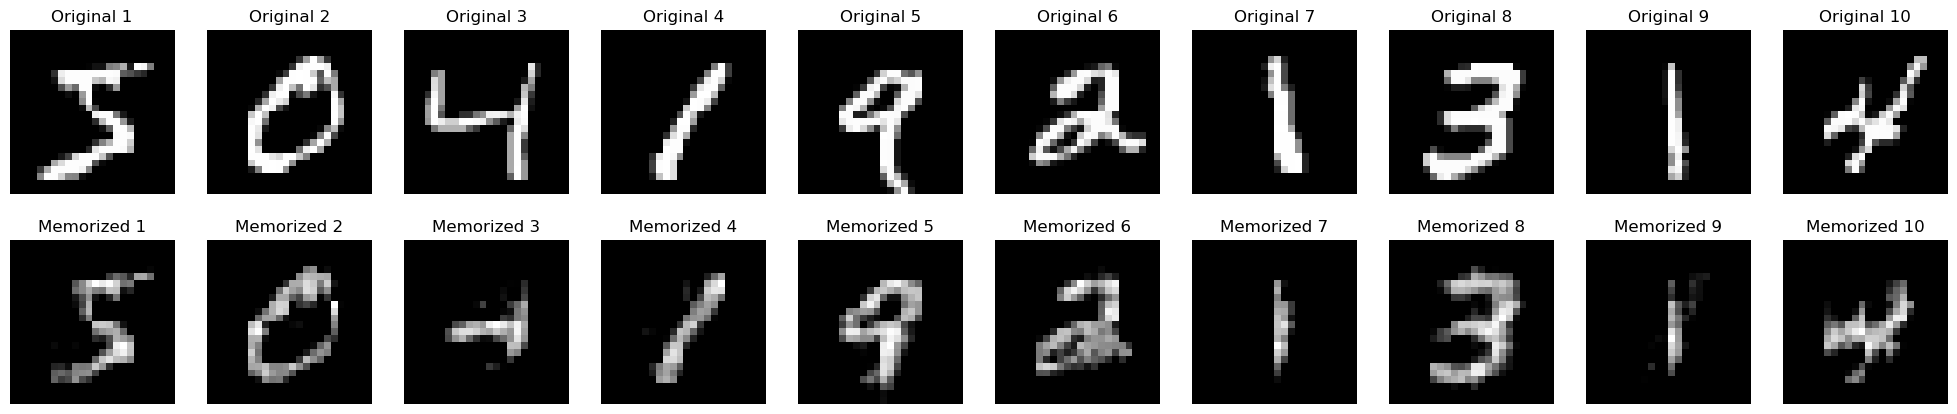

Epoch 161 | Train loss 0.004815 | Memorization loss 0.123872
Visualizing results at Epoch 162


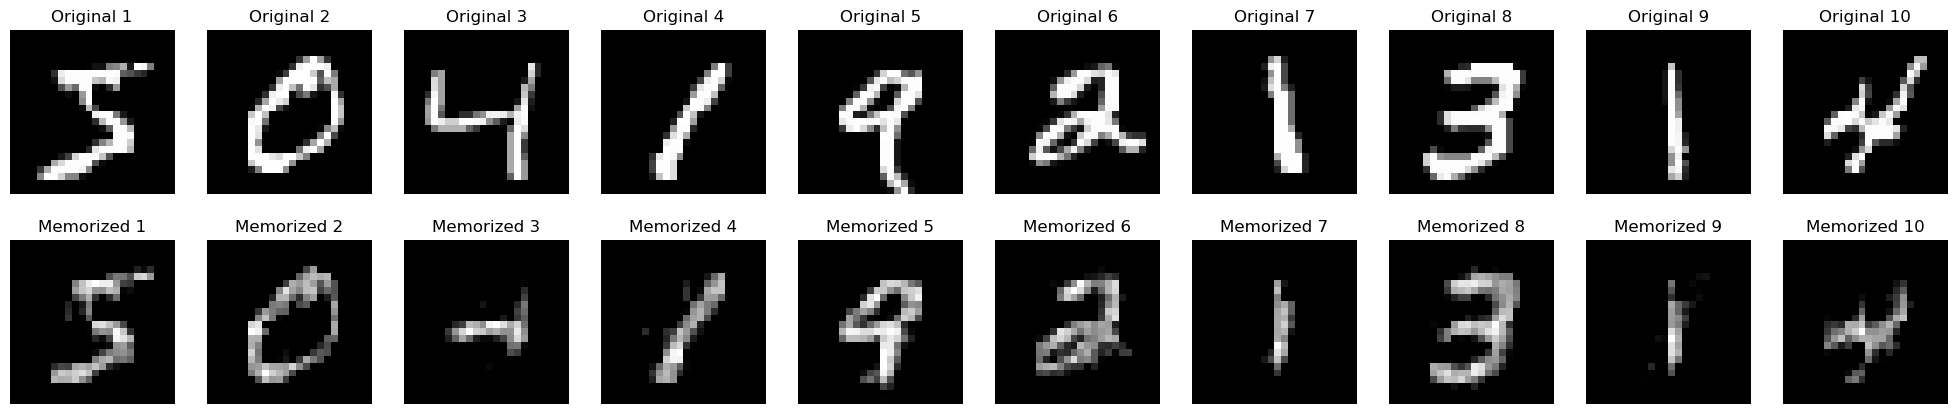

Epoch 162 | Train loss 0.004816 | Memorization loss 0.119939
Saved model and optimizer with memorization loss: 0.1199
Visualizing results at Epoch 163


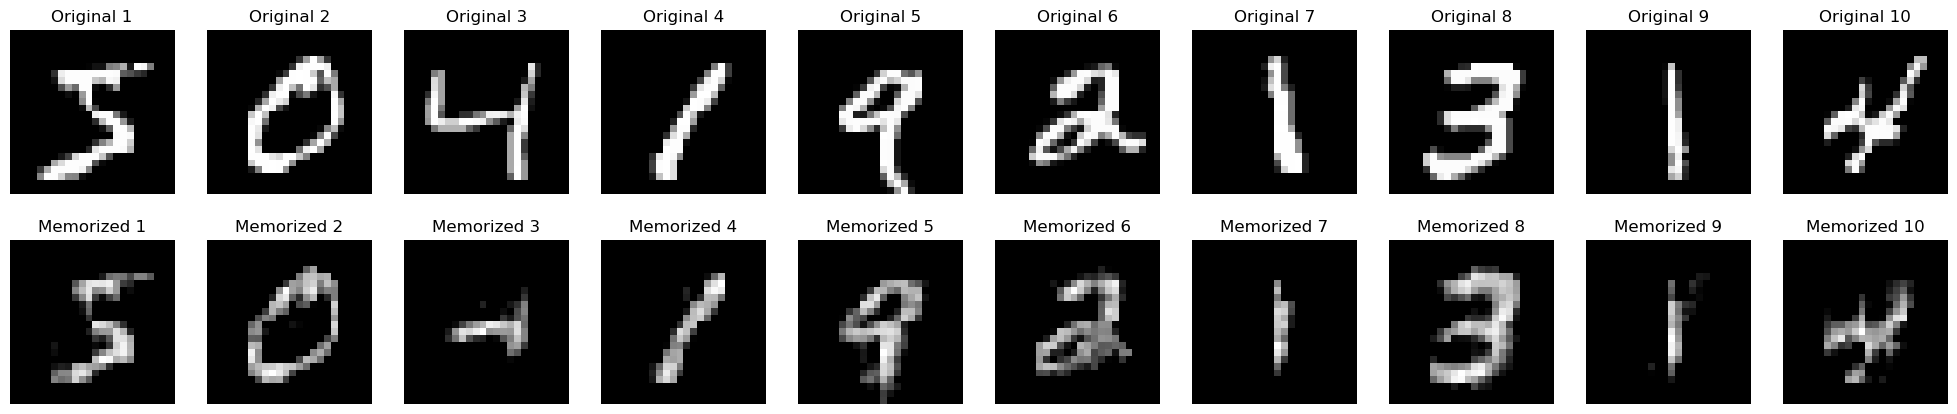

Epoch 163 | Train loss 0.004814 | Memorization loss 0.119867
Saved model and optimizer with memorization loss: 0.1199
Visualizing results at Epoch 164


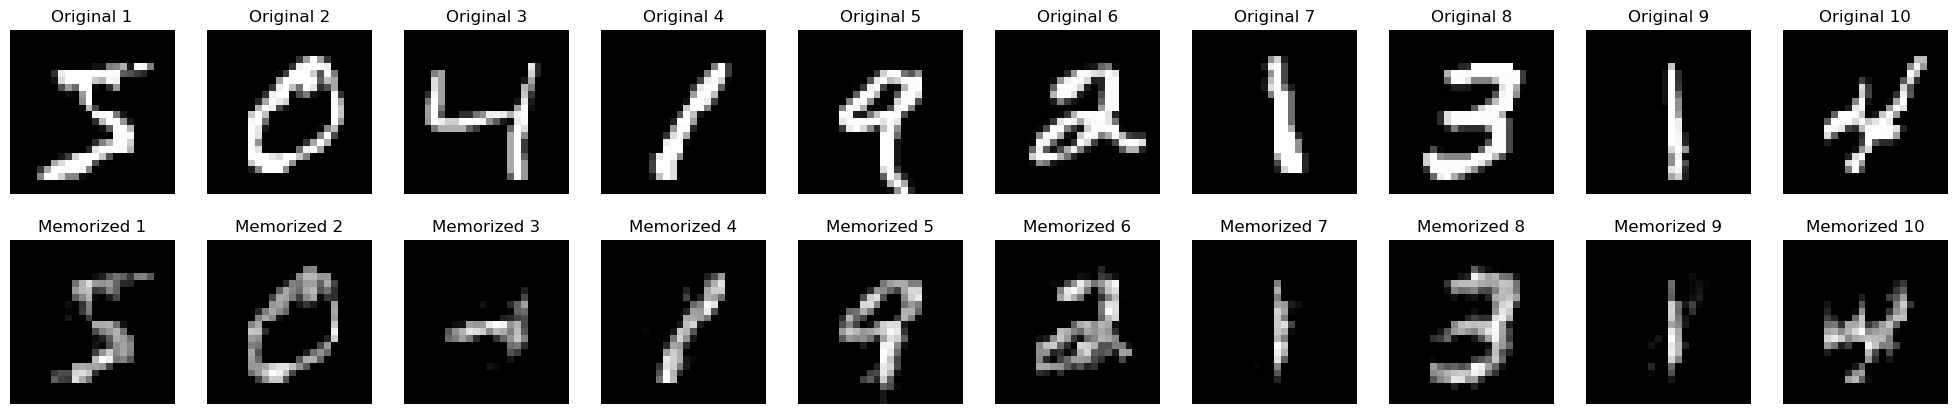

Epoch 164 | Train loss 0.004815 | Memorization loss 0.121113
Visualizing results at Epoch 165


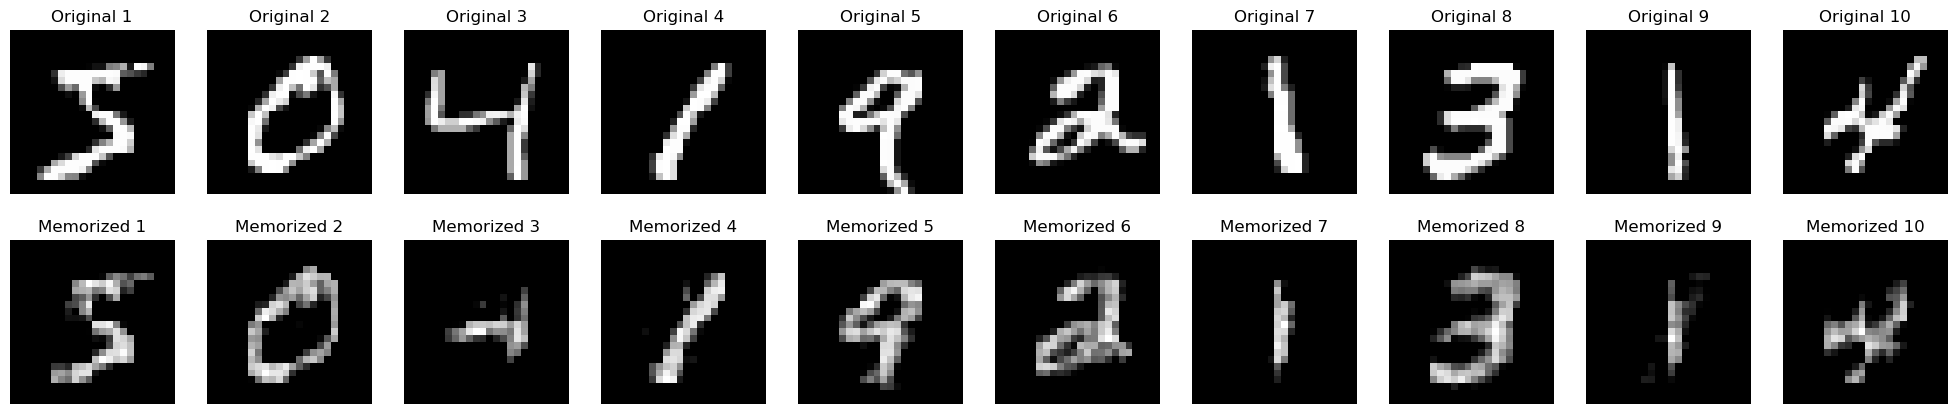

Epoch 165 | Train loss 0.004816 | Memorization loss 0.122228
Visualizing results at Epoch 166


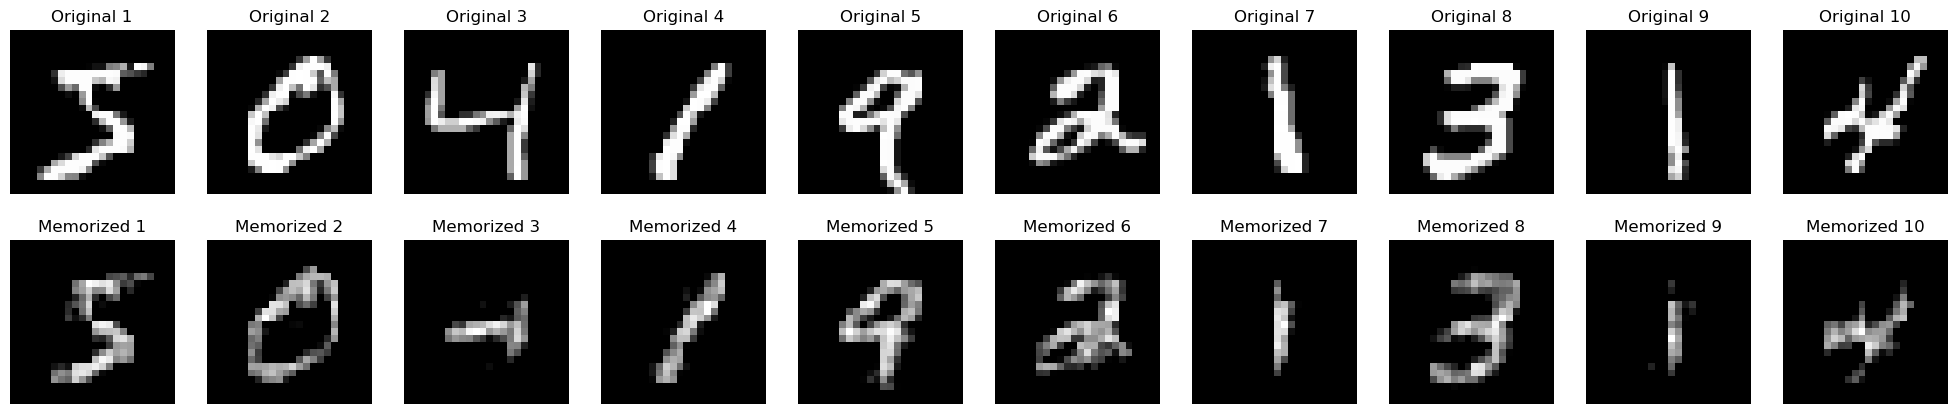

Epoch 166 | Train loss 0.004815 | Memorization loss 0.119314
Saved model and optimizer with memorization loss: 0.1193
Visualizing results at Epoch 167


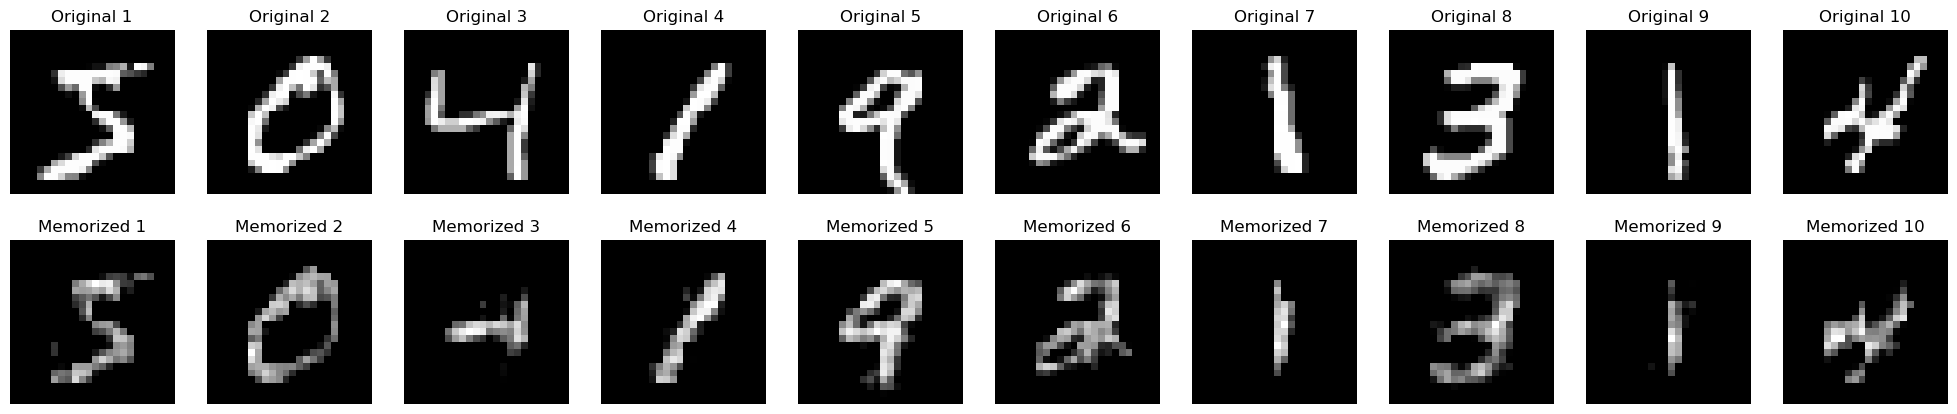

Epoch 167 | Train loss 0.004815 | Memorization loss 0.118662
Saved model and optimizer with memorization loss: 0.1187
Visualizing results at Epoch 168


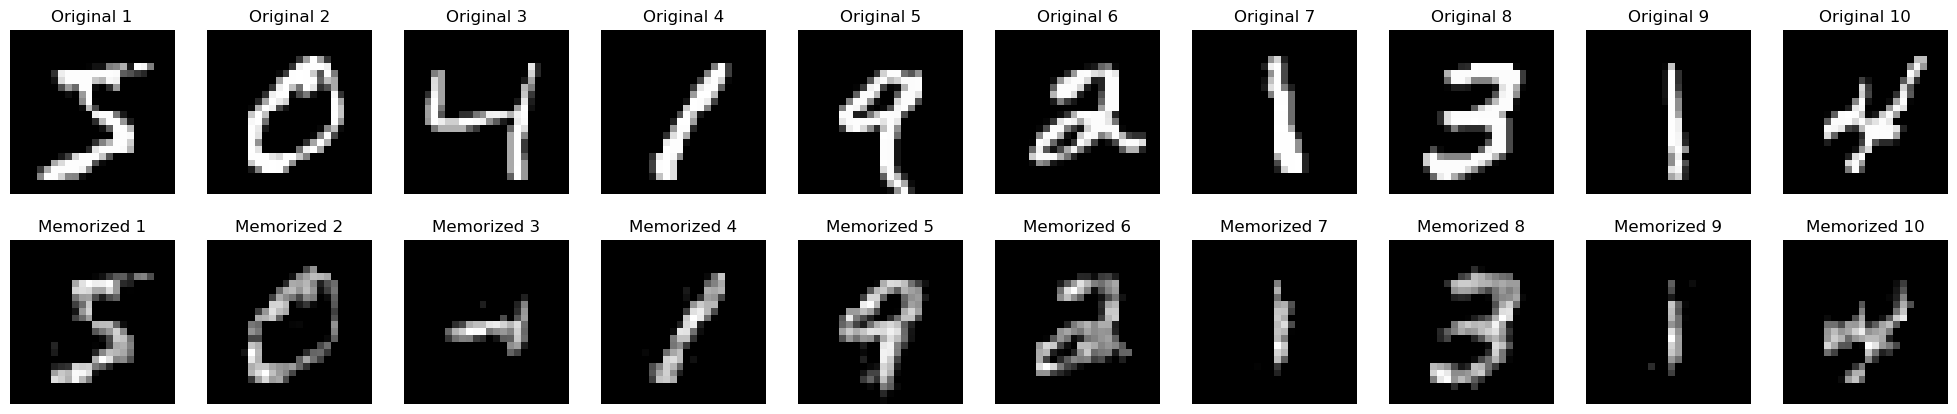

Epoch 168 | Train loss 0.004816 | Memorization loss 0.120307
Visualizing results at Epoch 169


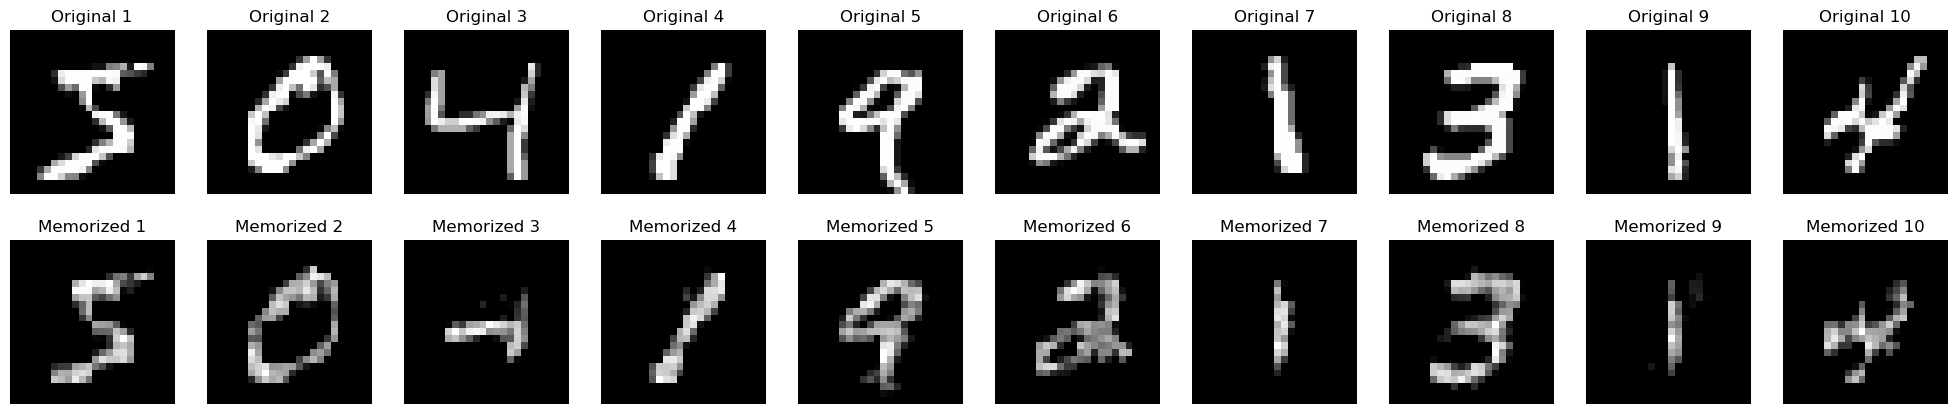

Epoch 169 | Train loss 0.004816 | Memorization loss 0.120977
Visualizing results at Epoch 170


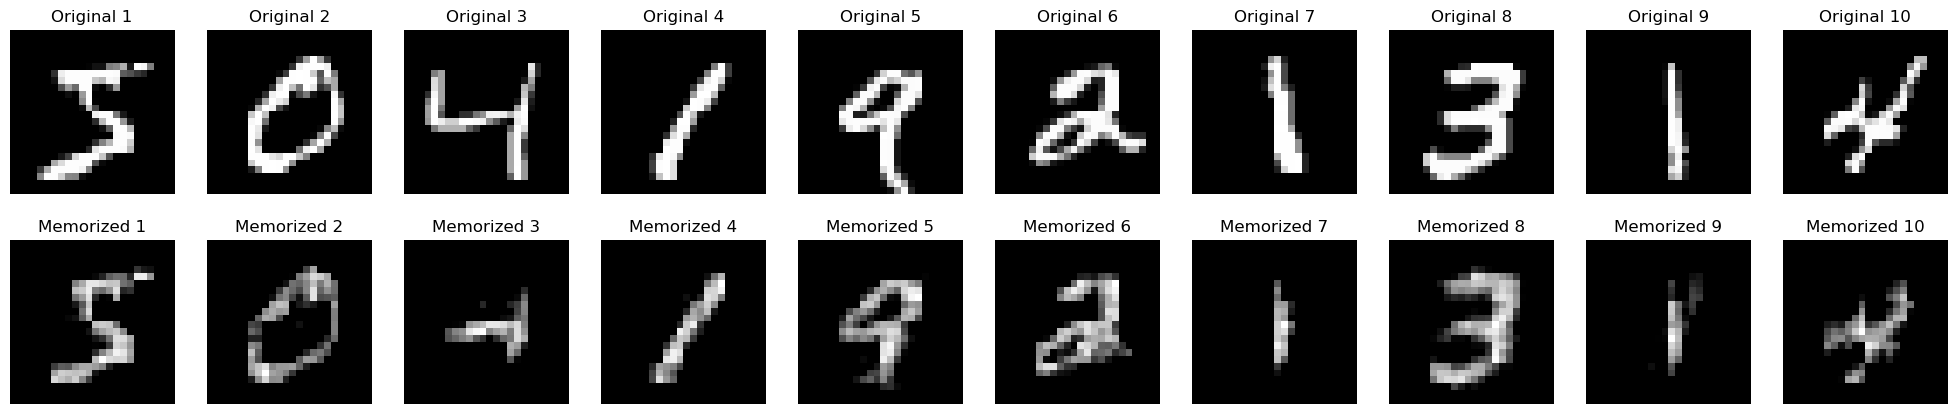

Epoch 170 | Train loss 0.004844 | Memorization loss 0.118081
Saved model and optimizer with memorization loss: 0.1181
Visualizing results at Epoch 171


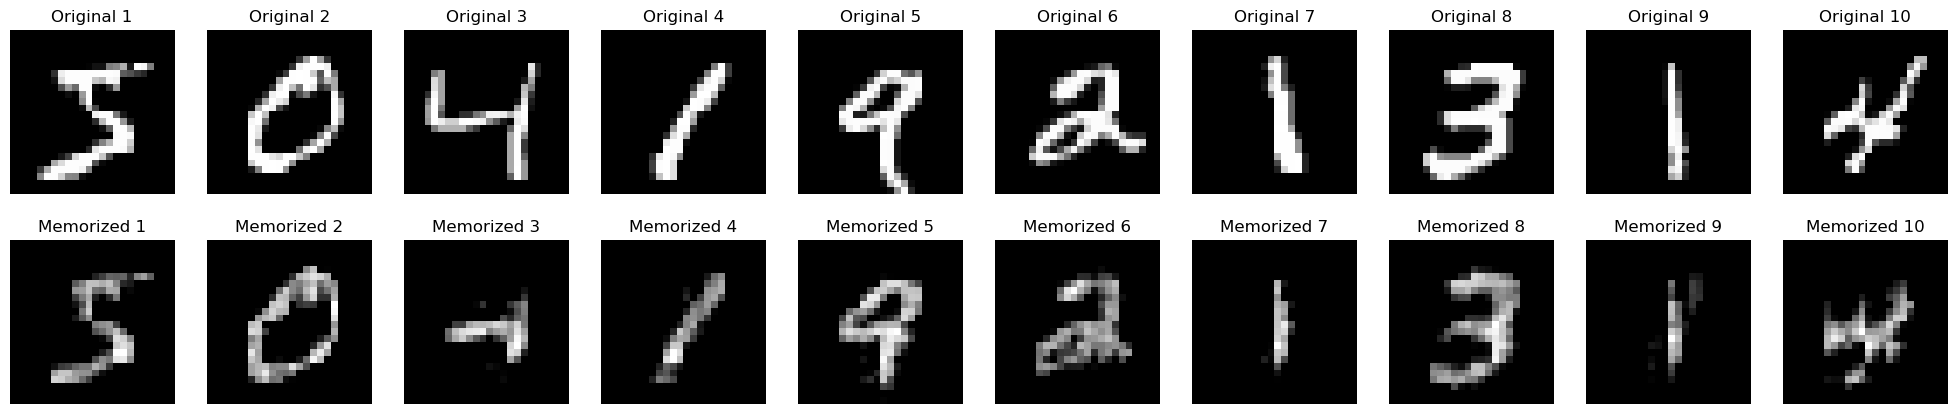

Epoch 171 | Train loss 0.004828 | Memorization loss 0.115975
Saved model and optimizer with memorization loss: 0.1160
Visualizing results at Epoch 172


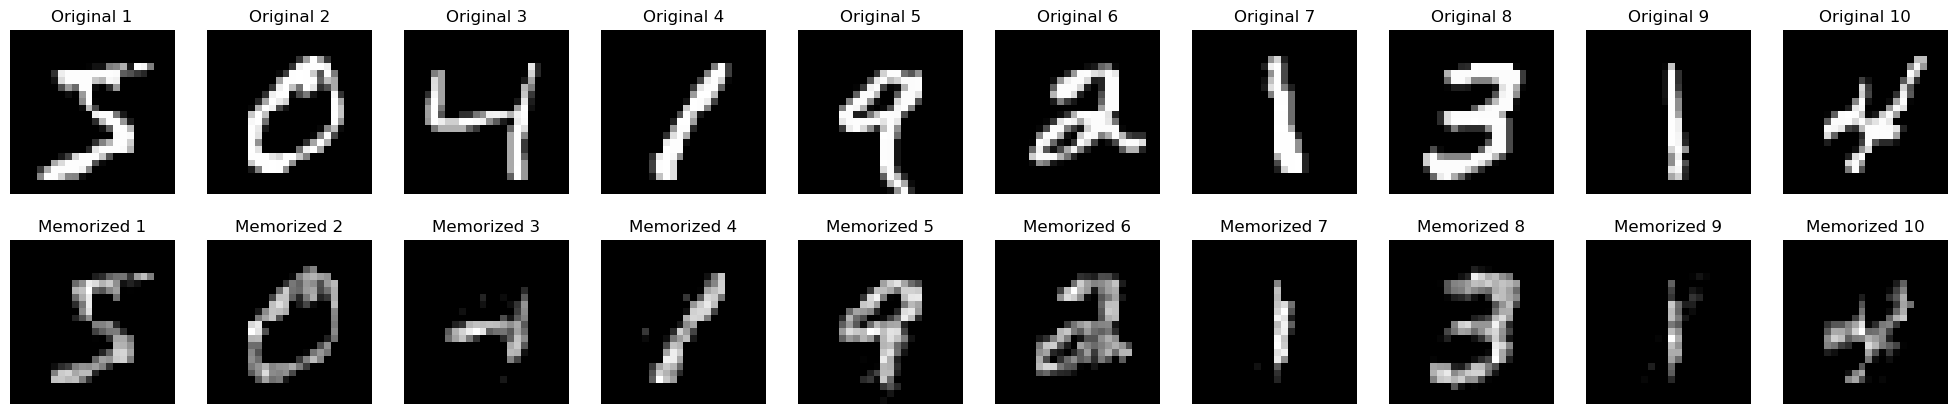

Epoch 172 | Train loss 0.004821 | Memorization loss 0.118101
Visualizing results at Epoch 173


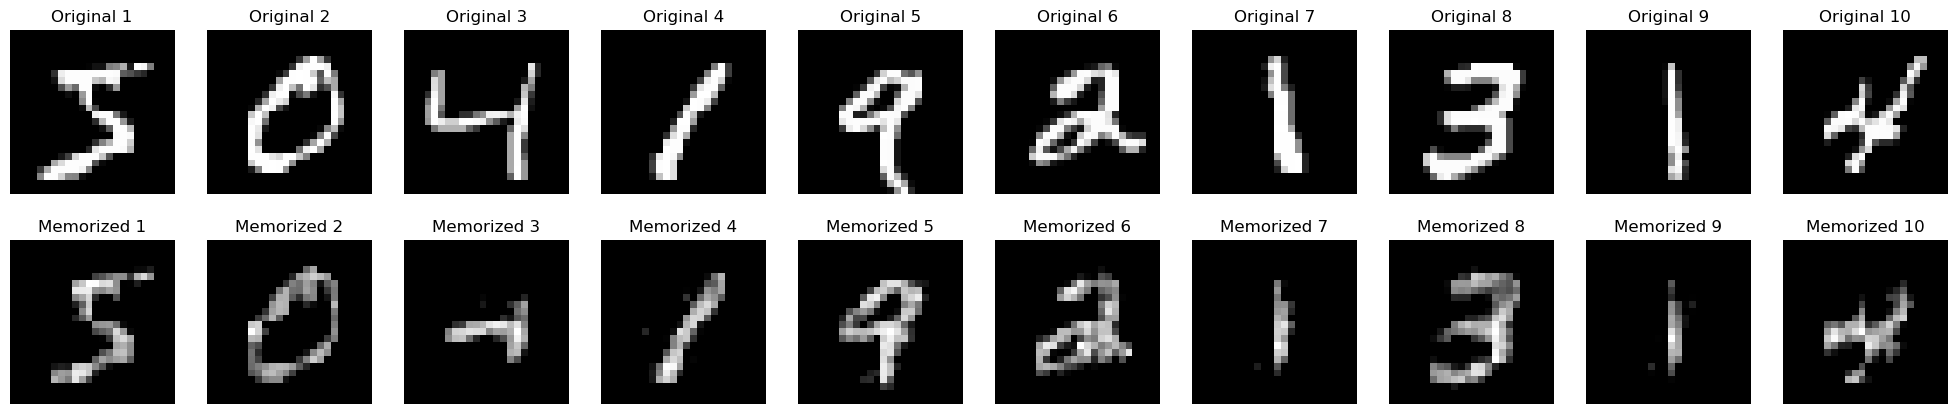

Epoch 173 | Train loss 0.004817 | Memorization loss 0.119585
Visualizing results at Epoch 174


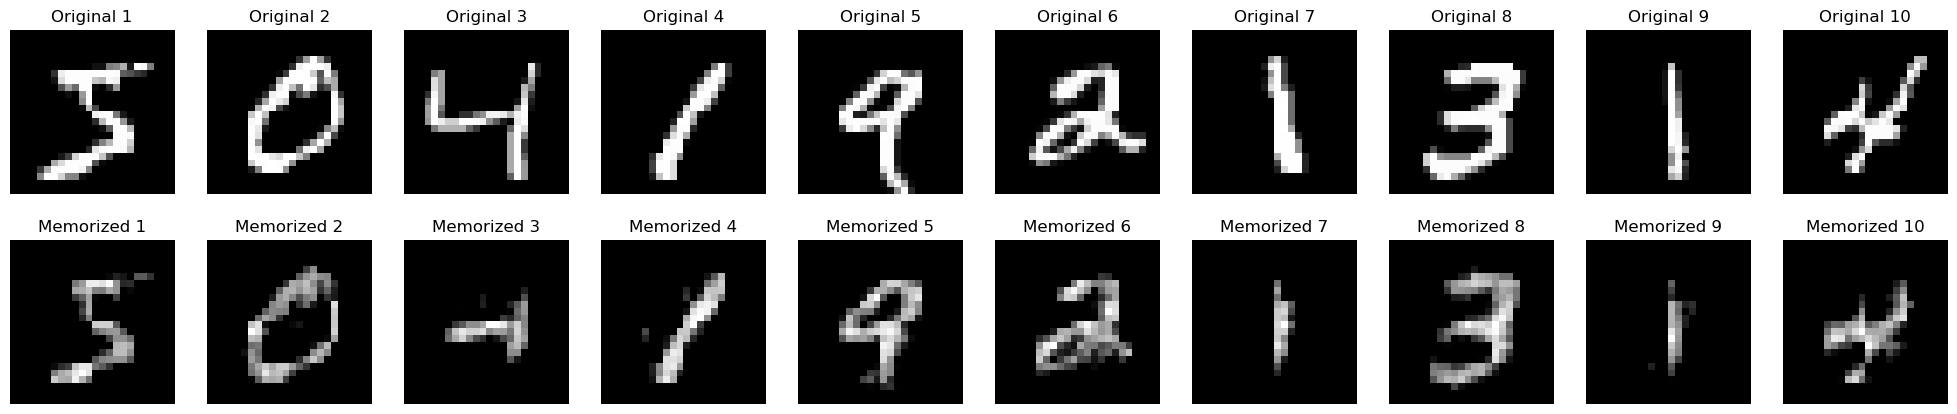

Epoch 174 | Train loss 0.004815 | Memorization loss 0.119659
Visualizing results at Epoch 175


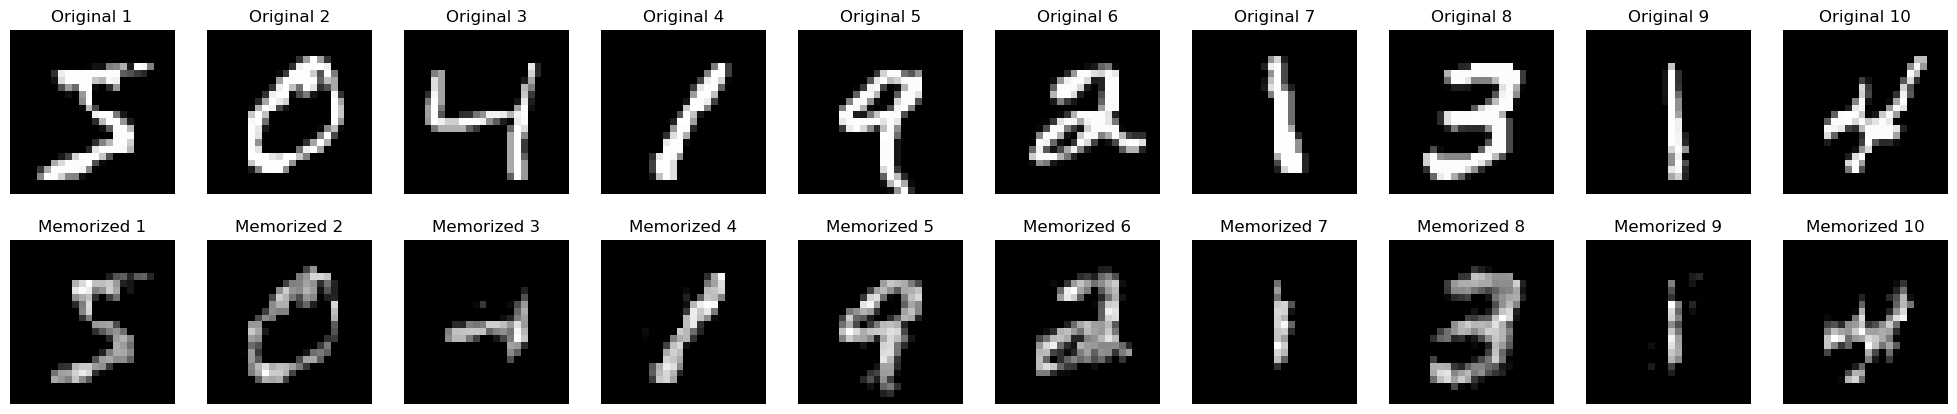

Epoch 175 | Train loss 0.004817 | Memorization loss 0.114906
Saved model and optimizer with memorization loss: 0.1149
Visualizing results at Epoch 176


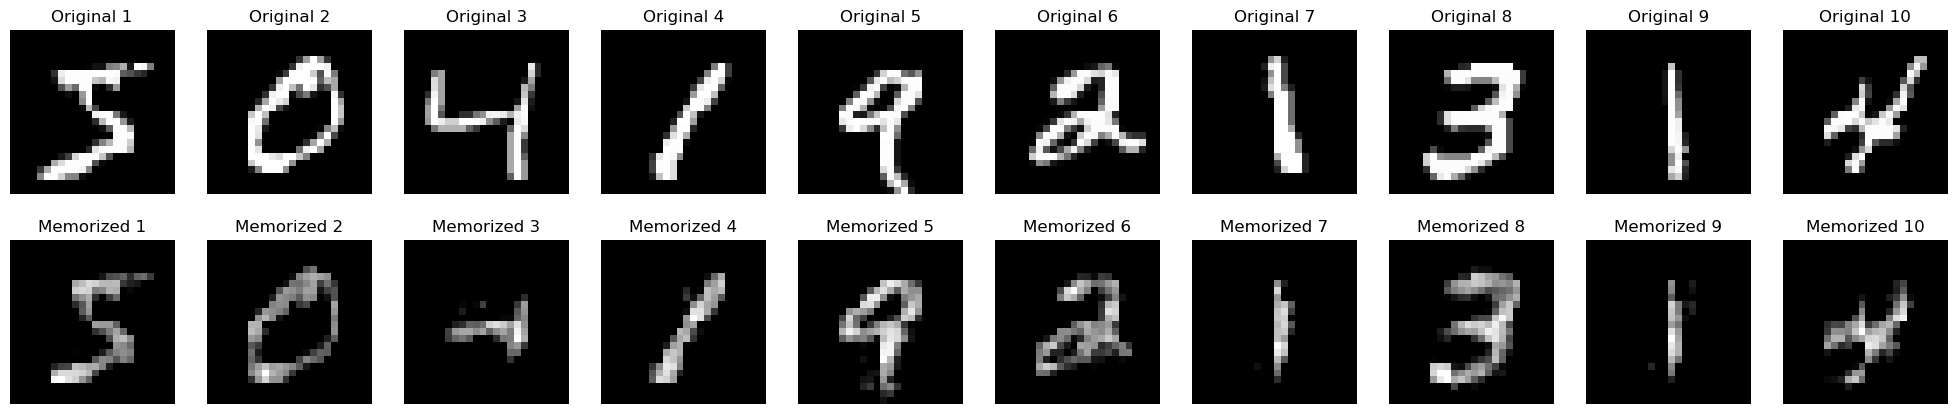

Epoch 176 | Train loss 0.004817 | Memorization loss 0.118252
Visualizing results at Epoch 177


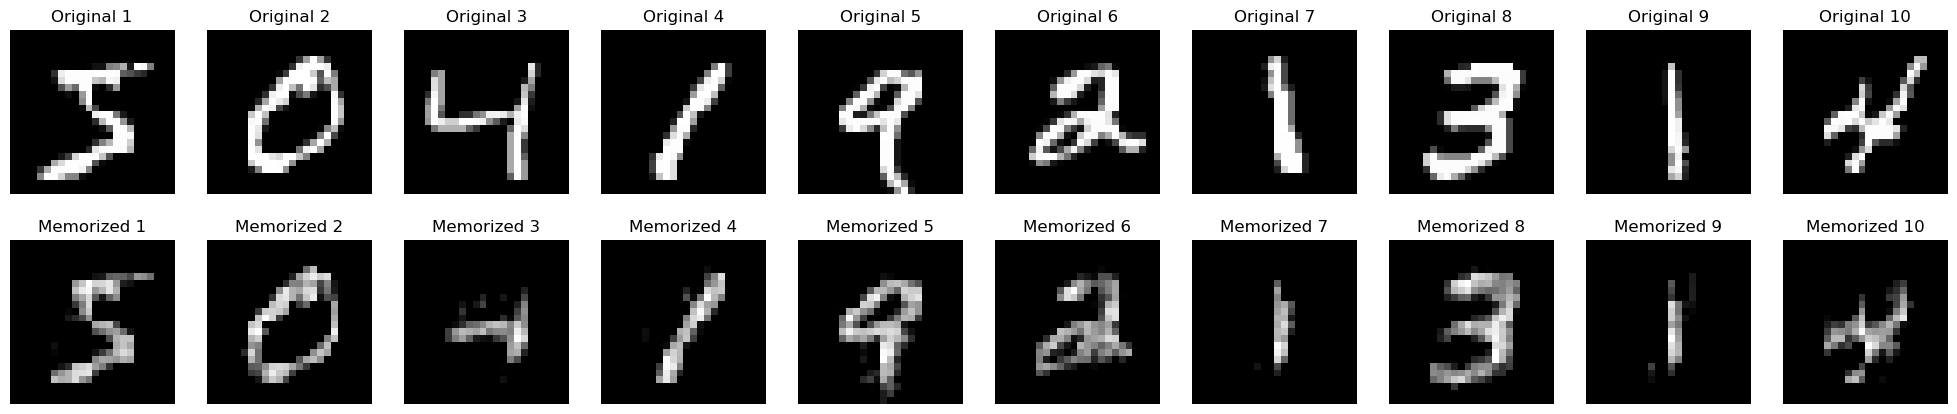

Epoch 177 | Train loss 0.004816 | Memorization loss 0.116566
Visualizing results at Epoch 178


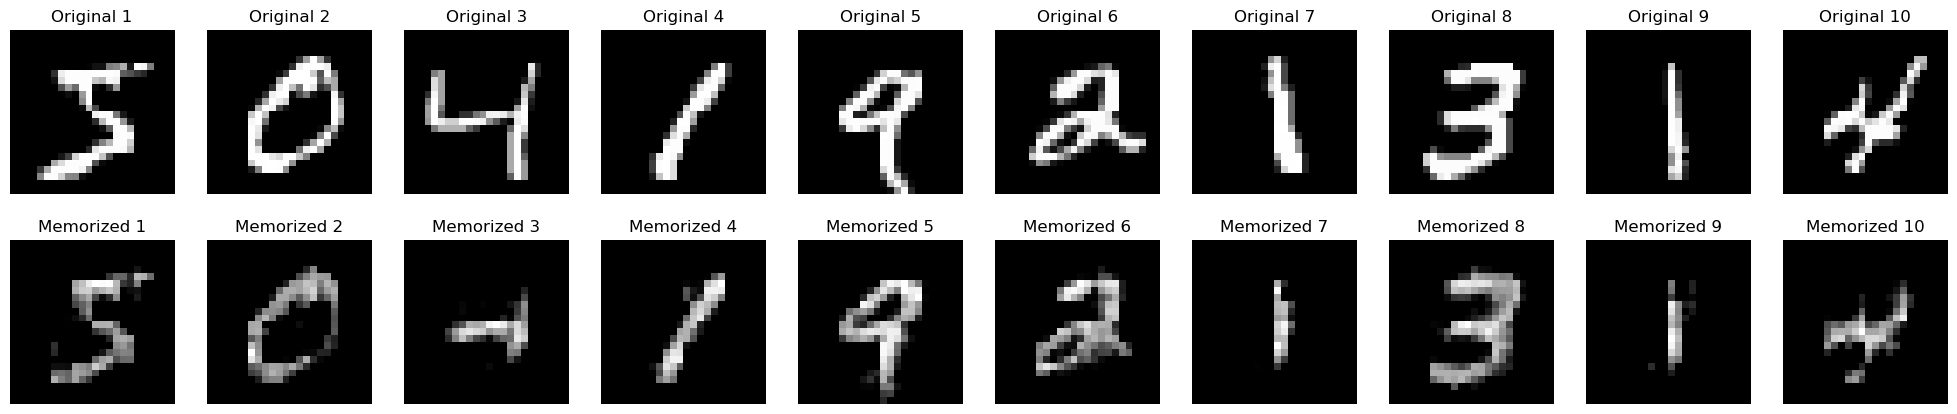

Epoch 178 | Train loss 0.004815 | Memorization loss 0.117834
Visualizing results at Epoch 179


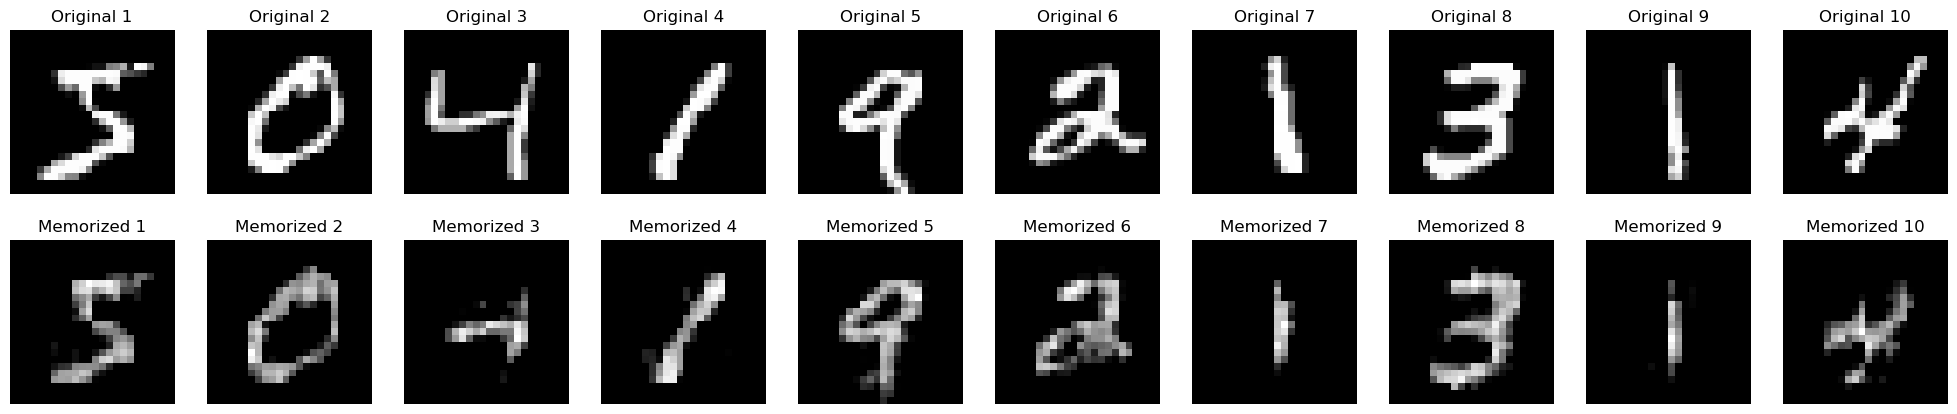

Epoch 179 | Train loss 0.004815 | Memorization loss 0.114367
Saved model and optimizer with memorization loss: 0.1144
Visualizing results at Epoch 180


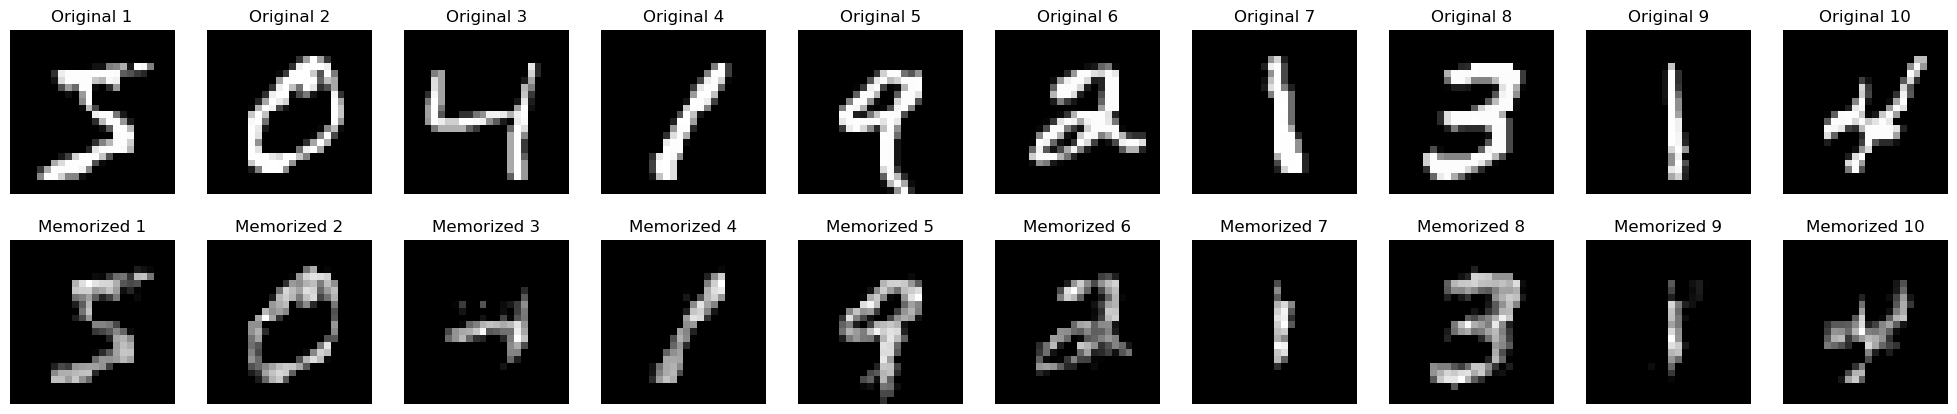

Epoch 180 | Train loss 0.004816 | Memorization loss 0.116241
Visualizing results at Epoch 181


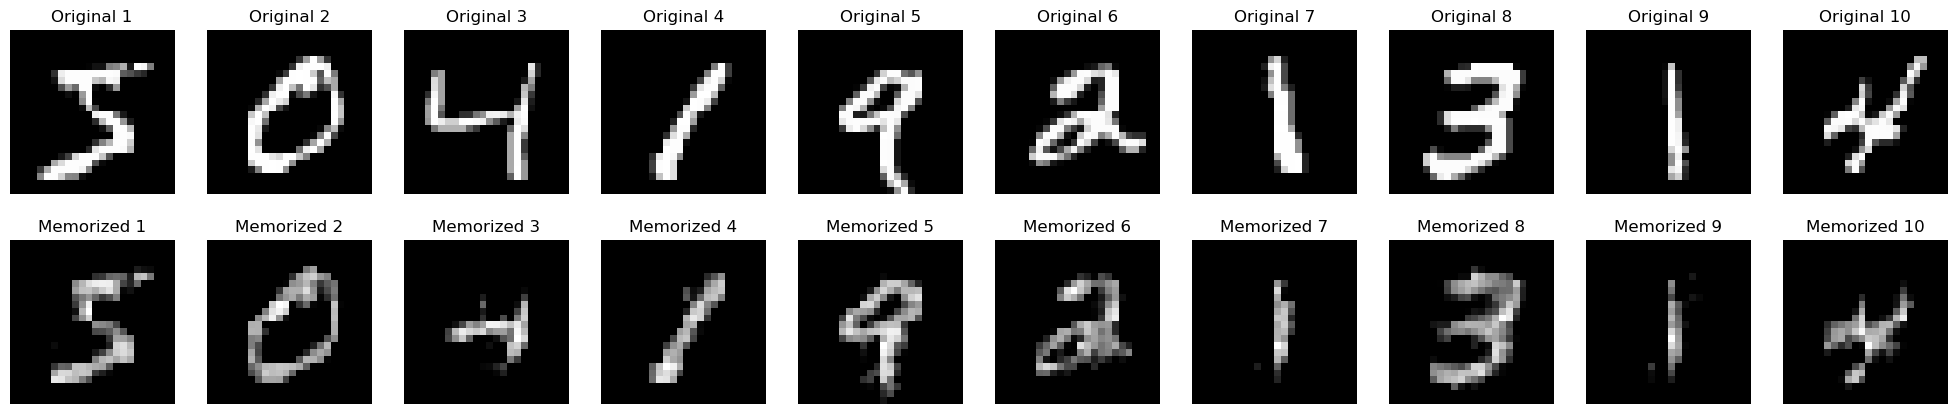

Epoch 181 | Train loss 0.004815 | Memorization loss 0.115090
Visualizing results at Epoch 182


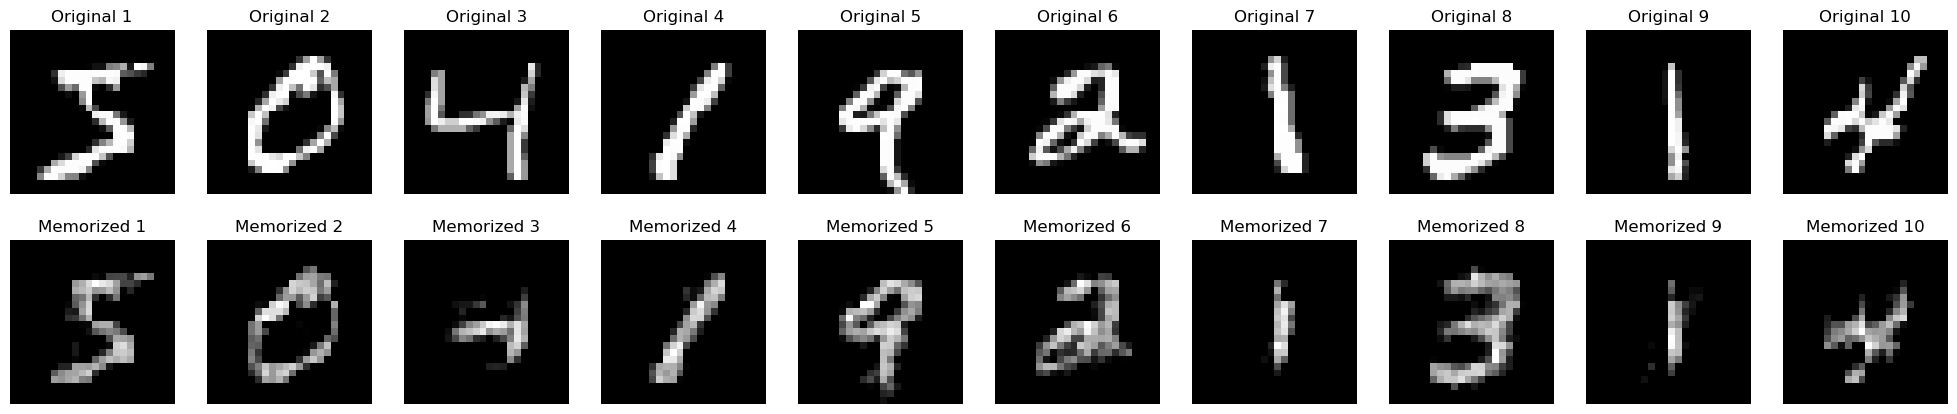

Epoch 182 | Train loss 0.004816 | Memorization loss 0.115203
Visualizing results at Epoch 183


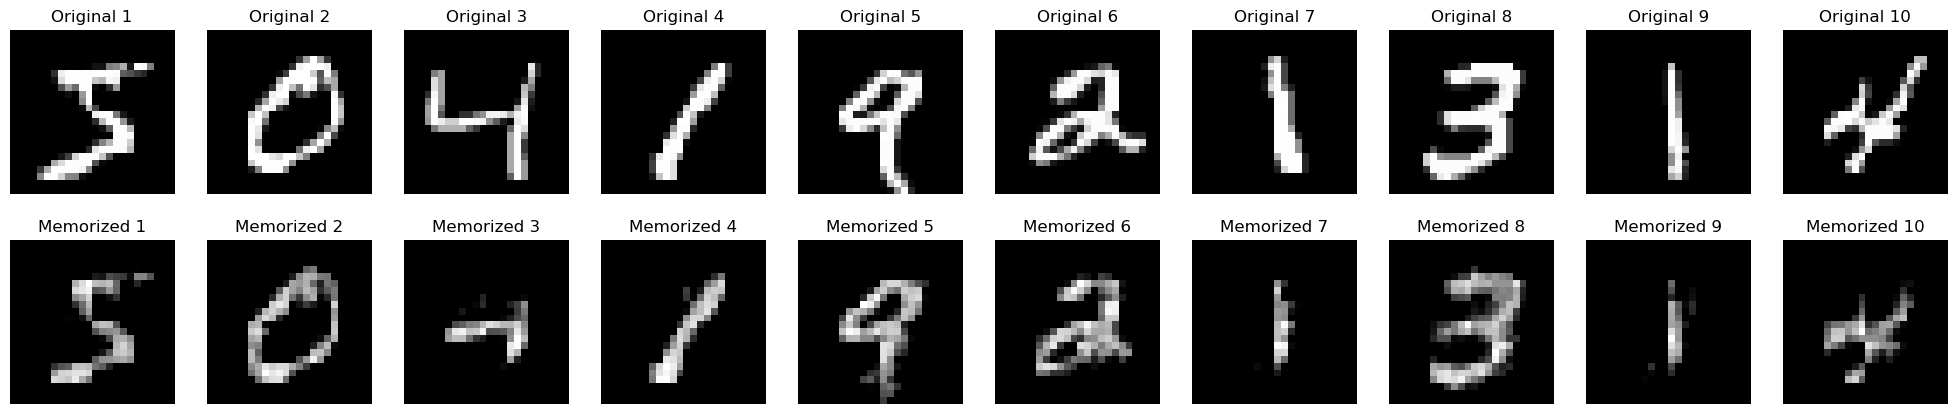

Epoch 183 | Train loss 0.004815 | Memorization loss 0.113438
Saved model and optimizer with memorization loss: 0.1134
Visualizing results at Epoch 184


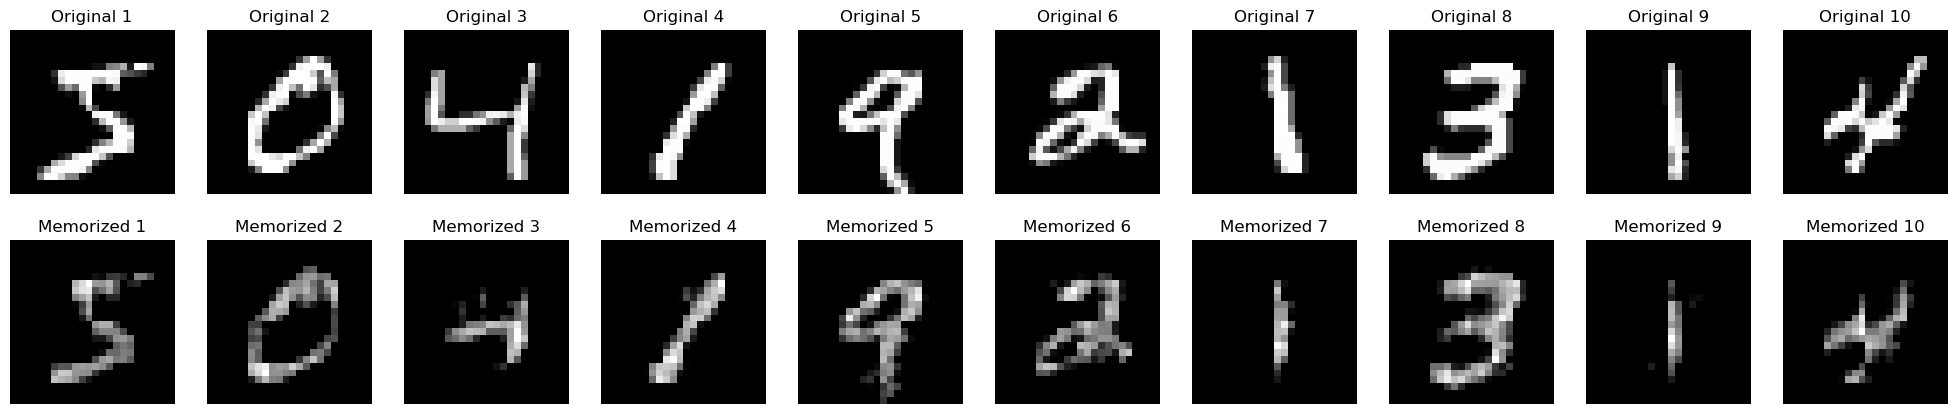

Epoch 184 | Train loss 0.004815 | Memorization loss 0.112899
Saved model and optimizer with memorization loss: 0.1129
Visualizing results at Epoch 185


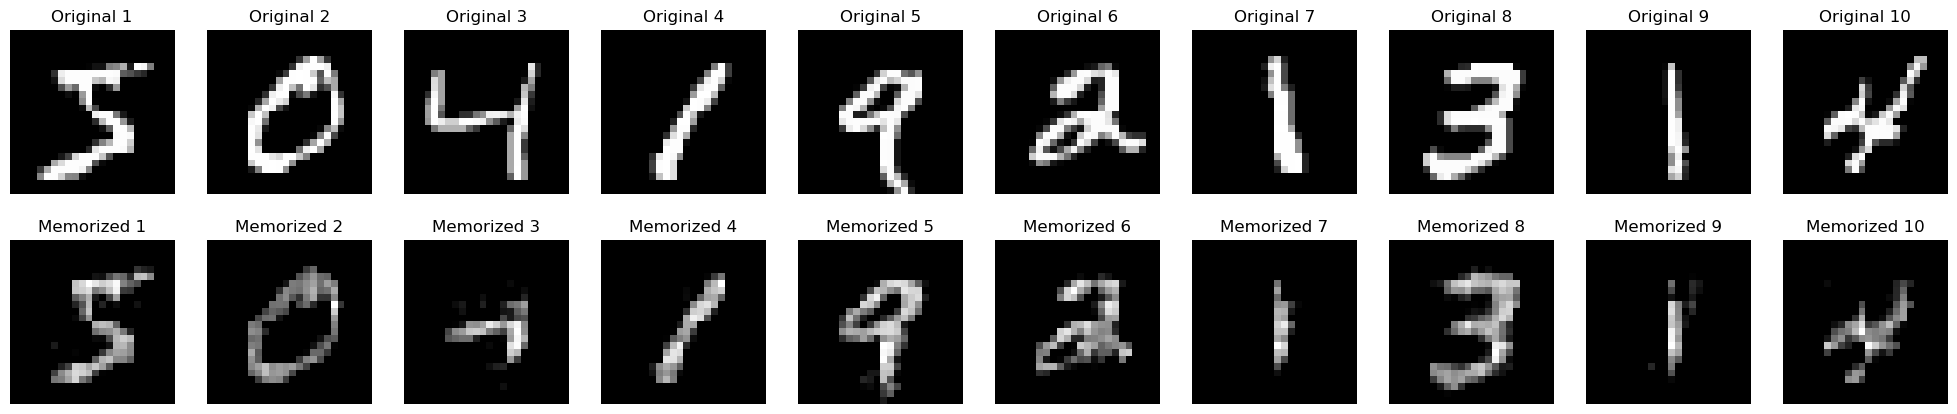

Epoch 185 | Train loss 0.004815 | Memorization loss 0.113855
Visualizing results at Epoch 186


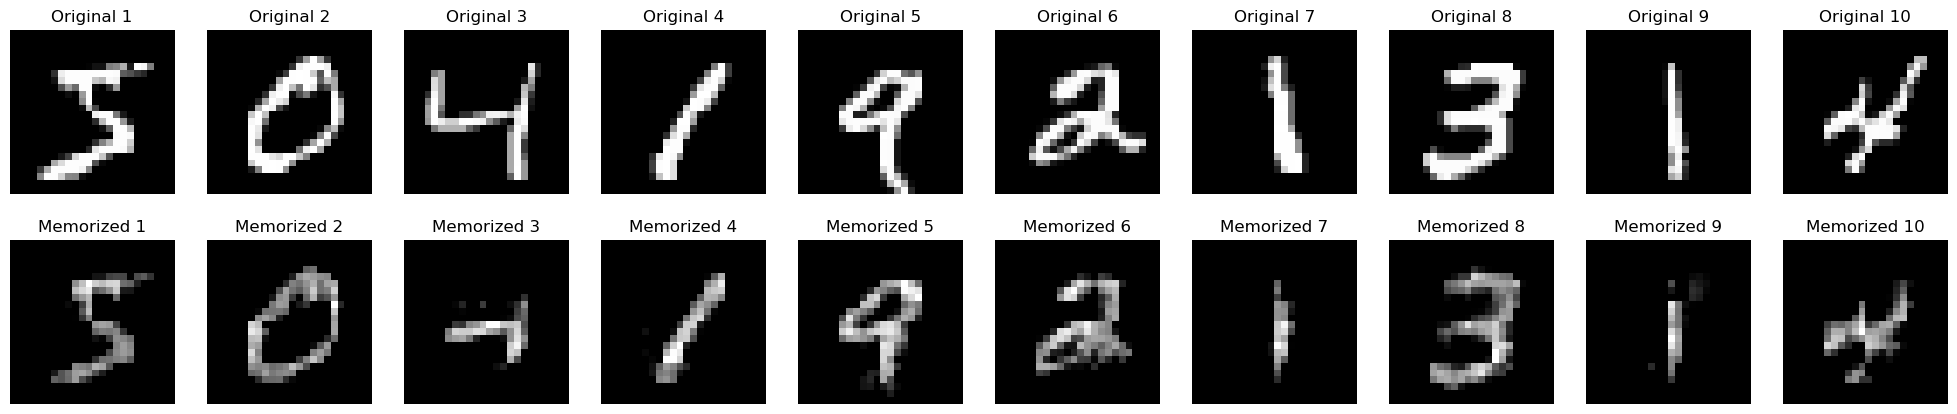

Epoch 186 | Train loss 0.004816 | Memorization loss 0.116183
Visualizing results at Epoch 187


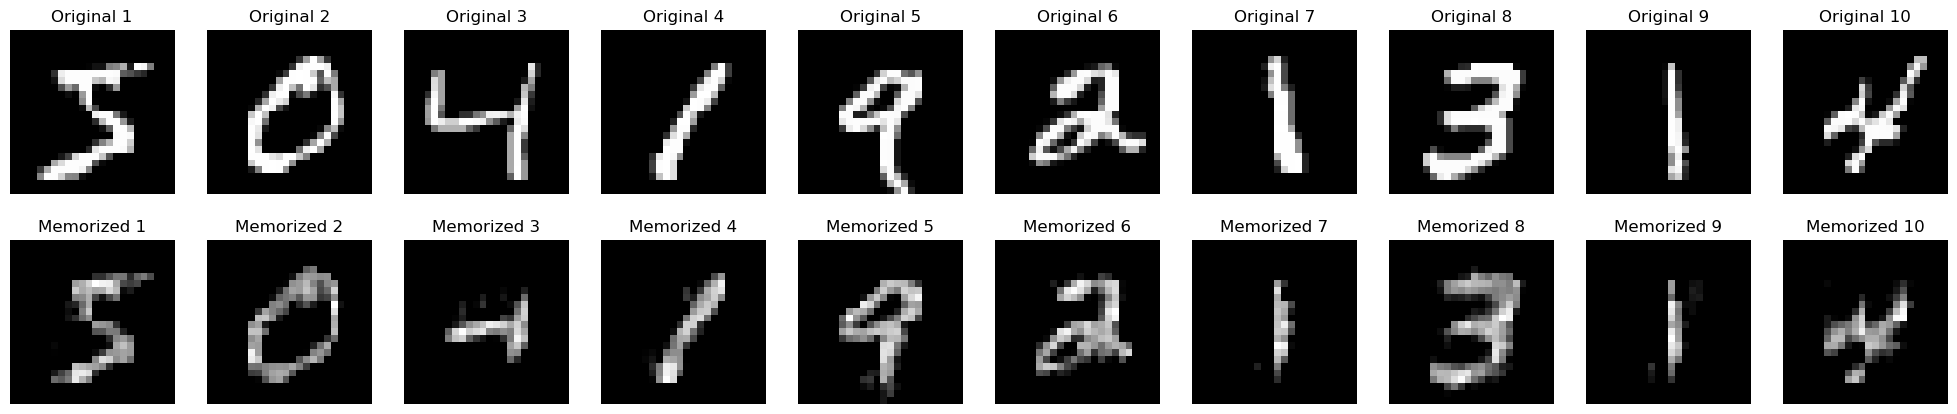

Epoch 187 | Train loss 0.004817 | Memorization loss 0.112865
Saved model and optimizer with memorization loss: 0.1129
Visualizing results at Epoch 188


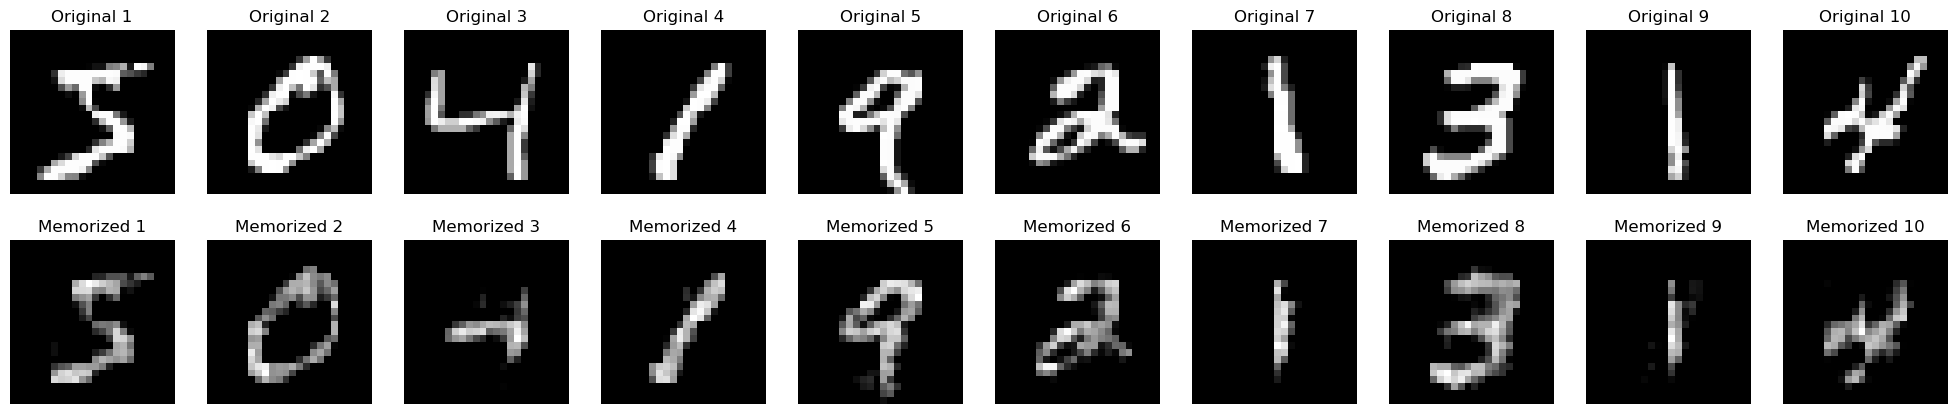

Epoch 188 | Train loss 0.004816 | Memorization loss 0.110782
Saved model and optimizer with memorization loss: 0.1108
Visualizing results at Epoch 189


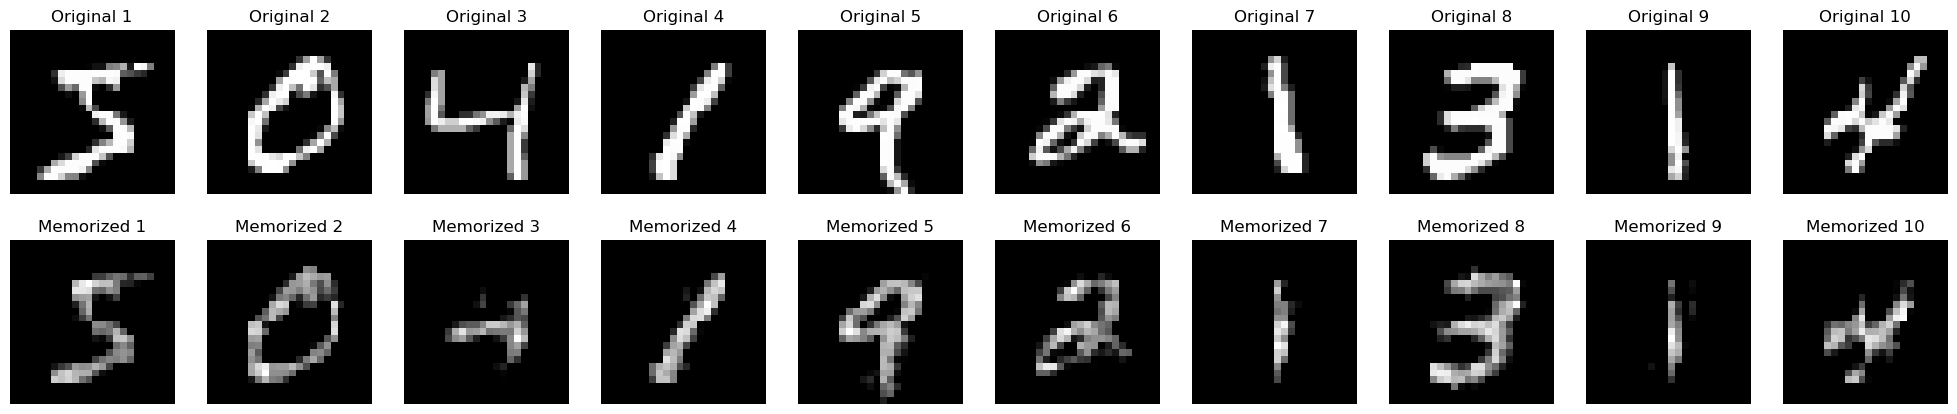

Epoch 189 | Train loss 0.004815 | Memorization loss 0.113697
Visualizing results at Epoch 190


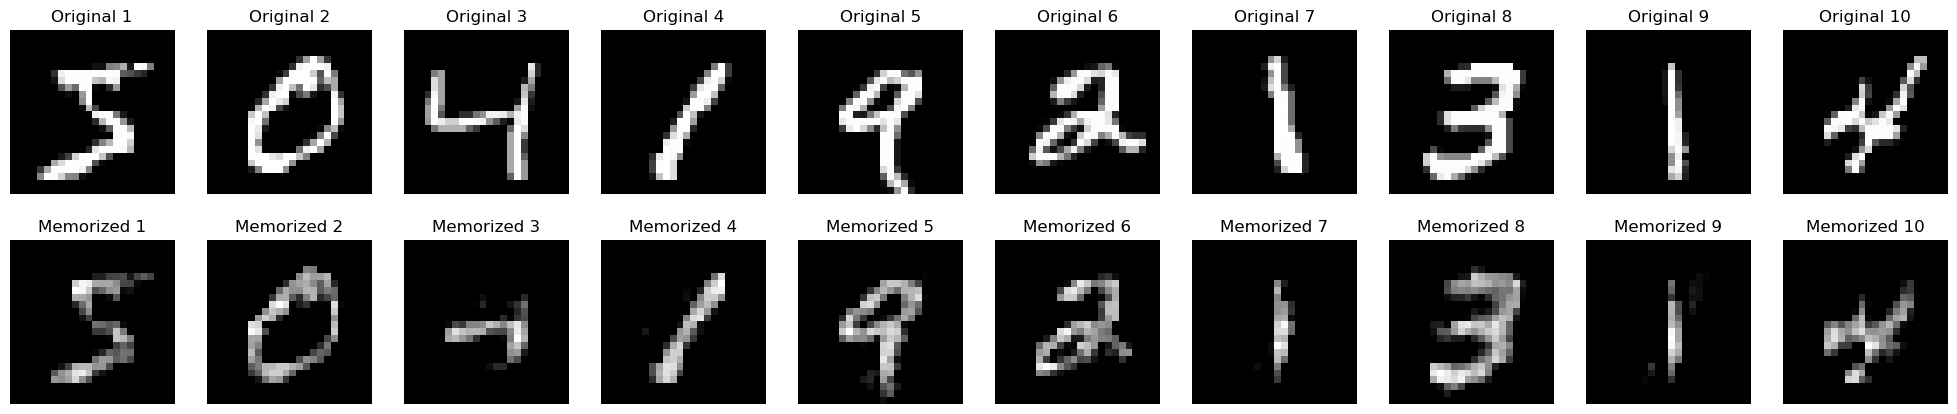

Epoch 190 | Train loss 0.004816 | Memorization loss 0.114378
Visualizing results at Epoch 191


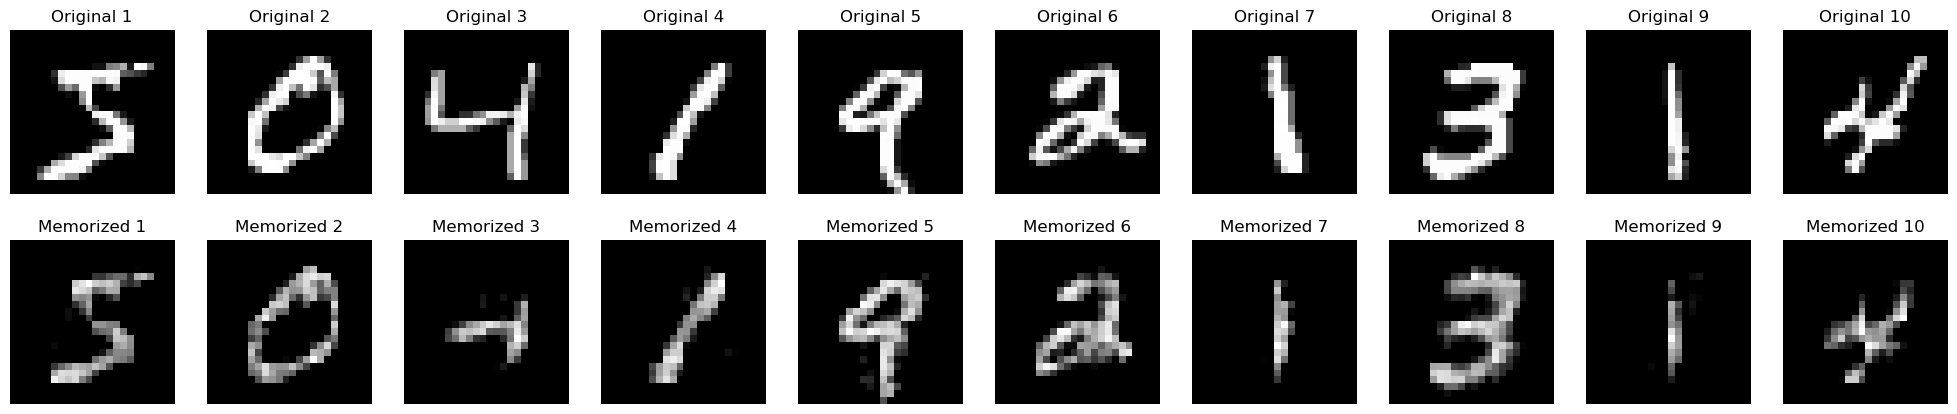

Epoch 191 | Train loss 0.004814 | Memorization loss 0.113009
Visualizing results at Epoch 192


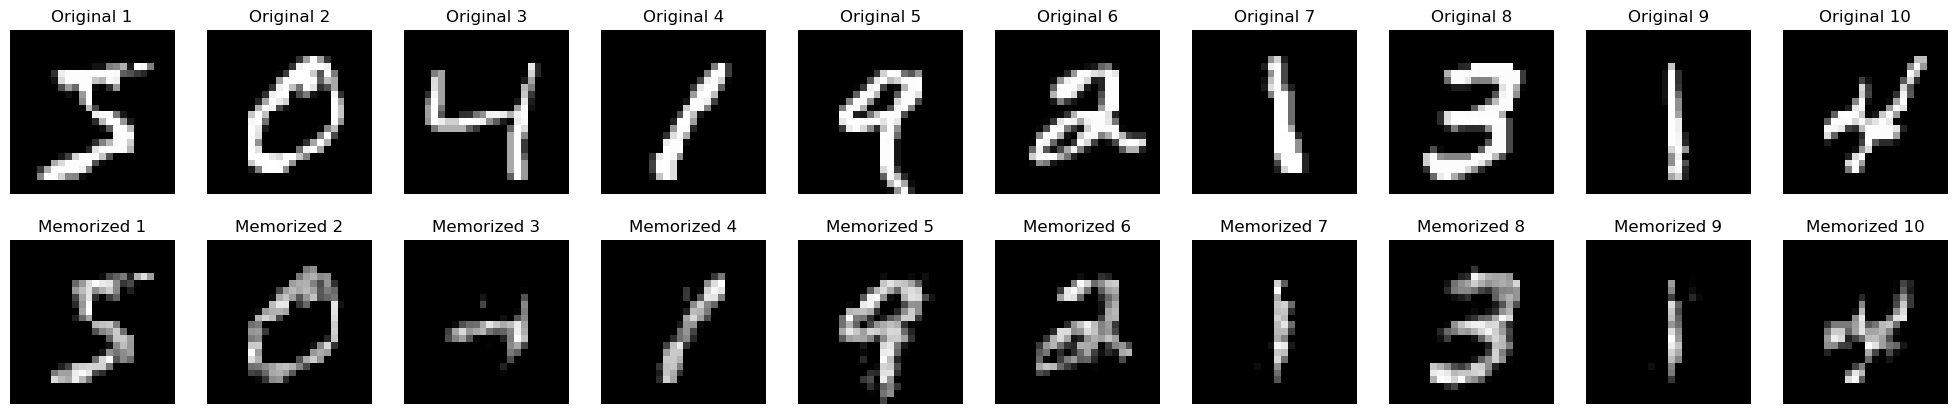

Epoch 192 | Train loss 0.004815 | Memorization loss 0.108971
Saved model and optimizer with memorization loss: 0.1090
Visualizing results at Epoch 193


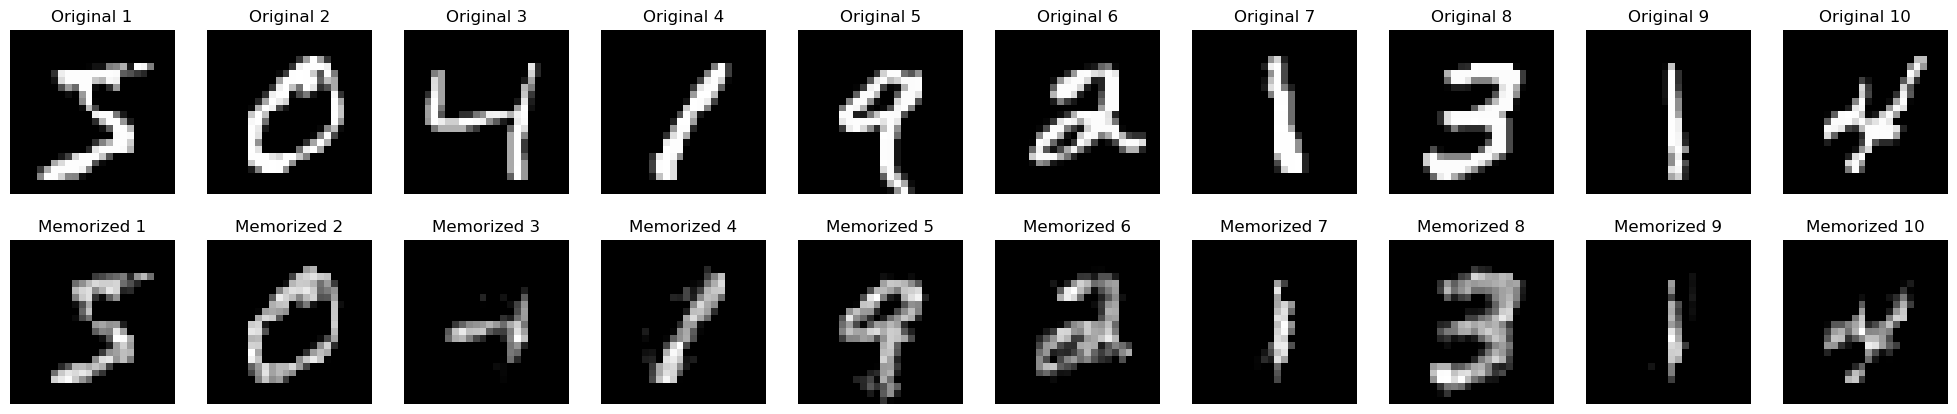

Epoch 193 | Train loss 0.004846 | Memorization loss 0.111210
Visualizing results at Epoch 194


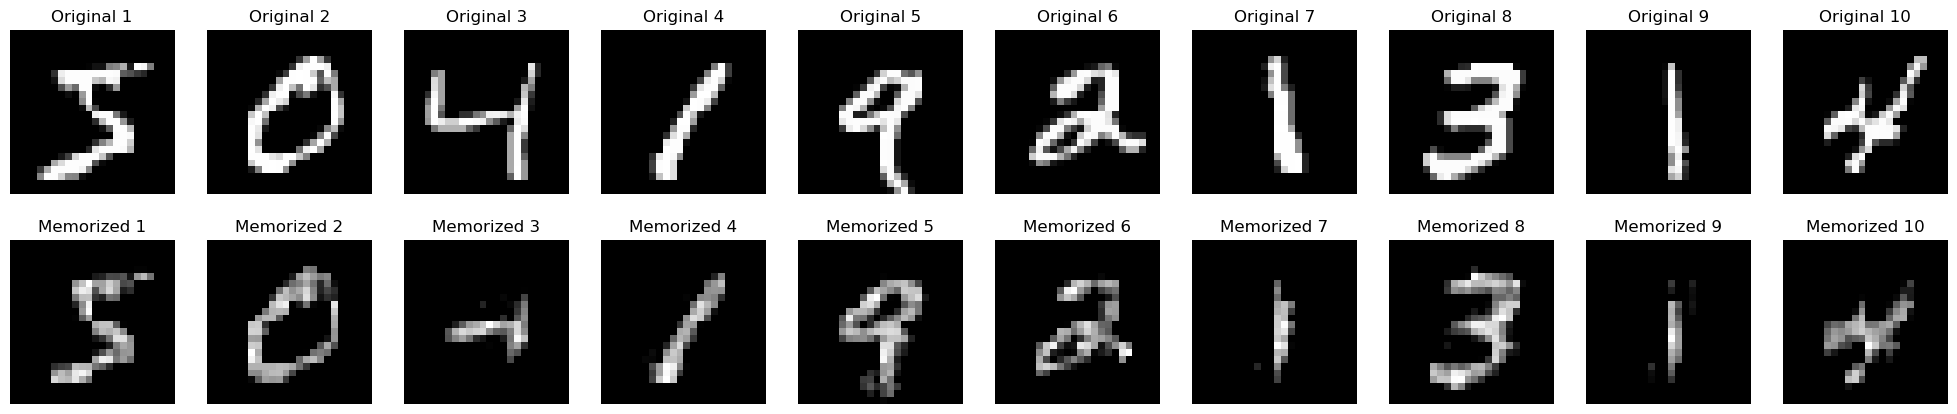

Epoch 194 | Train loss 0.004823 | Memorization loss 0.111163
Visualizing results at Epoch 195


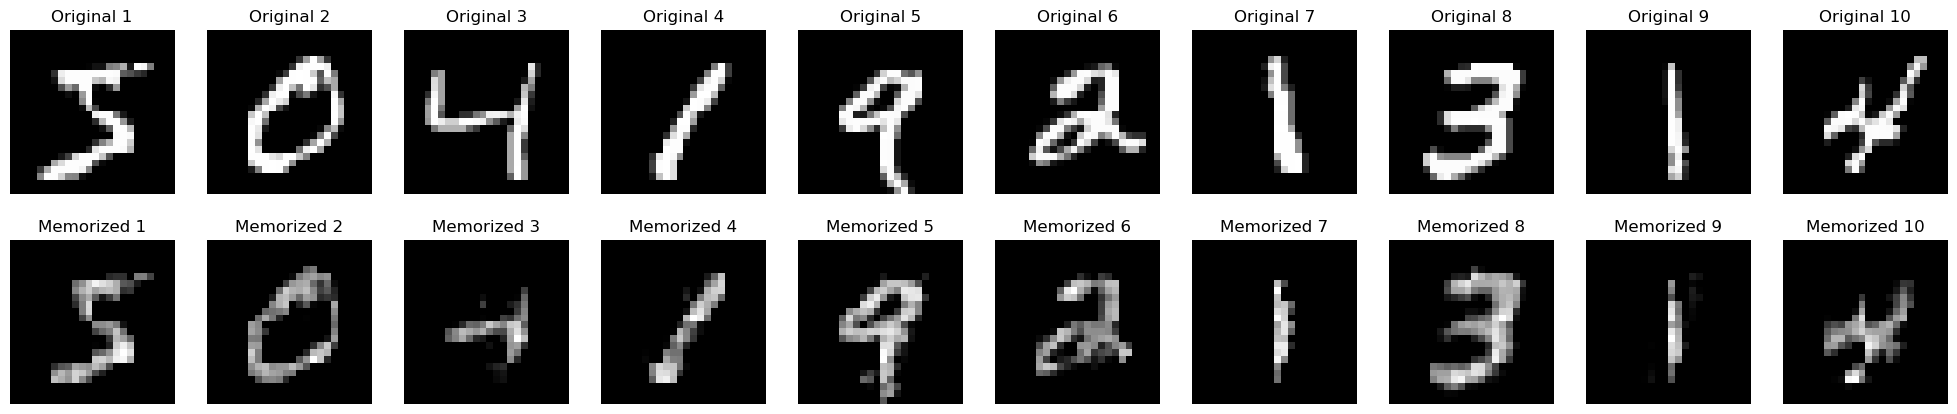

Epoch 195 | Train loss 0.004817 | Memorization loss 0.112943
Visualizing results at Epoch 196


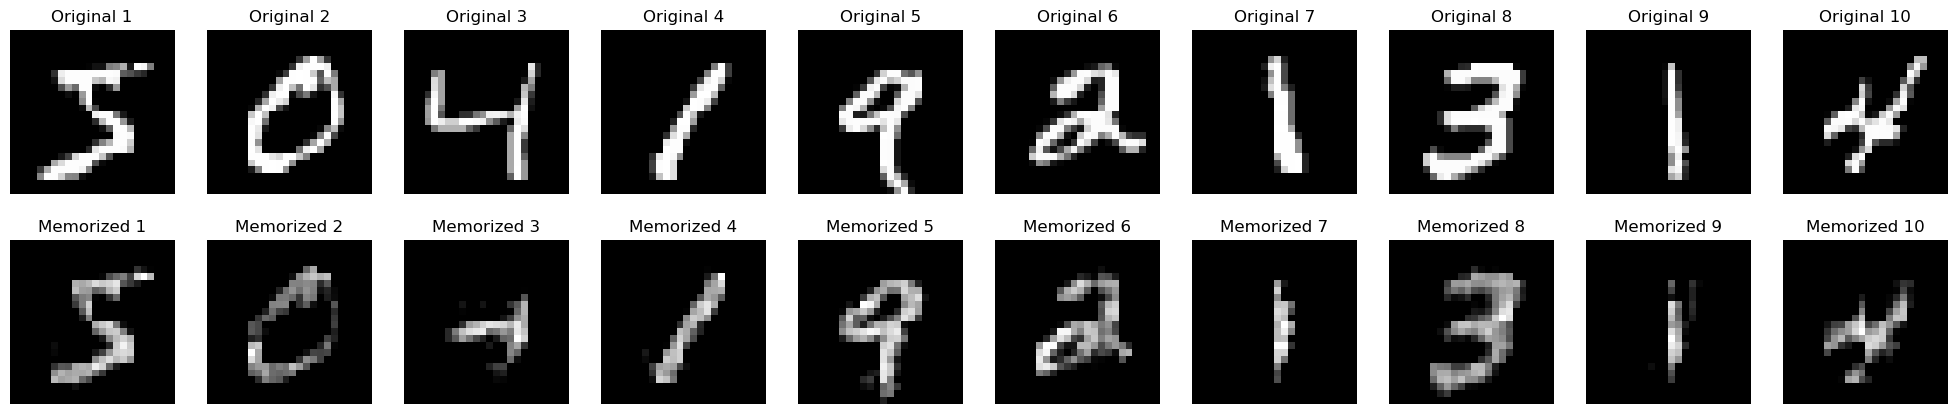

Epoch 196 | Train loss 0.004815 | Memorization loss 0.107397
Saved model and optimizer with memorization loss: 0.1074
Visualizing results at Epoch 197


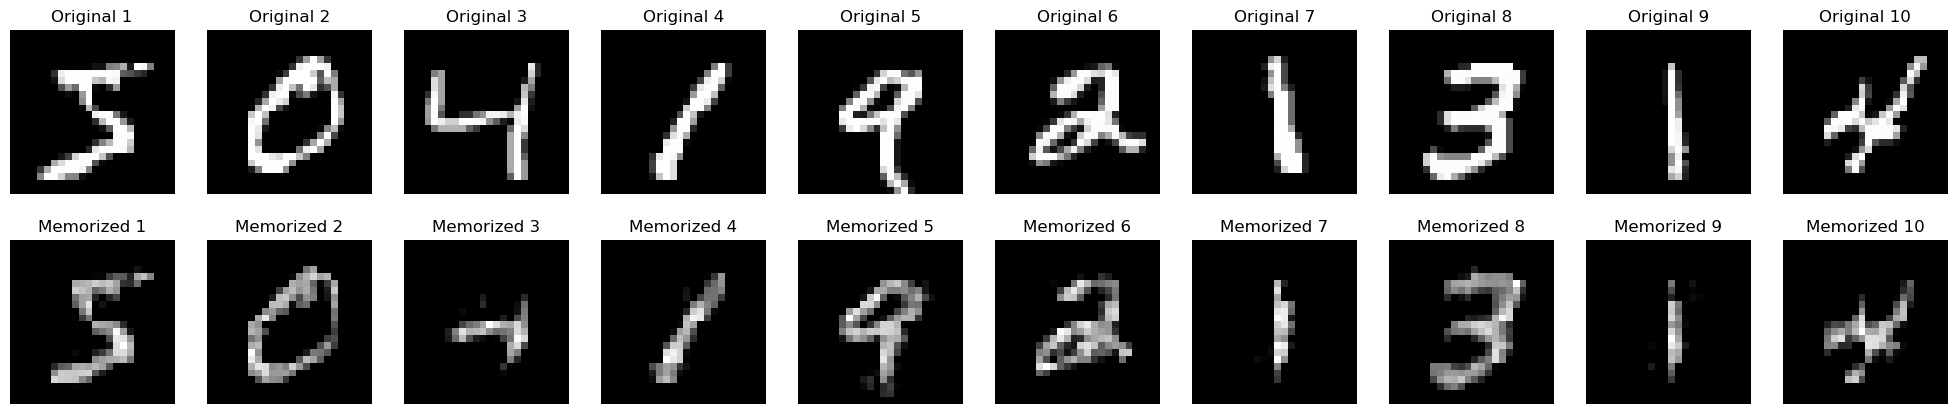

Epoch 197 | Train loss 0.004815 | Memorization loss 0.109762
Visualizing results at Epoch 198


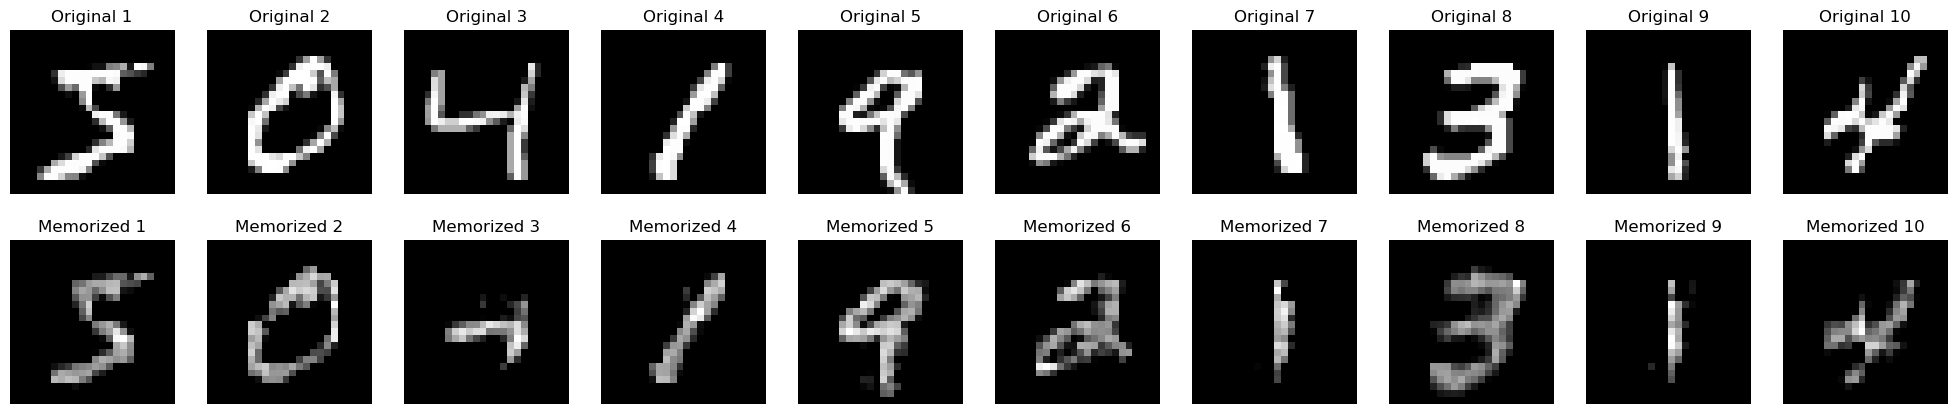

Epoch 198 | Train loss 0.004814 | Memorization loss 0.111035
Visualizing results at Epoch 199


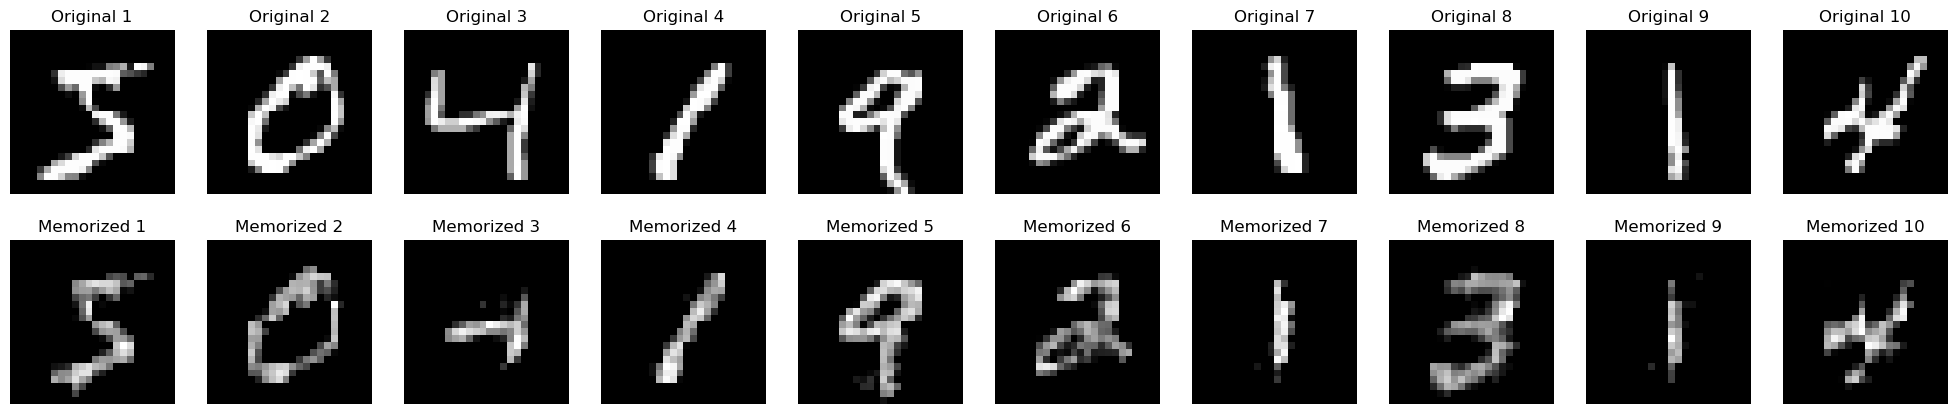

Epoch 199 | Train loss 0.004816 | Memorization loss 0.111565
Visualizing results at Epoch 200


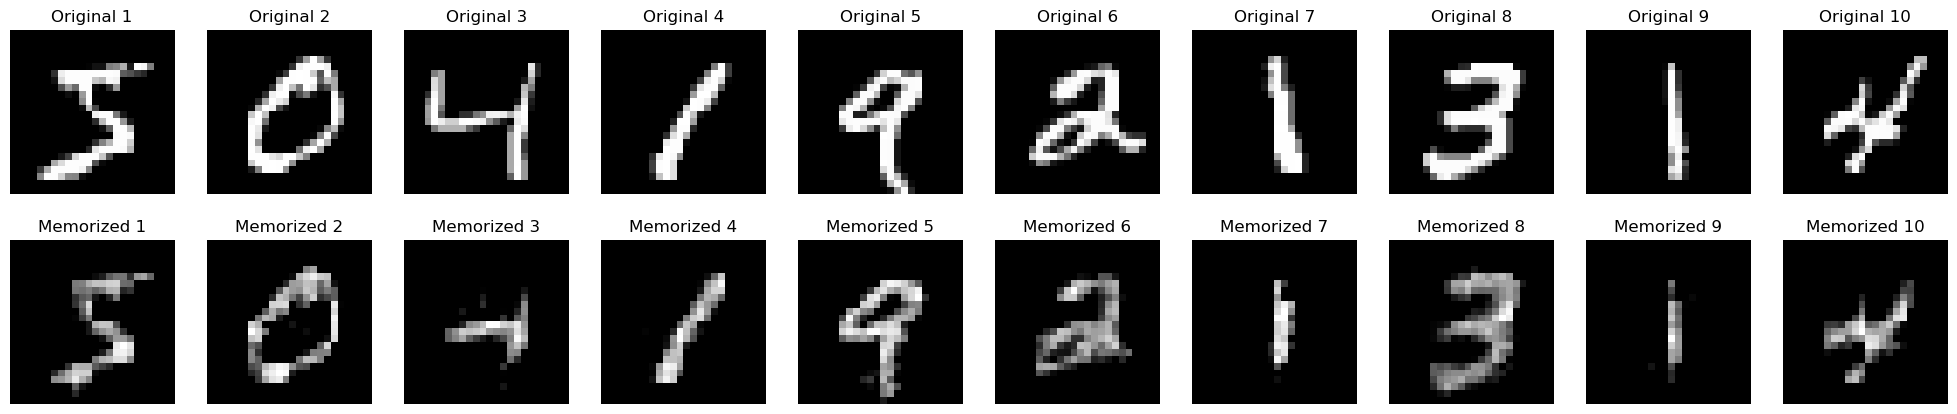

Total training time: 00:41:05 (hh:mm:ss)


In [ ]:
train(simple_cnn, train_loader_cls, mem_dataloader, optimizer, 200, device)

In [ ]:
def load_model(model_path, model, optimizer, device):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model, optimizer

In [ ]:
best_model, _ = load_model(MODEL_PATH, simple_cnn, optimizer, device)

In [ ]:
def test_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
test_accuracy(best_model, test_loader_cls , device)

0.89

In [ ]:
def generate_reconstructed_images_and_labels(model, device, mem_dataset):
    num_samples = int(MNIST_SAMPLE_PERCENTAGE * TRAIN_DATASET_LEN)

    reconstructed_images = []
    original_images = []
    labels = []

    for idx in range(num_samples):
        output, target_image = get_image(idx, model,device)
        reconstructed_images.append(output.to(device))
        original_images.append(target_image.to(device))

        one_hot_label_region = mem_dataset.class_codes[idx]
        label = one_hot_label_region.argmax().item()
        labels.append(label)

    reconstructed_images = torch.stack(reconstructed_images)
    original_images = torch.stack(original_images)

    # Normalize the original images to [0, 1]
    original_images = original_images.float() / 255.0
    # Clamp the reconstructed images to [0, 1] to remove any negative values
    reconstructed_images = torch.clamp(reconstructed_images, 0, 1)
    labels = torch.tensor(labels, device=device)

    return reconstructed_images, original_images, labels

In [ ]:
# ssim token from GitHub - https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
import torch
import torch.nn.functional as F

WINDOW_SIZE = 3

def gaussian(window_size, sigma):
    gauss = torch.tensor([-(x - window_size // 2) ** 2 / float(2 * sigma ** 2) for x in range(window_size)])
    gauss = torch.exp(gauss)
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=WINDOW_SIZE, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    window = window.to(img1.device)
    return _ssim(img1, img2, window, window_size, channel, size_average)

# add this function

def calculate_ssim_for_batches(reconstructed_images, original_images, window_size=WINDOW_SIZE):
    if reconstructed_images.dim() == 3:  # Add channel dimension if not present
        reconstructed_images = reconstructed_images.unsqueeze(1)
    if original_images.dim() == 3:  # Add channel dimension if not present
        original_images = original_images.unsqueeze(1)

    device = original_images.device
    channel = original_images.size(1)
    window = create_window(window_size, channel).to(device)
    window = window.to(device)

    # Calculate SSIM for each image in the batch
    ssim_scores = _ssim(reconstructed_images, original_images, window, window_size, channel, size_average=False)
    return ssim_scores, ssim_scores.mean().item()


In [ ]:
# Generate reconstructed images and original images
reconstructed_images, original_images, labels = generate_reconstructed_images_and_labels(best_model, device, mem_dataset)

# Calculate SSIM values for the batches
ssim_values, average_ssim = calculate_ssim_for_batches(reconstructed_images, original_images)

# Print SSIM values and the average SSIM
print(f'SSIM values: {ssim_values}')
print(ssim_values.shape)
print(f'Average SSIM: {average_ssim}')

SSIM values: tensor([0.8793, 0.9201, 0.7648,  ..., 0.7749, 0.7472, 0.8480], device='cuda:0')
torch.Size([4000])
Average SSIM: 0.7722524404525757


In [ ]:
from torch.nn.functional import mse_loss
mse_value = mse_loss(reconstructed_images, original_images)
mse_value

tensor(0.0353, device='cuda:0')

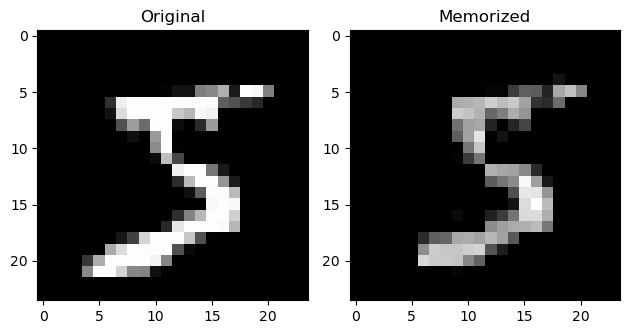

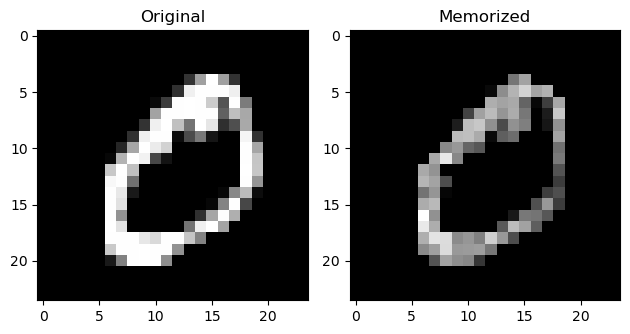

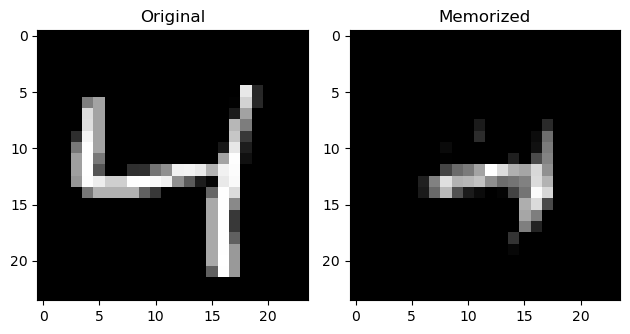

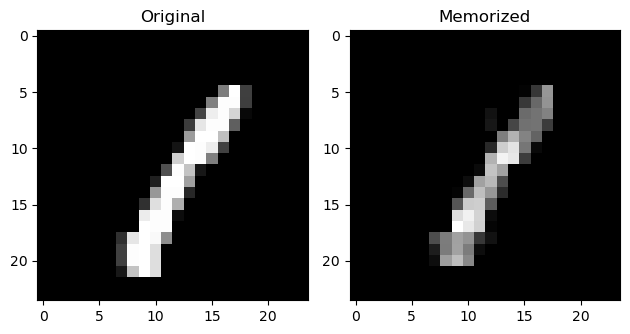

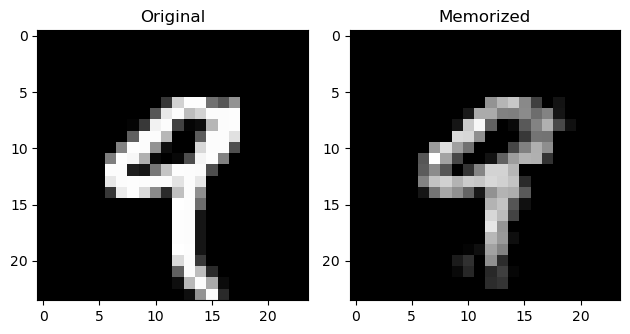

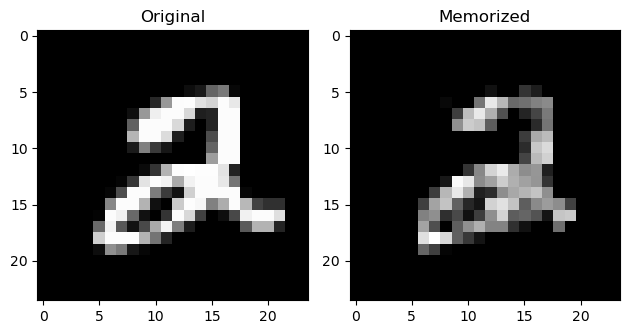

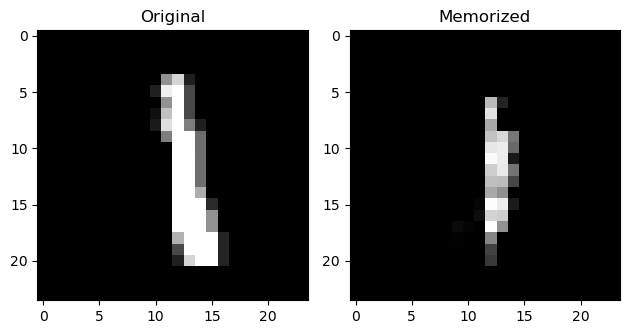

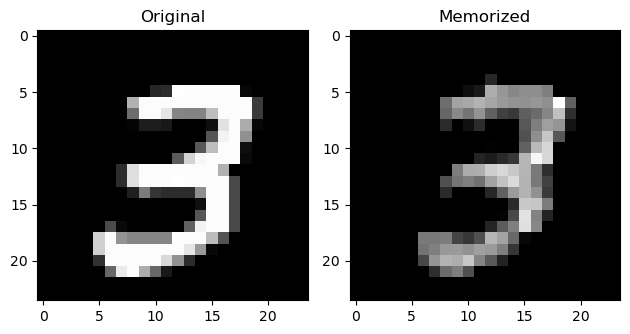

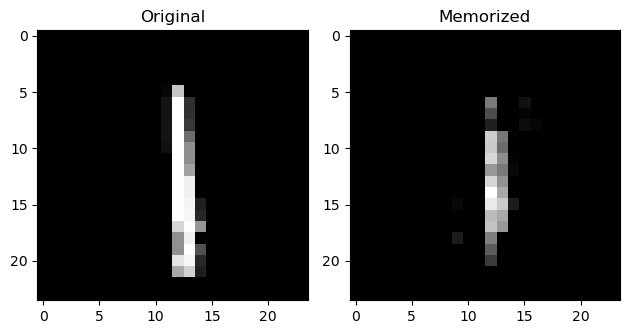

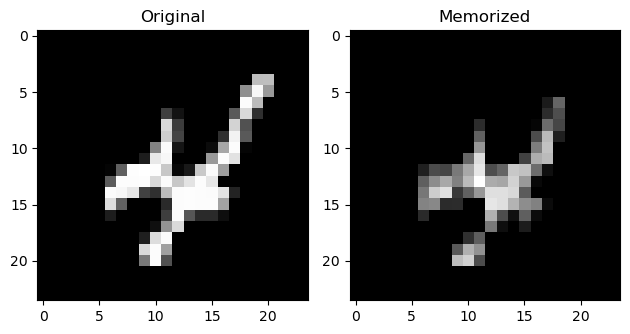

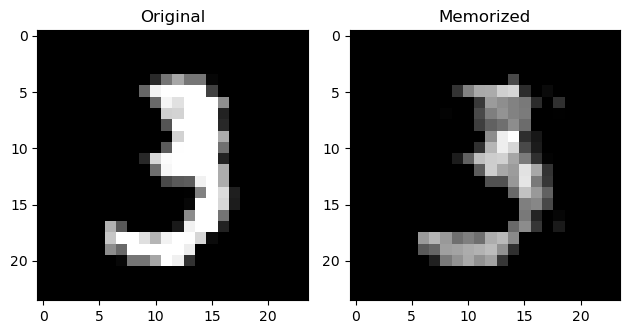

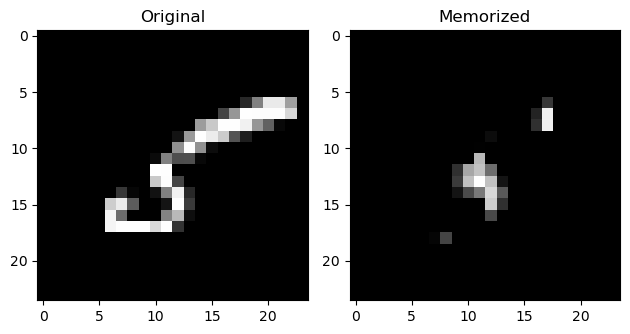

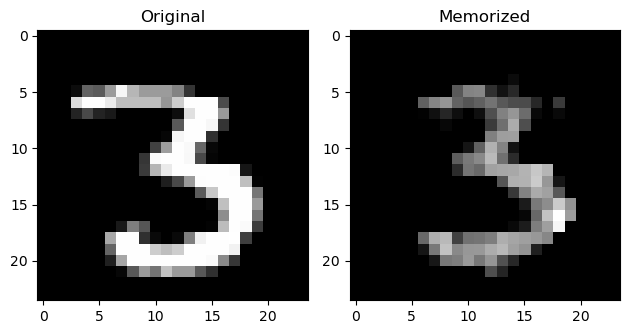

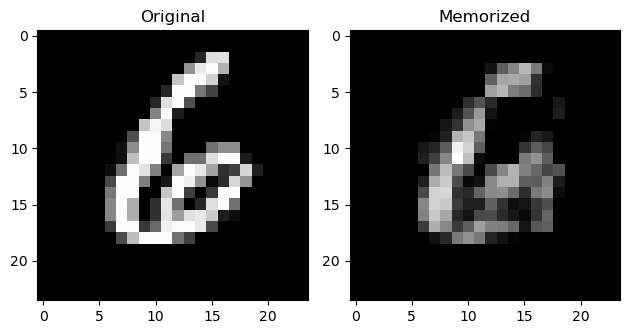

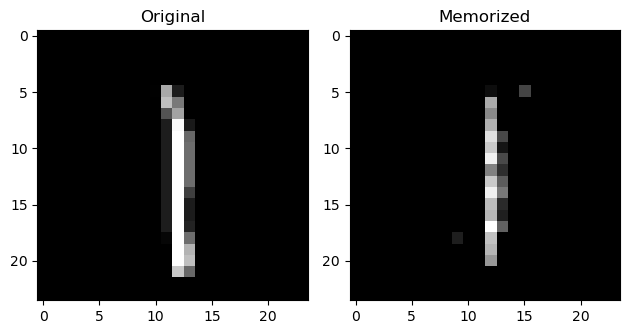

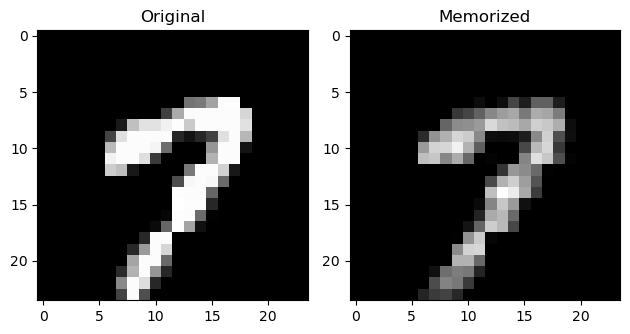

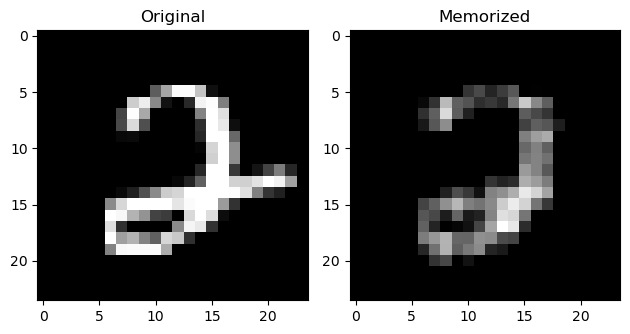

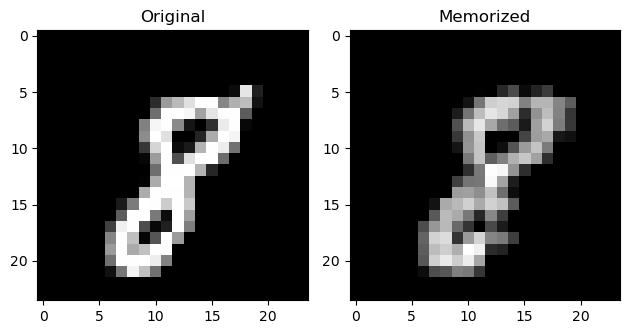

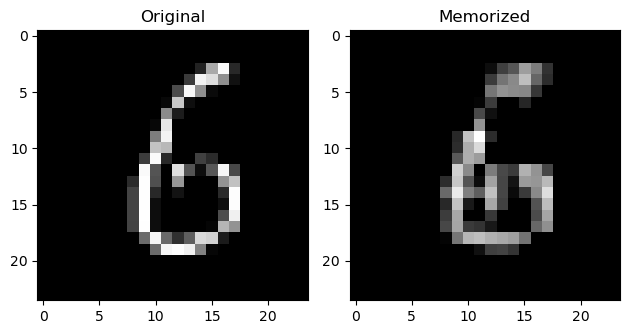

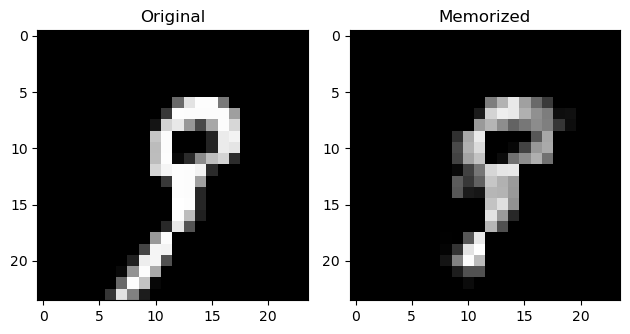

In [ ]:
# Loop over a range of indices (in this case, the first 20 indices) in the dataset.
for idx in range(20):
    output, target_image = get_image(idx, simple_cnn,device)
    fig, ax = plt.subplots(ncols=2, tight_layout=True)

    ax[0].imshow(target_image, cmap='gray')
    ax[0].set_title('Original')

    ax[1].imshow(output, cmap='gray')
    ax[1].set_title('Memorized')

    plt.show()